Enter Start Date: (YY/MM/DD)15/10/01
Activate Short Selling (Y/N)? y
Activate Hedges (Y/N)? y
ETF Mapping (Y/N)? y
Single name trading (Y/N)? y
Slim Port (Y/N)? y
Frequent Rebalancings (Y/N)? y
(S)istematic, (Q)uant hedge, (A)nd, (O)r? (O) o
Rebalancing % time: 6.99

Consumer Goods Single Name OK
Consumer Services Single Name OK
Energy Single Name OK
Financials Single Name OK
Hardware Single Name OK
Health Care Single Name OK
Industrials Single Name OK
Materials Single Name OK
Software Single Name OK
Telecommunications Single Name OK
Utilities Single Name OK
Dates
2016-12-31    11.78
2017-12-31    33.22
2018-12-31    50.67
2019-12-31    35.69
2020-12-31    84.06
2021-12-31    22.64
2022-12-31   -10.89
2023-12-31    14.80
Freq: A-DEC, Name: Net, dtype: float64

Total: 591.09%
CAGR: 31.2%
CAGR / DD: 1.52
Average exposure: 0.84

Average Long: 73.64
Median Long: 85.0

Longs:
['XLV US']

Shorts:
['XLY US', 'QQQ US']

Algo Daily: 0.06%

RWR US Daily: 2.35%
XLB US Daily: 0.8%
XLI US Daily: 0.

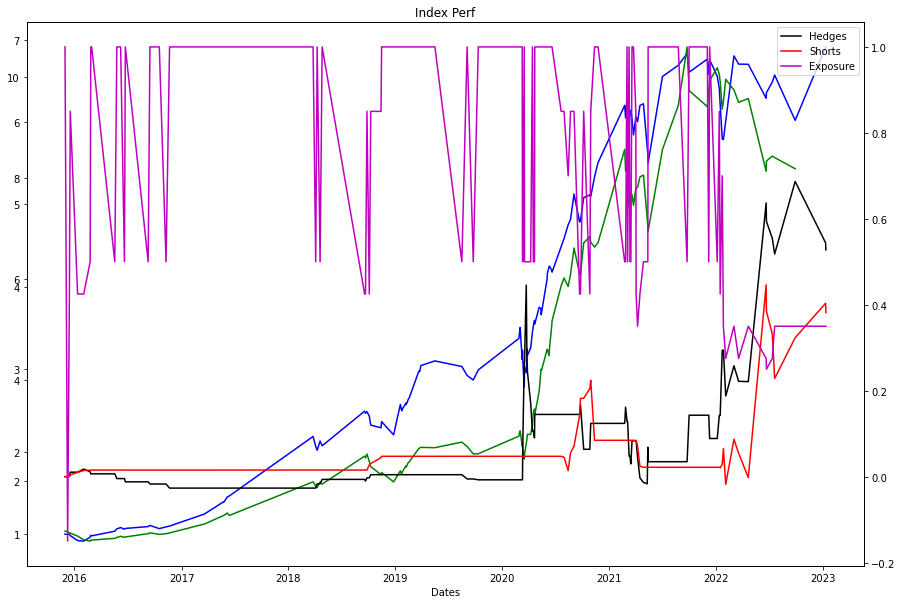

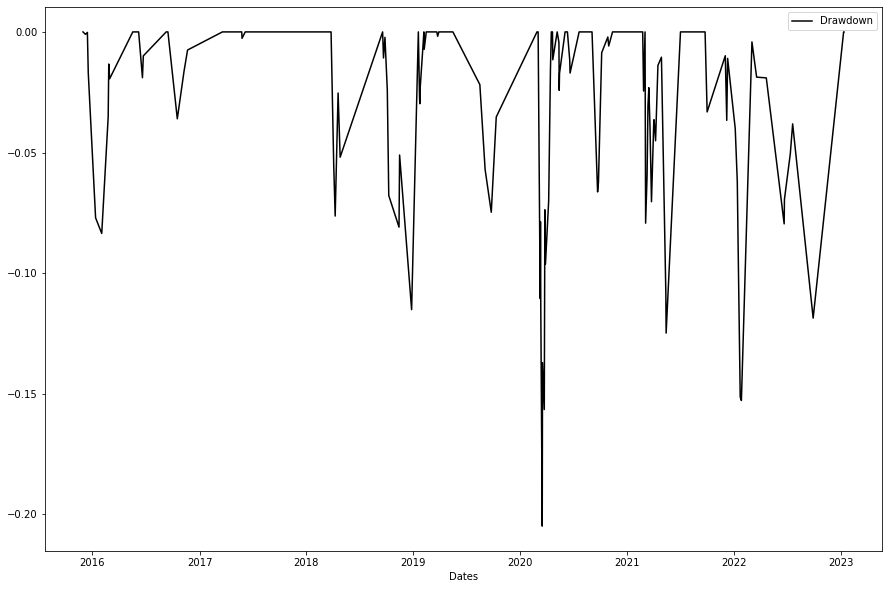

<Figure size 432x288 with 0 Axes>

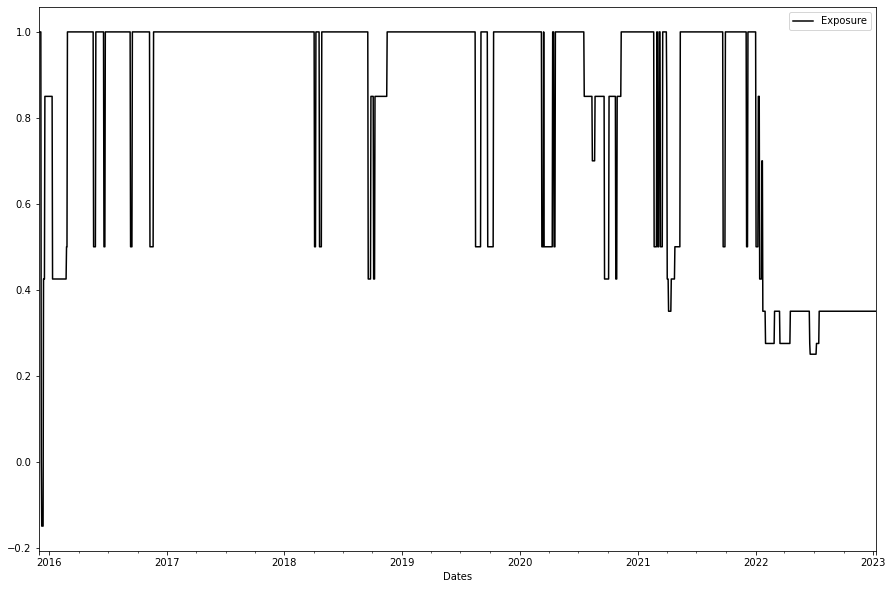

In [3]:
#SECTOR ALGO MVR BACKTESTING

%run C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\algo_pca.py

In [781]:
#1Y resampling w/ 1Y time window

print('Yearly Results:')
YearlyPerformance_df = FullPerformance_df.copy()    
YearlyPerformance_df.index = YearlyPerformance_df.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
round(100 * YearlyPerformance_df.resample('Y').last().pct_change().dropna(), 2)

Yearly Results:


Net
Dates            
2017-12-31   0.83
2018-12-31  15.55
2019-12-31  43.23
2020-12-31  91.63
2021-12-31  16.92
2022-12-31  38.46
2023-12-31  -3.88

(O)ld or (N)ew? O
Update Correlations (Y/N)? N
(L)ive or (B)acktest? L
Enter Start Date: (YY/MM/DD)17/01/01
Samples (0 for prod): 0
Instant

2017/Jan/02 - 2023/Dec/26
[ 0.875  4.75  -3.25   3.25  -0.75   2.75   3.25   2.5    2.75   3.5
  3.75  15.    -8.5    0.    -7.     2.    34.     4.   ]

Consumer Goods
Consumer Services
Energy
Financials
Hardware
Health Care
Industrials
Materials
Software
Telecommunications
Utilities
Rebalancing % time: 7.78

Consumer Goods Single Name OK
Consumer Services Single Name OK
Energy Single Name OK
Financials Single Name OK
Hardware Single Name OK
Health Care Single Name OK
Industrials Single Name OK
Materials Single Name OK
Software Single Name OK
Telecommunications Single Name OK
Utilities Single Name OK


ValueError: datetime.date(2023, 12, 25) is not in list

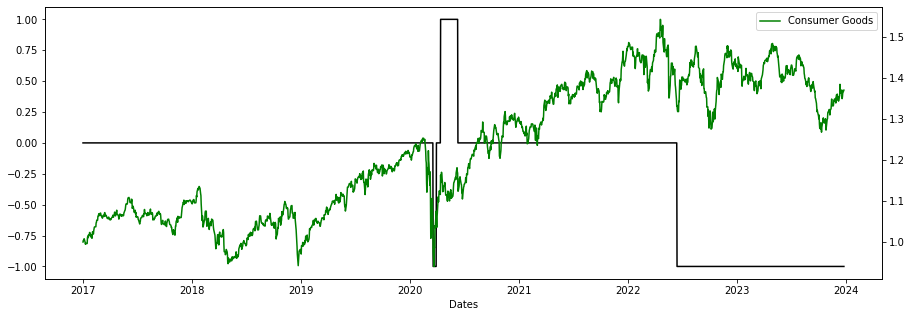

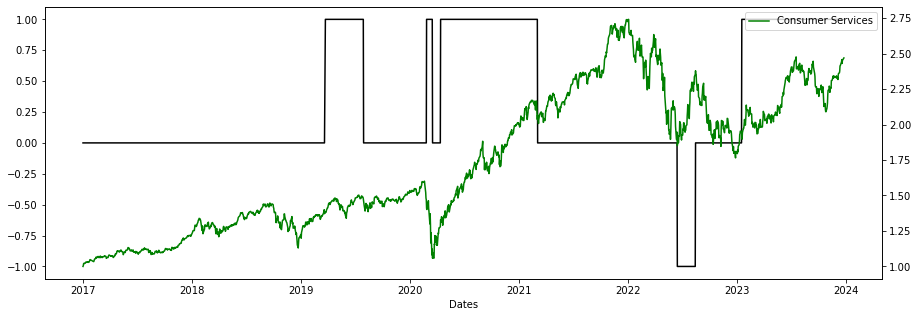

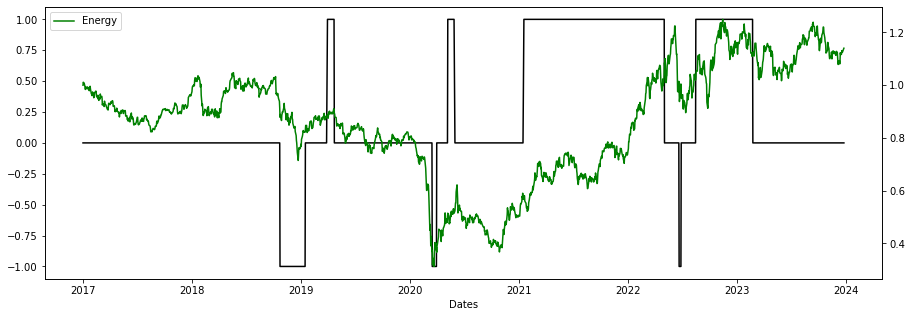

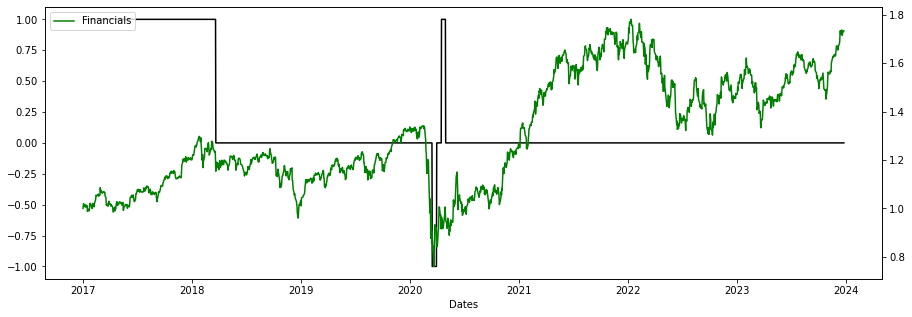

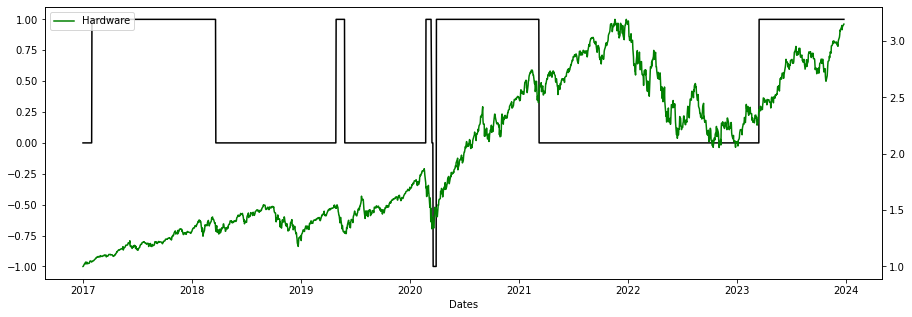

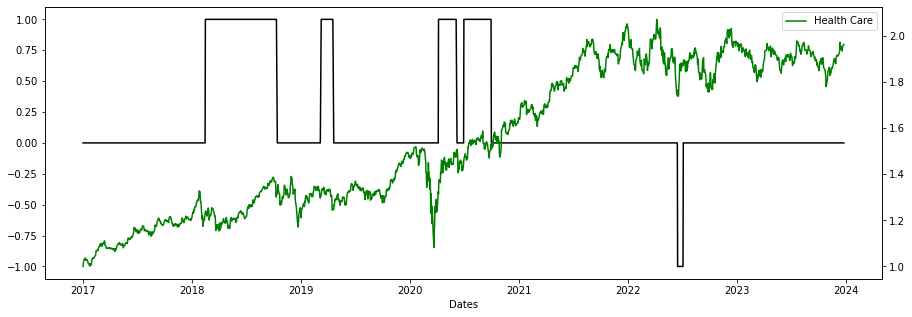

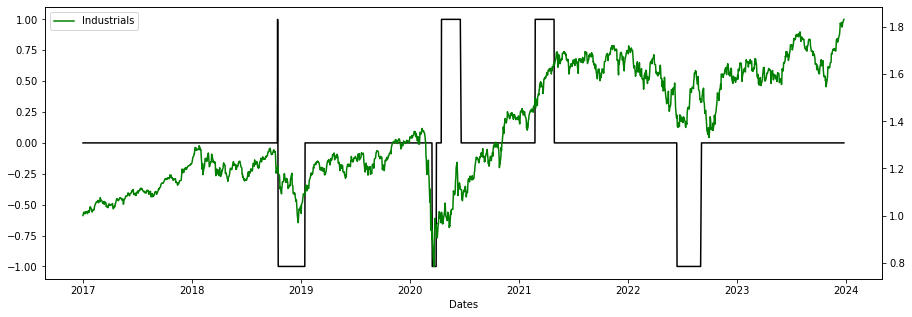

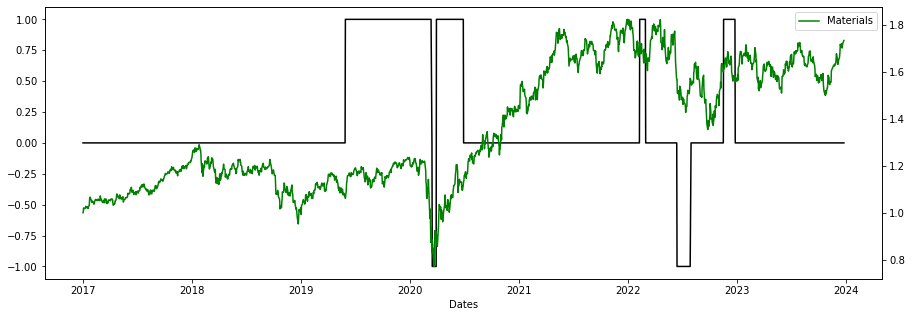

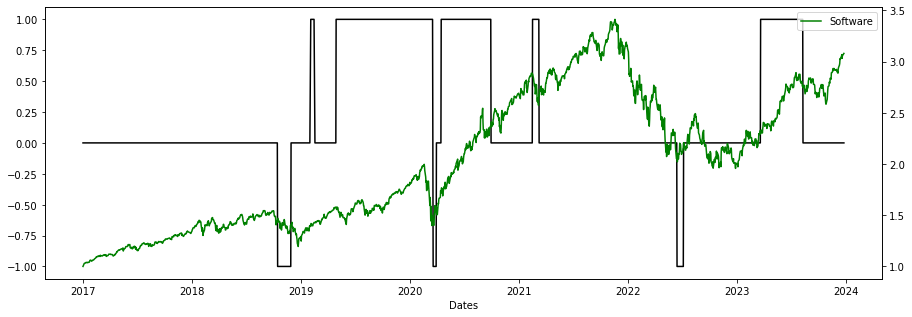

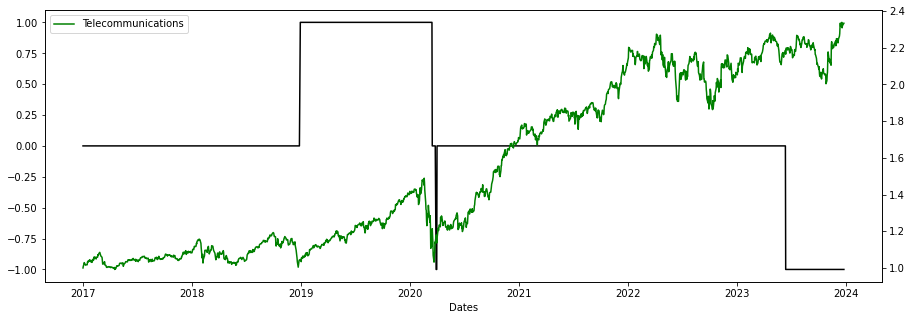

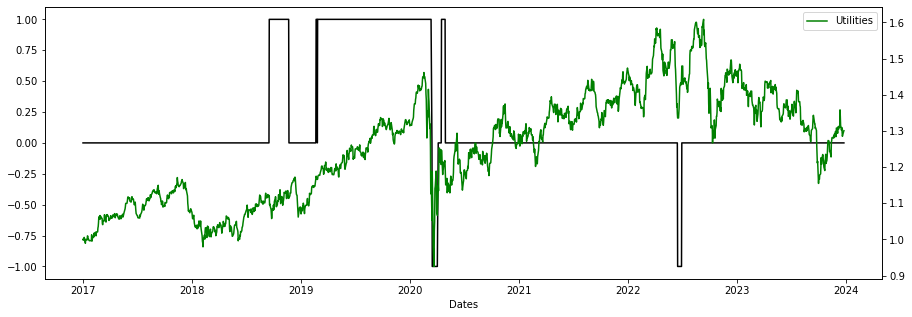

In [212]:
#%%writefile C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\pca_sectors_algo_fullsim.py

#FINAL SIMULATOR

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings
import joblib
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR
from scipy.stats import norm

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def on_selection(value):
    global choice
    choice = value
    root.destroy()
    
def on_selection_tenor(value):
    global choice_tenor
    choice_tenor = value
    root.destroy()
    
def on_selection_date(value):
    global choice_date
    choice_date = value
    root.destroy()
    
def Adjust_DT(dt):

    if (dt.weekday() == 5):
        dt = dt + timedelta(2)
    if (dt.weekday() == 6):
        dt = dt + timedelta(1)
    if ((dt.day == 25) & (dt.month == 12)) | ((dt.day == 1) & (dt.month == 1)):
        dt = dt + timedelta(1)
    if (dt.weekday() == 5):
        dt = dt + timedelta(2)
    if (dt.weekday() == 6):
        dt = dt + timedelta(1)
    
    return dt

def Equiv(X):
    
    for sector in Equivalence_df.columns.values.tolist():
        print(sector)
        if (sector not in X.columns):
            X = ETF_Daily_Returns.join(Sector_Daily_Returns[sector])
        Equivalent_ETF = X.rolling(63, min_periods = 21).corr()[sector]
        Corr_df = Equivalent_ETF.unstack().dropna(how = 'all').drop(sector, axis = 1)
        corr_dates_list = Corr_df[Corr_df.index >= min(Equivalence_df.index)].index
        for current_date in corr_dates_list:
            Equivalence_df.loc[current_date, sector] = Corr_df.loc[current_date].sort_values().index[-1]
    Equivalence_df.dropna(how = 'all', inplace = True)
    Equivalence_df.to_sql('etf_equivalence_relation', engine, index = True, if_exists = 'replace')
    
    return Equivalence_df

def Current(Binary_df, hedge_df, c_Equivalence_df, Perf_df, c_Prices_df, c_Equiv_Indexes_df, c_FX_df):

    sectors_long_list = []
    sectors_short_list = []
    yesterday = c_Equivalence_df.index[-2]
    today = c_Equivalence_df.index[-1]
    dates_list = [yesterday, today]
    for curr_date in dates_list:
        cont = True
        prev_date = c_Equivalence_df.index[c_Equivalence_df.index.values.tolist().index(curr_date) - 1]
        last_reb_date = Binary_df.index[0]
        c = 0
        if (len(Binary_df.loc[: prev_date].index) > 0):
            while (cont):
                date_c = Binary_df.index[Binary_df.index.values.tolist().index(curr_date) - c]
                date_p = Binary_df.index[Binary_df.index.values.tolist().index(curr_date) - c - 1]
                if (Binary_df.loc[date_c].values.tolist() != Binary_df.loc[date_p].values.tolist()):
                    last_reb_date = date_c
                    cont = False
                else:
                    c = c + 1
                    if (c >= len(Binary_df.index)):
                        cont = False

        last_hedge_change = (hedge_df == hedge_df.shift(1))[(hedge_df == hedge_df.shift(1)) == 0].index[-1]
        last_reb_date = max(last_reb_date, last_hedge_change)
        last_reb_k = Perf_df.loc[last_reb_date][0]

        sectors_long_list = Binary_df.loc[last_reb_date][Binary_df.loc[last_reb_date] == 1].index.values.tolist()
        sectors_short_list = Binary_df.loc[last_reb_date][Binary_df.loc[last_reb_date] == -1].index.values.tolist()

        if (len(sectors_short_list) > 0):
            short_weight = min(0.15, 0.5 / len(sectors_short_list))
            Equivalence_curr = c_Equivalence_df.loc[: prev_date]
            Allocations_Short_df = pd.DataFrame(np.nan, index = sectors_short_list, columns = ['ETF Short', 'Last Sector Date', 'Last Stock Date', 'Sector Alloc', 'Stock Alloc', 'Px PR', 'Px D-1', 'Px D0', 'Position'])

            for curr_short in sectors_short_list:
                last_sector_date = (Equivalence_curr[curr_short] == Equivalence_curr[curr_short].shift(1))[(Equivalence_curr[curr_short] == Equivalence_curr[curr_short].shift(1)) == 0].index[-1]
                ETF_short = Equivalence_curr.iloc[-1][curr_short]
                Allocations_Short_df.loc[curr_short, 'ETF Short'] = ETF_short
                Allocations_Short_df.loc[curr_short, 'Last Sector Date'] = last_reb_date
                Allocations_Short_df.loc[curr_short, 'Last Stock Date'] = max(last_reb_date, last_sector_date)
                Allocations_Short_df.loc[curr_short, 'Sector Alloc'] = (- short_weight * c_Equiv_Indexes_df.loc[Allocations_Short_df.loc[curr_short, 'Last Stock Date'], curr_short] / c_Equiv_Indexes_df.loc[last_reb_date, curr_short]) 
                Allocations_Short_df.loc[curr_short, 'Stock Alloc'] = 1.00
                Allocations_Short_df.loc[curr_short, 'Px PR'] = c_Prices_df.loc[Allocations_Short_df.loc[curr_short, 'Last Stock Date'], ETF_short]
                Allocations_Short_df.loc[curr_short, 'Px D-1'] = c_Prices_df.loc[curr_date, ETF_short]
                Allocations_Short_df.loc[curr_short, 'Px D0'] = c_Prices_df.loc[today, ETF_short]
        else:
            Allocations_Short_df = pd.DataFrame(np.nan, index = ['Dummy'], columns = ['Sector', 'Last Sector Date', 'Last Stock Date', 'Sector Alloc', 'Stock Alloc', 'Px PR', 'Px D-1', 'Px D0', 'Position'])

        if (len(sectors_long_list) > 0):
            Allocations_Long_df = pd.DataFrame(np.nan, index = ['Dummy'], columns = ['Sector', 'Last Sector Date', 'Last Stock Date', 'Sector Alloc', 'Stock Alloc', 'Px PR', 'Px D-1', 'Px D0', 'Position'])
            for current_sector in sectors_long_list:
                portfolio_string = re.sub(r'[^a-z_^0-9]', '', current_sector.lower()) + '_portfolio_selection_slim_' + comp_ext
                query_index_port = 'SELECT * FROM ' + portfolio_string  
                Index_Port_df = pd.read_sql_query(query_index_port, engine)
                Index_Port_df.index = pd.Index(Index_Port_df[Index_Port_df.columns[-1]], name = 'Date')
                sector_index_series = Index_Port_df[Index_Port_df.columns[-2]]
                Index_Port_df.drop(['Date', Index_Port_df.columns[-1], Index_Port_df.columns[-2]], axis = 1, inplace = True)
                lev1_list = Index_Port_df.columns.map(lambda x: x.split(',')[0][2:-1]).values.tolist()
                lev2_list = Index_Port_df.columns.map(lambda x: int(x.split(',')[1][1:-1])).values.tolist()
                Index_Port_df.columns = [lev1_list, lev2_list]
                Index_Port_df['Index'] = sector_index_series
                Index_Port_df.sort_index(inplace = True)
                cont = True
                last_sector_date = last_reb_date
                c = 0
                while (cont):
                    date_c = Index_Port_df.index[Index_Port_df.index.values.tolist().index(curr_date) - c]
                    date_p = Index_Port_df.index[Index_Port_df.index.values.tolist().index(curr_date) - c - 1]
                    if (Index_Port_df.loc[date_c, 'Stocks'].values.tolist() != Index_Port_df.loc[date_p, 'Stocks'].values.tolist()):
                        last_sector_date = date_c
                        cont = False
                    else:
                        c = c + 1
                        if (c >= len(Index_Port_df.index)):
                            cont = False

                date_c = Index_Port_df.index[Index_Port_df.index.values.tolist().index(curr_date) - 1]
                stocks_long_list = Index_Port_df['Stocks'].loc[curr_date][Index_Port_df['Stocks'].loc[curr_date] != ''].values.tolist()
                for curr_long in stocks_long_list:
                    if (curr_long not in Allocations_Long_df.index.values.tolist()):
                        Allocations_Long_df.loc[curr_long] = np.nan
                    Allocations_Long_df.loc[curr_long, 'Sector'] = current_sector
                    Allocations_Long_df.loc[curr_long, 'Last Sector Date'] = last_reb_date
                    Allocations_Long_df.loc[curr_long, 'Last Stock Date'] = max(last_sector_date, last_reb_date)
                    Allocations_Long_df.loc[curr_long, 'Sector Alloc'] = (1 / len(sectors_long_list)) * c_Equiv_Indexes_df.loc[Allocations_Long_df.loc[curr_long, 'Last Stock Date'], current_sector] / c_Equiv_Indexes_df.loc[last_reb_date, current_sector]
                    Allocations_Long_df.loc[curr_long, 'Stock Alloc'] = (1 / len(stocks_long_list))
                    Allocations_Long_df.loc[curr_long, 'Px PR'] = c_Prices_df.loc[Allocations_Long_df.loc[curr_long, 'Last Stock Date'], curr_long] / c_Prices_df.loc[Allocations_Long_df.loc[curr_long, 'Last Stock Date'], 'USD' + c_FX_df.loc[curr_long[-2:], 'Pair']]
                    Allocations_Long_df.loc[curr_long, 'Px D-1'] = c_Prices_df.loc[curr_date, curr_long] / c_Prices_df.loc[curr_date, 'USD' + c_FX_df.loc[curr_long[-2:], 'Pair']]
                    Allocations_Long_df.loc[curr_long, 'Px D0'] = c_Prices_df.loc[today, curr_long] / c_Prices_df.loc[today, 'USD' + c_FX_df.loc[curr_long[-2:], 'Pair']]
            Allocations_Long_df.drop(['Dummy'], inplace = True)
            Allocations_Short_df['Sector'] = Allocations_Short_df.index
            Allocations_Short_df.index = Allocations_Short_df['ETF Short'].values
            Allocations_Short_df.drop(['ETF Short'], axis = 1, inplace = True)
            Last_Allocations_df = pd.concat([Allocations_Short_df, Allocations_Long_df])
        else:
            Allocations_Short_df['Sector'] = Allocations_Short_df.index
            Allocations_Short_df.index = Allocations_Short_df['ETF Short'].values
            Allocations_Short_df.drop(['ETF Short'], axis = 1, inplace = True)
            Last_Allocations_df = Allocations_Short_df.copy()
        if (hedge_df.loc[last_reb_date]):
            Last_Allocations_df.loc['SPX'] = np.nan
            Last_Allocations_df.loc['SPX', 'Sector'] = 'Hedge'
            Last_Allocations_df.loc['SPX', 'Last Sector Date'] = last_reb_date
            Last_Allocations_df.loc['SPX', 'Last Stock Date'] = last_reb_date
            Last_Allocations_df.loc['SPX', 'Sector Alloc'] = -0.5 * (max(0, min(len(sectors_long_list), 1)) - min(len(sectors_short_list) * 0.15, 0.5))
            Last_Allocations_df.loc['SPX', 'Stock Alloc'] = 1.00
            Last_Allocations_df.loc['SPX', 'Px PR'] = c_Prices_df.loc[last_reb_date, 'SPX']
            Last_Allocations_df.loc['SPX', 'Px D-1'] = c_Prices_df.loc[curr_date, 'SPX']
            Last_Allocations_df.loc['SPX', 'Px D0'] = c_Prices_df.loc[today, 'SPX']

        if (len(sectors_long_list) == 0) & (len(sectors_short_list) == 0):
            Last_Allocations_df = pd.DataFrame(0, index = ['Dummy'], columns = ['Sector', 'Last Sector Date', 'Last Stock Date', 'Sector Alloc', 'Stock Alloc', 'Px PR', 'Px D-1', 'Px D0', 'Position'])
            if (curr_date == yesterday):
                Prev_Allocations_df = Last_Allocations_df.copy()
            else:
                Curr_Allocations_df = Last_Allocations_df.copy() 
        else:
            if ('Dummy' in Last_Allocations_df.index.values.tolist()):
                Last_Allocations_df.drop(['Dummy'], inplace = True)
            Last_Allocations_df['Position'] = (last_reb_k * Last_Allocations_df['Sector Alloc'] * Last_Allocations_df['Stock Alloc'] / Last_Allocations_df['Px PR'])
            ttl_k = Last_Allocations_df['Position'] * Last_Allocations_df.T.columns.map(lambda x: c_Prices_df.loc[today, x]).T
            ttl_k = ttl_k.sum() - (Last_Allocations_df[Last_Allocations_df['Position'] < 0]['Position'].values * Last_Allocations_df[Last_Allocations_df['Sector Alloc'] < 0].T.columns.map(lambda x: c_Prices_df.loc[last_reb_date, x]).values).sum()
            if (curr_date == yesterday):
                Last_Allocations_df['Init W'] = Last_Allocations_df['Sector Alloc'] * Last_Allocations_df['Stock Alloc']
                Last_Allocations_df['Curr W'] = Last_Allocations_df['Position'] * Last_Allocations_df['Px D0'] / ttl_k
                Last_Allocations_df['Contrib'] = round(100 * (Last_Allocations_df['Px D0'] / Last_Allocations_df['Px D-1'] - 1) * Last_Allocations_df['Curr W'], 3)  
                Prev_Allocations_df = Last_Allocations_df.copy()
            else:
                Curr_Allocations_df = Last_Allocations_df.copy()

    Prev_Positions_df = Prev_Allocations_df.groupby(Prev_Allocations_df.index).sum()['Position']
    Curr_Positions_df = Curr_Allocations_df.groupby(Curr_Allocations_df.index).sum()['Position']
    Trades_df = pd.DataFrame(Prev_Positions_df).join(Curr_Positions_df, lsuffix = '_Old', rsuffix = '_New', how = 'outer').fillna(0)
    Trades_df['Trades'] = Trades_df['Position_New'] - Trades_df['Position_Old']
    if (Trades_df['Trades'].sum() != 0):
        print('')
        print('New Trades:')
        print(Trades_df[Trades_df['Trades'] != 0])
        print('')   

    if (Prev_Allocations_df.index[0] != 'Dummy'):
        print('')
        print(today.strftime('%Y-%b-%d') + ' Daily P&L: ' + str(round(Prev_Allocations_df['Contrib'].sum(), 3)) + '%')
        Prev_Allocations_df['Init W'] = round(100 * Prev_Allocations_df['Init W'], 2)
        Prev_Allocations_df['Curr W'] = round(100 * Prev_Allocations_df['Curr W'], 2)
        Prev_Allocations_df['Contrib'] = round(Prev_Allocations_df['Contrib'], 2)
        return Prev_Allocations_df[['Sector', 'Last Stock Date', 'Init W', 'Curr W', 'Px PR', 'Px D-1', 'Px D0', 'Contrib']]
    else:
        return Prev_Allocations_df        
        
def PlotGraphs(Index_df, p_Prices_df):
    
    Index_df = Index_df.join(Prices_df['ARKK US']).join(Prices_df['QQQ US']).join(Prices_df['SPX']).join(Prices_df['IWM US'])
    first_date = Index_df.index[0]
    last_date = Index_df.index[-1]
    Index_df.index = Index_df.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    Index_df = Index_df / Index_df.iloc[0]
    Index_df.plot(title = 'Indices', figsize = (12, 8)).legend(loc = 'best')
    Idx_returns_df = Index_df.pct_change().dropna()

    DD_df = 100 * (Index_df - Index_df.expanding().max()) / Index_df.expanding().max()
    DD_df.drop(DD_df.index[0], inplace = True)
    DD_df.plot(title = 'Rolling Max Drawdown', figsize = (12, 8)).legend(loc = 'best')

    YResample_Index_df = Index_df.resample('Y').last()
    YResample_Index_df.index = YResample_Index_df.T.columns.map(lambda x: x.date)
    YResample_Index_df.loc[first_date] = 1
    YResample_Index_df.sort_index(inplace = True)
    YResample_Index_df.loc[last_date] = YResample_Index_df.iloc[-1].values
    YResample_Index_df.sort_index(inplace = True)
    YResample_Index_df.drop(YResample_Index_df.index[-1], inplace = True)
    YearlyRets_df = round(100 * YResample_Index_df.pct_change().dropna(), 2) 

    CAGR_df = round((100 * ((YResample_Index_df.drop(YResample_Index_df.index[0]).T ** (360 / (YResample_Index_df.drop(YResample_Index_df.index[0]).T.columns.map(lambda x: (x - YResample_Index_df.index[0]).days)))).T - 1)), 2)
    CAGR_df.plot(title = 'CAGR', figsize = (12, 8)).legend(loc = 'best')

    CAGR_det_df = round((100 * ((Index_df.drop(Index_df.index[0]).T ** (360 / (Index_df.drop(Index_df.index[0]).T.columns.map(lambda x: (x - Index_df.index[0]).days)))).T - 1)), 2)
    CAGR_det_df.iloc[0] = 0
    CAGR_det_df.plot(title = 'CAGR', figsize = (12, 8)).legend(loc = 'best')

    DD_Max_df = DD_df.expanding().min().dropna()
    valid_index = DD_Max_df[DD_Max_df['Net'] < -5].index
    CAGR_DD_df = (CAGR_det_df.loc[valid_index] / abs(DD_Max_df.loc[valid_index]))
    CAGR_DD_df.plot(title = 'CAGR/DD Ratio', figsize = (12, 8)).legend(loc = 'best')

    Std_df = Index_df.pct_change().dropna().rolling(5).std()
    first_date = Std_df.index[0]
    Aux_df = Std_df.copy()
    Aux_df['Days'] = Aux_df.T.columns.map(lambda x: (x - first_date).days)
    Std_df = round(100 * (Std_df.T * np.sqrt(360 / (Aux_df['Days'].rolling(5).max() - Aux_df['Days'].rolling(5).min()))).T.dropna(), 2).rolling(10, min_periods = 1).mean()
    Std_df.plot(title = 'Ann Vol', figsize = (12, 8)).legend(loc = 'best')

    Sharpe_df = CAGR_det_df.loc[Std_df.index] / Std_df
    Sharpe_df.plot(title = 'Sharpe', figsize = (12, 8)).legend(loc = 'best')

    return YearlyRets_df

def TraceSectors(Binary_df, t_Equiv_Indexes_df):

    for idx, curr_sector in enumerate(Binary_df.columns):
        curr_sector_df = pd.DataFrame(Binary_df[curr_sector]).join(t_Equiv_Indexes_df[curr_sector], rsuffix = '_Perf')
        curr_sector_df[curr_sector + '_Perf'] = curr_sector_df[curr_sector + '_Perf'] / curr_sector_df.iloc[0][curr_sector + '_Perf']

        plt.figure(idx, figsize = (15, 5))  
        curr_sector_df[curr_sector].plot(c = 'k').twinx()
        curr_sector_df[curr_sector + '_Perf'].plot(c = 'g', label = curr_sector).legend(loc = 'best')
    
    return

def Simulation(Binary_df, hedge_b, ss_b, etf_b, ist_b, fr_b, s_Prices_df, s_sectors_pxs_df, s_sectors_correction_df, s_S_hedge_df, s_Q_hedge_df):

    to_date = lambda x: datetime(x.year, x.month, x.day)
    to_current = lambda x: sectors_pxs_rd_df.loc[current_date, x]
    to_previous = lambda x: sectors_pxs_rd_df.loc[prev_date, x] + sectors_correction_rd_df[prev_date: current_date].iloc[1:-1][x].sum()
    to_LLD = lambda x: sectors_pxs_rd_df.loc[last_long_date, x] + sectors_correction_rd_df[last_long_date: current_date].iloc[1:-1][x].sum()
    to_current_ss = lambda x: Equiv_Indexes_df.loc[current_date, x]
    to_previous_ss = lambda x: Equiv_Indexes_df.loc[prev_date, x]
    to_ETF = lambda x: Equivalence_df.loc[prev_date, x]
    to_ETF_LLD = lambda x: Equivalence_df.loc[last_long_date, x]
    to_ISN = lambda x: Equivalence_SN_df.loc[prev_date, x]
    to_ISN_LLD = lambda x: Equivalence_SN_df.loc[last_long_date, x]
    ETF_to_CurrPx = lambda x: s_Prices_df.loc[current_date, x]
    ETF_to_PrevPx = lambda x: s_Prices_df.loc[prev_date, x]
    ETF_to_LLDPx = lambda x: s_Prices_df.loc[last_long_date, x]
    to_level1 = lambda x: x.split(',')[0][2:-1]
    to_level2 = lambda x: int(x.split(',')[1][1:-1])

    Sectors_OUT_list = []
    Sectors_ETF_list = []

    hedge_ratio = 1 / 2
    init_short_ratio = 15 / 100
    limit_short = 50 / 100

    AdjSectorPositions_df = Binary_df.copy()
    Start_Date = Binary_df.index[0]  
    End_Date = Binary_df.index[-1]  

    active_hedges = hedge_b
    active_ss = ss_b
    etf_mapping = etf_b
    ist_mapping = ist_b
    fr = fr_b
    ext = '_slim_' + comp_ext
    ttl_perf = 0
    max_dd = 0
    cagr = 0
    yearly_vol = 0
    sharpe = 0
    cagr_dd = 0
    rebal_pct = 0
    Return_df = pd.DataFrame(1, index = [Start_Date], columns = ['Net'])
    hedge_series = pd.Series(0, index = [Start_Date]) 

    sector_list = AdjSectorPositions_df.replace({-1: 0}).sum()[AdjSectorPositions_df.replace({-1: 0}).sum() != 0].index.values.tolist()
    if (len(sector_list) > 0):
        last_date = AdjSectorPositions_df.index[-1]
        if ('SPX' in sector_list):
            sector_list.remove('SPX')
        if ('QQQ' in sector_list):
            sector_list.remove('QQQ')

        Q_hedge_STR = s_Q_hedge_df.columns[0]
        Hedges_df = s_Q_hedge_df.copy()
        hedge_STR = Q_hedge_STR
        Opt_H = 'Q'
        if (Opt_H == 'O'):
            Hedges_df[hedge_STR] = (s_Q_hedge_df[Q_hedge_STR] + s_S_hedge_df[S_hedge_STR]).clip(0, 1).replace({np.nan: 0})    
        elif (Opt_H == 'A'):
            Hedges_df[hedge_STR] = (s_Q_hedge_df[Q_hedge_STR] * s_S_hedge_df[S_hedge_STR]).replace({np.nan: 0})   
        elif (Opt_H == 'S'):
            Hedges_df = s_S_hedge_df.copy()
            hedge_STR = S_hedge_STR    

        rebalancing_series_lo = len(AdjSectorPositions_df.columns) - (AdjSectorPositions_df.replace({-1: 0}) == AdjSectorPositions_df.replace({-1: 0}).shift(1)).sum(axis = 1)
        rebalancing_series_lo.iloc[0] = 0
        rebalancing_series_lo.name = 'Rebalancings Long Only'
        rebalancing_dates_lo = rebalancing_series_lo[rebalancing_series_lo != 0].index.values.tolist()

        rebalancing_series_so = len(AdjSectorPositions_df.columns) - (AdjSectorPositions_df.replace({1: 0}) == AdjSectorPositions_df.replace({1: 0}).shift(1)).sum(axis = 1)
        rebalancing_series_so.iloc[0] = 0
        rebalancing_series_so.name = 'Rebalancings Short Only'
        rebalancing_dates_so = rebalancing_series_so[rebalancing_series_so != 0].index.values.tolist()

        rebalancing_series = len(AdjSectorPositions_df.columns) - (AdjSectorPositions_df == AdjSectorPositions_df.shift(1)).sum(axis = 1)
        rebalancing_series.iloc[0] = 0
        rebalancing_series.name = 'Rebalancings'
        rebalancing_dates = rebalancing_series[rebalancing_series != 0].index.values.tolist()

        if (last_date not in rebalancing_dates):
            rebalancing_dates.append(last_date)

        if (active_hedges):    
            Hedged_positions = AdjSectorPositions_df.copy()
            Hedged_positions['Total Exp'] = Hedged_positions.replace({-1: 0}).sum(axis = 1).clip(0, 1) + (Hedged_positions.replace({1: 0}).sum(axis = 1) * init_short_ratio).map(lambda x: max(-limit_short, x))
            Hedged_positions = Hedged_positions.join(Hedges_df[hedge_STR])
            hedge_series_1 = Hedged_positions[Hedged_positions['Total Exp'] > 0][hedge_STR]
            hedge_series_2 = hedge_series_1.shift(1)
            rebalancing_dates = sorted(pd.unique(hedge_series_1[hedge_series_1 != hedge_series_2].index.values.tolist() + rebalancing_dates).tolist())

        sectors_pxs_rd_df = s_sectors_pxs_df.loc[rebalancing_dates] / 1000
        sectors_correction_rd_df = s_sectors_correction_df[s_sectors_correction_df.index > rebalancing_dates[0]] / 1000

        rebal_pct = round(100 * len(rebalancing_dates) / len(rebalancing_series.index), 2)
        print('Rebalancing % time: ' + str(rebal_pct))
        k_df = pd.DataFrame(AdjSectorPositions_df.loc[rebalancing_dates].astype(float).values, index = pd.Index(rebalancing_dates, name = 'Dates'), columns = [['Sectors'] * len(AdjSectorPositions_df.columns), AdjSectorPositions_df.columns])
        k_df.columns.names = ['Level', 'Sectors']
        spx_series = Binary_df.join(s_Prices_df['SPX'])['SPX']

        if (len(Sectors_OUT_list) > 0):
            for sec in Sectors_OUT_list:
                if (sec in k_df['Sectors'].columns):
                    k_df['Sectors', sec] = float(0)

        k_df['Accounting', 'Cash'] = float(0)
        k_df['Accounting', 'Long'] = float(0)
        k_df['Accounting', 'Short Daily'] = float(0)
        k_df['Accounting', 'Short C'] = float(0)
        k_df['Accounting', 'Hedge Daily'] = float(0)
        k_df['Accounting', 'Hedge C'] = float(0)
        k_df['Accounting', 'Net'] = float(0)
        k_df['Exposure'] = float(0)
        k_df['Hedges'] = Hedges_df[hedge_STR]
        k_df.loc[k_df.index[0], ('Accounting', 'Long')] = k_df.iloc[0]['Sectors'].replace({-1: 0}).sum().clip(0, 1)
        k_df.loc[k_df.index[0], ('Accounting', 'Cash')] = 1 - k_df['Accounting', 'Long'][0]
        k_df.loc[k_df.index[0], ('Accounting', 'Net')] = 1

        Sector_Daily_Returns = (s_sectors_pxs_df / (s_sectors_pxs_df.shift(1) + s_sectors_correction_df.shift(1)) - 1).dropna(how = 'all')
        ETF_Daily_Returns = ((s_Prices_df[ETF_List] / s_Prices_df[ETF_List].shift(1)) - 1).loc[Sector_Daily_Returns.index]

        if (ist_mapping):
            print('')
            Equivalence_SN_df = Equivalence_df.copy()
            for current_sector in sector_list:
                current_sector_rel = re.sub(r'[^a-z_^0-9]', '', current_sector.lower()) + '_portfolio_selection' + ext
                query_index_port = 'SELECT * FROM ' + current_sector_rel  
                Index_Port_df = pd.read_sql_query(query_index_port, engine)
                Index_Port_df.index = pd.Index(Index_Port_df[Index_Port_df.columns[-1]], name = 'Date')
                sector_index_series = Index_Port_df[Index_Port_df.columns[-2]]
                Index_Port_df.drop(['Date', Index_Port_df.columns[-1], Index_Port_df.columns[-2]], axis = 1, inplace = True)
                lev1_list = Index_Port_df.columns.map(to_level1).values.tolist()
                lev2_list = Index_Port_df.columns.map(to_level2).values.tolist()
                Index_Port_df.columns = [lev1_list, lev2_list]
                Index_Port_df['Index'] = sector_index_series
                Index_Port_df.sort_index(inplace = True)
                index_series = Index_Port_df['Index']
                index_series.name = current_sector + ' Index'
                s_Prices_df = s_Prices_df.join(index_series)
                s_Prices_df[current_sector + ' Index'].fillna(method = 'ffill')
                Index_name = current_sector + ' Index'
                Equivalence_SN_df[current_sector] = Index_name
                print(current_sector + ' Single Name OK')

        if (final_covered_date == dt03) & (final_covered_date not in rebalancing_dates) & (End_Date == final_covered_date):
            rebalancing_dates.append(final_covered_date)
        total_k = 1
        prev_k = 1
        prev_k_long = 1
        prev_date = rebalancing_dates[0]
        last_long_date = rebalancing_dates[0]
        last_short_date = rebalancing_dates[0]

        for idx, current_date in enumerate(rebalancing_dates[1:]): 
            idx = idx + 1
            short_ratio = init_short_ratio
            Updated_Short_Series = np.zeros(len(k_df['Sectors'].columns))
            Updated_Long_Series = np.zeros(len(k_df['Sectors'].columns))
            if (fr):
                last_long_date = prev_date
            else:
                last_long_date = (pd.Series(rebalancing_dates_lo)[pd.Series(rebalancing_dates_lo) < current_date]).tolist()[-1]

            if (etf_mapping):
                Previous_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ETF).map(ETF_to_PrevPx)
                LLD_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ETF_LLD).map(ETF_to_LLDPx)
                Current_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ETF).map(ETF_to_CurrPx)
                Previous_Pxs_Series_Short = k_df['Sectors'].columns.map(to_previous_ss)
                Current_Pxs_Series_Short = k_df['Sectors'].columns.map(to_current_ss)
            else:
                Previous_Pxs_Series_Long = k_df['Sectors'].columns.map(to_previous)
                LLD_Pxs_Series_Long = k_df['Sectors'].columns.map(to_LLD)
                Current_Pxs_Series_Long = k_df['Sectors'].columns.map(to_current)
                Previous_Pxs_Series_Short = k_df['Sectors'].columns.map(to_previous)
                Current_Pxs_Series_Short = k_df['Sectors'].columns.map(to_current)

            if (ist_mapping):
                Previous_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ISN).map(ETF_to_PrevPx)
                LLD_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ISN_LLD).map(ETF_to_LLDPx)
                Current_Pxs_Series_Long = k_df['Sectors'].columns.map(to_ISN).map(ETF_to_CurrPx)

            Previous_SPX_Px = spx_series[idx - 1]
            Current_SPX_Px = spx_series[idx]
            Previous_Long_Series = k_df.loc[last_long_date]['Sectors'].replace({-1: 0})
            Total_Longs_Previous = Previous_Long_Series.sum()
            Previous_Exposure = Total_Longs_Previous.clip(0, 1)

            if (prev_date not in rebalancing_dates_lo) & (not fr):
                Long_Adj_Series = Previous_Long_Series * (Previous_Pxs_Series_Long / LLD_Pxs_Series_Long)
                Total_Longs_Previous = (Previous_Long_Series * (Previous_Pxs_Series_Long / LLD_Pxs_Series_Long)).sum()
            else:
                Long_Adj_Series = Previous_Long_Series

            if (Total_Longs_Previous > 0):
                Updated_Long_Series = Long_Adj_Series * (Current_Pxs_Series_Long / Previous_Pxs_Series_Long) * (prev_k_long / Total_Longs_Previous)
                k_df.loc[current_date, ('Accounting', 'Long')] = Updated_Long_Series.sum()
                k_df.loc[current_date, ('Accounting', 'Cash')] = 0
            else:
                k_df.loc[current_date, ('Accounting', 'Cash')] = prev_k - k_df['Accounting', 'Short Daily'][idx - 1]

            if (active_ss):
                Previous_Short_Series = k_df.iloc[idx - 1]['Sectors'].replace({1: 0})
                if (abs(Previous_Short_Series.sum()) * short_ratio > limit_short):
                    short_ratio = limit_short / abs(Previous_Short_Series.sum())

                Total_Shorts_Previous = Previous_Short_Series.sum() * short_ratio
                Previous_Exposure = Total_Longs_Previous.clip(0, 1) + Total_Shorts_Previous

                Base_Short_Series =  Previous_Short_Series * prev_k * short_ratio
                Updated_Short_Series = Base_Short_Series * (Current_Pxs_Series_Short / Previous_Pxs_Series_Short)
                Current_Short_Results = Updated_Short_Series - Base_Short_Series

                k_df.loc[current_date, ('Accounting', 'Short Daily')] = Current_Short_Results.sum()
                k_df.loc[current_date, ('Accounting', 'Short C')] = k_df['Accounting', 'Short C'][idx - 1] + k_df['Accounting', 'Short Daily'][idx]

            if (active_hedges):
                Previous_Hedge = 0
                if (k_df['Hedges'][idx - 1] == 1) & (Previous_Exposure > 0):
                    Previous_Hedge = - Previous_Exposure * prev_k * hedge_ratio
                    Previous_Exposure = Previous_Exposure * (1 - hedge_ratio)

                Updated_Hedge = Previous_Hedge * (Current_SPX_Px / Previous_SPX_Px)
                Current_Hedge_Results = Updated_Hedge - Previous_Hedge

                k_df.loc[current_date, ('Accounting', 'Hedge Daily')] = Current_Hedge_Results
                k_df.loc[current_date, ('Accounting', 'Hedge C')] = k_df['Accounting', 'Hedge C'][idx - 1] + k_df['Accounting', 'Hedge Daily'][idx]

            total_k = k_df['Accounting', 'Cash'][idx] + k_df['Accounting', 'Long'][idx] + k_df['Accounting', 'Short Daily'][idx] + k_df['Accounting', 'Hedge Daily'][idx]
            if (not fr) & (prev_k_long != prev_k):
                total_k = total_k + (k_df['Accounting', 'Short C'][idx] - k_df.loc[last_long_date, ('Accounting', 'Short C')]) + (k_df['Accounting', 'Hedge C'][idx] - k_df.loc[last_long_date, ('Accounting', 'Hedge C')]) - k_df['Accounting', 'Hedge Daily'][idx] - k_df['Accounting', 'Short Daily'][idx]
            k_df.loc[current_date, ('Accounting', 'Net')] = total_k
            k_df.loc[k_df.index[idx - 1], 'Exposure'] = Previous_Exposure 
            prev_k = total_k
            prev_k_long = prev_k
            prev_date = current_date

        ttl_perf = round(100 * (k_df['Accounting', 'Net'][-1] / k_df['Accounting', 'Net'][0] - 1), 2)
        dd_series = (k_df['Accounting', 'Net'] / k_df['Accounting', 'Net'].expanding().max() - 1)
        max_dd = round(100 * dd_series.min(), 2)
        if (len(k_df.index) > 1):
            cagr = round(100 * ((1 + ttl_perf / 100) ** (365 / (k_df.index[-1] - k_df.index[0]).days) - 1), 2)
        else:
            cagr = 0.0
        Acct_df = pd.DataFrame(k_df['Accounting'])
        Acct_df.index = Acct_df.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
        Resampled_df = Acct_df.resample('M').last()
        Resampled_df.fillna(method = 'ffill', inplace = True)
        yearly_vol = round(100 * (Resampled_df['Net'] / Resampled_df['Net'].shift(1) - 1).std() * np.sqrt(12), 2)
        sharpe = round(cagr / yearly_vol, 2)
        cagr_dd = round(abs(cagr / (max_dd + 0.00001)), 2)
        if (yearly_vol < 0) or (yearly_vol > 0):
            pass
        else:
            yearly_vol = 0.0
        if (sharpe < 0) or (sharpe > 0):
            pass
        else:
            sharpe = 0.0
        Return_df = pd.DataFrame(k_df['Accounting', 'Net'])['Accounting']
        hedge_series = k_df['Hedges']
        
    return ttl_perf, max_dd, cagr, yearly_vol, sharpe, cagr_dd, rebal_pct, Return_df, hedge_series


class Generate_Binary:
        
    def __init__(self, start_date, end_date, LR_df, RF_df, EN_df, random_vector, start_vector_ST, start_vector_MT, p_Prices_df, p_Sectors_df, p_FX_df, p_Port_Select_DF, p_Port_Alloc_DF):
        self.start_date = start_date
        self.end_date = end_date
        self.LR_df = LR_df
        self.RF_df = RF_df
        self.EN_df = EN_df
        self.ci = random_vector[0]
        self.up_on_ST = random_vector[1]
        self.up_off_ST = random_vector[2]
        self.up_on_MT = random_vector[3]
        self.up_off_MT = random_vector[4]
        self.lr_mult_ST = random_vector[5]
        self.rf_mult_ST = random_vector[6]
        self.en_mult_ST = random_vector[7]
        self.lr_mult_MT = random_vector[8]
        self.rf_mult_MT = random_vector[9]
        self.en_mult_MT = random_vector[10]
        self.rmse_mult = random_vector[11]
        self.down_on_ST = random_vector[12]
        self.down_off_ST = random_vector[13]
        self.down_on_MT = random_vector[14]
        self.down_off_MT = random_vector[15]
        self.STD_w = int(random_vector[16])
        self.STD_a = int(random_vector[17])
        self.start_vector_ST = start_vector_ST
        self.start_vector_MT = start_vector_MT
        self.p_Prices_df = p_Prices_df
        self.p_Sectors_df = p_Sectors_df
        self.p_FX_df = p_FX_df
        self.p_Port_Select_DF = p_Port_Select_DF
        self.p_Port_Alloc_DF = p_Port_Alloc_DF
        
        STD_mult = norm.ppf(self.ci)
        Forecast_ST_df = (self.LR_df * self.lr_mult_ST + self.RF_df * self.rf_mult_ST + self.EN_df * self.en_mult_ST) / (self.lr_mult_ST + self.rf_mult_ST + self.en_mult_ST)
        Forecast_MT_df = (self.LR_df * self.lr_mult_MT + self.RF_df * self.rf_mult_MT + self.EN_df * self.en_mult_MT) / (self.lr_mult_MT + self.rf_mult_MT + self.en_mult_MT)
        CORRELATION_LIST = [correlation_window_ST, correlation_window_MT]
        
        for current_corr in CORRELATION_LIST:
            if (current_corr == correlation_window_ST):
                Forecast_df = Forecast_ST_df
                start_vector = self.start_vector_ST
                up_on = self.up_on_ST
                up_off = self.up_off_ST
                down_on = self.down_on_ST
                down_off = self.down_off_ST
            else:
                Forecast_df = Forecast_MT_df
                start_vector = self.start_vector_MT
                up_on = self.up_on_MT
                up_off = self.up_off_MT
                down_on = self.down_on_MT
                down_off = self.down_off_MT
            d_list = Forecast_df.index
            d_list = d_list[d_list >= self.start_date]
            d_list = d_list[d_list <= self.end_date]
            SectorPositions_df = pd.DataFrame(0, index = d_list, columns = SECTOR_LIST)
            SectorPositions_df.iloc[0] = start_vector
            for sector in SECTOR_LIST:
                window_str = sector + ' CORR' + str(current_corr)
                sector_ret_str = sector + ' ' + str(LAG_returns) + ' FWD Returns'
                sector_fwd_rets = Forecast_df.T[Forecast_df.columns.map(lambda x: x.find(sector_ret_str)) != -1].T.shift(LAG_returns + 1)
                shifted_forecasts = Forecast_df[window_str].shift(LAG_returns + 1)

                Std_series = Forecast_df[window_str].clip(-20, 20).rolling(self.STD_w).std().replace({np.nan: 0}).rolling(self.STD_a).mean() * STD_mult
                Ret_series_RAW = Forecast_df[window_str]
                i = 0
                for current_date in d_list:

                    Forecast_RAW = Ret_series_RAW.loc[current_date] 
                    Forecast_STD = Std_series.loc[current_date]
                    Forecast_RMSE = 0
                    if (RMSE_b):
                        try:
                            Forecast_RMSE = np.sqrt(mean_squared_error(sector_fwd_rets[sector_fwd_rets.index < current_date][-10:], shifted_forecasts[shifted_forecasts.index < current_date][-10:]))
                            Forecast_RMSE = Forecast_RMSE / self.rmse_mult
                        except:
                            pass

                    if (len(Ret_series_RAW[Ret_series_RAW.index < current_date].index) >= self.STD_w):
                        Forecast_UP = Forecast_RAW - Forecast_STD - Forecast_RMSE
                        Forecast_DOWN = Forecast_RAW + Forecast_STD + Forecast_RMSE
                    else:
                        Forecast_UP = 0
                        Forecast_DOWN = 0

                    if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                        if (current_date in SectorPositions_df.index):
                            SectorPositions_df.drop(current_date, inplace = True)
                            i = i - 1
                    else:
                        if (Forecast_UP >= up_on):
                            SectorPositions_df.loc[current_date, sector] = 1
                        elif (Forecast_DOWN <= down_on):
                            SectorPositions_df.loc[current_date, sector] = -1
                        else:
                            if (i > 0):
                                SectorPositions_df.loc[current_date, sector] = SectorPositions_df.iloc[i - 1][sector]
                        if (SectorPositions_df.loc[current_date, sector] == 1):
                            if (Forecast_RAW <= up_off): 
                                SectorPositions_df.loc[current_date, sector] = 0
                        if (SectorPositions_df.loc[current_date, sector] == -1):
                            if (Forecast_RAW >= down_off): 
                                SectorPositions_df.loc[current_date, sector] = 0
                        i = i + 1
                        
                if ('QQQ' in SectorPositions_df.columns):
                    SectorPositions_df.drop(['QQQ'], axis = 1, inplace = True)
                if ('SPX' in SectorPositions_df.columns):
                    SectorPositions_df.drop(['SPX'], axis = 1, inplace = True)
                if (current_corr == correlation_window_ST):
                    SectorPositions_ST_df = SectorPositions_df.copy()
                else:
                    SectorPositions_MT_df = SectorPositions_df.copy()
            
        self.NewSectorPositions_df = (SectorPositions_ST_df + SectorPositions_MT_df).clip(-1, 1)
        self.final_vector_ST = SectorPositions_ST_df.iloc[-1].values
        self.final_vector_MT = SectorPositions_MT_df.iloc[-1].values
        
        self.sector_list_slim_L = self.NewSectorPositions_df.replace({-1: 0}).sum()[self.NewSectorPositions_df.replace({-1: 0}).sum() != 0].index.values.tolist()
        self.sector_list_slim_S = self.NewSectorPositions_df.replace({1: 0}).sum()[self.NewSectorPositions_df.replace({1: 0}).sum() != 0].index.values.tolist()
        self.sector_list_slim = pd.unique(self.sector_list_slim_L + self.sector_list_slim_S).tolist()
        
    def Return(self):
        
        return self.NewSectorPositions_df, self.final_vector_ST, self.final_vector_MT, self.sector_list_slim_L, self.sector_list_slim_S
    
    def Build_SectorPortfolios(self):
        
        to_sector = lambda x: self.p_Sectors_df.loc[x, 'Custom Sector 1']
        to_targets = lambda x: sector_targets.loc[x]
        to_previous_prices = lambda x: self.p_Prices_df.loc[prev_rebal_date, x]
        to_previous_prices_2 = lambda x: self.p_Prices_df.loc[curr_rebal_date, x]
        to_current_prices = lambda x: self.p_Prices_df.loc[current_date, x]
        to_level1 = lambda x: x.split(',')[0][2:-1]
        to_level2 = lambda x: x.split(',')[1][2:-2]
        to_region = lambda x: x[-2:]
        to_ccy = lambda x: self.p_FX_df.loc[x, 'Pair']
        
        companies_share = 1 / 10
        min_ps = 2
        global_cap = 30
        nul_sector_list = []
        return_threshold = 5
        port_change_thresh = 0.35
        max_allocation = 25 / 100
        min_stocks = int(round(1 / max_allocation, 0))

        Sectors_ETF_list = ['Financials']
        over = 'O'
        ext = '_slim_' + comp_ext

        for Current_Sector in self.sector_list_slim:
            date_series = self.NewSectorPositions_df[Current_Sector][self.NewSectorPositions_df[Current_Sector] == 1].index
            date_list = date_series.values.tolist()

            if (len(date_list) > 0):
                port_len = int(round(len(self.p_Sectors_df[self.p_Sectors_df['Custom Sector 1'] == Current_Sector].index) * 0.2, 0))
                div = 1
                if (Current_Sector in Sectors_ETF_list):
                    div = 2
                Sector_Port_db = pd.DataFrame(np.nan, index = date_list, columns = (np.arange(port_len) + 1))

                if (len(Sector_Port_db.columns) < min_stocks):
                    add_array = np.arange(min_stocks - len(Sector_Port_db.columns)) + Sector_Port_db.columns[-1] + 1
                    for add in add_array:
                        Sector_Port_db[add] = np.nan

                valid_port_date = date_list[0]

                for idd, current_date in enumerate(date_list):

                    if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                        pass
                    else:
                        final_port_list = []
                        ETF_equiv = Equivalence_df.loc[current_date, Current_Sector]

                        stocks_current_series = self.p_Port_Select_DF.loc[current_date]
                        stocks_selected_series = self.p_Port_Select_DF.loc[valid_port_date]

                        port_change_ratio = (len(pd.unique(stocks_current_series.tolist() + stocks_selected_series.tolist())) / len(stocks_current_series)) - 1
                        if (port_change_ratio >= port_change_thresh):
                            valid_port_date = current_date
                            stocks_selected_series = stocks_current_series

                        alloc_selected_series = self.p_Port_Alloc_DF.loc[valid_port_date].dropna()

                        stocks_selected_series = stocks_selected_series.loc[alloc_selected_series.index]
                        sector_selected_series = stocks_selected_series.map(to_sector)

                        sector_stocks = list(stocks_selected_series[sector_selected_series == Current_Sector])
                        port_a_len = len(sector_stocks)
                        final_port_list = sector_stocks[:port_len]

                        min_stocks_ = max(min_stocks, round_down(port_len / 4, 0))
                        if (len(final_port_list) < min_stocks_):
                            ETF_list = []
                            ETF_list.append(ETF_equiv)
                            ETF_list = ETF_list * (min_stocks_ - len(final_port_list))
                            final_port_list = final_port_list + ETF_list

                        if (len(final_port_list) == 0):
                            if (len(sector_stocks) > 0):
                                final_port_list = sorted(sector_stocks.copy())[::-1]
                            else:
                                final_port_list.append(ETF_equiv)
                            final_port_list = final_port_list + [''] * (port_len - len(final_port_list))

                        final_port_list_clean = pd.Series(final_port_list)[pd.Series(final_port_list) != ''].values.tolist()
                        final_len_clean = int(round_down(len(final_port_list_clean) / div, 0))
                        complement = len(final_port_list_clean) - final_len_clean

                        if (complement > 0):
                            final_port_list = final_port_list[:final_len_clean] + [ETF_equiv] * complement
                            final_port_list = final_port_list + [''] * (len(Sector_Port_db.columns) - len(final_port_list))

                        if (len(final_port_list) < port_len):
                            final_port_list = final_port_list + [''] * (port_len - len(final_port_list))

                        Sector_Port_db.loc[current_date] = final_port_list
                Sector_Port_db.dropna(how = 'all', inplace = True)
                k = 0
                if (Current_Sector not in nul_sector_list):

                    if (type(Sector_Port_db.columns[0]) != str):
                        Sector_Port_db.columns = Sector_Port_db.columns.astype(str)

                    for sector_x in nul_sector_list:
                        self.NewSectorPositions_df[sector_x] = float(0)

                    sector_dates = self.NewSectorPositions_df[Current_Sector][self.NewSectorPositions_df[Current_Sector] == 1].index

                    if (len(sector_dates) > 0):
                        init_date = sector_dates[0]
                        final_date = self.end_date
                        date_spam = self.p_Prices_df.index[self.p_Prices_df.index >= init_date]
                        date_spam = date_spam[date_spam <= final_date]

                        for current_date in sector_dates:
                            if (current_date not in Sector_Port_db.index):
                                Sector_Port_db.loc[current_date] = Sector_Port_db[Sector_Port_db.index > current_date].iloc[0]
                        Sector_Port_db.sort_index(axis = 0, inplace = True)

                        sector_targets = round(self.p_Sectors_df['Custom Sector 1'].dropna().value_counts() * companies_share, 0).astype(int)
                        sector_target = sector_targets[Current_Sector]

                        sector_portfolio_df = pd.DataFrame(index = date_spam, columns = [['Stocks'] * sector_target, np.arange(sector_target)])
                        sector_portfolio_df['Index'] = float(1)
                        sector_portfolio_df['Date_BU'] = sector_portfolio_df.index

                        sector_portfolio_df.sort_index(inplace = True)
                        number_stocks01_df = pd.DataFrame(np.array(self.NewSectorPositions_df.replace({-1: 0})).dot(np.array(self.NewSectorPositions_df.columns.map(to_targets)).T).astype(int), index = self.NewSectorPositions_df.index, columns = ['Number of Stocks'])
                        prev_list = []
                        rebalancing_dates_list = []
                        portfolio_string = re.sub(r'[^a-z_^0-9]', '', Current_Sector.lower()) + '_portfolio_selection' + ext

                        for idx, current_date in enumerate(date_spam):
                            if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                                pass
                            else:
                                last_sr_date = sector_dates[sector_dates <= current_date][-1]
                                current_ns = number_stocks01_df.loc[last_sr_date][0]
                                base_number = int(self.NewSectorPositions_df.loc[last_sr_date].replace({-1: 0}).sum() * min_ps)
                                haircut = 0
                                if (current_ns > global_cap):
                                    haircut = max(0, (current_ns - global_cap) / abs(current_ns - base_number))
                                hc_series = pd.Series((np.array(self.NewSectorPositions_df.loc[last_sr_date].replace({-1: 0})) * np.array(self.NewSectorPositions_df.columns.map(to_targets)) * haircut)).apply(round_down, 0)
                                final_ns_array = (np.array(self.NewSectorPositions_df.loc[last_sr_date].replace({-1: 0}) * np.array(self.NewSectorPositions_df.columns.map(to_targets))) - np.array(hc_series)).astype(int)
                                magic_number = final_ns_array[self.NewSectorPositions_df.columns.values.tolist().index(Current_Sector)]
                                current_list = sorted(Sector_Port_db.loc[last_sr_date][:magic_number].values.tolist() + [''] * (sector_target - len(Sector_Port_db.loc[last_sr_date][:magic_number].values.tolist())))[::-1]
                                sector_portfolio_df.loc[current_date, ['Stocks']] = current_list
                                sector_portfolio_df.loc[current_date, 'Index'] = float(1)
                                if (current_list != prev_list):
                                    rebalancing_dates_list.append(current_date)
                                prev_list = current_list

                        sector_portfolio_df.dropna(how = 'all', inplace = True)
                        sector_portfolio_df.sort_index(inplace = True)

                        date_spam_2 = sector_portfolio_df.index.values.tolist()
                        for idx, current_date in enumerate(date_spam_2):
                            if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                                sector_portfolio_df.drop(current_date, inplace = True)
                            else:
                                current_prices = sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].map(to_current_prices) / ('USD' + sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_current_prices)
                                if (current_date == sector_portfolio_df.index[0]):
                                    prev_k = 1
                                    current_positions = prev_k / sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].count() / current_prices
                                else:
                                    prev_rebal_date = pd.Series(rebalancing_dates_list).values[pd.Series(rebalancing_dates_list).values < current_date][-1]
                                    curr_rebal_date = pd.Series(rebalancing_dates_list).values[pd.Series(rebalancing_dates_list).values <= current_date][-1]
                                    previous_prices = (sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].map(to_previous_prices) / ('USD' + sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices)).values
                                    previous_prices_2 = (sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].map(to_previous_prices_2) / ('USD' + sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices_2)).values

                                    previous_positions = (sector_portfolio_df.loc[prev_rebal_date, 'Index'][0] / sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].count() / previous_prices)
                                    prev_k = (previous_positions * sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].map(to_previous_prices_2) / ('USD' + sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices_2)).sum()
                                    current_positions = (prev_k / sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].count() / previous_prices_2) 
                                sector_portfolio_df.loc[current_date, 'Index'] = (current_positions * current_prices).sum()

                        sector_portfolio_df['Date_BU'] = sector_portfolio_df.index
                        sector_portfolio_df.sort_index(inplace = True)
                        sector_portfolio_df.to_sql(portfolio_string, engine, index = True, if_exists = 'replace')
                        new_tables_list.append(portfolio_string)
                        print(Current_Sector)
                        k = k + 1

                else:
                    print(Current_Sector + ' Not Available')

        return self.NewSectorPositions_df, self.final_vector_ST, self.final_vector_MT, self.sector_list_slim_L, self.sector_list_slim_S
    
def Attribution(RV_df, elm, ttl_ret, max_dd, cagr, y_vol, sharpe_r, cagr_dd, reb):
    
    print('')
    print('Total Return: ' + str(ttl_ret))
    print('Max DD: ' + str(max_dd))
    print('CAGR: ' + str(cagr))
    print('Yearly Vol: ' + str(y_vol))
    print('Sharpe Ratio: ' + str(sharpe_r))
    print('CAGR/DD Ratio: ' + str(cagr_dd))
    print('')
    RV_df.loc[elm, 'Total Return'] = ttl_ret
    RV_df.loc[elm, 'Max DD'] = max_dd
    RV_df.loc[elm, 'CAGR'] = cagr
    RV_df.loc[elm, 'Yearly Vol'] = y_vol
    RV_df.loc[elm, 'Sharpe'] = sharpe_r
    RV_df.loc[elm, 'CAGR/DD'] = cagr_dd
    RV_df.loc[elm, 'Rebalancing (%)'] = reb
    RV_df.loc[elm, 'Adj CAGR'] = cagr * abs(sharpe_r)
    RV_df.sort_values(by = choice, ascending = False, inplace = True)
    
    return RV_df

dbase = "visiblealpha_laptop"
conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

ETF_List = ['RWR US', 'XLB US', 'XLI US', 'XLY US', 'XLP US', 'XLE US',
       'XLF US', 'ARKK US', 'XLV US', 'QQQ US', 'IGV US', 'SMH US', 'SPX', 'IWM US', 'XLU US']

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))    

ext = ''
opt = input('(O)ld or (N)ew? ').upper()
if (opt == 'N'):
    ext = '_new'
    
query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)
dt_exclude_list = Prices_df[(Prices_df.index.map(lambda x: str(x.month) + str(x.day)) == '1225') | (Prices_df.index.map(lambda x: str(x.month) + str(x.day)) == '11')].index.tolist()
Prices_df = Prices_df.drop(dt_exclude_list)
    
query_lr = 'SELECT * FROM lr_forecasts_relation' + ext 
LR_Forecasts_df = pd.read_sql_query(query_lr, engine)
LR_Forecasts_df = Set_DF(LR_Forecasts_df)
LR_Forecasts_df = DD_Index(LR_Forecasts_df)

query_rf = 'SELECT * FROM rf_forecasts_relation' + ext   
RF_Forecasts_df = pd.read_sql_query(query_rf, engine)
RF_Forecasts_df = Set_DF(RF_Forecasts_df)
RF_Forecasts_df = DD_Index(RF_Forecasts_df)

query_en = 'SELECT * FROM en_forecasts_relation' + ext  
EN_Forecasts_df = pd.read_sql_query(query_en, engine)
EN_Forecasts_df = Set_DF(EN_Forecasts_df)
EN_Forecasts_df = DD_Index(EN_Forecasts_df)

query_sector_pxs = 'SELECT * FROM sector_indexes'    
sectors_pxs_df = pd.read_sql_query(query_sector_pxs, engine)
sectors_pxs_df = Set_DF(sectors_pxs_df)
sectors_pxs_df = DD_Index(sectors_pxs_df)
SECTOR_LIST = sectors_pxs_df.columns.values.tolist()
dt_exclude_list = sectors_pxs_df[(sectors_pxs_df.index.map(lambda x: str(x.month) + str(x.day)) == '1225') | (sectors_pxs_df.index.map(lambda x: str(x.month) + str(x.day)) == '11')].index.tolist()
sectors_pxs_df = sectors_pxs_df.drop(dt_exclude_list)

query_sector_adj = 'SELECT * FROM sector_indexes_corrections'    
sectors_correction_df = pd.read_sql_query(query_sector_adj, engine)
sectors_correction_df = Set_DF(sectors_correction_df)
sectors_correction_df = DD_Index(sectors_correction_df)

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)

query_fx = "SELECT * FROM fx_relation"
FX_df = pd.read_sql_query(query_fx, engine)
FX_df = Set_DF(FX_df)
FX_df = DD_Index(FX_df)

query_port = "SELECT * FROM port_db"
Port_Select_DF = pd.read_sql_query(query_port, engine)
Port_Select_DF = Set_DF(Port_Select_DF)
Port_Select_DF = DD_Index(Port_Select_DF)
Port_Select_DF = Port_Select_DF[::-1]
Port_Select_DF.drop([Port_Select_DF.columns[0]], axis = 1, inplace = True)

query_alloc = "SELECT * FROM alloc_db"
Port_Alloc_DF = pd.read_sql_query(query_alloc, engine)
Port_Alloc_DF = Set_DF(Port_Alloc_DF)
Port_Alloc_DF = DD_Index(Port_Alloc_DF)
Port_Alloc_DF = Port_Alloc_DF[::-1]
Port_Alloc_DF.drop([Port_Alloc_DF.columns[0]], axis = 1, inplace = True)

query_S_hedge = "SELECT * FROM new_hedge_relation"    
S_hedge_df = pd.read_sql_query(query_S_hedge, engine)
S_hedge_df = Set_DF(S_hedge_df)
S_hedge_df = DD_Index(S_hedge_df)
S_hedge_df = abs(S_hedge_df)
S_hedge_STR = S_hedge_df.columns[0]

query_Q_hedge = "SELECT * FROM hedge_relation"    
Q_hedge_df = pd.read_sql_query(query_Q_hedge, engine)
Q_hedge_df = Set_DF(Q_hedge_df)
Q_hedge_df = DD_Index(Q_hedge_df)
Q_hedge_df = abs(Q_hedge_df)

query_eq = 'SELECT * FROM etf_equivalence_relation'    
Equivalence_df = pd.read_sql_query(query_eq, engine)
Equivalence_df = Set_DF(Equivalence_df)
Equivalence_df = DD_Index(Equivalence_df)

query_equiv_idx = 'SELECT * FROM equivalent_indexes_relation'    
Equiv_Indexes_df = pd.read_sql_query(query_equiv_idx, engine)
Equiv_Indexes_df = Set_DF(Equiv_Indexes_df)
Equiv_Indexes_df = DD_Index(Equiv_Indexes_df)
TODAY = Equiv_Indexes_df.index[-1]
    
Sector_Daily_Returns = (sectors_pxs_df / (sectors_pxs_df.shift(1) + sectors_correction_df.shift(1)) - 1).dropna(how = 'all')
ETF_Daily_Returns = Prices_df[ETF_List].pct_change().loc[Sector_Daily_Returns.index]
Expanded_ETF_Daily_Returns = ETF_Daily_Returns.copy()

last_bus_day = date.today()
if (last_bus_day.weekday() == 5):
    last_bus_day = last_bus_day - timedelta(1)
if (last_bus_day.weekday() == 6):
    last_bus_day = last_bus_day - timedelta(2)
if (last_bus_day not in Equivalence_df.index) & (last_bus_day in Prices_df.index):
    Equivalence_df = Equiv(Expanded_ETF_Daily_Returns)
else:
    equivalence = input('Update Correlations (Y/N)? ').upper()
    if (equivalence == 'Y'):
        Equivalence_df = Equiv(Expanded_ETF_Daily_Returns) 
        
LAG_returns = 10
RMSE_b = False
gs_size = 1
correlation_window_ST = int(RF_Forecasts_df.columns[0][-3:])
correlation_window_MT = int(RF_Forecasts_df.columns[1][-3:])
rv_len = 10
ewm_factor = 3
filter_stage02 = 2
filter_live = 5
mean_b = False
median_b = False
bench_b = True
previous_b = True
short_tenors = False
rs_b = False
comp_ext = ''

if (rs_b):
    LR_Forecasts_df = LR_Forecasts_df.ewm(halflife = ewm_factor).mean()
    EN_Forecasts_df = EN_Forecasts_df.ewm(halflife = ewm_factor).mean()
ttl_stage02 = filter_stage02 + mean_b + median_b
criteria_list = ['Total Return', 'Max DD', 'CAGR', 'Adj CAGR', 'Yearly Vol', 'Sharpe', 'CAGR/DD', 'Rebalancing (%)']
tenor_list = ['1M', '2M', '3M', '6M', '1Y', '2Y']
date_range = Equiv_Indexes_df.index
live_b = input('(L)ive or (B)acktest? ').upper()
if (live_b == 'L'):
    tenor_list.append('Instant')  
t_choice_list = tenor_list
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *t_choice_list, command = on_selection_tenor)
tk.Label(root, text = "Choose a Re-Calibration Frequency: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()
Start_Date = input("Enter Start Date: (YY/MM/DD)")
Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()

calibration_dates = []
calibration_dates_list = []
calibration_dates_fulllist = []
date_01 = Equiv_Indexes_df.index[0]
date_02 = Equiv_Indexes_df.index[Equiv_Indexes_df.index >= Start_Date][0] 
date_03 = Equiv_Indexes_df.index[-1]
final_covered_date = date_03
dt03 = date_03

if (live_b != 'L'):
    comp_ext = 'bt_' + choice_tenor.lower()  
    calibration_dates = pd.date_range(date_02, date_03, freq = choice_tenor).date
    calibration_dates = calibration_dates[calibration_dates < date_03]
    if (date_02 not in calibration_dates):
        aux_list = calibration_dates.tolist()
        aux_list.append(date_02)
        calibration_dates = np.array(sorted(aux_list))
    
    d_choice_list = calibration_dates.tolist()
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *d_choice_list, command = on_selection_date)
    tk.Label(root, text = "Choose Start Date: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()    
    calibration_dates = calibration_dates[calibration_dates >= choice_date]
    calibration_dates_fulllist = calibration_dates.tolist()
    
    d_choice_list = calibration_dates.tolist()
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *d_choice_list, command = on_selection_date)
    tk.Label(root, text = "Choose End Date: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()
    calibration_dates_list = calibration_dates[calibration_dates <= choice_date].tolist()
else:
    comp_ext = 'live_' + choice_tenor.lower()
    date_01 = Start_Date   
query_rvi = 'SELECT * FROM best_rv_parameters_instant' + ext
SelectedInst_RV_df = pd.read_sql_query(query_rvi, engine)
SelectedInst_RV_df = Set_DF(SelectedInst_RV_df)
SelectedInst_RV_df = DD_Index(SelectedInst_RV_df)
try:
    if (choice_tenor == 'Instant'):
        Selected_RV_df = SelectedInst_RV_df.copy()
    else:
        query_rv = 'SELECT * FROM best_rv_parameters_' + choice_tenor.lower() + ext
        Selected_RV_df = pd.read_sql_query(query_rv, engine)
        Selected_RV_df = Set_DF(Selected_RV_df)
        Selected_RV_df = DD_Index(Selected_RV_df)
        Selected_RV_df.index = Selected_RV_df.T.columns.map(lambda x: str(x))
        Selected_RV_df.loc['last'] = SelectedInst_RV_df.loc['last']
except:
    Selected_RV_df = pd.DataFrame(np.nan, index = pd.Index(calibration_dates_list, name = 'Dates').astype(str), columns = np.arange(18).astype(str))
    Selected_RV_df.loc['last'] = SelectedInst_RV_df.loc['last']
try:
    query_fp = 'SELECT * FROM full_calibration_perf_' + choice_tenor.lower() + ext
    FullPerformance_df = pd.read_sql_query(query_fp, engine)
    FullPerformance_df = Set_DF(FullPerformance_df)
    FullPerformance_df = DD_Index(FullPerformance_df)
except:
    FullPerformance_df = pd.DataFrame(1.00, index = pd.Index([date_02], name = 'Dates'), columns = ['Net'])       
try:
    benchmark_vector = Selected_RV_df.loc['last'].values
except:
    benchmark_vector = (0.95, 4.5, -3.75, 4.0, -2.0, 0.5, 2.5, 2.0, 1.0, 1.25, 5.25, 15.0, -6.5, 2.0, -8.5, 2.5, 42.0, 10.0)
EXP_tuple = benchmark_vector
conf_interval_list = pd.Series(EXP_tuple[0]).values.tolist()
threshold_up_ST_ON_list = pd.Series(EXP_tuple[1]).values.tolist()
threshold_up_ST_OFF_list = pd.Series(EXP_tuple[2]).values.tolist()
threshold_up_MT_ON_list = pd.Series(EXP_tuple[3]).values.tolist()
threshold_up_MT_OFF_list = pd.Series(EXP_tuple[4]).values.tolist()
lr_st_mult_list = pd.Series(EXP_tuple[5]).values.tolist()
rf_st_mult_list = pd.Series(EXP_tuple[6]).values.tolist()
en_st_mult_list = pd.Series(EXP_tuple[7]).values.tolist()
lr_mt_mult_list = pd.Series(EXP_tuple[8]).values.tolist()
rf_mt_mult_list = pd.Series(EXP_tuple[9]).values.tolist()
en_mt_mult_list = pd.Series(EXP_tuple[10]).values.tolist()
rmse_mult_list = pd.Series(EXP_tuple[11]).values.tolist()
threshold_down_ST_ON_list = pd.Series(EXP_tuple[12]).values.tolist()
threshold_down_ST_OFF_list = pd.Series(EXP_tuple[13]).values.tolist()
threshold_down_MT_ON_list = pd.Series(EXP_tuple[14]).values.tolist()
threshold_down_MT_OFF_list = pd.Series(EXP_tuple[15]).values.tolist()
std_w_list = pd.Series(EXP_tuple[16]).values.tolist()
std_a_list = pd.Series(EXP_tuple[17]).values.tolist()
if (live_b != 'L'):
    gs_size = int(input('Samples: '))
    gs_size = max(1, gs_size)
else:
    gs_size = int(input('Samples (0 for prod): '))    
orite_b = False
if (gs_size > 0):    
    choice_list = criteria_list
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
    tk.Label(root, text = "Choose a Criteria: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()
    opt_gs = input('Grid Search (L)ong or (S)hort? ').upper()
    if (opt_gs != 'S'):
        conf_interval_list = [0.875, 0.90, 0.925]
        threshold_up_ST_ON_list = [4.25, 4.50, 4.75]
        threshold_up_ST_OFF_list = [-3.50, -3.25, -3.00]
        threshold_up_MT_ON_list = [2.75, 3.00, 3.25]
        threshold_up_MT_OFF_list = [-0.90, -0.75, -0.60]
        lr_st_mult_list = [2.75, 3.00, 3.25]
        rf_st_mult_list = [2.75, 3.00, 3.25]
        en_st_mult_list = [2.25, 2.50, 2.75]
        lr_mt_mult_list = [2.75, 2.50, 2.75]
        rf_mt_mult_list = [3.25, 3.50, 3.75]
        en_mt_mult_list = [3.75, 4.00, 4.25]
        rmse_mult_list = [15.00]
        std_w_list = [12, 28, 34]
        std_a_list = [4, 10]

    else:
        threshold_down_ST_ON_list = [-9.50, -9.00, -8.50, -8.00]
        threshold_down_ST_OFF_list = [0.00, 0.50, 1.00, 1.50]
        threshold_down_MT_ON_list = [-8.00, -7.00, -6.00]
        threshold_down_MT_OFF_list = [0.50, 1.00, 1.50, 2.00, 2.50]
    if (RMSE_b):
        sample_size = len(conf_interval_list) * len(threshold_up_ST_ON_list) * len(threshold_up_ST_OFF_list) * len(threshold_up_MT_ON_list) * len(threshold_up_MT_OFF_list) * len(lr_st_mult_list) * len(rf_st_mult_list) * len(en_st_mult_list) * len(lr_mt_mult_list) * len(rf_mt_mult_list) * len(en_mt_mult_list) * len(rmse_mult_list) * len(threshold_down_ST_ON_list) * len(threshold_down_ST_OFF_list) * len(threshold_down_MT_ON_list) * len(threshold_down_MT_OFF_list) * len(std_w_list) * len(std_a_list)
    else:
        sample_size = len(conf_interval_list) * len(threshold_up_ST_ON_list) * len(threshold_up_ST_OFF_list) * len(threshold_up_MT_ON_list) * len(threshold_up_MT_OFF_list) * len(lr_st_mult_list) * len(rf_st_mult_list) * len(en_st_mult_list) * len(lr_mt_mult_list) * len(rf_mt_mult_list) * len(en_mt_mult_list) * len(threshold_down_ST_ON_list) * len(threshold_down_ST_OFF_list) * len(threshold_down_MT_ON_list) * len(threshold_down_MT_OFF_list) * len(std_w_list) * len(std_a_list)    
    print('Sample Space: ' + str("{:,d}".format(sample_size)))
    print('Sampling Relevance: ' + str(round(100 * gs_size / sample_size, 2)) + '%')
    orite_s = input('Overwrite? (Y/N) ').upper()
    if (orite_s == 'Y'):
        orite_b = True    
    if (calibration_dates_fulllist != calibration_dates_list):
        final_covered_date = calibration_dates_fulllist[calibration_dates_fulllist.index(calibration_dates_list[-1]) + 1]
    else:
        if (live_b != 'L'):
            final_covered_date = calibration_dates_fulllist[-1]
    final_covered_date = Adjust_DT(final_covered_date)
if (orite_b):
    Selected_RV_df = pd.DataFrame(np.nan, index = pd.Index(calibration_dates_list, name = 'Dates').astype(str), columns = np.arange(18).astype(str))
    Selected_RV_df.loc['last'] = SelectedInst_RV_df.loc['last']
    FullPerformance_df = pd.DataFrame(1.00, index = pd.Index([date_02], name = 'Dates'), columns = ['Net'])
start_vector_train_ST = np.zeros(len(sectors_pxs_df.columns))
start_vector_train_MT = np.zeros(len(sectors_pxs_df.columns))
start_vector_live_ST = np.zeros(len(sectors_pxs_df.columns))
start_vector_live_MT = np.zeros(len(sectors_pxs_df.columns))
new_start_vector_live_ST = np.zeros(len(sectors_pxs_df.columns))
new_start_vector_live_MT = np.zeros(len(sectors_pxs_df.columns))
print(choice_tenor)
previous_rv = np.zeros(18)

if (len(calibration_dates_list) > 0):
    if ((date_03 - calibration_dates_list[-1]).days < 50):
        calibration_dates_list.remove(calibration_dates_list[-1])
if (len(calibration_dates_fulllist) > 0):
    if ((date_03 - calibration_dates_fulllist[-1]).days < 50):
        calibration_dates_fulllist.remove(calibration_dates_fulllist[-1])
    if (date_03 not in calibration_dates_fulllist):
        calibration_dates_fulllist.append(date_03)
    
if (live_b != 'L'):
    for cont, cc_date in enumerate(calibration_dates_list):
        dt01 = date_01
        dt02 = cc_date
        if (cc_date == calibration_dates_fulllist[-1]):
            dt03 = date_03
        else:
            dt03 = calibration_dates_fulllist[calibration_dates_fulllist.index(cc_date) + 1]
        if (short_tenors):
            ten = choice_tenor
            if (ten == '1Y'):
                ten = '12M'
            elif (ten == '2Y'):
                ten = '24M'
            date_aux = max(dt01, dt02 - timedelta(360), dt02 - timedelta(int(ten[:-1]) * 30))
        else:
            date_aux = dt01
        dt01 = Adjust_DT(dt01)
        dt02 = Adjust_DT(dt02)
        dt03 = Adjust_DT(dt03)
        date_aux = Adjust_DT(date_aux)
        cc_date = Adjust_DT(cc_date) 
        rv_relation_name_01 = 'rv_' + cc_date.strftime('%b').lower() + cc_date.strftime('%y') + '_' + choice_tenor.lower() + ext
        rv_relation_name_02 = 'rv_' + cc_date.strftime('%b').lower() + cc_date.strftime('%y') + '_' + choice_tenor.lower() + '_full' + ext
        existing = False
        if (orite_b):
            RandomVectors_df = pd.DataFrame(np.nan, index = np.arange(gs_size), columns = np.arange(18).tolist() + criteria_list)
        else:
            try:
                query_rv = 'SELECT * FROM ' + rv_relation_name_01   
                RandomVectors_df = pd.read_sql_query(query_rv, engine)
                RandomVectors_df = Set_DF(RandomVectors_df)
                RandomVectors_df = DD_Index(RandomVectors_df)
                existing = True
            except:
                RandomVectors_df = pd.DataFrame(np.nan, index = np.arange(gs_size).astype(str), columns = np.arange(18).tolist() + criteria_list)
        ci_array = np.random.choice(conf_interval_list, size = gs_size)
        t_up_st_on_array = np.random.choice(threshold_up_ST_ON_list, size = gs_size)
        t_up_st_off_array = np.random.choice(threshold_up_ST_OFF_list, size = gs_size)
        t_up_mt_on_array = np.random.choice(threshold_up_MT_ON_list, size = gs_size)
        t_up_mt_off_array = np.random.choice(threshold_up_MT_OFF_list, size = gs_size)
        lr_st_mult_array = np.random.choice(lr_st_mult_list, size = gs_size)
        rf_st_mult_array = np.random.choice(rf_st_mult_list, size = gs_size)
        en_st_mult_array = np.random.choice(en_st_mult_list, size = gs_size)
        lr_mt_mult_array = np.random.choice(lr_mt_mult_list, size = gs_size)
        rf_mt_mult_array = np.random.choice(rf_mt_mult_list, size = gs_size)
        en_mt_mult_array = np.random.choice(en_mt_mult_list, size = gs_size)
        rmse_mult_array = np.random.choice(rmse_mult_list, size = gs_size)
        t_down_st_on_array = np.random.choice(threshold_down_ST_ON_list, size = gs_size)
        t_down_st_off_array = np.random.choice(threshold_down_ST_OFF_list, size = gs_size)
        t_down_mt_on_array = np.random.choice(threshold_down_MT_ON_list, size = gs_size)
        t_down_mt_off_array = np.random.choice(threshold_down_MT_OFF_list, size = gs_size)
        std_w_array = np.random.choice(std_w_list, size = gs_size)
        std_a_array = np.random.choice(std_a_list, size = gs_size)
        random_vector = zip(ci_array, t_up_st_on_array, t_up_st_off_array, t_up_mt_on_array, t_up_mt_off_array, lr_st_mult_array, rf_st_mult_array, en_st_mult_array, lr_mt_mult_array, rf_mt_mult_array, en_mt_mult_array, rmse_mult_array, t_down_st_on_array, t_down_st_off_array, t_down_mt_on_array, t_down_mt_off_array, std_w_array, std_a_array)

        for idx_, element in enumerate(random_vector):

            conf_interval = element[0]
            std_mult = norm.ppf(conf_interval)
            idx = idx_
            if (existing):
                idx = len(RandomVectors_df.index) + idx_
                RandomVectors_df.loc[str(idx)] = np.nan
            print('')
            print(str(idx_))
            print(dt01.strftime('%Y/%b/%d') + ' - ' + dt02.strftime('%Y/%b/%d'))
            print(element)
            print('')
            RandomVectors_df.loc[str(idx)] = np.array(element).tolist() + [0] * (len(RandomVectors_df.columns) - len(element))
            X_ = Generate_Binary(dt01, dt02, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_train_ST, start_vector_train_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
            NewAlgo_Final_SectorPositions_df = X_.Return()[0]
            sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, False, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
            RandomVectors_df = Attribution(RandomVectors_df, str(idx), sim_results[0], sim_results[1], sim_results[2], sim_results[3], sim_results[4], sim_results[5], sim_results[6])
            print(RandomVectors_df[:5])    
        RandomVectors_df[: rv_len].to_sql(rv_relation_name_01, engine, index = True, if_exists = 'replace')
        RandomVectors_Slice_df = RandomVectors_df[: filter_stage02].copy()
        if (mean_b):
            RandomVectors_Slice_df.loc['Mean'] = RandomVectors_df[: filter_stage02].mean()
        if (median_b):
            RandomVectors_Slice_df.loc['Median'] = RandomVectors_df[: filter_stage02].median()
        if (bench_b):
            RandomVectors_Slice_df.loc['Benchmark'] = np.array(benchmark_vector).tolist() + [0] * (len(RandomVectors_Slice_df.columns) - len(benchmark_vector))
        if (previous_b):
            if ((previous_rv == np.zeros(18)).sum() == 18):
                previous_rv = RandomVectors_df.iloc[filter_stage02].values[:len(benchmark_vector)].tolist()
            RandomVectors_Slice_df.loc['Previous'] = previous_rv + [0] * (len(RandomVectors_Slice_df.columns) - len(benchmark_vector))
        existing_F = False
        if (orite_b):
            RandomVectorsF_df = pd.DataFrame(np.nan, index = RandomVectors_Slice_df.index, columns = RandomVectors_Slice_df.columns)
        else:
            try:
                query_rv = 'SELECT * FROM ' + rv_relation_name_02   
                RandomVectorsF_df = pd.read_sql_query(query_rv, engine)
                RandomVectorsF_df = Set_DF(RandomVectorsF_df)
                RandomVectorsF_df = DD_Index(RandomVectorsF_df)
                existing_F = True
            except:
                RandomVectorsF_df = pd.DataFrame(np.nan, index = RandomVectors_Slice_df.index, columns = RandomVectors_Slice_df.columns)
        if (not bench_b) & ('Benchmark' in RandomVectorsF_df.index):
            RandomVectorsF_df.drop(['Benchmark'], inplace = True)
        enable_skip_01 = True
        enable_skip_02 = True
        old_best_choice = -100
        for idx, rv in enumerate(RandomVectors_Slice_df.index):
            element = RandomVectors_Slice_df.loc[rv][:18].values
            if (rv == 'Mean') & (not enable_skip_01) | (rv == 'Median') & (not enable_skip_01) | (rv == 'Benchmark') & (bench_b):
                enable_skip_02 = False
            print('')
            print(str(idx) + ' - ' + str(rv) + ' - ' + date_aux.strftime("%Y/%b/%d") + ' - ' + dt02.strftime("%Y/%b/%d"))
            print(element)
            print('')
            if (rv in RandomVectorsF_df.index) & (existing_F) & (enable_skip_02):
                print('Skip')
                print('')
            else:
                enable_skip_01 = False
                RandomVectorsF_df.loc[rv] = element.tolist() + [0] * (len(RandomVectorsF_df.columns) - len(benchmark_vector))
                X_ = Generate_Binary(date_aux, dt02, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_train_ST, start_vector_train_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
                NewAlgo_Final_SectorPositions_df, new_start_vector_train_ST, new_start_vector_train_MT, sector_list_slim_L, sector_list_slim_S = X_.Build_SectorPortfolios()
                print('')
                print('LONG Sectors:')
                print(sector_list_slim_L)
                print('SHORT Sectors:')
                print(sector_list_slim_S)
                print('')
                sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, True, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
                RandomVectorsF_df = Attribution(RandomVectorsF_df, rv, sim_results[0], sim_results[1], sim_results[2], sim_results[3], sim_results[4], sim_results[5], sim_results[6])
                previous_rv = RandomVectorsF_df.iloc[0].values[:len(element)].tolist()
                print(RandomVectorsF_df)
        RandomVectorsF_df.to_sql(rv_relation_name_02, engine, index = True, if_exists = 'replace') 
        Selected_RV_df.loc[cc_date.strftime('%Y-%m-%d')] = RandomVectorsF_df.iloc[0].values[:18]
        element = Selected_RV_df.loc[cc_date.strftime('%Y-%m-%d')].values
        print('')
        print('LIVE RESULTS:')  
        if (dt03 == final_covered_date):
            if (len(FullPerformance_df[FullPerformance_df.index >= final_covered_date].index) > 0):
                dt03 = FullPerformance_df[FullPerformance_df.index >= final_covered_date].index[0]

        X_ = Generate_Binary(dt02, dt03, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_live_ST, start_vector_live_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
        NewAlgo_Final_SectorPositions_df, new_start_vector_live_ST, new_start_vector_live_MT, sector_list_slim_L, sector_list_slim_S = X_.Build_SectorPortfolios()
        if (NewAlgo_Final_SectorPositions_df.index[0] == date_02):
            BinaryFull_df = NewAlgo_Final_SectorPositions_df.copy()
        else:
            BinaryFull_df = pd.concat([BinaryFull_df, NewAlgo_Final_SectorPositions_df])
        print('')
        print('LONG Sectors:')
        print(sector_list_slim_L)
        print('SHORT Sectors:')
        print(sector_list_slim_S)
        print('')
        NewAlgo_Final_SectorPositions_df.sort_index(inplace = True)
        sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, True, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
        
        start_vector_live_ST = new_start_vector_live_ST
        start_vector_live_MT = new_start_vector_live_MT
        Slice_df = sim_results[7].copy()
        Slice_df.sort_index(inplace = True)
        exclude_dates_list = FullPerformance_df.index[FullPerformance_df.index > Slice_df.index[0]][FullPerformance_df.index[FullPerformance_df.index > Slice_df.index[0]] < final_covered_date].values.tolist()
        PreviousPerformance_df = FullPerformance_df[FullPerformance_df.index <= Slice_df.index[0]]
        TailPerformance_df = FullPerformance_df[FullPerformance_df.index >= Slice_df.index[-1]]
        if (len(exclude_dates_list) > 0):
            FullPerformance_df.drop(exclude_dates_list, inplace = True)
        if (len(PreviousPerformance_df.index) > 0):
            if (PreviousPerformance_df.iloc[-1][0] != 1):
                Slice_df[Slice_df.columns[0]] = Slice_df[Slice_df.columns[0]] * PreviousPerformance_df.iloc[-1][0]
                FullPerformance_df = pd.concat([PreviousPerformance_df, Slice_df], axis = 0)
            else:
                FullPerformance_df = Slice_df.copy()
        else:
            FullPerformance_df = Slice_df.copy()   
        if (len(TailPerformance_df.index) > 0):
            if (TailPerformance_df.iloc[-1][0] != 1):
                if (len(FullPerformance_df.index) > 0):
                    TailPerformance_df[TailPerformance_df.columns[0]] = TailPerformance_df[TailPerformance_df.columns[0]] * FullPerformance_df.iloc[-1][0] / TailPerformance_df.iloc[0][0]
                    FullPerformance_df = pd.concat([FullPerformance_df, TailPerformance_df], axis = 0)  
        FullPerformance_df.drop_duplicates(inplace = True)
        if (len(FullPerformance_df.index) > 1):
            Partial_CAGR = round(100 * ((FullPerformance_df.iloc[-1][0] / FullPerformance_df.iloc[0][0]) ** (360 / (FullPerformance_df.index[-1] - FullPerformance_df.index[0]).days) - 1), 2)
            Partial_VOL = round(100 * (FullPerformance_df.pct_change().dropna().std() * np.sqrt((360 / (FullPerformance_df.index[-1] - FullPerformance_df.index[0]).days)))[0], 2)
            Partial_MaxDD = abs(round(100 * (FullPerformance_df - FullPerformance_df.expanding().max()) / FullPerformance_df.expanding().max(), 2).min()[0])
            if (Partial_VOL > 0):
                Partial_SHARPE = round(Partial_CAGR / Partial_VOL, 2)
            else:
                Partial_SHARPE = np.nan
            if (Partial_MaxDD > 0):
                Partial_CAGR_DD = round(Partial_CAGR / Partial_MaxDD, 2)
            else:
                Partial_CAGR_DD = np.nan
        else:
            Partial_CAGR = 0.0
            Partial_VOL = 0.0
            Partial_MaxDD = 0.0
            Partial_SHARPE = 0.0
            Partial_CAGR_DD = 0.0
        print('')
        print('')
        print('############### PARTIAL RESULTS - ' + dt02.strftime("%Y/%b/%d") + ' - ' + dt03.strftime("%Y/%b/%d") + ' ###############')
        print('')
        print('Partial CAGR: ' + str(Partial_CAGR))
        print('Partial Vol: ' + str(Partial_VOL))
        print('Partial MaxDD: ' + str(Partial_MaxDD))
        print('Partial Sharpe: ' + str(Partial_SHARPE))
        print('Partial CAGR/DD: ' + str(Partial_CAGR_DD))
        print('')
        print('Initial Indicators:')
        print(NewAlgo_Final_SectorPositions_df.iloc[0])
        print('')
        print('Final Indicators:')
        print(NewAlgo_Final_SectorPositions_df.iloc[-1])
        print('')
        print(FullPerformance_df)
        print('')      
    FullPerformance_df.dropna(inplace = True)    
    FullPerformance_df.sort_index(inplace = True)
    TraceSectors(BinaryFull_df, Equiv_Indexes_df)
    Snapshot_df = Current(NewAlgo_Final_SectorPositions_df, sim_results[8], Equivalence_df, sim_results[7], Prices_df, Equiv_Indexes_df, FX_df)
    print('')
    print('Current Summary:')
    print(Snapshot_df)
    YrComp_df = PlotGraphs(FullPerformance_df, Prices_df)
    print('')
    print('Indices Comparative Table')
    print(YrComp_df)
    print('')
    
else:  
    if (gs_size > 0):
        short_list = []
        final_list = []
        ci_array = np.array([Selected_RV_df.loc['last', '0']] + np.random.choice(conf_interval_list, size = gs_size).tolist())
        t_up_st_on_array = np.array([Selected_RV_df.loc['last', '1']] + np.random.choice(threshold_up_ST_ON_list, size = gs_size).tolist())
        t_up_st_off_array = np.array([Selected_RV_df.loc['last', '2']] + np.random.choice(threshold_up_ST_OFF_list, size = gs_size).tolist())
        t_up_mt_on_array = np.array([Selected_RV_df.loc['last', '3']] + np.random.choice(threshold_up_MT_ON_list, size = gs_size).tolist())
        t_up_mt_off_array = np.array([Selected_RV_df.loc['last', '4']] + np.random.choice(threshold_up_MT_OFF_list, size = gs_size).tolist())
        lr_st_mult_array = np.array([Selected_RV_df.loc['last', '5']] + np.random.choice(lr_st_mult_list, size = gs_size).tolist())
        rf_st_mult_array = np.array([Selected_RV_df.loc['last', '6']] + np.random.choice(rf_st_mult_list, size = gs_size).tolist())
        en_st_mult_array = np.array([Selected_RV_df.loc['last', '7']] + np.random.choice(en_st_mult_list, size = gs_size).tolist())
        lr_mt_mult_array = np.array([Selected_RV_df.loc['last', '8']] + np.random.choice(lr_mt_mult_list, size = gs_size).tolist())
        rf_mt_mult_array = np.array([Selected_RV_df.loc['last', '9']] + np.random.choice(rf_mt_mult_list, size = gs_size).tolist())
        en_mt_mult_array = np.array([Selected_RV_df.loc['last', '10']] + np.random.choice(en_mt_mult_list, size = gs_size).tolist())
        rmse_mult_array = np.array([Selected_RV_df.loc['last', '11']] + np.random.choice(rmse_mult_list, size = gs_size).tolist())
        t_down_st_on_array = np.array([Selected_RV_df.loc['last', '12']] + np.random.choice(threshold_down_ST_ON_list, size = gs_size).tolist())
        t_down_st_off_array = np.array([Selected_RV_df.loc['last', '13']] + np.random.choice(threshold_down_ST_OFF_list, size = gs_size).tolist())
        t_down_mt_on_array = np.array([Selected_RV_df.loc['last', '14']] + np.random.choice(threshold_down_MT_ON_list, size = gs_size).tolist())
        t_down_mt_off_array = np.array([Selected_RV_df.loc['last', '15']] + np.random.choice(threshold_down_MT_OFF_list, size = gs_size).tolist())
        std_w_array = np.array([Selected_RV_df.loc['last', '16']] + np.random.choice(std_w_list, size = gs_size).tolist())
        std_a_array = np.array([Selected_RV_df.loc['last', '17']] + np.random.choice(std_a_list, size = gs_size).tolist())
        random_vector = zip(ci_array, t_up_st_on_array, t_up_st_off_array, t_up_mt_on_array, t_up_mt_off_array, lr_st_mult_array, rf_st_mult_array, en_st_mult_array, lr_mt_mult_array, rf_mt_mult_array, en_mt_mult_array, rmse_mult_array, t_down_st_on_array, t_down_st_off_array, t_down_mt_on_array, t_down_mt_off_array, std_w_array, std_a_array)
        dt01 = Adjust_DT(date_01)
        dt03 = Adjust_DT(date_03)
        if (choice_tenor == 'Instant'):
            dt02 = dt03
        else:
            ten = choice_tenor
            if (ten == '1Y'):
                ten = '12M'
            elif (ten == '2Y'):
                ten = '24M'
            dt02 = max(dt01, dt03 - timedelta(int(ten[:-1]) * 30))
        RandomVectors_Trial_df = pd.DataFrame(np.nan, index = np.arange(gs_size + 1).astype(str), columns = np.arange(18).tolist() + criteria_list)
        
        for idx, element in enumerate(random_vector):
            start_vector_live_ST = np.zeros(len(sectors_pxs_df.columns))
            start_vector_live_MT = np.zeros(len(sectors_pxs_df.columns))
            RandomVectors_Trial_df.loc[str(idx)] = np.array(element).tolist() + [0] * (len(RandomVectors_Trial_df.columns) - len(element))
            print('')
            print(str(idx))
            print(dt01.strftime('%Y/%b/%d') + ' - ' + dt02.strftime('%Y/%b/%d'))
            print(element)
            print('')
            X_ = Generate_Binary(dt01, dt02, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_live_ST, start_vector_live_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
            NewAlgo_Final_SectorPositions_df = X_.Return()[0]
            sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, False, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
            RandomVectors_Trial_df = Attribution(RandomVectors_Trial_df, str(idx), sim_results[0], sim_results[1], sim_results[2], sim_results[3], sim_results[4], sim_results[5], sim_results[6])
            print(RandomVectors_Trial_df[:5]) 
            
        RandomVectors_Trial_df.drop(['0'], inplace = True)
        RandomVectors_Slice01_df = RandomVectors_Trial_df[: filter_live].copy()
        RandomVectors_Slice01_df.T[-(len(RandomVectors_Slice01_df.columns) - len(Selected_RV_df.columns)):] = 0
        if (mean_b):
            RandomVectors_Slice01_df.loc['Mean'] = RandomVectors_Trial_df[: filter_live].mean()
        if (median_b):
            RandomVectors_Slice01_df.loc['Median'] = RandomVectors_Trial_df[: filter_live].median()
        RandomVectors_Slice01_df.loc['last'] = Selected_RV_df.loc['last'].values.tolist() + [0] * (len(RandomVectors_Slice01_df.columns) - len(Selected_RV_df.columns))
        RandomVectors_Slice02_df = RandomVectors_Slice01_df.copy()

        for idx, rv in enumerate(RandomVectors_Slice01_df.index):
            start_vector_live_ST = np.zeros(len(sectors_pxs_df.columns))
            start_vector_live_MT = np.zeros(len(sectors_pxs_df.columns))
            element = RandomVectors_Slice01_df.loc[rv][:18].values
            print('')
            print(str(idx))
            print(element)
            print('')
            print(dt01.strftime('%Y/%b/%d') + ' - ' + dt02.strftime('%Y/%b/%d'))
            X_ = Generate_Binary(dt01, dt02, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_live_ST, start_vector_live_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
            NewAlgo_Final_SectorPositions_df, new_start_vector_live_ST, new_start_vector_live_MT, sector_list_slim_L, sector_list_slim_S = X_.Build_SectorPortfolios()
            print('')
            print('LONG Sectors:')
            print(sector_list_slim_L)
            print('SHORT Sectors:')
            print(sector_list_slim_S)
            print('')
            sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, True, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
            start_vector_live_ST = new_start_vector_live_ST
            start_vector_live_MT = new_start_vector_live_MT
            RandomVectors_Slice01_df = Attribution(RandomVectors_Slice01_df, rv, sim_results[0], sim_results[1], sim_results[2], sim_results[3], sim_results[4], sim_results[5], sim_results[6])
            print(RandomVectors_Slice01_df)
            print('')
            print('')

            if (choice_tenor != 'Instant'):
                start_vector_live_ST = new_start_vector_live_ST
                start_vector_live_MT = new_start_vector_live_MT
                X_ = Generate_Binary(dt02, dt03, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, element, start_vector_live_ST, start_vector_live_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
                NewAlgo_Final_SectorPositions_df, new_start_vector_live_ST, new_start_vector_live_MT, sector_list_slim_L, sector_list_slim_S = X_.Build_SectorPortfolios()
                print('')
                print('LONG Sectors:')
                print(sector_list_slim_L)
                print('SHORT Sectors:')
                print(sector_list_slim_S)
                print('')
                sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, True, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
                RandomVectors_Slice02_df = Attribution(RandomVectors_Slice02_df, rv, sim_results[0], sim_results[1], sim_results[2], sim_results[3], sim_results[4], sim_results[5], sim_results[6])
                print(RandomVectors_Slice02_df)

        if (choice_tenor == 'Instant'):
            if (RandomVectors_Slice01_df[choice].max() != RandomVectors_Slice01_df.loc['last', choice]):
                benchmark_vector = RandomVectors_Slice01_df.sort_values(by = choice, ascending = False).iloc[0][:len(benchmark_vector)].values
                print('')
                print('NEW BEST!!!')
                print(benchmark_vector)
        else:
            if (RandomVectors_Slice01_df[choice].max() != RandomVectors_Slice01_df.loc['last', choice]):
                short_list = RandomVectors_Slice01_df[RandomVectors_Slice01_df[choice] > RandomVectors_Slice01_df.loc['last', choice]].index.values.tolist()
            if (len(short_list) > 0):
                RandomVectors_Final_df = RandomVectors_Slice02_df.loc[short_list].copy()
                RandomVectors_Final_df.sort_values(by = choice, ascending = False, inplace = True)
                if (RandomVectors_Final_df.iloc[0][choice] >= RandomVectors_Slice02_df.loc['last', choice]):
                    benchmark_vector = RandomVectors_Final_df.iloc[0][:len(benchmark_vector)].values
                    print('')
                    print('NEW BEST!!!')
                    print(benchmark_vector)
        Selected_RV_df.drop(['last'], inplace = True)
        Selected_RV_df.sort_index(inplace = True)
        Selected_RV_df.loc['last'] = benchmark_vector
    else:
#       benchmark_vector = [ 0.875,  4.5  , -3.   ,  3.25 , -0.6  ,  2.75 ,  3.25 ,  2.25 , 2.75 ,  3.75 ,  3.75 , 15.   , -8.5  ,  0.5  , -7.   ,  2.   , 34.   ,  4.   ]
        start_vector_live_ST = np.zeros(len(sectors_pxs_df.columns))
        start_vector_live_MT = np.zeros(len(sectors_pxs_df.columns))
        print('')
        print(date_02.strftime('%Y/%b/%d') + ' - ' + date_03.strftime('%Y/%b/%d'))
        print(benchmark_vector)
        print('')
        X_ = Generate_Binary(date_02, date_03, LR_Forecasts_df, RF_Forecasts_df, EN_Forecasts_df, benchmark_vector, start_vector_live_ST, start_vector_live_MT, Prices_df, Sectors_df, FX_df, Port_Select_DF, Port_Alloc_DF)
        NewAlgo_Final_SectorPositions_df = X_.Build_SectorPortfolios()[0]
        TraceSectors(NewAlgo_Final_SectorPositions_df, Equiv_Indexes_df)
        sim_results = Simulation(NewAlgo_Final_SectorPositions_df, True, True, True, True, True, Prices_df, sectors_pxs_df, sectors_correction_df, S_hedge_df, Q_hedge_df)
        Snapshot_df = Current(NewAlgo_Final_SectorPositions_df, sim_results[8], Equivalence_df, sim_results[7], Prices_df, Equiv_Indexes_df, FX_df)
        print('')
        print('Total Return: ' + str(sim_results[0]))
        print('Max DD: ' + str(sim_results[1]))
        print('CAGR: ' + str(sim_results[2]))
        print('Yearly Vol: ' + str(sim_results[3]))
        print('Sharpe Ratio: ' + str(sim_results[4]))
        print('CAGR/DD Ratio: ' + str(sim_results[5]))
        print('')
        print('LONGS:')
        print(NewAlgo_Final_SectorPositions_df.iloc[-1][NewAlgo_Final_SectorPositions_df.iloc[-1] > 0].index.values.tolist())
        print('SHORTS:')
        print(NewAlgo_Final_SectorPositions_df.iloc[-1][NewAlgo_Final_SectorPositions_df.iloc[-1] < 0].index.values.tolist())
        if (Snapshot_df.index[0] != 'Dummy'):
            print('')
            print('Current Summary:')
            print('')
            print(Snapshot_df)
            print('')
            print('Contrib tot: ' + str(round(Snapshot_df['Contrib'].sum(), 3)) + '%')
        print('')
        YrComp_df = PlotGraphs(sim_results[7], Prices_df)
        print('')
        print('Indices Comparative Table')
        print(YrComp_df)
        print('')
        sim_results[7].loc[date_02] = 1
        sim_results[7].sort_index(inplace = True)

yr_b = False
if (gs_size > 0):    
    save_rv = input('Save RV file? (Y/N)').upper()
    if (save_rv == 'Y'):
        Selected_RV_df.dropna(inplace = True)  
        last_array = Selected_RV_df.loc['last']
        Selected_RV_df.drop(['last'], inplace = True)
        Selected_RV_df.index = Selected_RV_df.T.columns.astype(str)
        Selected_RV_df.index = Selected_RV_df.T.columns.map(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
        Selected_RV_df.sort_index(inplace = True)
        Selected_RV_df.loc['last'] = last_array 
        Selected_RV_df.to_sql('best_rv_parameters_' + choice_tenor.lower() + ext, engine, index = True, if_exists = 'replace')
        print('')
        print('')
        print(Selected_RV_df[-5:])
    if (live_b != 'L'):
        yr_b = True
        FullPerformance_df.dropna(inplace = True)    
        FullPerformance_df.sort_index(inplace = True)
        FullPerformance_df.to_sql('full_calibration_perf_' + choice_tenor.lower() + ext, engine, index = True, if_exists = 'replace')
        YearlyPerformance_df = FullPerformance_df.copy()
else:
    yr_b = True
    YearlyPerformance_df = sim_results[7].copy()

if (yr_b):
    print('')
    print('Yearly Results:')
    YearlyPerformance_df.index = YearlyPerformance_df.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    if (len(YearlyPerformance_df.resample('Y').last().index) > 1):
        print(round(100 * YearlyPerformance_df.resample('Y').last().pct_change().dropna(), 2))
    else:
        print(round(100 * YearlyPerformance_df.resample('M').last().pct_change().dropna(), 2))

Enter security (Algo): qqq us
Enter Start Date: (YY/MM/DD, empty for 22/01/01)
Enter End Date: (YY/MM/DD, empty for Last Px saved)
100.0%....
Similarity Score:
2020    86
2019    77
2003    72
2008    68
2002    51
2016    50
2017    44
2012    33
2004    29
2021    27
2009    27
2015    23
2000    20
2014    20
2005    20
2006    14
2023    12
2013    11
2018    10
2001     9
2007     4
Name: Y1, dtype: int64

TOTAL PERFORMANCE: 43.5%
BENCH PERFORMANCE: 24.41%
LONG TIME RATIO: 48.51%
AVG CAGR/DD, ALGO: 0.81
AVG CAGR/DD, IDX: -1.42


YEARLY FIGURES


Yearly Performances:
            QQQ Similarity    QQQ
2023-12-31           31.37  43.13
2024-12-31           22.60  34.52

Yearly Drawdowns
            QQQ Similarity DD  QQQ DD
2022-12-31             -17.00  -34.83
2023-12-31             -16.22  -34.40
2024-12-31              -7.32  -13.50

Perf/DD Ratio:
            QQQ Similarity   QQQ
2023-12-31            1.93  1.25
2024-12-31            3.09  2.56

Yearly Avg Vols
            QQQ Si

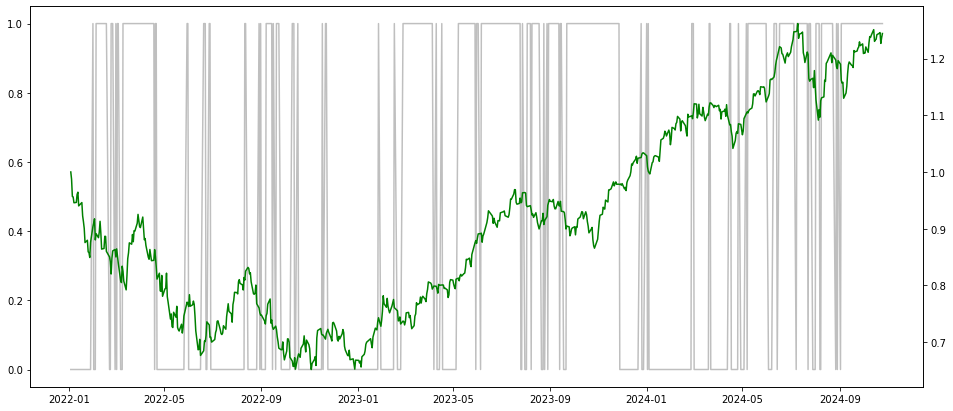

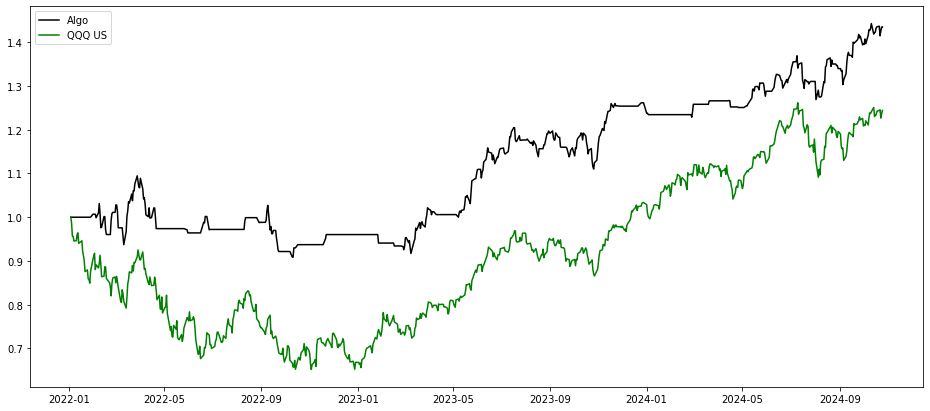

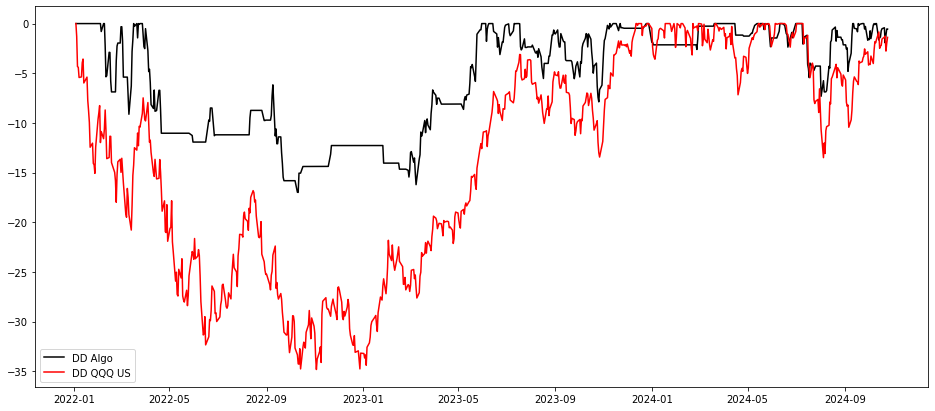

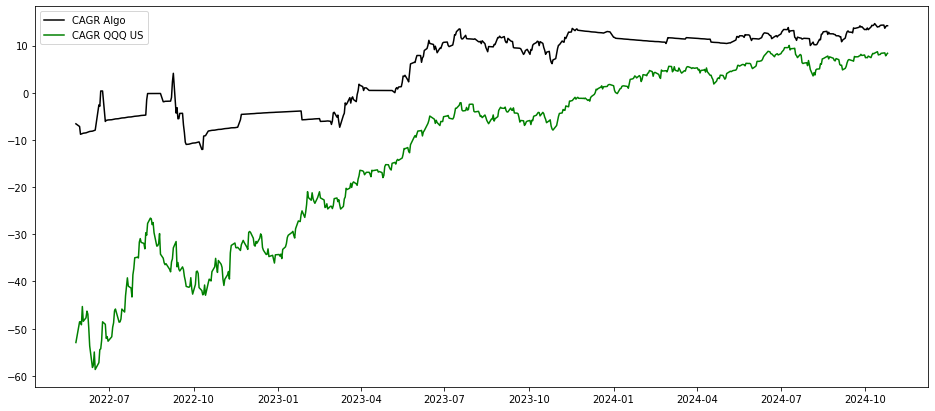

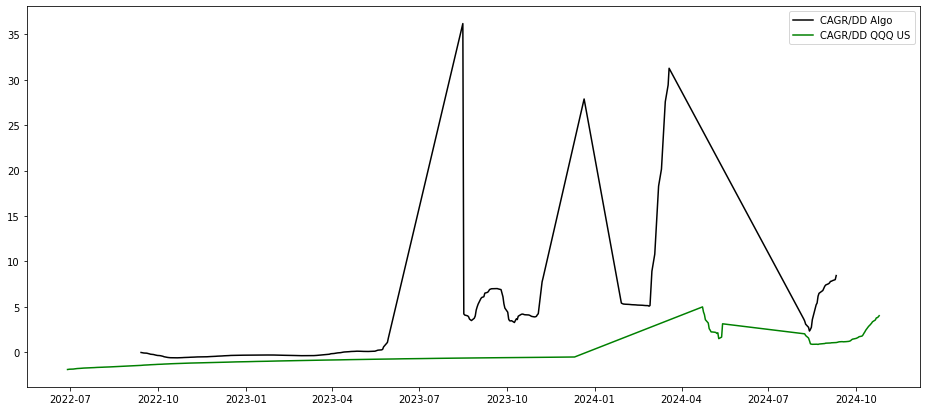

In [118]:
#SIMPLE BASELINE: SIMILARITY W/ PREVIOUS YEARS

import yfinance as yf
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings


def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def forecast(func):
    def get_forecasts(*args):

        idx_series, tracking_score, c_date = func(*args)
        forecasts_df = pd.DataFrame(np.nan, index = tracking_score.index, columns = np.array(perf_list).astype(str).tolist())
        for c_year in tracking_score.index:
            try:
                anchor_date = datetime(c_year, c_date.month, c_date.day).date()
            except:
                anchor_date = datetime(c_year, c_date.month, c_date.day - 1).date()
            anchor_date = idx_series[idx_series.index <= anchor_date].index[-1]
            for perf_w in perf_list:
                forecasts_df.loc[c_year, str(perf_w)] = round(100 * (idx_series.shift(-perf_w).loc[anchor_date] / idx_series.loc[anchor_date] - 1), 2)
        tracking_score /= tracking_score.max()
        final_forecasts = pd.DataFrame((forecasts_df.T.values * tracking_score.values).T,
                                       columns = np.array(perf_list).astype(str).tolist()).mean()
        
        return final_forecasts, forecasts_df
    return get_forecasts

@forecast
def track_patterns(*args):
    
    idx_series = args[0]
    c_date = args[1]
    
    idx_series = idx_series[idx_series.index <= c_date]
    years_list = pd.unique(idx_series.index.map(lambda x: x.year))[1: -1].tolist()
    corr_pattern_df = pd.DataFrame(np.nan, index = years_list, columns = np.array(window_list).astype(str).tolist())
    abse_pattern_df = pd.DataFrame(np.nan, index = years_list, columns = np.array(window_list).astype(str).tolist())
    for c_year in years_list:
        try:
            anchor_date = datetime(c_year, c_date.month, c_date.day).date()
        except:
            anchor_date = datetime(c_year, c_date.month, c_date.day - 1).date()
        anchor_date = idx_series[idx_series.index <= anchor_date].index[-1]
        for c_window in window_list:
            b_series = idx_series[idx_series.index <= anchor_date]
            len_bseries = len(b_series.index)
            c_series = idx_series[-min(len_bseries, c_window + corr_window):]
            b_series = b_series[-min(len_bseries, c_window + corr_window):]
            new_index = np.arange(c_series.shape[0])
            c_series.index, b_series.index = (new_index, new_index)            
            median_corr = c_series.rolling(corr_window).corr(b_series.rolling(corr_window)).dropna().median()
            abse = abs(c_series / c_series.iloc[0] - b_series / b_series.iloc[0]).sum()
            corr_pattern_df.loc[c_year, str(c_window)] = round(100 * median_corr, 2)
            abse_pattern_df.loc[c_year, str(c_window)] = round(abse, 2)
    final_score = (corr_pattern_df.mean(axis = 1) - mix_corr_factor * abse_pattern_df.mean(axis = 1)).sort_values(ascending = False)[:3]
    
    return idx_series, final_score, c_date

dbase = "visiblealpha_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = pd.DataFrame(tables_list, columns=['Old'])['Old'].values.tolist()

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))
  
today = datetime.today().date()
index_list = ['SPX', 'QQQ US']
action_dict = {1: 'LONG', -1: 'SHORT', 0: 'FLAT'}

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df = Prices_df.sort_index()

## HYPER-PARAMETERS
window_list = [42, 84]
perf_list = [30, 35, 40]
corr_window = 21
threshold_buy = 2.50
threshold_unbuy = 1.25
threshold_sell = -15.00
threshold_unsell = -10.00
mix_corr_factor = 1 / 2000
##

current_idx = input('Enter security (Algo): ').upper()
oride = ''

if (current_idx in Prices_df.columns):

    curr_series = Prices_df[current_idx].drop_duplicates(keep = 'last')
    if (today not in curr_series.index):
        new_list = []
        new_list.append(current_idx.split(' ')[0])
        current_px = yf.download(new_list, period = '1d')['Adj Close'].iloc[0] 
        if (oride != ''):
            current_px = oride
        curr_series.loc[today] = current_px
        curr_series = curr_series.sort_index()

    Start_Date = input("Enter Start Date: (YY/MM/DD, empty for 22/01/01)")
    if (Start_Date != ''):
        Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()
    else:
        Start_Date = datetime(2022, 1, 1).date()

    End_Date = input("Enter End Date: (YY/MM/DD, empty for Last Px saved)")
    if (End_Date != ''):
        End_Date = datetime.strptime(End_Date, "%y/%m/%d").date()
    else:
        End_Date = today

    date_list = curr_series[curr_series.index >= Start_Date][curr_series[curr_series.index >= Start_Date].index <= End_Date].index.values.tolist()
    position_df = pd.DataFrame(np.nan, index = date_list, columns = [current_idx, 'Y1', 'Y2', 'Y3'])
    for idx, c_date in enumerate(date_list):
        print(str(round(100 * (idx + 1) / len(date_list), 2)) + '%....', end = '\r')

        prev = 0        
        forecasts, details = track_patterns(curr_series, c_date)
        position_df.loc[c_date, ['Y1', 'Y2', 'Y3']] = details.index
        if (idx > 0):
            prev = position_df.iloc[idx - 1][current_idx]
        if (prev == 0):
            if (len(forecasts[forecasts > threshold_buy].index) >= 2):
                position_df.loc[c_date, current_idx] = 1
            elif (len(forecasts[forecasts < threshold_sell].index) == 3):
                position_df.loc[c_date, current_idx] = -1
            else:
                position_df.loc[c_date, current_idx] = 0
        elif (prev == 1):
            if (len(forecasts[forecasts < threshold_unbuy].index) > 0):
                position_df.loc[c_date, current_idx] = 0
            else:
                position_df.loc[c_date, current_idx] = 1
        elif (prev == -1):
            if (len(forecasts[forecasts > threshold_unsell].index) > 0):
                position_df.loc[c_date, current_idx] = 0
            else:
                position_df.loc[c_date, current_idx] = -1 

    position_df = position_df.astype(int)
    daily_factors = (1 + position_df[current_idx] * curr_series.shift(-1).pct_change().loc[position_df.index])
    cumulative_f = daily_factors.expanding().apply(np.prod)
    tot_perf = round(100 * (cumulative_f.iloc[-1] - 1), 2)

    norm_series = curr_series.loc[position_df[current_idx].index] / curr_series.loc[position_df[current_idx].index].iloc[0]
    bench_perf = round(100 * (norm_series.iloc[-1] - 1), 2)

    dd_algo = round(100 * (cumulative_f / cumulative_f.rolling(252 * 3, min_periods = 1).max() - 1), 2)
    dd_idx = round(100 * (norm_series / norm_series.rolling(252 * 3, min_periods = 1).max() - 1), 2)

    cagr_algo = round(100 * (cumulative_f ** (260 / (np.arange(len(cumulative_f.index)) + 1)) - 1), 2)
    cagr_idx = round(100 * (norm_series ** (260 / (np.arange(len(norm_series.index)) + 1)) - 1), 2)

    cagrdd_algo = cagr_algo / abs(dd_algo)
    cagrdd_idx = cagr_idx / abs(dd_idx)

    print('')
    print('Similarity Score:')
    print(position_df['Y1'].value_counts())
    print('')
    print('TOTAL PERFORMANCE: ' + str(tot_perf) + '%')
    print('BENCH PERFORMANCE: ' + str(bench_perf) + '%')
    print('LONG TIME RATIO: ' + str(round(100 * (position_df[current_idx].sum() / position_df.shape[0]), 2)) + '%')
    print('AVG CAGR/DD, ALGO: ' + str(round(cagr_algo.mean() / abs(dd_algo.mean()), 2)))
    print('AVG CAGR/DD, IDX: ' + str(round(cagr_idx.mean() / abs(dd_idx.mean()), 2)))
    print('')

    plt.figure(0, figsize = (16, 7))
    position_df[current_idx].plot(c = 'k', alpha = 0.25).twinx()
    (curr_series.loc[position_df[current_idx].index] / curr_series.loc[position_df[current_idx].index].iloc[0]).plot(c = 'g')

    plt.figure(1, figsize = (16, 7))
    cumulative_f.plot(c = 'k', label = 'Algo')
    norm_series.plot(c = 'g', label = current_idx).legend(loc = 'best')

    plt.figure(2, figsize = (16, 7))
    dd_algo.plot(c = 'k', label = 'DD Algo')
    dd_idx.plot(c = 'r', label = 'DD ' + current_idx).legend(loc = 'best')

    plt.figure(3, figsize = (16, 7))
    cagr_algo[100:].plot(c = 'k', label = 'CAGR Algo')
    cagr_idx[100:].plot(c = 'g', label = 'CAGR ' + current_idx).legend(loc = 'best')

    plt.figure(4, figsize = (16, 7))
    cagrdd_algo.rolling(21).mean().dropna()[100:].plot(c = 'k', label = 'CAGR/DD Algo')
    cagrdd_idx.rolling(21).mean().dropna()[100:].plot(c = 'g', label = 'CAGR/DD ' + current_idx).legend(loc = 'best')
    
    print('')
    print('YEARLY FIGURES')
    print('')
    
    index_series = curr_series.loc[position_df[current_idx].index] / curr_series.loc[position_df[current_idx].index].iloc[0]
    index_name = current_idx.split(' ')[0]
    index_series.name = index_name

    algo_idx = current_idx.split(' ')[0] + ' Similarity'
    summary_df = pd.DataFrame(cumulative_f.values, index = cumulative_f.index, columns = [algo_idx])
    summary_df = summary_df.join(index_series)
    summary_df[algo_idx + ' Vol'] = round(100 * (summary_df[algo_idx].ewm(halflife = 10).std() * np.sqrt(260) / summary_df[algo_idx].rolling(260, min_periods = 1).mean()).replace({0: np.nan}).fillna(method = 'bfill'), 2)
    summary_df[index_name + ' Vol'] = round(100 * (summary_df[index_name].ewm(halflife = 10).std() * np.sqrt(260) / summary_df[index_name].rolling(260, min_periods = 1).mean()).replace({0: np.nan}).fillna(method = 'bfill'), 2)
    summary_df[algo_idx + ' DD'] = round(100 * (summary_df[algo_idx] / summary_df[algo_idx].rolling(260, min_periods = 1).max() - 1), 2)
    summary_df[index_name + ' DD'] = round(100 * (summary_df[index_name] / summary_df[index_name].rolling(260, min_periods = 1).max() - 1), 2)
    summary_df[algo_idx + ' CAGR'] = round(100 * (summary_df[algo_idx] / summary_df[algo_idx].iloc[0] - 1) * (260 / (np.arange(summary_df.shape[0]) + 1)), 2)
    summary_df[index_name + ' CAGR'] = round(100 * (summary_df[index_name] / summary_df[index_name].iloc[0] - 1) * (260 / (np.arange(summary_df.shape[0]) + 1)), 2)

    print('')
    print('Yearly Performances:')
    summary_Y_perf = round(100 * ((summary_df[[algo_idx, index_name]] / summary_df[[algo_idx, index_name]].shift(260)).dropna() - 1), 2)
    summary_Y_perf.index = summary_Y_perf.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    summary_Y_perf = summary_Y_perf.resample('Y').last()
    print(summary_Y_perf.dropna())

    print('')
    print('Yearly Drawdowns')
    summary_Y_DD = summary_df[summary_df.columns[summary_df.columns.map(lambda x: x.find('DD')) != -1]]
    summary_Y_DD.index = summary_Y_DD.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    summary_Y_DD = round(summary_Y_DD.resample('Y').min(), 2)
    print(summary_Y_DD.dropna())

    print('')
    print('Perf/DD Ratio:')
    summary_Y_DD.columns = summary_Y_perf.columns
    summary_Y_YPerfDD = round(summary_Y_perf / abs(summary_Y_DD), 2)
    print(summary_Y_YPerfDD.dropna())

    print('')
    print('Yearly Avg Vols')
    summary_Y_vol = summary_df[summary_df.columns[summary_df.columns.map(lambda x: x.find('Vol')) != -1]]
    summary_Y_vol.index = summary_Y_vol.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    summary_Y_vol = round(summary_Y_vol.resample('Y').median(), 2)
    print(summary_Y_vol.dropna())

    print('')
    print('Yearly Sharpe Ratios')
    summary_Y_vol.columns = summary_Y_perf.columns
    summary_Y_Sharpe = round(summary_Y_perf / summary_Y_vol, 2)
    print(summary_Y_Sharpe.dropna())
    print('')

    print(position_df[-15:])
    print('')
    print('POSITION: ' + action_dict[position_df[current_idx].iloc[-1]] + '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

Enter asset (ALGO - empty for QQQ): 
Enter start date (empty for start of CY or YY/MM/DD): 


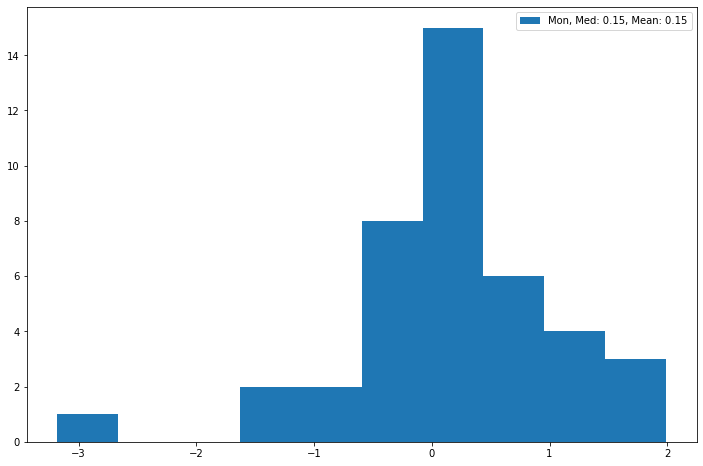

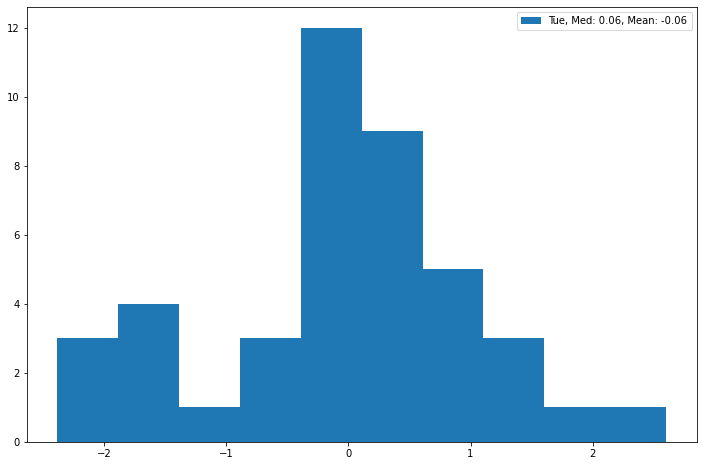

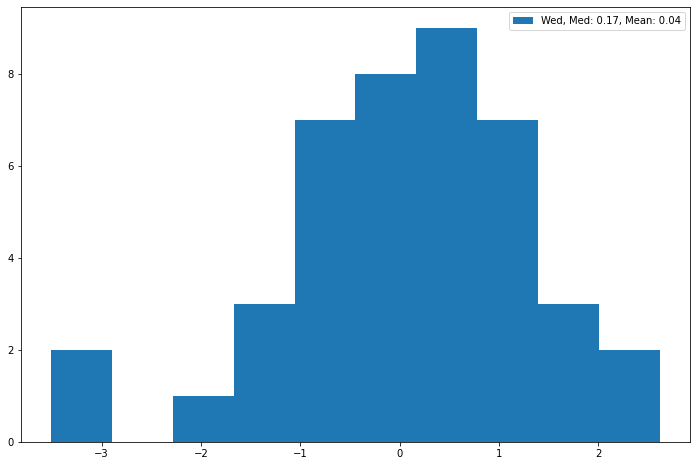

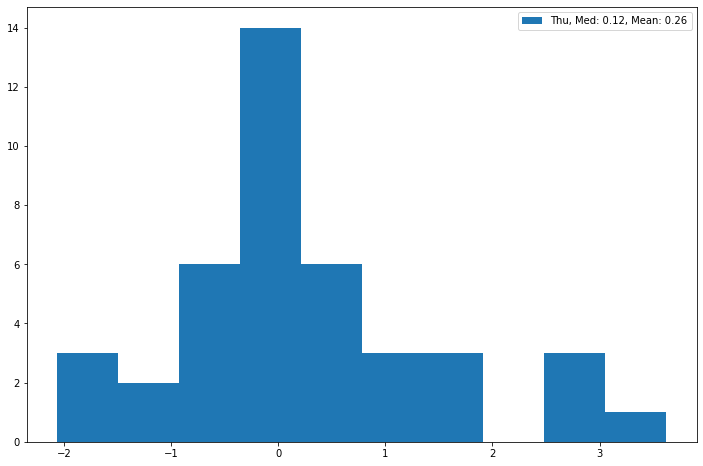

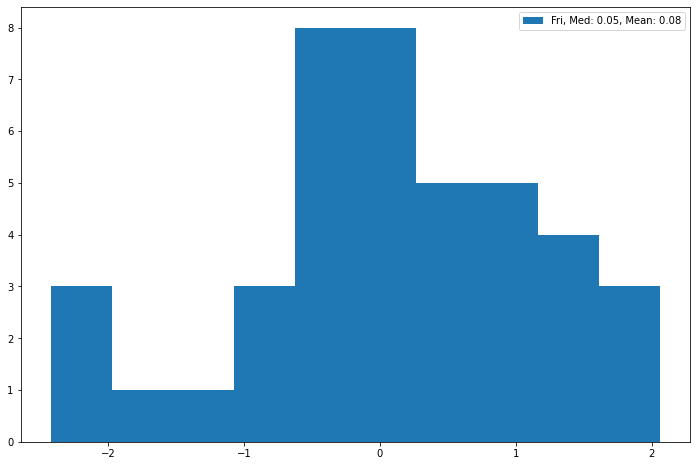

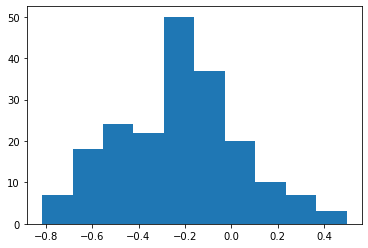

In [345]:
# extracts intra-week patterns

wd_dikt = {'0': 'Mon', '1': 'Tue', '2': 'Wed', '3': 'Thu', '4': 'Fri'}
px_df = open_df('prices_relation')
asset = 'QQQ US'
select_asset = input('Enter asset (ALGO - empty for QQQ): ').upper()
if (select_asset in px_df.columns):
    asset = select_asset
start = datetime(today.year, 1, 1).date()
select_date = input('Enter start date (empty for start of CY or YY/MM/DD): ')
try:
    start = datetime.strptime(select_date, '%y/%m/%d').date()
except:
    pass
returns_s = px_df[asset].pct_change()
returns_s = returns_s[returns_s.index >= start]
valid_dates = returns_s.index[returns_s.index.map(lambda x: x.strftime('%m%d')).map(lambda x:x.find('0101')) == -1]
returns_s = returns_s.loc[valid_dates]
WDreturns_s = round(100 * returns_s, 2)
WDreturns_s.index = WDreturns_s.index.map(lambda x: x.weekday())
for current_wd in np.arange(5):
    WDR_slice_s = WDreturns_s.loc[current_wd]
    WDR_slice_s.hist(bins = 10, figsize = (12, 8), label = wd_dikt[str(current_wd)] + ', Med: ' + 
                     str(round(WDR_slice_s.median(), 2)) + ', Mean: ' + str(round(WDR_slice_s.mean(), 2))).legend(loc = 'best')
    plt.grid(False)
    plt.show()
    
returns_s.loc[returns_s.shift(1).dropna().index].rolling(5).corr(returns_s.shift(1).dropna().rolling(5)).dropna().rolling(5).mean().dropna().hist()    
plt.grid(False)
plt.show()

Enter Ticker: FANG
Enter Days: 25
Enter Pol Degree (empty for 10): 12


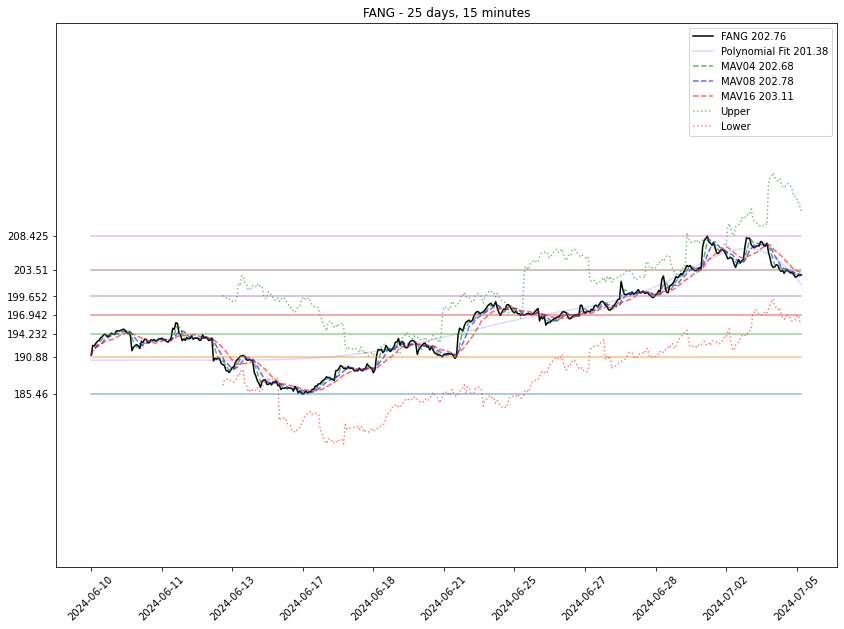

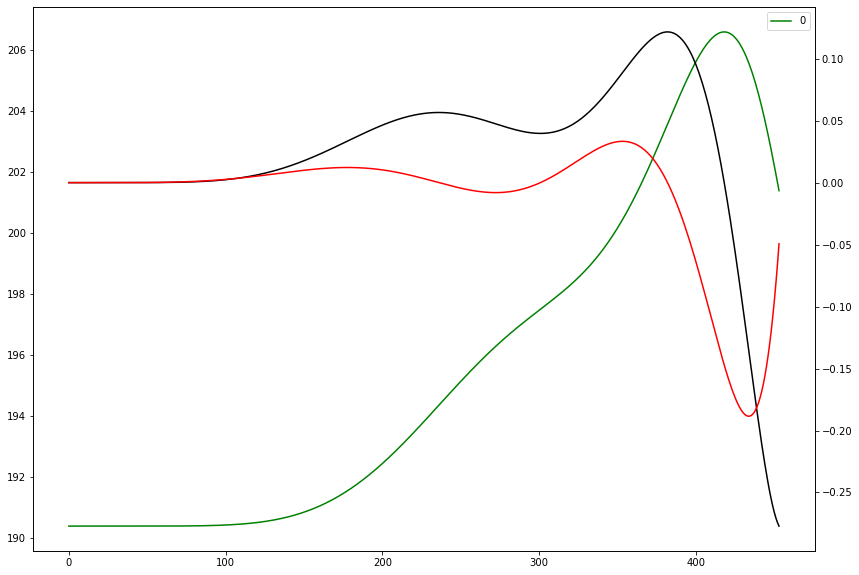

In [5]:
#INTRADAY STOCK GRAPHS

import pandas as pd
import os
import csv
import yfinance as yf
import tkinter as tk
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def on_selection(value):
    global choice_lag
    choice_lag = value  # store the user's choice
    root.destroy()  # close window
     
today = date.today()
window = 42
band_m = 2

fibonacci_seq = [0.00, 23.60, 38.20, 50.00, 61.80, 78.60, 100.00]
fibonacci_list = []
fig1 = plt.figure(figsize = (14, 10))
ax1 = fig1.add_subplot(1, 1, 1)

choice_ticker = input('Enter Ticker: ')
choice_ticker = choice_ticker.split(' ')[0]
day_lag = int(input('Enter Days: '))  
start_date = today - timedelta(day_lag)

choice_list = ['5', '15', '30', '45', '60']
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a lag (minutes)").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

ticker_data = yf.Ticker(choice_ticker)
ticker_data_df = ticker_data.history(start = start_date - timedelta(days = 1), end = today + timedelta(days = 1), interval = choice_lag + "m")
ticker_df = pd.DataFrame(ticker_data_df['Close'].values, index = np.arange(len(ticker_data_df.index)), columns = [choice_ticker])
PLOTticker_df = pd.DataFrame(ticker_data_df['Close'].values, index = ticker_data_df.index, columns = [choice_ticker])


p_degree = input('Enter Pol Degree (empty for 10): ')
if (p_degree != ''):
    p_degree = int(p_degree)
else:
    p_degree = 10
first_deriv = 1
second_deriv = 2
lin_reg = LinearRegression()
x_Values = ticker_df.index.values.reshape(-1, 1)
y_Values = np.array(ticker_df)
poly_features = PolynomialFeatures(degree = p_degree, include_bias = False)
poly_X = poly_features.fit_transform(x_Values)
LR_Fit = lin_reg.fit(poly_X, y_Values)
Predictions_df = pd.DataFrame(LR_Fit.predict(poly_X), index = ticker_df.index, columns = ['Forecast'])

upper_b = ((1 + band_m * ticker_df.pct_change().rolling(window).std() * np.sqrt(window)).shift(window) * ticker_df.shift(window)).dropna()
lower_b = ((1 - band_m * ticker_df.pct_change().rolling(window).std() * np.sqrt(window)).shift(window) * ticker_df.shift(window)).dropna()

mav04 = ticker_df.rolling(4, min_periods = 1).mean()
mav08 = ticker_df.rolling(8, min_periods = 1).mean()
mav16 = ticker_df.rolling(16, min_periods = 1).mean()
    
ax1.plot(ticker_df, c = 'k', label = choice_ticker + ' ' + str(round(ticker_df.iloc[-1][choice_ticker], 2)))
ax1.plot(Predictions_df, c = 'b', alpha = 0.15, label = 'Polynomial Fit ' + str(round(Predictions_df.iloc[-1][0], 2)))
ax1.plot(mav04, c = 'g', alpha = 0.6, linestyle = 'dashed', label = 'MAV04' + ' ' + str(round(mav04.iloc[-1][choice_ticker], 2)))
ax1.plot(mav08, c = 'b', alpha = 0.6, linestyle = 'dashed', label = 'MAV08' + ' ' + str(round(mav08.iloc[-1][choice_ticker], 2)))
ax1.plot(mav16, c = 'r', alpha = 0.6, linestyle = 'dashed', label = 'MAV16' + ' ' + str(round(mav16.iloc[-1][choice_ticker], 2)))
if (day_lag > 60):
    mav50 = ticker_df[::(ticker_df.shape[0] // day_lag) + 1].rolling(50, min_periods = 1).mean()
    ax1.plot(mav50, c = 'k', alpha = 0.6, linestyle = 'dashed', label = 'MAV50' + ' ' + str(round(mav50.iloc[-1][choice_ticker], 2)))

ax1.plot(upper_b, c = 'g', linestyle = 'dotted', alpha = 0.5, label = 'Upper')
ax1.plot(lower_b, c = 'r', linestyle = 'dotted', alpha = 0.5, label = 'Lower')

local_max = ticker_df[choice_ticker].max()
local_min = ticker_df[choice_ticker].min()
hl_gap = (local_max - local_min)
for f_level in fibonacci_seq:
    f_array = local_min + np.ones(len(ticker_df.index)) * (f_level / 100) * hl_gap
    f_series = pd.Series(f_array, index = ticker_df.index)
    fibonacci_list.append(round(f_series.iloc[0], 3))
    ax1.plot(f_series, alpha = 0.5)



poly_features_1d = PolynomialFeatures(degree = (p_degree - first_deriv), include_bias = False)
poly_dX = poly_features_1d.fit_transform(x_Values)
n, m = poly_dX.shape
x0 = np.ones((n, 1))
poly_dX_base = np.c_[x0, poly_dX]
poly_deriv = np.array(list(np.poly1d(np.array(list(LR_Fit.coef_[0][::-1]) + [1])).deriv())[::-1])

poly_features_2d = PolynomialFeatures(degree = (p_degree - second_deriv), include_bias = False)
poly_2dX = poly_features_2d.fit_transform(x_Values)
n2, m2 = poly_2dX.shape
x0_2 = np.ones((n2, 1))
poly_2dX_base = np.c_[x0_2, poly_2dX]
poly_2deriv = np.array(list(np.poly1d(np.array(list(poly_deriv)[::-1])).deriv())[::-1])


pd.DataFrame(poly_X.dot(LR_Fit.coef_[0]) + LR_Fit.intercept_).plot(figsize = (14, 10), c = 'g').twinx()
plt.plot(poly_dX_base.dot(poly_deriv), c = 'k')
plt.plot(20 * poly_2dX_base.dot(poly_2deriv), c = 'r')


deriv01_df = pd.DataFrame(poly_dX_base.dot(poly_deriv), columns = ['Deriv 01'])
deriv02_df = pd.DataFrame(poly_2dX_base.dot(poly_2deriv), columns = ['Deriv 02'])

d01_df = deriv01_df.copy()
d01_df['Abs'] = abs(d01_df['Deriv 01'])
d01_df['Original Index'] = d01_df.index

prev = 0
Deriv0_pts_df = pd.DataFrame(np.nan, index = [0], columns = ['Local'])
for idx in d01_df.index[1:]:
    if (d01_df.iloc[idx]['Deriv 01'] > 0) & (d01_df.iloc[prev]['Deriv 01'] < 0):
        Deriv0_pts_df.loc[idx] = 'Min'
    if (d01_df.iloc[idx]['Deriv 01'] < 0) & (d01_df.iloc[prev]['Deriv 01'] > 0):
        Deriv0_pts_df.loc[idx] = 'Max'
    prev = idx
Deriv0_pts_df.drop([0], inplace = True)

if (len(Deriv0_pts_df.index) > 1):
    p = Deriv0_pts_df.index[0]
    lows_list = []
    highs_list = []
    sign = 1
    if (Deriv0_pts_df.loc[p][0] == 'Max'):
        sign = -1
        lows_list.append((ticker_df.loc[:p][choice_ticker] * sign).max() * sign)
    else:
        highs_list.append((ticker_df.loc[:p][choice_ticker] * sign).max() * sign)
    p = 0
    for i in Deriv0_pts_df.index[:-1]:
        n = Deriv0_pts_df.index[Deriv0_pts_df.index.values.tolist().index(i) + 1]
        sign = 1
        if (Deriv0_pts_df.loc[i][0] == 'Min'):
            sign = -1
            lows_list.append((ticker_df.loc[p: n][choice_ticker] * sign).max() * sign)
        else:
            highs_list.append((ticker_df.loc[p: n][choice_ticker] * sign).max() * sign)
        p = i  
    sign = 1
    p = Deriv0_pts_df.index[-2]
    if (Deriv0_pts_df.iloc[-1][-1] == 'Max'):
        highs_list.append((ticker_df.loc[p:][choice_ticker] * sign).max() * sign)
    else:
        sign = -1
        lows_list.append((ticker_df.loc[p:][choice_ticker] * sign).max() * sign)
    lows_df = pd.DataFrame(lows_list, index = np.arange(len(lows_list)), columns = ['Levels'])
    highs_df = pd.DataFrame(highs_list, index = np.arange(len(highs_list)), columns = ['Levels'])
    lows_df['Positions'] = np.nan
    highs_df['Positions'] = np.nan
    for idx in lows_df.index:
        lows_df.loc[idx, 'Positions'] = ticker_df[ticker_df[choice_ticker] == lows_list[idx]].index[0]
    for idx in highs_df.index:
        highs_df.loc[idx, 'Positions'] = ticker_df[ticker_df[choice_ticker] == highs_list[idx]].index[0]    

    if (len(lows_df.index) > 1):  
        for j in np.arange(lows_df.shape[0] - 1):
            base_x = lows_df.loc[j, 'Positions']
            base_y = lows_df.loc[j, 'Levels']
            for i, curr in enumerate(lows_df.index[(j + 1):]):
                lx_values = np.array([base_x, lows_df.loc[curr, 'Positions']]).reshape(-1, 1)
                ly_values = np.array([base_y, lows_df.loc[curr, 'Levels']])
                Low_Fit = lin_reg.fit(lx_values, ly_values)
                lx_values = np.array([ticker_df.index[0], base_x, lows_df.loc[curr, 'Positions'], ticker_df.index[-1]]).reshape(-1, 1)
                Low_df = pd.DataFrame(Low_Fit.predict(lx_values), index = [ticker_df.index[0], base_x, lows_df.loc[curr, 'Positions'], ticker_df.index[-1]], columns = ['Low'])
                ax1.plot(Low_df, c = 'g', alpha = 0.35, label = 'Support ' + str(round(Low_df.iloc[-1][0], 3)))

    if (len(highs_df.index) > 1):  
        for j in np.arange(highs_df.shape[0] - 1):
            base_x = highs_df.loc[j, 'Positions']
            base_y = highs_df.loc[j, 'Levels']
            for i, curr in enumerate(highs_df.index[(j + 1):]):
                lx_values = np.array([base_x, highs_df.loc[curr, 'Positions']]).reshape(-1, 1)
                ly_values = np.array([base_y, highs_df.loc[curr, 'Levels']])
                High_Fit = lin_reg.fit(lx_values, ly_values)
                lx_values = np.array([ticker_df.index[0], base_x, highs_df.loc[curr, 'Positions'], ticker_df.index[-1]]).reshape(-1, 1)
                High_df = pd.DataFrame(High_Fit.predict(lx_values), index = [ticker_df.index[0], base_x, highs_df.loc[curr, 'Positions'], ticker_df.index[-1]], columns = ['High'])
                ax1.plot(High_df, c = 'r', alpha = 0.35, label = 'Resistance ' + str(round(High_df.iloc[-1][0], 3)))                

ax1.set_xticks(ticker_df.index[:: int(np.floor(ticker_df.shape[0] / 10))])
ax1.set_xticklabels(PLOTticker_df.index.map(lambda x: x.date())[:: int(np.floor(PLOTticker_df.shape[0] / 10))], rotation = 45)
ax1.set_yticks(fibonacci_list)
ax1.set_yticklabels(fibonacci_list)
ax1.set_ylim([lower_b.min()[0] * 0.9, upper_b.max()[0] * 1.1])

ax1.set_title(choice_ticker + ' - ' + str(day_lag) + ' days, ' + str(choice_lag) + ' minutes')
ax1.legend(loc = 'best')

In [1]:
# STOCK FACTORS MINING

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import warnings

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df 

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def offset(ticker, ed_df, sales_dt, record_date, div_i):

    y_l = ed_df[ticker].shift(1)[ed_df[ticker].shift(1).fillna('') != ''].index.map(lambda x: int(x.split('-')[1])).tolist()
    m_l = ed_df[ticker].shift(1)[ed_df[ticker].shift(1).fillna('') != ''].map(lambda x: int(x[:2])).tolist()
    d_l = ed_df[ticker].shift(1)[ed_df[ticker].shift(1).fillna('') != ''].map(lambda x: int(x[2:])).tolist()
    date_l = []
    for idx in np.arange(len(y_l)):
        try:
            c_dt = datetime(y_l[idx], m_l[idx], d_l[idx]).date()
        except:
            c_dt = datetime(y_l[idx], m_l[idx], d_l[idx] - 1).date()
        if (c_dt < record_date) & (c_dt > sales_dt):
            date_l.append(c_dt)

    offs = len(date_l) // div_i

    return offs

def pct_calc_add(base_df, tenors_a, fcastf_a):
    
    comp1_s = pd.Series(base_df[-4: ].values + fcastf_a[: 4], index = tenors_a[: 4].values)
    comp2_s = pd.Series(comp1_s.values + fcastf_a[4: 8], index = tenors_a[4: 8].values)
    comp3_s = pd.Series(comp2_s.values + fcastf_a[8: 12], index = tenors_a[8: 12].values)
    ext_Skpi1_s = pd.concat([base_df, comp1_s, comp2_s, comp3_s]).dropna()
    KPI_q4Ret_s = (100 * ((ext_Skpi1_s / ext_Skpi1_s.shift(4)).dropna() - 1)) 
    
    return ext_Skpi1_s, KPI_q4Ret_s

def pct_calc_mult(base_df, tenors_a, fcastf_a):
    
    comp1_s = pd.Series(base_df[-4: ].values * (1 + fcastf_a[: 4] / 100), index = tenors_a[: 4].values)
    comp2_s = pd.Series(comp1_s.values * (1 + fcastf_a[4: 8] / 100), index = tenors_a[4: 8].values)
    comp3_s = pd.Series(comp2_s.values * (1 + fcastf_a[8: 12] / 100), index = tenors_a[8: 12].values)
    ext_Skpi1_s = pd.concat([base_df, comp1_s, comp2_s, comp3_s]).dropna()
    KPI_q4Ret_s = (100 * ((ext_Skpi1_s / ext_Skpi1_s.shift(4)).dropna() - 1))    
    
    return ext_Skpi1_s, KPI_q4Ret_s

def calc_sales(Skpi1_s, wasd_s, last_px, l, c_calc, ticker):
    
    val_s = np.nan 
    val_f = np.nan
    cagr3y = np.nan
    r2_p = np.nan
    vol = np.nan
    if (c_calc == 'sales'):
        Skpi1_s = Skpi1_s.clip(0, np.inf).replace({0: np.nan})    
    wasd_spot = wasd_s.loc['Q0']
    att_b = False
    try:
        wasd_12f = wasd_s.loc['Q12']        
    except:
        wasd_12f = wasd_s.iloc[-1]    
    try:
        kpi_q4d_s = ((Skpi1_s - Skpi1_s.shift(4)).dropna())
        ar_kpi_q4d_s = kpi_q4d_s.copy()
        comp_s = pd.Series(np.arange(12) + 1).map(lambda x: 'Q' + str(x))
        y0_a = kpi_q4d_s[-4:].values
        y1_a = kpi_q4d_s[-8:].values
        y2_a = kpi_q4d_s[-12:].values
        y3_a = kpi_q4d_s[-16:].values
        x0_a = np.arange(y0_a.shape[0]) + 1
        x1_a = np.arange(y1_a.shape[0]) + 1
        x2_a = np.arange(y2_a.shape[0]) + 1
        x3_a = np.arange(y3_a.shape[0]) + 1
        m0 = LinearRegression().fit(x0_a.reshape(-1, 1), y0_a)
        m1 = LinearRegression().fit(x1_a.reshape(-1, 1), y1_a)
        m2 = LinearRegression().fit(x2_a.reshape(-1, 1), y2_a)
        m3 = LinearRegression().fit(x3_a.reshape(-1, 1), y3_a)
        fcast0_a = m0.predict((np.arange(comp_s.shape[0]) + x0_a.shape[0] + 1).reshape(-1, 1))
        fcast1_a = m1.predict((np.arange(comp_s.shape[0]) + x1_a.shape[0] + 1).reshape(-1, 1))
        fcast2_a = m1.predict((np.arange(comp_s.shape[0]) + x2_a.shape[0] + 1).reshape(-1, 1))
        fcast3_a = m1.predict((np.arange(comp_s.shape[0]) + x3_a.shape[0] + 1).reshape(-1, 1))
        r2_0 = max(.1, m0.score(x1_a.reshape(-1, 1), y1_a))
        r2_1 = m1.score(x1_a.reshape(-1, 1), y1_a)
        r2_2 = m2.score(x2_a.reshape(-1, 1), y2_a)
        r2_3 = m3.score(x3_a.reshape(-1, 1), y3_a)
        r2_t = r2_0 + r2_1 + r2_2 + r2_3                

        fcastT_a = (m0.predict(x3_a.reshape(-1, 1)) * r2_0 + m1.predict(x3_a.reshape(-1, 1)) * r2_1 + m2.predict(x3_a.reshape(-1, 1)) * r2_2 + m3.predict(x3_a.reshape(-1, 1)) * r2_3) / r2_t
        r2_T = r2_score(fcastT_a + (np.mean(y3_a) - np.mean(fcastT_a)), y3_a)
        r2_p = round(r2_T, 3)
        try:
            for idx in np.arange(ARIMA_FORECASTS):
                ar_kpi_q4d_s.index = pd.Series(np.arange(ar_kpi_q4d_s.shape[0])).map(lambda x: today - timedelta(x)).sort_values().tolist()
                ARIMA_model = ARIMA(ar_kpi_q4d_s, order = (3, 0, 4), freq = 'D')
                ARIMA_model_fit = ARIMA_model.fit()        
                next_forecast = ARIMA_model_fit.forecast(freq = 'D')
                ar_kpi_q4d_s.loc[next_forecast.index[0].date()] = next_forecast.values[0]

            ar_kpi_q4d_s.index = kpi_q4d_s.index.tolist() + pd.Series(np.arange(ARIMA_FORECASTS) + 1).map(lambda x: 'Q' + str(x)).tolist()

            poly_features = PolynomialFeatures(degree = 2, include_bias = False)
            r2_best = -np.inf
            keep_fit = True
            p = 0
            while (keep_fit):
                arima_m = ar_l[p]
                p += 1
                if (p >= len(ar_l)):
                    keep_fit = False
                if (keep_fit):
                    fcastf_a = (ar_kpi_q4d_s['Q1':].values * arima_m + fcast0_a * r2_0 + fcast1_a * r2_1 + fcast2_a * r2_2 + 
                                fcast3_a * r2_3) / (arima_m + r2_t)
                    Cext_Skpi1_s, CKPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, fcastf_a)
                    poly_x = poly_features.fit_transform((np.arange(Cext_Skpi1_s.shape[0]) + 1).reshape(-1, 1))
                    poly_m = LinearRegression().fit(poly_x, Cext_Skpi1_s.values)
                    fit2 = poly_m.predict(poly_x)
                    fit2_s = pd.Series(fit2, index = Cext_Skpi1_s.index)
                    r2_f2 = round(poly_m.score(poly_x, Cext_Skpi1_s.values), 2)
                    if (r2_f2 > r2_best):                                                                                                                                                                
                        ext_Skpi1_s = Cext_Skpi1_s.copy()
                        KPI_q4Ret_s = CKPI_q4Ret_s.copy()
                        p_best = p
                        r2_best = r2_f2
                        if (KPI_q4Ret_s['Q0':].min() < arima_growth_floor):
                            att_b = True
                    if (att_b) & (KPI_q4Ret_s['Q0':].min() > arima_growth_floor):
                        ext_Skpi1_s = Cext_Skpi1_s.copy()
                        KPI_q4Ret_s = CKPI_q4Ret_s.copy()
                        p_best = p
                        r2_best = r2_f2
                        att_b = False
                        keep_fit = False
                    if ((r2_best > .9) & (r2_f2 < r2_best)) | (p == len(ar_l)):
                        keep_fit = False
                    if (l == 1):
                        print('r2 arima_w ' + str(arima_m) + ', ' + str(r2_f2))
                        Skpi1_s.dropna().plot()
                        Cext_Skpi1_s.plot(linestyle = 'dashed')
                        fit2_s.plot(c = 'r')
                        plt.show()
            if (l == 1):
                print('Best ARIMA weight, ' + c_calc + ': ' + str(p_best))
            cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                                   max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                                   ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                     abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)
            if (cagr3y < -50) | (str(cagr3y) == 'nan'):
                c = 'a' + 1                              
            r2_p = 1
        except:
            if (l == 1):
                print('ARIMA N/A for ' + ticker + ' ' + c_calc)
            fcastf_a = (fcast0_a * r2_0 + fcast1_a * r2_1 + fcast2_a * r2_2 + fcast3_a * r2_3) / (r2_t)
            ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, fcastf_a)
            if (c_calc != 'earnings'):
                prev_mean = np.quantile(KPI_q4Ret_s[: 'Q0'].values, 0.9)
                last_f = KPI_q4Ret_s.iloc[-1]
            else:
                prev_mean = np.quantile(ext_Skpi1_s[: 'Q0'].values, 0.975)
                last_f = ext_Skpi1_s.iloc[-1]                           
            if (last_f < 0) | (abs(last_f) > prev_mean) | (r2_T < r2_floor):
                if (l == 1):
                    print('Amending ' + ticker)
                if (c_calc in add_l):
                    AUXkpi_s = pd.Series(ext_Skpi1_s[: 'Q0'].values, index = np.arange(ext_Skpi1_s[: 'Q0'].shape[0]) + 1)
                else:
                    AUXkpi_s = pd.Series(KPI_q4Ret_s[: 'Q0'].values, index = np.arange(KPI_q4Ret_s[: 'Q0'].shape[0]) + 1)

                AUXkpi_s.loc[AUXkpi_s.index[-1] + 12] = (prev_mean + last_f) / 2
                x_a = AUXkpi_s.index.values
                y_a = AUXkpi_s.values
                missing_a = (np.arange(11) + AUXkpi_s.index[-2] + 1)
                search_p = True
                p = 1
                r2_p = -np.inf
                best_found = False
                while (search_p) & (p < 5):
                    valid = True
                    poly_features = PolynomialFeatures(degree = p, include_bias = False)
                    poly_x = poly_features.fit_transform(x_a.reshape(-1, 1))
                    poly_mx = poly_features.fit_transform(missing_a.reshape(-1, 1))
                    poly_m = LinearRegression().fit(poly_x, y_a)
                    missing_f = poly_m.predict(poly_mx)
                    missing_s = pd.Series(missing_f.tolist() + [y_a[-1]], index = comp_s.values)
                    r2_c = poly_m.score(poly_x, y_a)
                    if (l == 1):
                        print(str(p) + '- ' + str(r2_c))
                    if (c_calc in add_l):
                        ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, missing_s.values)        
                    else:
                        ext_Skpi1_s, KPI_q4Ret_s = pct_calc_mult(Skpi1_s, comp_s, missing_s.values)  
                    cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                                           max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                                               ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                                 abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)                                    
                    if (str(cagr3y) == 'nan') | (cagr3y < -50):
                        valid = False
                    if (r2_c > (r2_p + R2_MARGIN)) & (valid):
                        r2_p = max(0.01, round(r2_c, 2))                                          
                        missing_b = missing_s.copy()
                        if (p > 3):
                            search_p = False
                        best_found = True
                    p += 1
                if (not best_found):
                    missing_b = 0 * missing_s
                    r2_p = 0.1
                if (c_calc in add_l):
                    ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, missing_b.values)        
                else:
                    ext_Skpi1_s, KPI_q4Ret_s = pct_calc_mult(Skpi1_s, comp_s, missing_b.values) 
        cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                               max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                                   ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                     abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)                        
        if (l == 1):
            ext_Skpi1_s.plot(title = c_calc.upper() + ' ' + ticker)
            plt.show()                                                    
            KPI_q4Ret_s.plot(title = c_calc.upper() + ' YoY G ' + ticker)
            plt.show()                        
            print('Implied 3Y ' + c_calc + ' CAGR: ' + str(cagr3y))
        try:
            if (c_calc not in add_l):
                val_s = round((wasd_spot * last_px) / Skpi1_s['Q-3':].sum(), 1)
                val_f = round((wasd_12f * last_px) / ext_Skpi1_s[-4:].sum(), 1)
                y = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().values
                x = np.arange((Skpi1_s / abs(Skpi1_s.shift(4))).dropna().shape[0])
                kpi_lr = LinearRegression().fit(x.reshape(-1, 1), y)
                kpi_fit = kpi_lr.predict(x.reshape(-1, 1))
                kpi_fit_s = pd.Series(kpi_fit, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
                r2_f = kpi_lr.score(x.reshape(-1, 1), y)
                adj_kpi_s = pd.Series(y - kpi_fit * r2_f, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
                vol = round(adj_kpi_s.ewm(halflife = 4).std().iloc[-1] * 100, 2)            
            else:
                val_s = round(last_px / Skpi1_s['Q-3':].sum(), 1)
                val_f = round(last_px / ext_Skpi1_s[-4:].sum(), 1)
                y = (Skpi1_s - Skpi1_s.shift(4)).dropna().values
                x = np.arange((Skpi1_s / abs(Skpi1_s.shift(4))).dropna().shape[0])
                kpi_lr = LinearRegression().fit(x.reshape(-1, 1), y)
                kpi_fit = kpi_lr.predict(x.reshape(-1, 1))
                kpi_fit_s = pd.Series(kpi_fit, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
                r2_f = kpi_lr.score(x.reshape(-1, 1), y)
                adj_kpi_s = pd.Series(y - kpi_fit * r2_f, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
                vol = round(adj_kpi_s.ewm(halflife = 4).std().iloc[-1] / abs(Skpi1_s[-4:].mean()) * 100, 2)  
        except:
            print('Vol error for ' + ticker)
    except:
        print('ERROR FOR ' + c_calc + ', ' + ticker)    
    
    return val_s, val_f, cagr3y, r2_p, vol

def on_selection_sectors(value):
    global sector_option
    sector_option = value
    root.destroy() 

dbase = "visiblealpha_laptop"
conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

warnings.filterwarnings('ignore')
today = date.today()
ext = '_etf_mix'

stocks = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Tickers_VA.csv")
all_tickers_l = stocks['tickers'].tolist()
sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
sector_l = Sectors_df['ETF'].drop_duplicates().dropna().tolist() + Sectors_df['Custom Sector 1'].drop_duplicates().dropna().tolist() + ['ALL', 'ETF Algo']
Prices_df = open_df('prices_relation')
MktC_df = open_df('mkt_cap_relation')
sectorP_df = open_df('positions' + ext)
sectorChange_l = ((sectorP_df == sectorP_df.shift(1)).sum(axis = 1) < (sectorP_df.shape[1] - 0)).replace({False: np.nan}).dropna().index.tolist()
sectorChange_s = pd.Series(sectorChange_l)

all_fields_l = ['sP/S', 'sP/E', 'sP/GP', 'P/S', 'P/Ee', 'P/GP', 'P/Eo', 'OM-t0', 'OM', 'OMd', 'GS', 'GE', 'r2 S', 'r2 E', 
                'GGP', 'r2 GP', 'Size', 'ROI-P', 'ROI', 'ROId','ROE-P', 'ROE', 'ROEd', 'S Vol', 'E Vol', 'GP Vol', 'r&d']
add_l = ['earnings', 'op']
report_dikt = {'sales': '', 'earnings': ['_epsd', '_epsb'], 'op': '_oi', 'GP': '_gp', 'ROI': ['_totopexp', '_tcr']}
depFields_dikt = {'sales': ['sP/S', 'P/S', 'GS', 'r2 S', 'S Vol'], 'earnings': ['sP/E', 'P/Ee', 'GE', 'r2 E', 'E Vol'], 
                  'op': ['P/Eo', 'OM-t0', 'OM', 'OMd', 'ROE-P', 'ROE', 'ROEd'], 'GP': ['sP/GP', 'P/GP', 'GGP', 'r2 GP', 'GP Vol'], 
                  'ROI': ['ROI-P', 'ROI', 'ROId']}
add_back_l = ['SHOP CN', 'ASM NA', 'ASML NA']

yq_df = open_df('yq_all')
ed_df = open_df('ed_relation')
ed_df['AUX'] = ed_df.index
dum_l1 = []
dum_l2 = []
for dum in ed_df['AUX']:
    dum_s = dum.split('QCY-')
    ed_df.loc[dum, 'AUX'] = int(str(dum_s[1]) + str(dum_s[0]))
ed_df.sort_values(by = ['AUX'], inplace=True)
ed_df.drop('AUX', axis = 1, inplace=True)

sector_option = ''
ticker_str = input('Input ALGO ticker (empty for list): ').upper()
if (ticker_str != ''):
    ticker_l = [ticker_str]
else:   
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *sector_l, command = on_selection_sectors)
    tk.Label(root, text = "Choose Sector: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()    
    if (sector_option == 'ALL'):
        ticker_l = all_tickers_l.copy()
    elif (sector_option == 'ETF Algo'):
        ticker_l = Sectors_df[Sectors_df['ETF'].isna() == 0].index.tolist() 
    else:
        ticker_l = pd.concat([Sectors_df[Sectors_df['Custom Sector 1'] == sector_option], Sectors_df[Sectors_df['ETF'] == sector_option]]).index.tolist()  

override = False        
ovb = input('(O)veride valuation files (or empty)? ').upper()
if (ovb == 'O'):
    override = True


all_reb_l = [1, 15] 
dt_str = input('Enter Start Date (empty for last or YY/MM/DD): ')
try:
    st_date = datetime.strptime(dt_str, "%y/%m/%d").date()
except:
    st_date = Prices_df.index[-1]
end_date = st_date
if (len(ticker_l) > 1):
    dt_end = input('Enter End Date (empty for last, or YY/MM/DD): ')
    try:
        end_date = datetime.strptime(dt_end, "%y/%m/%d").date()
        end_date = max(end_date, st_date)
    except:
        end_date = Prices_df.index[-1]   
        

selection_scope = ''
reb_freq = 'R'
L = len(ticker_l) 
if (sector_option == 'ETF Algo'): 
    selection_scope = '_etf'      
elif (L > 1):
    keep_asking = True
    while (keep_asking):
        reb_freq = input('Enter rebalancing frequency (d)aily, (b)i-weekly or empty for Algo Reb dates: ').upper()
        if (reb_freq == ''):
            reb_freq = 'R'
        if (reb_freq == 'D') | (reb_freq == 'B') | (reb_freq == 'R'):
            keep_asking = False

spx_s = Prices_df[Prices_df.index >= st_date]['SPX']
qqq_s = Prices_df[Prices_df.index >= st_date]['QQQ US']
arkk_s = Prices_df[Prices_df.index >= st_date]['ARKK US']
spx_s /= spx_s.iloc[0]
qqq_s /= qqq_s.iloc[0]
arkk_s /= arkk_s.iloc[0]

ar_l = [1, 2, 3, 5, 10, 20, 40, 80, 160]
arima_growth_floor = -20
arima_deltaOM_cap = 30
r2_floor = .5
OM_cap = 75
ARIMA_FORECASTS = 12
R2_MARGIN = .1

period_end = st_date
period_st = st_date
keep_loop = True
count = 0
if (period_st.day >= all_reb_l[1]):
    count = 1 
while (period_end <= end_date) & (keep_loop):   
    gt_c = 0
    calc_fields = False
    if (L == 1) | (period_end >= end_date):
        keep_loop = False
    else:
        if (reb_freq == 'R'):
            period_st = sectorChange_s[sectorChange_s <= period_st].iloc[-1]
            if (period_end >= sectorChange_s.iloc[0]):
                try:
                    period_end = sectorChange_s[sectorChange_s > period_end].iloc[0]
                except:
                    period_end = sectorChange_s.iloc[-1]
            else:
                period_st = sectorChange_s.iloc[0]
                period_end = sectorChange_s.iloc[1]
        elif (reb_freq == 'D'):
            period_end = Prices_df[Prices_df.index > period_end].index[0]
        elif (reb_freq == 'B'):   
            count += 1
            n_day = all_reb_l[int(count % len(all_reb_l))]
            n_month = int((period_st.month + int((count + 1) % len(all_reb_l))) % 13)
            n_year = int(period_st.year + (period_st.month + int(count % len(all_reb_l))) // 13)
            period_end = datetime(n_year, n_month, n_day).date()
            period_end = Prices_df[Prices_df.index >= min(period_end, end_date)].index[0]              
    period_st = Prices_df[Prices_df.index >= period_st].index[0]
            
    if (override) | (L == 1):
        valuation_df = pd.DataFrame(np.nan, index = ticker_l, columns = all_fields_l)        
    else:
        search_dt = True
        d_cap = 10
        d_count = 0
        while (search_dt):
            try:
                valuation_df = open_df('valuation_' + period_st.strftime('%Y%m%d') + selection_scope)
                search_dt = False
            except:
                if (selection_scope == ''):
                    try:
                        valuation_df = open_df('valuation_' + period_st.strftime('%Y%m%d') + '_etf')
                        print('ETF relation found - ' + period_st.strftime('%Y%m%d'))
                        search_dt = False
                    except:
                        d_count += 1
                        period_st = period_st - timedelta(1)
                        period_st = period_st - timedelta((period_st.day % 4) * (period_st.day // 4))
                        if (d_count >= d_cap):
                            valuation_df = pd.DataFrame(np.nan, index = ticker_l, columns = all_fields_l)
                            search_dt = False
                else:
                    valuation_df = pd.DataFrame(np.nan, index = ticker_l, columns = all_fields_l)
                    search_dt = False                    
                
    add_back_l = [t for t in add_back_l if t in ticker_l]
    ticker_l = pd.Series(ticker_l)[pd.Series(ticker_l).map(lambda x: x.find(' US')) != -1].tolist()
    ticker_l = pd.unique(ticker_l + add_back_l).tolist()
    missing_tickers_l = [t for t in ticker_l if t not in valuation_df.index.tolist()]
    missing_tickers_l = pd.Series(missing_tickers_l)[pd.Series(missing_tickers_l).map(lambda x: x.find(' US')) != -1].tolist()    
    missing_fields_l = [f for f in all_fields_l if f not in valuation_df.T.dropna(how = 'all').T.columns.tolist()]
    valuation_df[missing_fields_l] = np.nan
    for idt, ticker in enumerate(ticker_l):
        print(ticker + ' ' + str(idt)  + ' out of ' + str(L) + ' (' + str(gt_c) + ' stocks, ' + period_st.strftime('%d-%b-%Y') + ')')
        
        if (ticker not in valuation_df.index):
            valuation_df.loc[ticker] = np.nan         
        record_date = yq_df.loc[ticker, 'Record Date']               
        sales_go = False
        ticker_rel = re.sub(r'[^a-z^0-9]', '', ticker.lower())
        try:
            sales_df = open_df(ticker_rel)
            sales_dt = sales_df[sales_df.index <= period_st].index[-1]
            if (sales_df['Q0'].dropna().shape[0] > 0):
                sales_go = True
        except:
            pass
        rd_go = False
        if (sales_go):   
            offs = offset(ticker, ed_df, sales_dt, record_date, 1)
            try:                
                rd_df = open_df(ticker_rel + '_rd')
                rd_dt = rd_df[rd_df.index <= period_st].index[-1]
                rd_ratio = round(100 * rd_df.loc[rd_dt].shift(offs)['Q0'] / sales_df.loc[sales_dt].shift(offs)['Q0'], 3)
            except:
                rd_ratio = 0  
            if (valuation_df.isna().loc[ticker, 'r&d'] == True):
                valuation_df.loc[ticker, 'r&d'] = rd_ratio
        
        calc = False         
        if (ticker in missing_tickers_l):
            calc = True
        else:
            if (valuation_df.loc[ticker].isna().sum() > 0):
                calc = True        
        earnings_go = False
        wasd_go = False
        gp_go = False
        op_go = False
        roi_go = True        
        mktC = MktC_df.loc[period_st, ticker]               
        
        try:   
            earns_df = open_df(ticker_rel + report_dikt['earnings'][0])
            earns_dt = earns_df[earns_df.index <= period_st].index[-1]
            if (earns_df['Q0'].dropna().shape[0] > 0):
                earnings_go = True            
        except:
            try:
                earns_df = open_df(ticker_rel + report_dikt['earnings'][1])
                earns_dt = earns_df[earns_df.index <= period_st].index[-1]
                if (earns_df['Q0'].dropna().shape[0] > 0):
                    earnings_go = True                  
            except:
                pass  
        try:
            wasd_df = open_df(ticker_rel + '_wasd')
            wasd_dt = wasd_df[wasd_df.index <= period_st].index[-1]
        except:
            try:
                wasd_df = open_df(ticker_rel + '_wasb')
                wasd_dt = wasd_df[wasd_df.index <= period_st].index[-1] 
            except:
                print('No share count for ' + ticker)
        try:
            if (wasd_df.loc[wasd_dt, 'Q0'] > 0):
                wasd_go = True
        except:
            pass
        if (sales_go) & (earnings_go) & (wasd_go) & (calc): 
            gt_c += 1
            valuation_df.loc[ticker, 'Size'] = int(round(mktC, 0))                       
            try:                
                gp_df = open_df(ticker_rel + report_dikt['GP']) 
                gp_dt = gp_df[gp_df.index <= period_st].index[-1]
                if (gp_df['Q0'].dropna().shape[0] > 0):
                    gp_go = True
            except:
                pass
            try:
                opinc_df = open_df(ticker_rel + report_dikt['op'])
                opinc_dt = opinc_df[opinc_df.index <= period_st].index[-1]
                if (opinc_df['Q0'].dropna().shape[0] > 0):
                    op_go = True                
            except:
                try:
                    opinc_df = open_df(ticker_rel + '_nils') 
                    opinc_dt = opinc_df[opinc_df.index <= period_st].index[-1]
                    if (opinc_df['Q0'].dropna().shape[0] > 0):
                        op_go = True                     
                except:
                    pass                    
            try:
                opex_df = open_df(ticker_rel + report_dikt['ROI'][0])
                cogs_df = open_df(ticker_rel + report_dikt['ROI'][1]) 
                opex_dt = opex_df[opex_df.index <= period_st].index[-1]
                cogs_dt = cogs_df[cogs_df.index <= period_st].index[-1]                   
            except:
                roi_go = False  
            
            try:
                wasd_s = wasd_df.loc[wasd_dt].dropna().shift(offs)
                last_px = Prices_df.loc[period_st][ticker]                                               
                sales_s = sales_df.loc[sales_dt].dropna().shift(offs)                
                Ssales1_s = sales_s.loc[: 'Q0']            
                if (valuation_df.loc[ticker, depFields_dikt['sales']].isna().sum() > 0):
                    valuation_df.loc[ticker, depFields_dikt['sales']] = calc_sales(Ssales1_s, wasd_s, last_px, L, 'sales', ticker)
            except:
                sales_go = False
                print('Sales falied for ' + ticker)              

            if (sales_go) & (gp_go) & (valuation_df.loc[ticker, depFields_dikt['GP']].isna().sum() > 0):
                try:
                    gp_s = gp_df.loc[gp_dt].dropna().shift(offs)
                    Sgp1_s = gp_s.loc[: 'Q0']
                    valuation_df.loc[ticker, depFields_dikt['GP']] = calc_sales(Sgp1_s, wasd_s, last_px, L, 'GP', ticker)
                except:
                    print('GP falied for ' + ticker)            
                
            if (sales_go) & (earnings_go) & (valuation_df.loc[ticker, depFields_dikt['earnings']].isna().sum() > 0): 
                try:
                    earns_s = earns_df.loc[earns_dt].dropna().shift(offs)               
                    Searns1_s = earns_s.loc[: 'Q0']                          
                    valuation_df.loc[ticker, depFields_dikt['earnings']] = calc_sales(Searns1_s, wasd_s, last_px, L, 'earnings', ticker)
                except:
                    earnings_go = False
                    print('Earnings falied for ' + ticker)  
                
                
            if (sales_go) & (earnings_go) & (op_go) & (valuation_df.loc[ticker, depFields_dikt['op']].isna().sum() > 0):                        
                opinc_s = opinc_df.loc[opinc_dt].dropna().shift(offs)
                try:
                    Sopinc1_s = (100 * opinc_s.loc[: 'Q0'] / Ssales1_s).map(lambda x: round(x, 2))
                    val_s, val_f, cagr3y, r2_p, vol = calc_sales(Sopinc1_s, wasd_s, last_px, L, 'op', ticker)
                    valuation_df.loc[ticker, 'OM-t0'] = Sopinc1_s.loc['Q0']
                    valuation_df.loc[ticker, 'OM'] = min(75, Sopinc1_s.loc['Q0'] + 20, 
                                                         round(Sopinc1_s.loc['Q0'] + 25 * cagr3y * r2_p / vol, 2))
                    if (cagr3y > 0):
                        valuation_df.loc[ticker, 'OM'] = max(Sopinc1_s.loc['Q0'] + 2, valuation_df.loc[ticker, 'OM'])
                    valuation_df.loc[ticker, 'OMd'] = valuation_df.loc[ticker, 'OM'] - valuation_df.loc[ticker, 'OM-t0']
                    valuation_df.loc[ticker, 'P/Eo'] = round(100 * valuation_df.loc[ticker, 'P/S'] / valuation_df.loc[ticker, 'OM'], 2)
                except:
                    print('OP falied for ' + ticker)
                try:
                    roe_s = (opinc_s / mktC / 10000).map(lambda x: round(x, 3))
                    Sroe1_s = roe_s.loc[: 'Q0']                    
                    valuation_df.loc[ticker, 'ROE-P'] = round(Sroe1_s[-5: -1].mean(), 3)
                    valuation_df.loc[ticker, 'ROE'] = round(Sroe1_s.iloc[-1], 3)
                    valuation_df.loc[ticker, 'ROEd'] = round(Sroe1_s.iloc[-1] - Sroe1_s[-5: -1].mean(), 3)
                except:
                    print('ROE falied for ' + ticker)
                
                
            if (sales_go) & (earnings_go) & (op_go) & (roi_go) & (valuation_df.loc[ticker, depFields_dikt['ROI']].isna().sum() > 0):                        
                try:
                    opex_s = opex_df.loc[opex_dt].dropna().shift(offs)
                    cogs_s = cogs_df.loc[cogs_dt].dropna().shift(offs) 
                    roi_s = (100 * opinc_s / (opex_s + cogs_s)).map(lambda x: round(x, 3))                          
                except:
                    try:
                        gp_s = gp_df.loc[gp_dt].dropna().shift(offs)
                        Sgp1_s = gp_s.loc[: 'Q0']                    
                        roi_s = pd.Series(0, Sgp1_s.index)
                    except:
                        print('ROI falied for ' + ticker)                        
                try:
                    Sroi1_s = roi_s.loc[: 'Q0']                          
                    valuation_df.loc[ticker, 'ROI-P'] = round(Sroi1_s[-5: -1].mean(), 2)
                    valuation_df.loc[ticker, 'ROI'] = round(Sroi1_s.iloc[-1], 2)
                    valuation_df.loc[ticker, 'ROId'] = round(Sroi1_s.iloc[-1] - Sroi1_s[-5: -1].mean(), 2)
                except:
                    print('ROI falied for ' + ticker)

    valuation_df['r&d'] = valuation_df['r&d'].replace({0: np.nan})
    valuation_df = valuation_df.dropna(how = 'all') 
    valuation_df['r&d'] = valuation_df['r&d'].fillna(0)        
    if (L > 1) & (valuation_df.dropna().shape[0] > 0):
        valuation_df.to_sql('valuation_' + period_st.strftime('%Y%m%d') + selection_scope, engine, index = True, if_exists = 'replace')                            
        
    print(period_st)  
    if (period_st == period_end):
        keep_loop = False
    period_st = period_end

valuation_df

Input ALGO ticker (empty for list): 
(O)veride valuation files (or empty)? 
Enter Start Date (empty for last or YY/MM/DD): 24/10/22
Enter End Date (empty for last, or YY/MM/DD): 
Enter rebalancing frequency (d)aily, (b)i-weekly or empty for Algo Reb dates: b
ETF relation found - 20241022
ABST US 0 out of 797 (0 stocks, 22-Oct-2024)
No share count for ABST US
AMPL US 1 out of 797 (0 stocks, 22-Oct-2024)
ASUR US 2 out of 797 (1 stocks, 22-Oct-2024)
AXON US 3 out of 797 (2 stocks, 22-Oct-2024)
BLKB US 4 out of 797 (3 stocks, 22-Oct-2024)
CDAY US 5 out of 797 (4 stocks, 22-Oct-2024)
DV US 6 out of 797 (5 stocks, 22-Oct-2024)
EGAN US 7 out of 797 (6 stocks, 22-Oct-2024)
ESMT US 8 out of 797 (7 stocks, 22-Oct-2024)
EVBG US 9 out of 797 (8 stocks, 22-Oct-2024)
FIVN US 10 out of 797 (9 stocks, 22-Oct-2024)
FRSH US 11 out of 797 (10 stocks, 22-Oct-2024)
SPNS US 12 out of 797 (11 stocks, 22-Oct-2024)
HSTM US 13 out of 797 (12 stocks, 22-Oct-2024)
JAMF US 14 out of 797 (13 stocks, 22-Oct-2024)
LA

WB US 163 out of 797 (127 stocks, 22-Oct-2024)
WDAY US 164 out of 797 (128 stocks, 22-Oct-2024)
PCTY US 165 out of 797 (128 stocks, 22-Oct-2024)
ZM US 166 out of 797 (129 stocks, 22-Oct-2024)
ZNGA US 167 out of 797 (129 stocks, 22-Oct-2024)
ZTO US 168 out of 797 (130 stocks, 22-Oct-2024)
FTS US 169 out of 797 (131 stocks, 22-Oct-2024)
No share count for FTS US
NGG US 170 out of 797 (131 stocks, 22-Oct-2024)
No share count for NGG US
BIGC US 171 out of 797 (131 stocks, 22-Oct-2024)
AAL US 172 out of 797 (132 stocks, 22-Oct-2024)
BBY US 173 out of 797 (133 stocks, 22-Oct-2024)
CMG US 174 out of 797 (133 stocks, 22-Oct-2024)
COST US 175 out of 797 (133 stocks, 22-Oct-2024)
DAL US 176 out of 797 (133 stocks, 22-Oct-2024)
DG US 177 out of 797 (134 stocks, 22-Oct-2024)
DHI US 178 out of 797 (134 stocks, 22-Oct-2024)
DLTR US 179 out of 797 (134 stocks, 22-Oct-2024)
DPZ US 180 out of 797 (134 stocks, 22-Oct-2024)
HD US 181 out of 797 (134 stocks, 22-Oct-2024)
LOW US 182 out of 797 (134 stocks,

SWKS US 331 out of 797 (177 stocks, 22-Oct-2024)
TXN US 332 out of 797 (177 stocks, 22-Oct-2024)
VRSN US 333 out of 797 (177 stocks, 22-Oct-2024)
No share count for VRSN US
XLNX US 334 out of 797 (177 stocks, 22-Oct-2024)
XRX US 335 out of 797 (178 stocks, 22-Oct-2024)
CSX US 336 out of 797 (179 stocks, 22-Oct-2024)
FDX US 337 out of 797 (180 stocks, 22-Oct-2024)
UNP US 338 out of 797 (181 stocks, 22-Oct-2024)
UPS US 339 out of 797 (182 stocks, 22-Oct-2024)
AEE US 340 out of 797 (183 stocks, 22-Oct-2024)
AEP US 341 out of 797 (183 stocks, 22-Oct-2024)
AES US 342 out of 797 (183 stocks, 22-Oct-2024)
DTE US 343 out of 797 (183 stocks, 22-Oct-2024)
DUK US 344 out of 797 (183 stocks, 22-Oct-2024)
ED US 345 out of 797 (183 stocks, 22-Oct-2024)
ETR US 346 out of 797 (183 stocks, 22-Oct-2024)
EVRG US 347 out of 797 (183 stocks, 22-Oct-2024)
EXC US 348 out of 797 (183 stocks, 22-Oct-2024)
FE US 349 out of 797 (183 stocks, 22-Oct-2024)
NEE US 350 out of 797 (183 stocks, 22-Oct-2024)
PEG US 351 

HPE US 497 out of 797 (238 stocks, 22-Oct-2024)
HLT US 498 out of 797 (239 stocks, 22-Oct-2024)
PEGA US 499 out of 797 (240 stocks, 22-Oct-2024)
HRL US 500 out of 797 (241 stocks, 22-Oct-2024)
HST US 501 out of 797 (241 stocks, 22-Oct-2024)
HBAN US 502 out of 797 (242 stocks, 22-Oct-2024)
IEX US 503 out of 797 (243 stocks, 22-Oct-2024)
IDXX US 504 out of 797 (244 stocks, 22-Oct-2024)
INFO US 505 out of 797 (244 stocks, 22-Oct-2024)
ITW US 506 out of 797 (245 stocks, 22-Oct-2024)
IR US 507 out of 797 (245 stocks, 22-Oct-2024)
IP US 508 out of 797 (245 stocks, 22-Oct-2024)
IPG US 509 out of 797 (245 stocks, 22-Oct-2024)
IFF US 510 out of 797 (246 stocks, 22-Oct-2024)
ISRG US 511 out of 797 (246 stocks, 22-Oct-2024)
IVZ US 512 out of 797 (246 stocks, 22-Oct-2024)
IPGP US 513 out of 797 (247 stocks, 22-Oct-2024)
IRM US 514 out of 797 (248 stocks, 22-Oct-2024)
JKHY US 515 out of 797 (248 stocks, 22-Oct-2024)
J US 516 out of 797 (249 stocks, 22-Oct-2024)
JBHT US 517 out of 797 (250 stocks, 2

WHR US 666 out of 797 (322 stocks, 22-Oct-2024)
WMB US 667 out of 797 (322 stocks, 22-Oct-2024)
OP falied for WMB US
ROE falied for WMB US
WLTW US 668 out of 797 (323 stocks, 22-Oct-2024)
WYNN US 669 out of 797 (323 stocks, 22-Oct-2024)
XYL US 670 out of 797 (324 stocks, 22-Oct-2024)
YUM US 671 out of 797 (324 stocks, 22-Oct-2024)
ZBRA US 672 out of 797 (324 stocks, 22-Oct-2024)
ZBH US 673 out of 797 (325 stocks, 22-Oct-2024)
ZION US 674 out of 797 (325 stocks, 22-Oct-2024)
SG US 675 out of 797 (326 stocks, 22-Oct-2024)
MRNA US 676 out of 797 (327 stocks, 22-Oct-2024)
DELL US 677 out of 797 (327 stocks, 22-Oct-2024)
CLBT US 678 out of 797 (328 stocks, 22-Oct-2024)
SMAR US 679 out of 797 (329 stocks, 22-Oct-2024)
ESTC US 680 out of 797 (329 stocks, 22-Oct-2024)
MDB US 681 out of 797 (329 stocks, 22-Oct-2024)
CRWD US 682 out of 797 (329 stocks, 22-Oct-2024)
ZS US 683 out of 797 (329 stocks, 22-Oct-2024)
OKTA US 684 out of 797 (329 stocks, 22-Oct-2024)
CHKP US 685 out of 797 (330 stocks, 

INVH US 110 out of 797 (4 stocks, 04-Oct-2024)
AMTD US 111 out of 797 (4 stocks, 04-Oct-2024)
No share count for AMTD US
ATUS US 112 out of 797 (4 stocks, 04-Oct-2024)
AVLR US 113 out of 797 (5 stocks, 04-Oct-2024)
CABO US 114 out of 797 (5 stocks, 04-Oct-2024)
PLUG US 115 out of 797 (5 stocks, 04-Oct-2024)
CRS US 116 out of 797 (5 stocks, 04-Oct-2024)
EDU US 117 out of 797 (5 stocks, 04-Oct-2024)
ETSY US 118 out of 797 (5 stocks, 04-Oct-2024)
GDDY US 119 out of 797 (5 stocks, 04-Oct-2024)
EVCM US 120 out of 797 (5 stocks, 04-Oct-2024)
INFA US 121 out of 797 (5 stocks, 04-Oct-2024)
LSXMA US 122 out of 797 (5 stocks, 04-Oct-2024)
LSXMK US 123 out of 797 (6 stocks, 04-Oct-2024)
No share count for LSXMK US
MAN US 124 out of 797 (6 stocks, 04-Oct-2024)
XP US 125 out of 797 (6 stocks, 04-Oct-2024)
NYT US 126 out of 797 (6 stocks, 04-Oct-2024)
PANW US 127 out of 797 (6 stocks, 04-Oct-2024)
FSLR US 128 out of 797 (6 stocks, 04-Oct-2024)
SAM US 129 out of 797 (6 stocks, 04-Oct-2024)
SIRI US 13

GIS US 283 out of 797 (33 stocks, 04-Oct-2024)
HSY US 284 out of 797 (33 stocks, 04-Oct-2024)
K US 285 out of 797 (33 stocks, 04-Oct-2024)
KMB US 286 out of 797 (33 stocks, 04-Oct-2024)
KO US 287 out of 797 (33 stocks, 04-Oct-2024)
KR US 288 out of 797 (33 stocks, 04-Oct-2024)
MDLZ US 289 out of 797 (33 stocks, 04-Oct-2024)
MKTX US 290 out of 797 (33 stocks, 04-Oct-2024)
MNST US 291 out of 797 (34 stocks, 04-Oct-2024)
MO US 292 out of 797 (34 stocks, 04-Oct-2024)
YELP US 293 out of 797 (34 stocks, 04-Oct-2024)
PEP US 294 out of 797 (34 stocks, 04-Oct-2024)
PG US 295 out of 797 (34 stocks, 04-Oct-2024)
PYPL US 296 out of 797 (34 stocks, 04-Oct-2024)
T US 297 out of 797 (34 stocks, 04-Oct-2024)
TSN US 298 out of 797 (34 stocks, 04-Oct-2024)
VZ US 299 out of 797 (34 stocks, 04-Oct-2024)
MPNGF US 300 out of 797 (34 stocks, 04-Oct-2024)
No share count for MPNGF US
ACN US 301 out of 797 (34 stocks, 04-Oct-2024)
ADBE US 302 out of 797 (34 stocks, 04-Oct-2024)
ADSK US 303 out of 797 (34 stocks

EFX US 455 out of 797 (51 stocks, 04-Oct-2024)
EQIX US 456 out of 797 (51 stocks, 04-Oct-2024)
EQR US 457 out of 797 (51 stocks, 04-Oct-2024)
ES US 458 out of 797 (51 stocks, 04-Oct-2024)
EXPE US 459 out of 797 (51 stocks, 04-Oct-2024)
EXPD US 460 out of 797 (51 stocks, 04-Oct-2024)
EXR US 461 out of 797 (51 stocks, 04-Oct-2024)
FAST US 462 out of 797 (51 stocks, 04-Oct-2024)
FRT US 463 out of 797 (51 stocks, 04-Oct-2024)
FIS US 464 out of 797 (51 stocks, 04-Oct-2024)
FITB US 465 out of 797 (51 stocks, 04-Oct-2024)
FRC US 466 out of 797 (52 stocks, 04-Oct-2024)
FLT US 467 out of 797 (52 stocks, 04-Oct-2024)
VCEL US 468 out of 797 (53 stocks, 04-Oct-2024)
FLS US 469 out of 797 (53 stocks, 04-Oct-2024)
FMC US 470 out of 797 (53 stocks, 04-Oct-2024)
F US 471 out of 797 (53 stocks, 04-Oct-2024)
FTV US 472 out of 797 (53 stocks, 04-Oct-2024)
CFLT US 473 out of 797 (53 stocks, 04-Oct-2024)
FOX US 474 out of 797 (53 stocks, 04-Oct-2024)
No share count for FOX US
BEN US 475 out of 797 (53 stoc

SYK US 626 out of 797 (85 stocks, 04-Oct-2024)
LNTH US 627 out of 797 (85 stocks, 04-Oct-2024)
SNPS US 628 out of 797 (85 stocks, 04-Oct-2024)
SYY US 629 out of 797 (85 stocks, 04-Oct-2024)
TMUS US 630 out of 797 (85 stocks, 04-Oct-2024)
TROW US 631 out of 797 (85 stocks, 04-Oct-2024)
TTWO US 632 out of 797 (86 stocks, 04-Oct-2024)
TPR US 633 out of 797 (86 stocks, 04-Oct-2024)
TEL US 634 out of 797 (86 stocks, 04-Oct-2024)
STNE US 635 out of 797 (86 stocks, 04-Oct-2024)
TFX US 636 out of 797 (86 stocks, 04-Oct-2024)
TXT US 637 out of 797 (86 stocks, 04-Oct-2024)
TMO US 638 out of 797 (86 stocks, 04-Oct-2024)
TSCO US 639 out of 797 (86 stocks, 04-Oct-2024)
TT US 640 out of 797 (86 stocks, 04-Oct-2024)
TDG US 641 out of 797 (86 stocks, 04-Oct-2024)
TRV US 642 out of 797 (86 stocks, 04-Oct-2024)
TFC US 643 out of 797 (86 stocks, 04-Oct-2024)
NXT US 644 out of 797 (87 stocks, 04-Oct-2024)
UAA US 645 out of 797 (87 stocks, 04-Oct-2024)
URI US 646 out of 797 (87 stocks, 04-Oct-2024)
UNM US 

sP/S  sP/E  sP/GP  P/S  P/Ee  P/GP   P/Eo  OM-t0     OM    OMd  ...  \
index                                                                    ...   
A US      6.5  27.8   11.9  9.2  23.0   9.9  26.31  24.97  34.97  10.00  ...   
AA US     0.7 -12.7    8.0  2.3   2.8   0.9  33.09   4.40   6.95   2.55  ...   
AAL US    0.2 -57.3    NaN  0.2 -57.3   NaN   1.72   9.66  11.66   2.00  ...   
AAP US    0.2  25.9    0.5  0.2   5.1   0.4   3.54   2.70   5.65   2.95  ...   
AAPL US   9.1  34.3   19.7  7.5  27.8  14.1  15.39  29.56  48.74  19.18  ...   
...       ...   ...    ...  ...   ...   ...    ...    ...    ...    ...  ...   
ZNGA US   3.3  25.0    4.6  4.5  39.8   5.4  34.14   8.63  13.18   4.55  ...   
ZS US    12.9  54.7   15.9  8.7   9.3   9.0  20.96  21.51  41.51  20.00  ...   
ZTO US    4.5  23.8   17.6  5.0   7.0   7.3  12.91  21.71  38.73  17.02  ...   
ZTS US    9.8  33.9   13.6  6.9  26.7   9.7  13.50  38.37  51.12  12.75  ...   
ZUO US    2.8  19.0    4.2  2.5   1.6   2.3   7.15  16.62  34.95  18.33  ...   

         ROI-P    ROI  ROId   ROE-P     ROE   ROEd  S Vol    E Vol  GP Vol  \
index                                                                        
A US     27.12  33.28  6.16   0.827   0.936  0.109   9.41    27.23   18.50   
AA US    13.39   4.87 -8.52  -0.440   1.835  2.274  17.78   205.02  165.93   
AAL US     NaN    NaN   NaN  18.975  16.753 -2.222  70.01  4792.15     NaN   
AAP US    7.97   2.78 -5.19   9.334   3.177 -6.157   3.94   327.18   10.61   
AAPL US  43.23  41.90 -1.33   0.821   0.725 -0.096  11.00    12.43   14.19   
...        ...    ...   ...     ...     ...    ...    ...      ...     ...   
ZNGA US   9.76  10.62  0.86   0.596   0.641  0.045  29.88    34.67   28.94   
ZS US    22.80  27.37  4.57   0.358   0.456  0.098  11.24    15.77   10.72   
ZTO US   26.75  27.73  0.98   1.217   1.232  0.015  20.08    25.71   22.03   
ZTS US   60.51  62.27  1.76   0.919   1.046  0.127   6.48     7.89    7.80   
ZUO US   12.57  20.04  7.46   0.979   1.529  0.550   4.71    64.58   10.34   

            r&d  
index            
A US      6.907  
AA US     0.447  
AAL US    0.000  
AAP US    0.000  
AAPL US   9.334  
...         ...  
ZNGA US  11.714  
ZS US    14.262  
ZTO US    0.000  
ZTS US    7.243  
ZUO US   22.925  

[661 rows x 27 columns]

Real Yields Q  SPX Rets  Real Yields RS  QQQ Rets  VIX RS  QQQ RS  \
Date                                                                            
2024-10-14            0.0  0.767003            1.24  0.777013     1.0     0.0   
2024-10-15            0.0 -0.923661           -5.98 -1.657497     1.0     0.0   
2024-10-16            0.0  0.514476           -1.38  0.229693     1.0     0.0   
2024-10-17            0.0 -0.005153            5.58  0.069259     1.0     0.0   
2024-10-18            0.0  0.413961           -0.04  0.655471     0.0     0.0   
2024-10-21            1.0 -0.150533            8.60  0.202237     0.0     0.0   
2024-10-22            1.0 -0.068527            6.54  0.098896     0.0     0.0   
2024-10-23            1.0 -0.922323            5.00 -1.532382     1.0     0.0   
2024-10-24            1.0  0.224941            3.28  0.810877     0.0     0.0   
2024-10-25            1.0 -0.032802           12.80  0.609360     1.0     0.0   

            MOVE CORR  RATES INDEX  Hedge Status  
Date                                              
2024-10-14        0.0          0.0             0  
2024-10-15        0.0          0.0             0  
2024-10-16        0.0          0.0             0  
2024-10-17        0.0          0.0             0  
2024-10-18        0.0          0.0             0  
2024-10-21        0.0          1.0             0  
2024-10-22        0.0          1.0             0  
2024-10-23        0.0          1.0             0  
2024-10-24        0.0          1.0             0  
2024-10-25        0.0          1.0             0

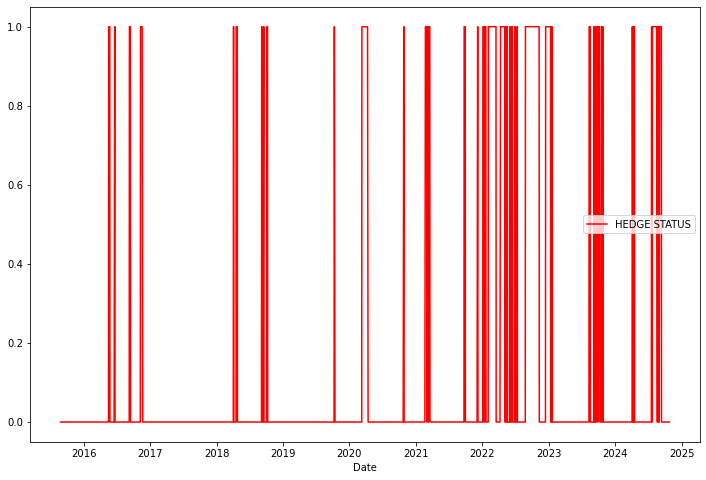

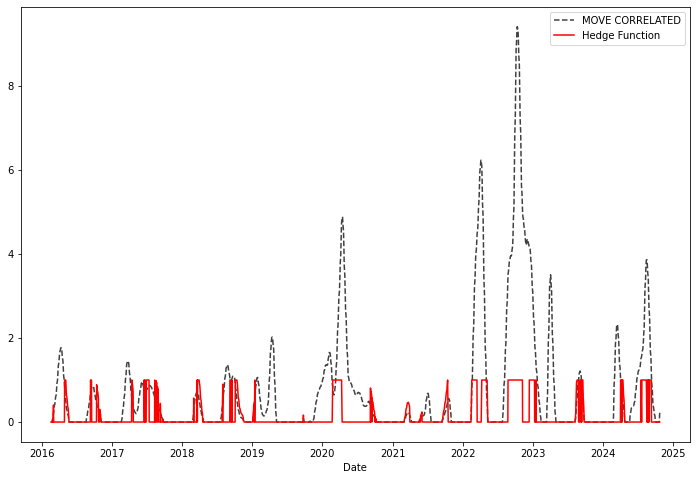

In [119]:
## HEDGE FUNCTION

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def hedge_position(Prices_df):
    thresh1 = 7
    thresh2 = 0
    mav_window_1 = 5
    mav_window_2 = 21
    mav_window_3 = 42    
    margin = 0.5 / 100
    move_thresh = 2
    START_DATE_b = START_DATE - timedelta(126)
    
    Prices_df = Prices_df[Prices_df.index >= START_DATE_b]
    SPX_ret_S = 100 * Prices_df['SPX'].pct_change().fillna(0)
    QQQ_ret_S = 100 * Prices_df['QQQ'].pct_change().fillna(0)
    SPX_ret_S.name = 'SPX Rets'
    QQQ_ret_S.name = 'QQQ Rets'
    VIX_mav_S = Prices_df['VIX'].rolling(mav_window_2).mean()
    QQQ_mav_s = Prices_df['QQQ'].rolling(mav_window_3).mean()    

    VIX_RS_S = np.ceil((Prices_df['VIX'] - VIX_mav_S).clip(0, 1)).dropna()
    QQQ_RS_S = 1 - np.ceil((Prices_df['QQQ'] - (1 + margin) * QQQ_mav_s).clip(0, 1))
    VIX_RS_S.name = 'VIX RS'
    QQQ_RS_S.name = 'QQQ RS'

    MOVE_S = (100 * Prices_df['USGG2YR'].rolling(mav_window_2).std()).rolling(mav_window_2).mean()
    MOVE_CORR_S = abs(MOVE_S.rolling(mav_window_3).corr(Prices_df['SPX']).rolling(mav_window_3).mean().clip(-1, 0)) * MOVE_S
    MOVE_CORR_S.name = 'MOVE CORR'

    RY_S = (Prices_df['USGG10YR'] - Prices_df['T5YIFR'])
    RY_S.name = 'Real Yields'
    
    RY_RS_S = (RY_S - RY_S.rolling(mav_window_1, min_periods = 1).mean()) * 100 
    RY_RS_S.name = 'Real Yields RS'
    
    Q_RY_RS_S = RY_RS_S.copy()
    Q_RY_RS_S[Q_RY_RS_S < thresh2] = 0
    Q_RY_RS_S[Q_RY_RS_S > thresh1] = 1
    count = 0
    for element in Q_RY_RS_S.index:
        if (Q_RY_RS_S.loc[element] != 0) & (Q_RY_RS_S.loc[element] != 1):
            Q_RY_RS_S.iloc[count] = Q_RY_RS_S.iloc[count - 1]
        count = count + 1
    Q_RY_RS_S.name = 'Real Yields Q'
        
    rr_df = pd.DataFrame(Q_RY_RS_S)
    rr_df = rr_df.join(SPX_ret_S).join(RY_RS_S).join(QQQ_ret_S).join(VIX_RS_S).join(QQQ_RS_S).join(MOVE_CORR_S)
    rr_df['MOVE CORR'] = np.ceil(rr_df['MOVE CORR'].dropna() - move_thresh).clip(0, 1)
    rr_df['RATES INDEX'] = round((rr_df['Real Yields Q'] + rr_df['MOVE CORR']).replace({np.nan: 0}), 0).clip(0, 1)

    rr_df['Hedge Status'] = round((rr_df['QQQ RS'] * rr_df['RATES INDEX']).replace({np.nan: 0}), 0).astype(int)

    c = 1
    for element in rr_df.index[2:]:
        if (rr_df.iloc[c]['Hedge Status'] == 1) & (rr_df.iloc[c - 1]['Hedge Status'] == 0):
            rr_df.loc[element, 'Hedge Status'] = 1
        c = c + 1

    original_hedge_df = pd.DataFrame(rr_df['Hedge Status'].values, index = rr_df.index, columns = ['Hedge Status'])
    original_hedge_df.to_sql('hedge_relation', engine, index=True, if_exists='replace')

    plt.figure(0, figsize = (12, 8))
    rr_df['Hedge Status'].plot(c = 'r', label = 'HEDGE STATUS').legend(loc = 'best')
    
    plt.figure(1, figsize = (12, 8))
    (MOVE_CORR_S / 2).plot(c = 'k', label = 'MOVE CORRELATED', linestyle = 'dashed', alpha = 0.75).legend(loc = 'best')
    (MOVE_CORR_S * QQQ_RS_S).dropna().clip(0, 1).plot(c = 'r', label = 'Hedge Function').legend(loc = 'best')
    print('')
    
    return rr_df.dropna(), MOVE_CORR_S

# MOVE CORRELATED: correlation b/w 2y US rates vol and SPX, clipped at (-1, 0) - only triggers hedge IF QQQ below MAV50
START_DATE = datetime(2016, 1, 1).date() 
Prices_df = open_df('prices_relation')
Prices_df = Prices_df.sort_index()
Prices_df = Prices_df.rename(columns = {'QQQ US': 'QQQ'})
QRhedge_df = hedge_position(Prices_df)[0]
QRhedge_df[-10:]

Custom Sector 5

Enter Start Date (empty for update or YY/MM/DD): 
Enter End Date (empty for last or YY/MM/DD): 
Override (Y/y or empty)? 
Fundamentals date: 22-Oct-2024
idio var weights


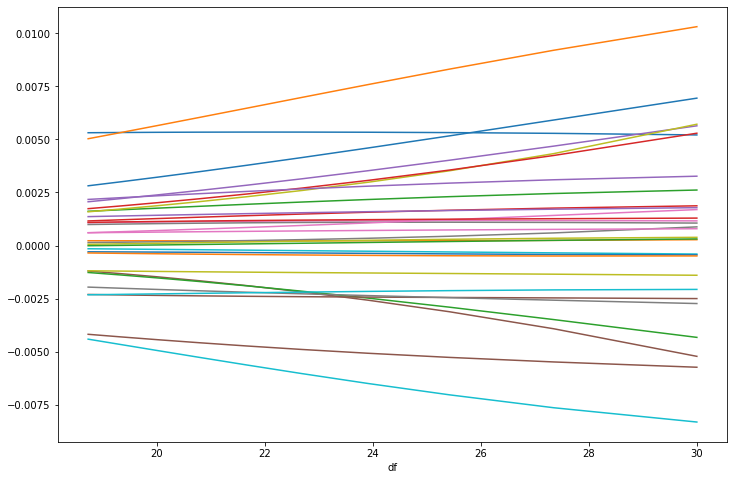

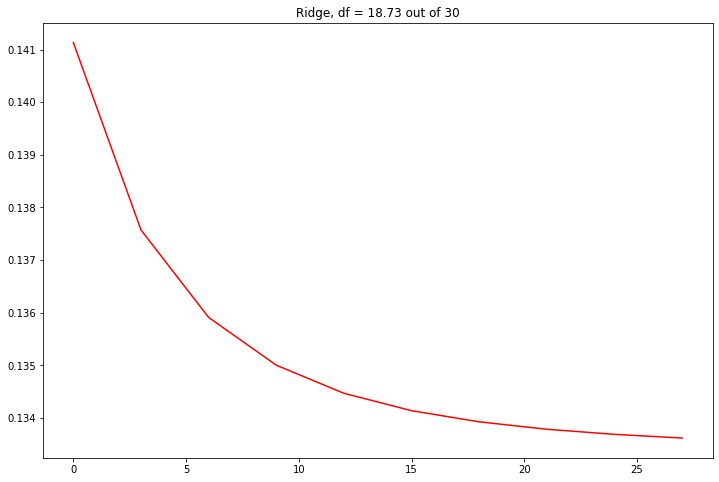

25-Oct-2024 r2: 8.09



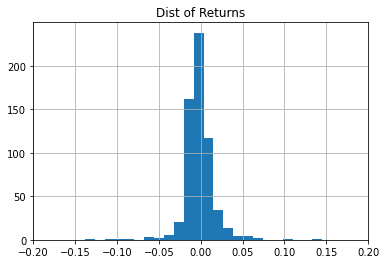

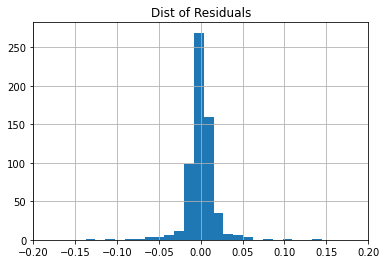

Sum of sectors: 1.13%
Daily Factor Rets:
                          2024-10-25
Market                         -0.23
Beta                            0.53
Momentum                       -0.01
Vol                            -0.03
Application Software            0.16
Electrical & Electronics        0.11
Data Software                   0.20
Fintech                        -0.12
Industrials                     0.11
Consumer Discretionary          0.11
Hardware                        0.16
Financial Services             -0.45
Health Care                     0.00
Consumer Services               0.28
Energy                          0.50
REITs                          -0.10
Insurers                        0.23
Staples                         0.23
Utilities                      -0.41
Pharmaceuticals                 0.07
Materials                       0.03
Ideal                           0.02
Size                            0.01
Value                          -0.04
T10YIE                         -0.

In [120]:
## STAGE-WISE ORTHOGONALIZATION, MULTI-FACTOR REGRESSION

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.linear_model import Ridge
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import optimize 
from scipy.optimize import linprog
import warnings

def predictors_to_Cfeatures(pred_df, c_features_l, sector_s):
    
    exp_g = 10
    m_omd = 5
    IDwinsor_L = 0.025
    IDwinsor_H = 0.990
    winsor_L = 0.01
    Vwinsor_H = 0.90
    IQuant = 10
    field_l = ['GS', 'GGP', 'GE', 'G', 'G Vol', 'G r2', 'E Vol', 'S Vol', 'OM', 'OMp', 'ROIp', 'ROIdp', 'Alloc']    
    sc_df = pd.DataFrame(np.nan, index = pred_df.index, columns = field_l)

    pred_df['P/Ee'][pred_df['P/Ee'] < 0] = abs(pred_df['P/Ee'][pred_df['P/Ee'] < 0]) * 100
    pred_df['P/Eo'][pred_df['P/Eo'] < 0] = abs(pred_df['P/Eo'][pred_df['P/Eo'] < 0]) * 100
    pred_df['P/GP'][pred_df['P/GP'] < 0] = abs(pred_df['P/GP'][pred_df['P/GP'] < 0]) * 100
    pred_df['P/S'][pred_df['P/S'] < 0] = abs(pred_df['P/S'][pred_df['P/S'] < 0]) * 100
    pred_df['sP/E'][pred_df['sP/E'] < 0] = abs(pred_df['sP/E'][pred_df['sP/E'] < 0]) * 100
    pred_df['sP/S'][pred_df['sP/S'] < 0] = abs(pred_df['sP/S'][pred_df['sP/S'] < 0]) * 100
    pred_df['sP/GP'][pred_df['sP/GP'] < 0] = abs(pred_df['sP/GP'][pred_df['sP/GP'] < 0]) * 100
    pred_df = fix_na(pred_df, 'r2 S', 'r2 GP')
    pred_df = fix_na(pred_df, 'GS', 'GGP')
    aux_df = pred_df[['sP/S', 'sP/GP']]
    ratio = aux_df.median()['sP/GP'] / aux_df.median()['sP/S']
    aux_df['sP/S'] *= ratio
    aux_df = aux_df.T.fillna(method = 'ffill').T
    pred_df['sP/GP'] = aux_df['sP/GP']

    featuresC_df = pd.DataFrame(np.nan, index = pred_df.index, columns = c_features_l)

    sc_df['GS'] = pred_df['GS']
    sc_df['GGP'] = pred_df['GGP']
    sc_df['GE'] = pred_df['GE']
    sc_df['G'] = pred_df[['GE','GGP', 'GS']].min(axis = 1)
    sc_df['G Vol'] = pred_df[['GE','GGP', 'GS']].std(axis = 1)
    sc_df['G r2'] = pred_df[['r2 S', 'r2 GP', 'r2 E']].mean(axis = 1)
    sc_df['E Vol'] = pred_df['E Vol'].map(lambda x: max(1, x / 100))
    sc_df['S Vol'] = pred_df['S Vol'].map(lambda x: max(1, x / 100))
    sc_df['OM'] = pred_df['OM-t0'].map(lambda x: min(x, 60))
    sc_df['OMp'] = pred_df['OMd'].map(lambda x: min(x, 0))
    sc_df['ROIp'] = pred_df['ROI-P'].map(lambda x: min(x, 0))
    sc_df['ROIdp'] = pred_df['ROId'].map(lambda x: min(x, 0))
    sc_df['G r2'] = sc_df['G r2'].replace({-np.inf: 1})
    sc_df['Alloc'] = (25 * sc_df['G'] * (sc_df['G r2'] ** 5) / sc_df['E Vol'] / sc_df['S Vol'] + 
                      5 * sc_df['OM'] + 50 * sc_df['OMp'] + 50 * sc_df['ROIp'] + 50 * sc_df['ROIdp'])
    
    featuresC_df['Ideal'] = winsorize(sc_df['Alloc'], IDwinsor_L, IDwinsor_H)

    Value_s = (3 * pred_df['sP/E'] + pred_df['sP/GP']) / 4
    featuresC_df['Value'] = -winsorize(Value_s, winsor_L, Vwinsor_H) 
    featuresC_df['Size'] = -pd.Series(np.log(pred_df['Size']), index = pred_df.index)

    featuresC_df -= featuresC_df.mean()
    featuresC_df /= featuresC_df.std()
    featuresC_df = featuresC_df.fillna(0)
    
    return featuresC_df

def predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s):
        
    MacroPxs_df['US10YR RR'] = MacroPxs_df['USGG10YR'] - MacroPxs_df['T10YIE']
    MacroPxs_df['YC'] = MacroPxs_df['USGG10YR'] - MacroPxs_df['USGG2YR']
    MacroPxs_df['2Y IR Vol'] = MacroPxs_df['USGG2YR'].ewm(halflife = hl).std() * np.sqrt(252)
    MacroPxs_df = MacroPxs_df.loc[sPxs_df.index]
    MacroPxs_df = (MacroPxs_df - MacroPxs_df.ewm(halflife = hl).mean())
    MacroPxs_df = MacroPxs_df.pct_change()

    MacroFactor_df = pd.DataFrame(np.nan, index = sPxs_df.columns, columns = m_features_l)
    for c_mf in m_features_l:
        c_mf_s = sPxs_df.pct_change().join(MacroPxs_df[c_mf])[-hl:].cov()[c_mf].drop(c_mf)    
        featVar_s = MacroPxs_df[c_mf].ewm(halflife = hl).var().iloc[-1]
        MacroFactor_df[c_mf] = c_mf_s / featVar_s

    for c_feat in m_features_l:
        MacroFactor_df[c_feat] = winsorize(MacroFactor_df[c_feat], winsor_L, winsor_H).values

    naT_l = MacroFactor_df.isna().sum(axis = 1)[MacroFactor_df.isna().sum(axis = 1) > 0].index
    naF_l = MacroFactor_df.loc[naT_l].T[MacroFactor_df.loc[naT_l].T.isna()].index.tolist()  
    MacroFactor_df.loc[naT_l, naF_l] = MacroFactor_df.median().values
    MacroFactor_df -= MacroFactor_df.mean()
    MacroFactor_df /= MacroFactor_df.std()

    return MacroFactor_df, MacroPxs_df[m_features_l]

def predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s):

    lag_M1 = -252
    lag_M3 = -21
    beta_adj = True

    featuresP_df = pd.DataFrame(np.nan, index = sPxs_df.columns, columns = p_features_l)
    sRetPxs_df = sPxs_df.pct_change().dropna()
    sRetMkt_s = sMkt_s.pct_change().dropna()    
    sCovPxs_s = sRetPxs_df.ewm(halflife = hl).cov(sRetMkt_s.ewm(halflife = hl)).iloc[-1]
    sVarMkt = sRetMkt_s.ewm(halflife = hl).cov(sRetMkt_s.ewm(halflife = hl)).iloc[-1]
    featuresP_df['Beta'] = winsorize(sCovPxs_s / sVarMkt, 0, winsor_H)
    featuresP_df['Vol'] = -winsorize(sRetPxs_df.ewm(halflife = hl).std().iloc[-1], 0, winsor_H)
    Mom_s = pd.Series((featuresP_df.index.map(lambda x: sPxs_df[x].iloc[lag_M3]) / 
                       featuresP_df.index.map(lambda x: sPxs_df[x].iloc[lag_M1])), index = featuresP_df.index)
    featuresP_df['Momentum'] = winsorize(Mom_s, winsor_L, winsor_H)

    featuresP_df -= featuresP_df.mean()
    featuresP_df /= featuresP_df.std()
    
    return featuresP_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df 

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def fix_na(base_df, col_b, col_t):

    aux = base_df[[col_b, col_t]]
    aux = aux.T.fillna(method = 'ffill').T
    base_df[col_t] = aux[col_t]
    
    return base_df

def clean_dates(dt_range, exclusionDates_l):
    
    auxDt_s = pd.Series(dt_range)
    auxDt_s.index = pd.Series(dt_range).map(lambda x: x.strftime('%m%d')).tolist()
    validDT_l = [d for d in auxDt_s.index.tolist() if d not in exclusionDates_l]
    dt_range = sorted(pd.unique(auxDt_s.loc[validDT_l].tolist()).tolist())
    
    return dt_range    

def winsorize(Rt_s, floor, cap):
    
    w_up = np.quantile(Rt_s.dropna().values, q = cap)
    w_down = np.quantile(Rt_s.dropna().values, q = floor)    
    w_s = Rt_s.clip(w_down, w_up)
    
    return w_s

def get_predictors(c_date, exclusion_l):
    
    rel_found = False
    count = 0
    attempts_cap = 30
    while (not rel_found) & (count < attempts_cap):
        try:
            pred_df = open_df('valuation_' + c_date.strftime('%Y%m%d') + selection_scope)
            rel_found = True            
        except:
            c_date = c_date - timedelta(1)
            c_date = c_date - timedelta((c_date.weekday() % 4) * (c_date.weekday() // 4))
            count += 1
    
    pred_df = pred_df.dropna(thresh = pred_df.shape[1] // 2)
    pred_df['P/Ee'][pred_df['P/Ee'] <= 0] = 100
    pred_df['P/Eo'][pred_df['P/Eo'] <= 0] = 100
    pred_df['P/S'][pred_df['P/S'] <= 0] = 100  
    exclusion_l = [t for t in exclusion_l if t in pred_df.index]
    pred_df = pred_df.drop(exclusion_l)
    
    return pred_df, c_date

def w_mlr(x_m, y_a, w_a, idx_l, c_l, itcp):
    
    model = LinearRegression(fit_intercept = itcp)
    lr_mod = model.fit(x_m, y_a, w_a)
    lr_values = lr_mod.predict(x_m)
    fRet_s = pd.Series(lr_mod.coef_, index = c_l)    
    fcast_s = pd.Series(lr_values, index = idx_l)
    fRet_s.name = 'wMLR Factor Rets'
    fcast_s.name = 'wMLR Ret Fcast'   
    y0 = lr_mod.intercept_
    mlr_r2 = round(100 * lr_mod.score(x_m, y_a, w_a), 2)
    
    return fcast_s, fRet_s, y0, mlr_r2

def ridge(x_m, y_a, idx_l, c_l):
    
    xv_n = 10
    ridge_n = 30
    step = 3  
    lambda_penalty = 10
    
    lambda_array = np.arange(ridge_n)
    lambda_array = lambda_array[::step]
    x_df = pd.DataFrame(x_m.T)
    y_df = pd.DataFrame(y_a.T)

    cv_mse_df = pd.DataFrame(np.nan, index = lambda_array, columns = ['Train', 'Val'])
    beta_df = pd.DataFrame(np.nan, index = lambda_array, columns = np.arange(x_df.shape[1]).tolist() + ['df'])
    val_r2 = np.inf
    shift_lambda = False
    for c_lambda in lambda_array:
        if (shift_lambda):
            c_lambda += lambda_penalty
        try:        
            Rmodel = Ridge(alpha = c_lambda, normalize = False, tol = 0.001, solver = 'auto', random_state = 42)
            valRMSE_tot = 0
            trainRMSE_tot = 0
            for c in np.arange(xv_n):
                init_v = xv_n * c
                end_v = init_v + xv_n
                valX_df = x_df.iloc[init_v: end_v]
                valY_df = y_df.iloc[init_v: end_v]
                trainX_df = x_df.drop(valX_df.index)
                trainY_df = y_df.drop(valX_df.index)

                I_m = np.identity(trainX_df.shape[1])
                lambda_matrix = I_m * np.array([c_lambda] * trainX_df.shape[1])
                beta_array = np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix).dot(trainX_df.T.values.dot(trainY_df.values))
                hat_matrix = (trainX_df.values).dot(np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix)).dot(trainX_df.T.values)        

                if (c == 0):
                    edf = np.trace(hat_matrix)
                    beta_df.loc[c_lambda] = pd.DataFrame(beta_array)[0].tolist() + [edf]

                ridge_mod = Rmodel.fit(trainX_df.values, trainY_df.values)
                trainRidge_f = ridge_mod.predict(trainX_df.values)
                valRidge_f = ridge_mod.predict(valX_df.values)
                trainRidge_mse = np.sum((trainY_df.values - trainRidge_f) ** 2)
                valRidge_mse = np.sum((valY_df.values - valRidge_f) ** 2)
                trainRMSE_tot += trainRidge_mse 
                valRMSE_tot += valRidge_mse 
            cv_mse_df.loc[c_lambda, 'Train'] = 100 * trainRMSE_tot / xv_n
            cv_mse_df.loc[c_lambda, 'Val'] = 100 * valRMSE_tot / xv_n
            if (valRMSE_tot < val_r2):
                bestRidge_f = ridge_mod.predict(x_df.values)
                bestRidge_fr = pd.DataFrame(beta_array)[0].values
                bestLambda = c_lambda
                Rintercept = ridge_mod.intercept_
                val_r2 = valRMSE_tot
                best_edf = edf
        except:
            val_r2 = np.inf
            shift_lambda = True
            print('Ridge lambda' + str(c_lambda) + ' singular!!')            

    bestRidgeRt_s = pd.Series(pd.DataFrame(bestRidge_f)[0].values, index = idx_l)
    bestRidgeFS_s = pd.Series(bestRidge_fr, index = c_l)
    bestRidgeFS_s.name = 'Ridge Factor Rets'
    beta_df.index = beta_df['df']
    beta_df = beta_df.drop(['df'], axis = 1)
    beta_df.sort_index().plot(figsize = (12, 8))
    plt.legend().remove()
    plt.show()
    cv_mse_df['Val'].plot(figsize = (12, 8), c = 'r')
    plt.title('Ridge, df = ' + str(round(best_edf, 2)) + ' out of ' + str(x_m.shape[0]))
    plt.show()
    Ridge_r2 = round(100 * (pd.DataFrame(bestRidge_f).join(y_df, rsuffix = '_label').corr().iloc[0, 1] ** 2), 3)

    return bestRidgeRt_s, bestRidgeFS_s, Rintercept, Ridge_r2, bestLambda

def othogonalize(cbasis_df, newF_s):
    
    ortF_model = LinearRegression(fit_intercept = True)
    residualF_a = newF_s.values
    for c_basis in cbasis_df.columns:
        x_a = cbasis_df[c_basis].values.reshape(-1, 1)
        y_a = residualF_a
        ortF_m = ortF_model.fit(x_a, residualF_a)
        spanned_a = ortF_m.predict(x_a)
        residualF_a -= spanned_a
    orthogonal_s = pd.Series(residualF_a, index = newF_s.index)

    return orthogonal_s  

def w_mlr2(x_m, y_a, w_a, idx_l, c_l, itcp):
    
    model = LinearRegression(fit_intercept = itcp)
    x_m = (x_m.T * w_a).T
    y_a = y_a * w_a
    lr_mod = model.fit(x_m, y_a)
    lr_values = lr_mod.predict(x_m) / w_a
    fRet_s = pd.Series(lr_mod.coef_, index = c_l)    
    fcast_s = pd.Series(lr_values, index = idx_l)
    fRet_s.name = 'wMLR Factor Rets'
    fcast_s.name = 'wMLR Ret Fcast'   
    y0 = lr_mod.intercept_
    mlr_r2 = round(100 * lr_mod.score(x_m, y_a), 2)
    
    return fcast_s, fRet_s, y0, mlr_r2

def ridge2(x_df, y_s, w_s, idx_l, c_l):
    
    xv_n = 10
    ridge_n = 30
    step = 3  
    lambda_penalty = 10
    
    lambda_array = np.arange(ridge_n)
    lambda_array = lambda_array[::step]
    x_df = (x_df.T * w_s).T
    y_s = y_s * w_s 
    y_s.name = 'Labels'

    cv_mse_df = pd.DataFrame(np.nan, index = lambda_array, columns = ['Train', 'Val'])
    beta_df = pd.DataFrame(np.nan, index = lambda_array, columns = np.arange(x_df.shape[1]).tolist() + ['df'])
    val_r2 = np.inf
    shift_lambda = False
    for c_lambda in lambda_array:
        if (shift_lambda):
            c_lambda += lambda_penalty
        try:        
            Rmodel = Ridge(alpha = c_lambda, normalize = False, tol = 0.001, solver = 'auto', random_state = 42)
            valRMSE_tot = 0
            trainRMSE_tot = 0
            for c in np.arange(xv_n):
                init_v = xv_n * c
                end_v = init_v + xv_n
                valX_df = x_df.iloc[init_v: end_v]
                valY_df = y_s.iloc[init_v: end_v]
                valW_s = w_s.iloc[init_v: end_v]
                trainX_df = x_df.drop(valX_df.index)
                trainY_df = y_s.drop(valY_df.index)
                trainW_s = w_s.drop(valW_s.index)

                I_m = np.identity(trainX_df.shape[1])
                lambda_matrix = I_m * np.array([c_lambda] * trainX_df.shape[1])
                beta_array = np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix).dot(trainX_df.T.values.dot(trainY_df.values))
                hat_matrix = (trainX_df.values).dot(np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix)).dot(trainX_df.T.values)        

                if (c == 0):
                    edf = np.trace(hat_matrix)
                    beta_df.loc[c_lambda] = pd.DataFrame(beta_array)[0].tolist() + [edf]

                ridge_mod = Rmodel.fit(trainX_df.values, trainY_df.values)
                trainRidge_f = ridge_mod.predict(trainX_df.values) / trainW_s.values
                valRidge_f = ridge_mod.predict(valX_df.values) / valW_s.values
                trainRidge_mse = np.sum((trainY_df.values - trainRidge_f) ** 2)
                valRidge_mse = np.sum((valY_df.values - valRidge_f) ** 2)
                trainRMSE_tot += trainRidge_mse 
                valRMSE_tot += valRidge_mse 
            cv_mse_df.loc[c_lambda, 'Train'] = 100 * trainRMSE_tot / xv_n
            cv_mse_df.loc[c_lambda, 'Val'] = 100 * valRMSE_tot / xv_n
            if (valRMSE_tot < val_r2):
                bestRidge_f = ridge_mod.predict(x_df.values) / w_s.values
                bestRidge_fr = pd.DataFrame(beta_array)[0].values
                bestLambda = c_lambda
                Rintercept = ridge_mod.intercept_
                val_r2 = valRMSE_tot
                best_edf = edf
        except:
            val_r2 = np.inf
            shift_lambda = True
            print('Ridge lambda' + str(c_lambda) + ' singular!!')            

    bestRidgeRt_s = pd.Series(pd.DataFrame(bestRidge_f)[0].values, index = idx_l)
    bestRidgeFS_s = pd.Series(bestRidge_fr, index = c_l)
    bestRidgeFS_s.name = 'Ridge Factor Rets'
    beta_df.index = beta_df['df']
    beta_df = beta_df.drop(['df'], axis = 1)
    beta_df.sort_index().plot(figsize = (12, 8))
    plt.legend().remove()
    plt.show()
    cv_mse_df['Val'].plot(figsize = (12, 8), c = 'r')
    plt.title('Ridge, df = ' + str(round(best_edf, 2)) + ' out of ' + str(x_df.shape[1]))
    plt.show()
    Ridge_r2 = round(100 * (pd.DataFrame(bestRidgeRt_s).join(y_s).corr().iloc[0, 1] ** 2), 3)

    return bestRidgeRt_s, bestRidgeFS_s, Rintercept, Ridge_r2, bestLambda

def on_selection_class(value):
    global target_class
    target_class = value
    root.destroy()

warnings.filterwarnings('ignore')
dbase = "visiblealpha_laptop"
conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

selection_scope = ''
all_fundamentals_l = ['sP/S', 'sP/E', 'sP/GP', 'P/S', 'P/Ee', 'P/GP', 'P/Eo', 'OM-t0', 'OM', 'OMd', 'GS', 'GE', 'r2 S', 'r2 E', 
                      'GGP', 'r2 GP', 'Size', 'ROI-P', 'ROI', 'ROId','ROE-P', 'ROE', 'ROEd', 'S Vol', 'E Vol', 'GP Vol', 'r&d']
exclusion_l = ['BABA US', 'XPEV US', 'NIO US', 'TME US', 'JD US', 'PDD US', 'VNET US', 'ZLAB US', 'WB US', 
               'OCFT US', 'BGNE US', 'MOMO US', 'ZTO US', 'NTES US']
macroFeatures_l = ['CRB Index Index Points', 'Brent USD/Bbl', 'M2CP Velocity', 'M2MP Velocity', 'T5YIFR', 'T10YIE', 'USGG2YR', 
                   'USGG10YR', 'VIX']
sector_ETF_map = {'Software': 'IGV US',
                 'Industrials': 'XLI US',
                 'Health Care': 'XLV US',
                 'Consumer Goods': 'XLP US',
                 'Hardware': 'SOXX US',
                 'Financials': 'XLF US',
                 'Consumer Services': 'XLY US',
                 'Energy': 'XLE US',
                 'Utilities': 'XLU US',
                 'Telecommunications': 'XLC US',
                 'Materials': 'XLB US'}

hl = 42
q_quant = 100
long_w = 1000
volCheck_w = 10
winsor_L = 0.010
winsor_H = 0.990
ridge_b = True
anchor_asset = 'SPX'
sacr_sector = 'Health Care'
Pxs_df = open_df('prices_relation')

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
class_list = Sectors_df.columns.tolist()

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *class_list, command = on_selection_class)
tk.Label(root, text = "Choose a classification: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

print(target_class)
print('')
secExt = '_cs' + target_class[-1]
factExt = ''
if (ridge_b):
    factExt = '_ridge'

stocks = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Tickers_VA.csv")
all_tickers_l = stocks['tickers'].tolist()

sector_l = pd.unique(Sectors_df.dropna(subset = [target_class])[target_class]).tolist()
sector_s = Sectors_df[Sectors_df[target_class].isna() == False][target_class]
Industry_s = Sectors_df.loc[sector_s.index, 'VA Industry']
Industry_l = pd.unique(Industry_s).tolist()

m_features_l = ['T10YIE', 'VIX', '2Y IR Vol', 'USGG2YR', 'US10YR RR', 'Brent USD/Bbl', 'M2MP Velocity']
c_features_l = ['Ideal', 'Size', 'Value']
p_features_l = ['Beta', 'Momentum', 'Vol'] 
SLICEall_features_l = ['Market'] + p_features_l + sector_l + c_features_l + m_features_l 
all_features_l = SLICEall_features_l.copy()

STdt_str = input('Enter Start Date (empty for update or YY/MM/DD): ')
try:
    st_date = datetime.strptime(STdt_str, "%y/%m/%d").date()
except:
    st_date = Pxs_df.index[-1] 
    
ENdt_str = input('Enter End Date (empty for last or YY/MM/DD): ')
try:
    end_date = datetime.strptime(ENdt_str, "%y/%m/%d").date()
except:
    end_date = Pxs_df.index[-1]  

st_date = Pxs_df[Pxs_df.index >= st_date].index[0]
ovr = False
oride = input('Override (Y/y or empty)? ').upper()
if (oride == 'Y'):
    ovr = True
        
dt_range = Pxs_df[Pxs_df.index >= st_date][Pxs_df[Pxs_df.index >= st_date].index <= end_date].index.tolist() 
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('0101')) == -1].tolist()
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('2512')) == -1].tolist()
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('0407')) == -1].tolist()
if (ovr):
    FactorRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_features_l)
    IdioRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_tickers_l)
else:
    try:
        FactorRets_df = open_df('factor_returns' + factExt + secExt)    
        IdioRets_df = open_df('idio_returns' + factExt + secExt)
    except:
        FactorRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_features_l)
        IdioRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_tickers_l)    

save_file = True
dt_range = [dt for dt in dt_range if dt not in FactorRets_df.dropna(how = 'all').index.tolist()] 
if (len(dt_range) == 0):
    save_file = False
    SPdt_str = input('Specific date (empty for last or YY/MM/DD): ')
    try:
        sp_date = datetime.strptime(SPdt_str, "%y/%m/%d").date()
    except:
        sp_date = Pxs_df.index[-1]         
    dt_range.append(sp_date)
    
for c_dt in dt_range:
    p_dt = Pxs_df.index[Pxs_df.index.tolist().index(c_dt) - 1]
    valid_start = False 
    pred_dt = c_dt
    while (not valid_start):
        pred_df, c_date = get_predictors(pred_dt, exclusion_l)
        exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
        exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
        if (len(exc_ffields) == 0):
            pred_df = pred_df.drop(exc_tickers)
            valid_start = True
            print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
        else:
            pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]
            
    sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ]
    Check_s = round(100 * sPxs_df[pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
    SBweights_s = np.log(pred_df['Size'])     
    sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
    zeroVol_l = Check_s[Check_s == 0].index.tolist()
    excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
    pred_df = pred_df.drop(excall_l)
    asset_l = pred_df.index.tolist()
    
    FlatWeights_s = pd.Series(1, index = pred_df.index)       
    sIdioRets_df = IdioRets_df[IdioRets_df.index < c_dt].dropna(how = 'all')
    if (sIdioRets_df.shape[0] >= (2 * hl)):
        print('idio var weights')
        var_s = sIdioRets_df[-252:][asset_l].ewm(halflife = hl).var().iloc[-1]
        mean_var = var_s.mean()
        VBWeights_s = var_s.fillna(mean_var) ** (-1)
        VBWeights_s /= VBWeights_s.std()
        Weights_s = VBWeights_s[asset_l]        
    else:
        print('size weights')
        Weights_s = SBweights_s[asset_l].copy()
    w_s = Weights_s ** (1 / 2)
        
    MacroPxs_df = Pxs_df[Pxs_df.index < c_dt][macroFeatures_l][-long_w: ]    
    sMkt_s = sPxs_df[anchor_asset]
    sPxs_df = sPxs_df[asset_l]

    ## LOADINGS ENGINEERING, TIME SERIES

    featuresP_df = predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s)
    featuresC_df = predictors_to_Cfeatures(pred_df, c_features_l, sector_s)
    featuresM_df, MacroFeatures_df = predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s)
    XSStyleLoadings_df = featuresP_df.join(featuresC_df)

    ## INTERCEPT, BETA RETURNS AND RESIDUALS, CROSS SECTION: SIMPLE LINEAR MODEL (LN(MKT CAP) AS WEIGHTS) - 1

    XSMktRet = Pxs_df[anchor_asset].loc[c_dt] / Pxs_df[anchor_asset].loc[p_dt] - 1    
    RawAssetRets_s = Pxs_df[asset_l].loc[c_dt] / Pxs_df[asset_l].loc[p_dt] - 1    
    XSAssetRets = winsorize(RawAssetRets_s, winsor_L, winsor_H)
    XSAssetRets.name = 'Rt'
    
    # FACTOR ORTHOGONALIZATION
    
    sBetas_s = featuresP_df['Beta']
    FactorLoadings_df = pd.DataFrame(sBetas_s)
    
    sIdeal_s = featuresC_df['Ideal']
    FactorLoadings_df[sIdeal_s.name] = othogonalize(FactorLoadings_df, sIdeal_s)    

    XSSectorLoadings_df = pd.DataFrame(0, index = asset_l, columns = sector_l)
    for c_sector in sector_l:
        stock_l = [t for t in asset_l if t in sector_s[sector_s == c_sector].index]
        XSSectorLoadings_df.loc[stock_l, c_sector] = 1   
    XSSectorLoadings_df = (XSSectorLoadings_df - XSSectorLoadings_df.mean())
    sectorR_l = sector_l.copy()
    sectorR_l.remove(sacr_sector)
    for c_sector in sectorR_l:
        FactorLoadings_df[c_sector] = othogonalize(FactorLoadings_df, XSSectorLoadings_df[c_sector]).values        

    sSize_s = featuresC_df['Size']
    FactorLoadings_df[sSize_s.name] = othogonalize(FactorLoadings_df, sSize_s)

    for c_Sfeat in XSStyleLoadings_df.columns:
        if (c_Sfeat not in FactorLoadings_df.columns):
            FactorLoadings_df[c_Sfeat] = othogonalize(FactorLoadings_df, XSStyleLoadings_df[c_Sfeat]).values

    for c_Mfeat in m_features_l:
        FactorLoadings_df[c_Mfeat] = othogonalize(FactorLoadings_df, featuresM_df[c_Mfeat]).values
        
    FactorLoadings_df['Market'] = 1
    x = FactorLoadings_df.copy()

    # MULTI-VARIATE REGRESSION, ORTHOGONAL BASIS, NO INTERCEPT
            
    if (ridge_b):
        aXSOStockRet_s, aXSOFacRet_s, aXSOy0, aXSOmlr_r2, aXSOLambda = ridge2(FactorLoadings_df, XSAssetRets, w_s, 
                                                                              asset_l, FactorLoadings_df.columns.tolist())    
    else:
        aXSOStockRet_s, aXSOFacRet_s, aXSOy0, aXSOmlr_r2 = w_mlr2(FactorLoadings_df.values, XSAssetRets.values, w_s.values, 
                                                                  asset_l, FactorLoadings_df.columns.tolist(), False)
    aXSOFacRet_s.loc[sacr_sector] = 0    
    FactorLoadings_df[sacr_sector] = XSSectorLoadings_df[sacr_sector]
    FactorRets_df.loc[c_dt] = aXSOFacRet_s
        
    IdioRets_df.loc[c_dt, asset_l] = RawAssetRets_s - (FactorLoadings_df * FactorRets_df.loc[c_dt]).sum(axis = 1)
    modelR2 = round(100 * (FactorLoadings_df * FactorRets_df.loc[c_dt]).sum(axis = 1).corr(RawAssetRets_s) ** 2, 2)
    
    if (len(dt_range) == 1):
        print(c_dt.strftime('%d-%b-%Y') + ' r2: ' + str(modelR2))
        print('')
        RawAssetRets_s.hist(bins = 30)
        plt.title('Dist of Returns')
        plt.xlim([-0.2, 0.2])
        plt.show()
        IdioRets_df.loc[c_dt].hist(bins = 30)
        plt.title('Dist of Residuals')
        plt.xlim([-0.2, 0.2])
        plt.show()  
    else:
        print(c_dt.strftime('%d-%b-%y') + ' r2: ' + str(modelR2))
    print('Sum of sectors: ' + str(round(100 * FactorRets_df[sector_l].iloc[-1].sum(), 2)) + '%') 
    dSummary_df = pd.DataFrame(round(100 * FactorRets_df.loc[c_dt], 2))
    if (target_class == 'Custom Sector 1'):
        ETFRets_s = pd.Series(100 * (FactorRets_df[sector_l].columns.map(lambda x: Pxs_df.loc[c_dt, sector_ETF_map[x]]) / 
                          FactorRets_df[sector_l].columns.map(lambda x: Pxs_df.loc[p_dt, sector_ETF_map[x]]) - 1).values, 
                          index = sector_l)
        ETFRets_s.name = 'ETFs'    
        dSummary_df['ETF Rets'] = np.nan
        dSummary_df.loc[sector_l, 'ETF Rets'] = round(ETFRets_s, 2)
    print('Daily Factor Rets:')
    print(dSummary_df)
    print('')
    
if (len(dt_range) > 0) & (save_file):
    if (len(dt_range) == 1) & (ovr):
        print('Not saving....')
    else:
        FactorRets_df.sort_index().to_sql('factor_returns' + factExt + secExt, engine, index = True, if_exists = 'replace')
        IdioRets_df.sort_index().to_sql('idio_returns' + factExt + secExt, engine, index = True, if_exists = 'replace')   
        factorSharpe_s = (round(((1 + FactorRets_df).expanding().apply(np.prod).iloc[-1] - 1) / 
                               (FactorRets_df.std() * np.sqrt(FactorRets_df.shape[0])), 2)).sort_values(ascending = False)   

        sIdioRets_df = IdioRets_df[-252:]
        idioSharpe_s = (round(((1 + sIdioRets_df).expanding().apply(np.prod).iloc[-1] - 1) / 
                              (sIdioRets_df.std() * np.sqrt(sIdioRets_df.shape[0])), 2)).sort_values(ascending = False)    
        print('Factor Sharpe:')
        print(factorSharpe_s)
        print('')
        print('Idio Sharpe:')
        print(idioSharpe_s[:50]) 

Enter Start Date (empty for update or YY/MM/DD): 
Enter End Date (empty for last or YY/MM/DD): 
Override (Y/y or empty)? 
Fundamentals date: 22-Oct-2024
idio var weights
95% variance, 10 factors
25Oct24 LR r2: 2.46



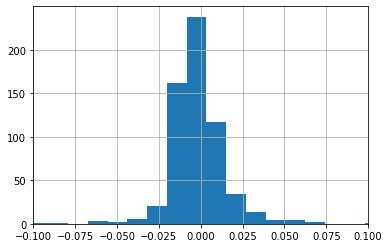

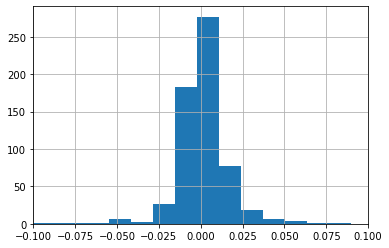


Idio Sharpe:
CVNA US    5.78
HIMS US    4.88
NVDA US    4.57
APP US     3.69
ALSN US    3.08
VRT US     3.01
QTWO US    2.96
MARA US    2.95
HWM US     2.89
ZETA US    2.53
AXP US     2.47
WAB US     2.36
BK US      2.28
SYF US     2.27
DVA US     2.17
SPOT US    2.08
RCL US     2.07
TT US      2.06
FIS US     2.05
URI US     2.00
GDDY US    2.00
PLTR US    1.99
CAT US     1.95
APH US     1.95
AVGO US    1.93
SG US      1.92
AXON US    1.90
CTAS US    1.89
RTX US     1.88
MSI US     1.85
PH US      1.81
SE US      1.80
BSX US     1.76
JPM US     1.73
GS US      1.71
TDG US     1.69
COST US    1.68
CBRE US    1.67
FISV US    1.63
MNDY US    1.61
LDOS US    1.60
GLW US     1.60
NFLX US    1.60
PWR US     1.57
WDC US     1.57
ISRG US    1.57
FITB US    1.57
TMUS US    1.56
NRG US     1.50
NVR US     1.48
dtype: float64


In [123]:
# STATISTICAL FACTOR MODEL

from sklearn.decomposition import PCA

def svd_decomp(X, VT):
    
    U, D, Vt = np.linalg.svd(X)
    pca = PCA(n_components = VT)
    XD = pca.fit_transform(X)
    PCAL = XD.shape[1]
    Vs = Vt.T[:, :PCAL]
    Us = U[:, :PCAL]
    
    return PCAL, Us, D[:PCAL], Vs

varTarget = 95
long_w = 1000
volCheck_w = 10
winsor_L = 0.010
winsor_H = 0.990
Pxs_df = open_df('prices_relation')
stocks = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Tickers_VA.csv")
all_tickers_l = stocks['tickers'].tolist()
try:  
    PCAIdioRets_df = open_df('pca_idio_returns')
except:
    pass

STdt_str = input('Enter Start Date (empty for update or YY/MM/DD): ')
try:
    st_date = datetime.strptime(STdt_str, "%y/%m/%d").date()
except:
    try:
        st_date = Pxs_df[Pxs_df.index > PCAIdioRets_df.index[-1]].index[0]
    except:
        st_date = Pxs_df.index[-1]
    
ENdt_str = input('Enter End Date (empty for last or YY/MM/DD): ')
try:
    end_date = datetime.strptime(ENdt_str, "%y/%m/%d").date()
except:
    end_date = Pxs_df.index[-1]  

st_date = Pxs_df[Pxs_df.index >= st_date].index[0]
ovr = False
oride = input('Override (Y/y or empty)? ').upper()
if (oride == 'Y'):
    ovr = True
        
dt_range = Pxs_df[Pxs_df.index >= st_date][Pxs_df[Pxs_df.index >= st_date].index <= end_date].index.tolist() 
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('0101')) == -1].tolist()
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('2512')) == -1].tolist()
dt_range = pd.Series(dt_range)[pd.Series(dt_range).map(lambda x: x.strftime('%d%m').find('0407')) == -1].tolist()
if (ovr):
    PCAIdioRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_tickers_l)
    PCAIdioRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_tickers_l)    
    PCAFRets_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(11))     
    asset_l = []
else:
    try:  
        PCAIdioRets_df = open_df('pca_idio_returns')
        PCAFRets_df = open_df('pca_factor_returns')
        asset_l = PCAIdioRets_df.columns.tolist()
    except:
        PCAIdioRets_df = pd.DataFrame(np.nan, index = dt_range, columns = all_tickers_l)    
        PCAFRets_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(11))        
        asset_l = []

save_file = True
dt_range = [dt for dt in dt_range if dt not in PCAIdioRets_df.dropna(how = 'all').index.tolist()] 
if (len(dt_range) == 0):
    save_file = False
    SPdt_str = input('Specific date (empty for last or YY/MM/DD): ')
    try:
        sp_date = datetime.strptime(SPdt_str, "%y/%m/%d").date()
    except:
        try:
            sp_date = Pxs_df[Pxs_df.index > PCAIdioRets_df.index[-1]].index[0]
        except:
            sp_date = Pxs_df.index[-1]         
    dt_range.append(sp_date)
    
for c_dt in dt_range:
    p_dt = Pxs_df.index[Pxs_df.index.tolist().index(c_dt) - 1]
    valid_start = False 
    pred_dt = c_dt
    while (not valid_start):
        pred_df, c_date = get_predictors(pred_dt, exclusion_l)
        exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
        exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
        if (len(exc_ffields) == 0):
            pred_df = pred_df.drop(exc_tickers)
            valid_start = True
            print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
        else:
            pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]
            
    sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ]
    Check_s = round(100 * sPxs_df[pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
    SBweights_s = winsorize(pred_df['Size'], winsor_L, winsor_H)     
    sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
    zeroVol_l = Check_s[Check_s == 0].index.tolist()
    excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
    pred_df = pred_df.drop(excall_l)
    asset_l = pred_df.index.tolist()
    sPxs_df = sPxs_df[asset_l]
    
    FlatWeights_s = pd.Series(1, index = pred_df.index)       
    sPCAIdioRets_df = PCAIdioRets_df[PCAIdioRets_df.index < c_dt].dropna(how = 'all')
    if (sPCAIdioRets_df.shape[0] >= (2 * hl)):
        print('idio var weights')
        var_s = sPCAIdioRets_df[-252:][asset_l].ewm(halflife = hl).var().iloc[-1]
        mean_var = var_s.mean()
        VBWeights_s = var_s.fillna(mean_var) ** (-1)
        VBWeights_s /= VBWeights_s.std()
        Weights_s = VBWeights_s[asset_l]        
    else:
        print('size weights')
        Weights_s = SBweights_s[asset_l].copy()
    w_s = Weights_s ** (1 / 2)   
    w_a = w_s.values

    RawAssetRets_s = Pxs_df[asset_l].loc[c_dt] / Pxs_df[asset_l].loc[p_dt] - 1    
    XSAssetRets = winsorize(RawAssetRets_s, winsor_L, winsor_H)

    sret_df = sPxs_df.pct_change()[-1 * hl:]
    c_varTarget = varTarget
    shrink_b = True
    while (shrink_b):
        orthB_n, eigenVeU_a, eigenVa_a, eigenVeV_a = svd_decomp(sret_df, c_varTarget / 100)
        if (orthB_n > (PCAFRets_df.shape[1] - 1)):
            c_varTarget -= 5
        else:
            shrink_b = False
    print(str(c_varTarget) + '% variance, ' + str(orthB_n) + ' factors')
    
    #TIME SERIES ESTIMATION OF STOCK LOADINGS TO PRINCIPAL COMPONENTS
    eigenVeV_a = np.insert(eigenVeV_a, 0, 1, axis = 1)
    sretBase_df = pd.DataFrame(eigenVeV_a, index = sret_df.columns, columns = np.arange(orthB_n + 1))    
    PCAFactLoadings_df = pd.DataFrame(eigenVeV_a, index = sret_df.columns)
    
    #CROSS SECTIONAL REGRESSION FOR ESTIMATION OF FACTOR AND IDIO RETURNS
    x_m = (eigenVeV_a.T * w_a).T
    y_a = (XSAssetRets.values * w_a)
    lrMod = LinearRegression(fit_intercept = False)
    lrMod_PCA = lrMod.fit(x_m, y_a)
    stockFRets_s = pd.Series(lrMod_PCA.predict(x_m) / w_a, index = XSAssetRets.index) 
    PCAFRets_df.loc[c_dt] = lrMod_PCA.coef_.tolist() + [0] * (PCAFRets_df.shape[1] - lrMod_PCA.coef_.shape[0])
    LRPCA_r2 = round(100 * stockFRets_s.corr(XSAssetRets) ** 2, 2)
    print(c_dt.strftime('%d%b%y') + ' LR r2: ' + str(LRPCA_r2))
    print('')

    PCAIdioRets_s = (RawAssetRets_s - stockFRets_s)
    PCAIdioRets_df.loc[c_dt, asset_l] = PCAIdioRets_s
    
    sretBase_df.to_sql('pca_loadings_' + c_dt.strftime('%y%m%d'), engine, index = True, if_exists = 'replace')
    if (len(dt_range) == 1):
        RawAssetRets_s.hist(bins = 30)
        plt.xlim([-0.1, 0.1])
        plt.show()
        PCAIdioRets_s.hist(bins = 30)
        plt.xlim([-0.1, 0.1])
        plt.show()
    
PCAIdioRets_df = PCAIdioRets_df.T.dropna(how = 'all').T
if (len(dt_range) > 0) & (save_file):
    if (len(dt_range) == 1) & (ovr):
        print('Not saving....')
    else:
        PCAIdioRets_df.sort_index().to_sql('pca_idio_returns', engine, index = True, if_exists = 'replace')
        PCAFRets_df.sort_index().to_sql('pca_factor_returns', engine, index = True, if_exists = 'replace')
        sPCAIdioRets_df = PCAIdioRets_df[-252:]
        idioSharpe_s = (round(((1 + sPCAIdioRets_df).expanding().apply(np.prod).iloc[-1] - 1) / 
                              (sPCAIdioRets_df.std() * np.sqrt(sPCAIdioRets_df.shape[0])), 2)).sort_values(ascending = False)    
        print('')
        print('Idio Sharpe:')
        print(idioSharpe_s[:50]) 

Enter Start Date (empty for 1st available or YY/MM/DD): 
Override portfolio (Y/y or empty)? 
25Oct24 - 25Oct24
Fundamentals date: 22-Oct-2024
25/Oct/2024-25/Oct/2024:
index
POWL US     5.56
LLY US      5.56
FSLR US     5.56
HOLX US     5.56
NEM US      5.56
NVDA US     5.56
FCX US      5.49
EXEL US     5.23
NFLX US     4.99
CRWD US     4.90
VEEV US     4.88
GOOGL US    4.87
TER US      4.77
CMG US      4.72
HALO US     4.68
ANET US     4.68
FLS US      4.46
DUOL US     4.45
ADBE US     4.32
ELF US      4.23
Name: Alloc, dtype: float64


Save portfolio files? (Y/y or empty) Y
[*********************100%***********************]  20 of 20 completed


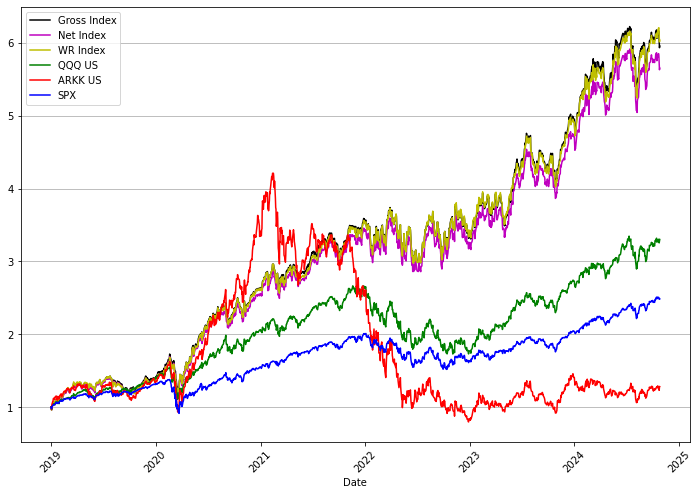


Average F Daily Turnover (%): 4.02
Total F Costs (%): 12.21
Average F Annual Costs (%): 2.03
Average WR Daily Turnover (%): 3.11
Total WR Costs (%): 9.45
Average WR Annual Costs (%): 1.57

25-Oct-2024 DAILY Summary - DR:
         CPort PPort Trade  P Al Daily  LD Ct  LC Pxs  RT Pxs   RT  RT Ct
POWL US   5.56  5.64 -0.08  5.56  1.84   0.10  254.31  254.31 -0.0   -0.0
LLY US    5.56  5.54  0.02  5.56  0.15   0.01   892.7   892.7  0.0    0.0
FSLR US   5.56   5.6 -0.04  5.56  1.24   0.07  198.47  198.47  0.0    0.0
HOLX US   5.56  5.53  0.03  5.56  -0.1  -0.01   80.83   80.83  0.0    0.0
NEM US    5.56  5.44  0.12  5.56 -1.69  -0.09   48.42   48.42 -0.0   -0.0
NVDA US   5.56  5.58 -0.02  5.56   0.8   0.04  141.54  141.54 -0.0   -0.0
FCX US    5.49  5.44  0.05  5.49 -0.51  -0.03    46.6    46.6 -0.0   -0.0
EXEL US   5.23  5.16  0.07  5.23 -0.85  -0.04   27.87   27.87  0.0    0.0
NFLX US   4.99  4.97  0.02  4.99  0.02   0.00  754.68  754.68 -0.0   -0.0
CRWD US    4.9  4.82  0.08   4.9 -1.26

WR Betas DR Betas DR-D0 P&L (bps) WR-D0 P&L (bps)
Ideal                        1.24     1.24            7.12            7.12
Market                        1.0      1.0            5.42            5.42
M2MP Velocity                0.53     0.53            1.28            1.28
Momentum                      0.4      0.4           -6.68           -6.68
Beta                         0.37     0.37           11.73           11.73
US10YR RR                    0.22     0.22            0.26            0.26
VIX                           0.2      0.2            -0.9            -0.9
Value                        0.11     0.11           -0.84           -0.84
Pharmaceuticals              0.09     0.09            0.33            0.33
USGG2YR                      0.05     0.05           -0.33           -0.33
Hardware                     0.04     0.04            0.23            0.23
Materials                    0.03     0.03            0.18            0.18
Energy                       -0.0     -0.0            -0.0            -0.0
Electrical & Electronics    -0.01    -0.01            0.23            0.23
Insurers                    -0.01    -0.01           -0.15           -0.15
Health Care                 -0.02    -0.02            -0.0            -0.0
Application Software        -0.02    -0.02            -0.5            -0.5
Consumer Services           -0.02    -0.02           -0.24           -0.24
REITs                       -0.02    -0.02           -0.33           -0.33
Staples                     -0.03    -0.03           -0.99           -0.99
Fintech                     -0.05    -0.05             0.0             0.0
Industrials                 -0.05    -0.05            2.44            2.44
Utilities                   -0.05    -0.05           -1.06           -1.06
Data Software               -0.06    -0.06           -2.19           -2.19
Financial Services          -0.08    -0.08           -1.42           -1.42
Consumer Discretionary      -0.11    -0.11            -1.2            -1.2
Vol                         -0.13    -0.13            1.76            1.76
Brent USD/Bbl                -0.2    -0.21             4.1             3.9
2Y IR Vol                   -0.22    -0.22            0.63            0.63
T10YIE                      -0.25    -0.24           -1.56           -1.62
Size                        -0.45    -0.45           -7.96           -7.96
Total                                                 9.35            9.09

In [124]:
# SIMPLE CUSTOM ALGO

def get_predictors(c_date, exclusion_l):
    
    rel_found = False
    count = 0
    attempts_cap = 30
    while (not rel_found) & (count < attempts_cap):
        try:
            pred_df = open_df('valuation_' + c_date.strftime('%Y%m%d') + selection_scope)
            rel_found = True            
        except:
            c_date = c_date - timedelta(1)
            c_date = c_date - timedelta((c_date.weekday() % 4) * (c_date.weekday() // 4))
            count += 1
    
    pred_df = pred_df.dropna(thresh = pred_df.shape[1] // 2)
    pred_df['P/Ee'][pred_df['P/Ee'] <= 0] = 100
    pred_df['P/Eo'][pred_df['P/Eo'] <= 0] = 100
    pred_df['P/S'][pred_df['P/S'] <= 0] = 100  
    exclusion_l = [t for t in exclusion_l if t in pred_df.index]
    pred_df = pred_df.drop(exclusion_l)
    
    return pred_df, c_date

def select_port(pred_df):
    
    field_l = ['GS', 'GGP', 'GE', 'G', 'G Vol', 'G r2', 'E Vol', 'S Vol', 'OM', 'OMp', 'ROIp', 'ROIdp', 'Alloc']
    sc_df = pd.DataFrame(np.nan, index = pred_df.index, columns = field_l)
    sc_df['GS'] = pred_df['GS']
    sc_df['GGP'] = pred_df['GGP']
    sc_df['GE'] = pred_df['GE']
    sc_df['G'] = pred_df[['GE','GGP', 'GS']].min(axis = 1)
    sc_df['G Vol'] = pred_df[['GE','GGP', 'GS']].std(axis = 1)
    sc_df['G r2'] = pred_df[['r2 S', 'r2 GP', 'r2 E']].mean(axis = 1)
    sc_df['E Vol'] = pred_df['E Vol'].map(lambda x: max(1, x / 100))
    sc_df['S Vol'] = pred_df['S Vol'].map(lambda x: max(1, x / 100))
    sc_df['OM'] = pred_df['OM-t0'].map(lambda x: min(x, 60))
    sc_df['OMp'] = pred_df['OMd'].map(lambda x: min(x, 0))
    sc_df['ROIp'] = pred_df['ROI-P'].map(lambda x: min(x, 0))
    sc_df['ROIdp'] = pred_df['ROId'].map(lambda x: min(x, 0))
    sc_df['G r2'] = sc_df['G r2'].replace({-np.inf: 1})

    port_s = (25 * sc_df['G'] * (sc_df['G r2'] ** 5) / sc_df['E Vol'] / sc_df['S Vol'] + 
              5 * sc_df['OM'] + 50 * sc_df['OMp'] + 50 * sc_df['ROIp'] + 50 * sc_df['ROIdp'])    
    
    return port_s

Pxs_df = open_df('prices_relation')
Pxs_df = Pxs_df.sort_index()
st_dt = datetime(2019, 1, 1).date()
st_dt = Pxs_df[Pxs_df.index >= st_dt].index[0]
end_dt = Pxs_df.index[-1]
hl = 126
port_size = 20
feature_l = ['GE','GGP', 'GS', 'r2 S', 'r2 GP', 'r2 E', 'E Vol', 'S Vol', 'OM-t0', 'OMd', 'ROI-P', 'ROId']

STdt_str = input('Enter Start Date (empty for 1st available or YY/MM/DD): ')
firstS_dt = False
try:
    st_date = datetime.strptime(STdt_str, "%y/%m/%d").date()
except:
    st_date = Pxs_df.index[-1]
    firstS_dt = True
end_date = Pxs_df.index[-1]


st_date = Pxs_df[Pxs_df.index >= st_date].index[0]
try:
    selectionN_df = open_df('ideal_stock_selection')
    selectionA_df = open_df('ideal_stock_allocations')
    if (firstS_dt):
        st_date = selectionN_df.index[0]
    oss = input('Override portfolio (Y/y or empty)? ').upper()
    if (oss == 'Y'):
        selectionN_df = pd.DataFrame(np.nan, index = [st_date], columns = np.arange(port_size) + 1)
        selectionA_df = pd.DataFrame(np.nan, index = [st_date], columns = np.arange(port_size) + 1)         
except:
    selectionN_df = pd.DataFrame(np.nan, index = [st_date], columns = np.arange(port_size) + 1)
    selectionA_df = pd.DataFrame(np.nan, index = [st_date], columns = np.arange(port_size) + 1)  

Index_s = pd.Series(1, index = [st_date])
Index_s.name = 'Idio'

period_st = st_date
if (selectionN_df.dropna(how = 'all').shape[0] > 0):
    period_st = Pxs_df[Pxs_df.index >= selectionN_df.dropna(how = 'all').index[-1]].index[0]
    
keep_loop = True
while (keep_loop):       
#   period_end = datetime(period_st.year + (period_st.month // 12), (period_st.month % 12) + 1, period_st.day).date()
    period_end = period_st + timedelta(1)
    period_end = min(period_end, end_dt)
    period_end = Pxs_df[Pxs_df.index >= period_end].index[0]    
    if (period_st not in selectionN_df.dropna(how = 'all').index):
        print(period_st.strftime('%d%b%y') + ' - ' + period_end.strftime('%d%b%y'))
        valid_start = False
        pred_dt = period_st
        while (not valid_start):
            pred_df, c_date = get_predictors(pred_dt, exclusion_l)
            exc_ffields = [f for f in feature_l if f not in pred_df.columns]
            if (len(exc_ffields) == 0):
                valid_start = True
                print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
            else:
                pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]        

        pred_df = fix_na(pred_df, 'GS', 'GE')

        valid_t = [t for t in pred_df.index if t in Pxs_df.columns]
        pred_df = pred_df.loc[valid_t]    
        port_s = select_port(pred_df)
        port_s.name = 'Alloc'

        conservative_df = pd.DataFrame(winsorize(port_s, 0.025, 0.99).dropna().sort_values(ascending = False)[:20]) 
        conservative_df /= conservative_df.sum()
        conservative_df['Period P&L'] = conservative_df.index.map(lambda x: round(100 * (Pxs_df.loc[period_end, x] / Pxs_df.loc[period_st, x] - 1), 2))

        print(period_st.strftime('%d/%b/%Y') + '-' + period_end.strftime('%d/%b/%Y') + ':')
        print(round(100 * conservative_df['Alloc'], 2))
        print('')

        selectionN_df.loc[period_st] = conservative_df.index.values
        selectionA_df.loc[period_st] = conservative_df['Alloc'].values 

    if (period_st == end_date):
        keep_loop = False
    period_st = period_end
    
print('')
save_p = input('Save portfolio files? (Y/y or empty) ').upper()
if (save_p == 'Y'):
    selectionN_df.to_sql('ideal_stock_selection', engine, index = True, if_exists = 'replace')
    selectionA_df.to_sql('ideal_stock_allocations', engine, index = True, if_exists = 'replace')

perfSummary_df, DRtrade_df, WRtrade_df = rebalancing(selectionN_df, selectionA_df)

qqq_s = Pxs_df[Pxs_df.index >= selectionN_df.index[0]]['QQQ US']
qqq_s /= qqq_s.iloc[0]
spx_s = Pxs_df[Pxs_df.index >= selectionN_df.index[0]]['SPX']
spx_s /= spx_s.iloc[0]
arkk_s = Pxs_df[Pxs_df.index >= selectionN_df.index[0]]['ARKK US']
arkk_s /= arkk_s.iloc[0]    
    
perfSummary_df['Gross Index'].plot(figsize = (12, 8), c = 'k')
perfSummary_df['Net Index'].plot(c = 'm')
perfSummary_df['WR Index'].plot(c = 'y')
(qqq_s / qqq_s.iloc[0]).plot(c = 'g')
(arkk_s / arkk_s.iloc[0]).plot(c = 'r')
(spx_s / spx_s.iloc[0]).plot(c = 'b').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()   

avg_turnover = round(perfSummary_df['Port Turnover (%)'].mean(), 2)
ttl_costs = round(perfSummary_df['TCost (%)'].sum(), 2)
wr_avg_turnover = round(perfSummary_df['WR PT (%)'].mean(), 2)
wr_ttl_costs = round(perfSummary_df['WR TC (%)'].sum(), 2)
print('')
print('Average F Daily Turnover (%): ' + str(avg_turnover))
print('Total F Costs (%): ' + str(ttl_costs))
print('Average F Annual Costs (%): ' + str(round(252 * ttl_costs / perfSummary_df.shape[0], 2)))
print('Average WR Daily Turnover (%): ' + str(wr_avg_turnover))
print('Total WR Costs (%): ' + str(wr_ttl_costs))
print('Average WR Annual Costs (%): ' + str(round(252 * wr_ttl_costs / perfSummary_df.shape[0], 2)))
print('')
print(period_st.strftime('%d-%b-%Y') + ' DAILY Summary - DR:')
print(DRtrade_df)
print('')
print(period_st.strftime('%d-%b-%Y') + ' DAILY Summary - WR:')
print(WRtrade_df)
print('')
print(period_st.strftime('%d-%b-%Y') + ' DRG Daily P&L: ' + 
      str(round(100 * (perfSummary_df['Gross Index'].iloc[-1] / perfSummary_df['Gross Index'].iloc[-2] - 1), 2)))
print(period_st.strftime('%d-%b-%Y') + ' DRN Daily P&L: ' + 
      str(round(100 * (perfSummary_df['Net Index'].iloc[-1] / perfSummary_df['Net Index'].iloc[-2] - 1), 2)))
print(period_st.strftime('%d-%b-%Y') + ' WR Daily P&L: ' + 
      str(round(100 * (perfSummary_df['WR Index'].iloc[-1] / perfSummary_df['WR Index'].iloc[-2] - 1), 2)))
print(period_st.strftime('%d-%b-%Y') + ' SPX Daily P&L: ' + str(round(100 * (spx_s.iloc[-1] / spx_s.iloc[-2] - 1), 2)))
print(period_st.strftime('%d-%b-%Y') + ' QQQ Daily P&L: ' + str(round(100 * (qqq_s.iloc[-1] / qqq_s.iloc[-2] - 1), 2)))
print(period_st.strftime('%d-%b-%Y') + ' ARKK Daily P&L: ' + str(round(100 * (arkk_s.iloc[-1] / arkk_s.iloc[-2] - 1), 2)))
print('')

SummaryP_df = perfSummary_df[['Gross Index', 'Net Index', 'WR Index']].join(qqq_s).join(spx_s).join(arkk_s)
annual_reports(SummaryP_df, 'SPX')

Check_s = round(100 * Pxs_df[-long_w:][pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
SBweights_s = np.log(pred_df['Size'])
sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
zeroVol_l = Check_s[Check_s == 0].index.tolist()
excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
pred_df = pred_df.drop(excall_l)
asset_l = pred_df.index.tolist()
FlatWeights_s = pd.Series(1, index = pred_df.index)

MacroPxs_df = Pxs_df[Pxs_df.index < c_dt][macroFeatures_l][-long_w: ]
sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ][asset_l]

featuresP_df = predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s)
featuresC_df = predictors_to_Cfeatures(pred_df, c_features_l, sector_s)
featuresM_df, MacroFeatures_df = predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s)
XSStyleLoadings_df = featuresP_df.join(featuresC_df)

# FACTOR ORTHOGONALIZATION

sBetas_s = featuresP_df['Beta']
FactorLoadings_df = pd.DataFrame(sBetas_s)

sIdeal_s = featuresC_df['Ideal']
FactorLoadings_df[sIdeal_s.name] = othogonalize(FactorLoadings_df, sIdeal_s)    

XSSectorLoadings_df = pd.DataFrame(0, index = asset_l, columns = sector_l)
for c_sector in sector_l:
    stock_l = [t for t in asset_l if t in sector_s[sector_s == c_sector].index]
    XSSectorLoadings_df.loc[stock_l, c_sector] = 1   
XSSectorLoadings_df = (XSSectorLoadings_df - XSSectorLoadings_df.mean())
sectorR_l = sector_l.copy()
sectorR_l.remove(sacr_sector)
for c_sector in sectorR_l:
    FactorLoadings_df[c_sector] = othogonalize(FactorLoadings_df, XSSectorLoadings_df[c_sector]).values        

sSize_s = featuresC_df['Size']
FactorLoadings_df[sSize_s.name] = othogonalize(FactorLoadings_df, sSize_s)

for c_Sfeat in XSStyleLoadings_df.columns:
    if (c_Sfeat not in FactorLoadings_df.columns):
        FactorLoadings_df[c_Sfeat] = othogonalize(FactorLoadings_df, XSStyleLoadings_df[c_Sfeat]).values

for c_Mfeat in m_features_l:
    FactorLoadings_df[c_Mfeat] = othogonalize(FactorLoadings_df, featuresM_df[c_Mfeat]).values

FactorLoadings_df['Market'] = 1
FactorLoadings_df[sacr_sector] = XSSectorLoadings_df[sacr_sector]
ALLfeatures_df = FactorLoadings_df.copy()

DRbetas_s = (ALLfeatures_df.loc[DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1].index].T * 
             DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'] / 
             DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'].sum()).T.sum().sort_values(ascending = False).map(lambda x: round(x, 2))

WRbetas_s = (ALLfeatures_df.loc[WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1].index].T * 
             WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'] / 
             WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'].sum()).T.sum().sort_values(ascending = False).map(lambda x: round(x, 2))

All_df = pd.DataFrame(WRbetas_s.values, index = WRbetas_s.index, columns = ['WR Betas'])
All_df['DR Betas'] = DRbetas_s
All_df['DR-D0 P&L (bps)'] = round(10000 * DRbetas_s * FactRets_df.iloc[-1], 2)
All_df['WR-D0 P&L (bps)'] = round(10000 * WRbetas_s * FactRets_df.iloc[-1], 2)
All_df.loc['Total'] = ''
All_df.loc['Total', 'DR-D0 P&L (bps)'] = round(10000 * (DRbetas_s * FactRets_df.iloc[-1]).sum(), 2)
All_df.loc['Total', 'WR-D0 P&L (bps)'] = round(10000 * (WRbetas_s * FactRets_df.iloc[-1]).sum(), 2)

DRIdio = round(DRtrade_df.loc['Total', 'LD Ct'] * 100 - All_df.loc['Total', 'DR-D0 P&L (bps)'], 2)
WRIdio = round(WRtrade_df.loc['Total', 'LD Ct'] * 100 - All_df.loc['Total', 'WR-D0 P&L (bps)'], 2)
print('')
print('DR Idio ' + period_st.strftime('%d-%b-%y') + ': ' + str(DRIdio))
print('WR Idio ' + period_st.strftime('%d-%b-%y') + ': ' + str(WRIdio))
print('')
All_df

Custom Sector 5

Enter Start Date (empty for 1st available or YY/MM/DD): 
Enter End Date (empty for last or YY/MM/DD): 
Override portfolio (Y/y or empty)? 
25-Oct-24
Fundamentals date: 22-Oct-2024
PCA dt: 25-Oct-2024
   IdM w  IdP w  Alpha    Vol  BetaP   MomP    uS    uF    uP   uLW    UA
1    1.0    0.5   4.19  20.08  24.85  26.78  0.74  0.80  0.89  0.79  1.55
2    1.0    1.5   4.36  20.03  25.59  27.84  0.67  0.73  0.82  0.72  1.41
3    1.0    2.5   4.51  19.98  25.53  28.17  0.69  0.75  0.84  0.74  1.45
4    3.0    0.5   4.51  20.15  25.46  27.79  0.71  0.77  0.86  0.76  1.49
5    3.0    1.5   4.62  20.12  25.17  27.84  0.76  0.82  0.92  0.81  1.59
6    3.0    2.5   4.71  20.00  24.68  27.76  0.83  0.90  0.99  0.88  1.73
7    5.0    0.5   4.69  20.24  24.77  27.38  0.83  0.90  0.99  0.88  1.73
8    5.0    1.5   4.75  20.03  24.24  27.12  0.91  0.98  1.07  0.96  1.89
9    5.0    2.5   4.78  19.90  23.46  26.72  1.02  1.08  1.17  1.06  2.10

          Ideal   Mom  IdMLR  IdPCA    Sum

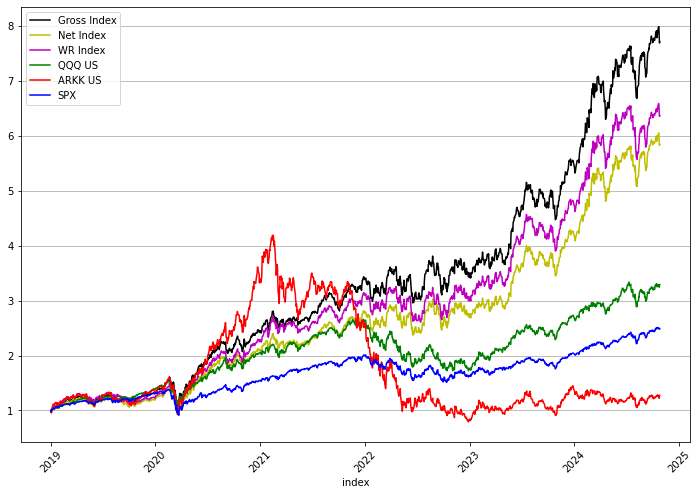

Performances:
            Gross Index  Net Index  WR Index  QQQ US    SPX  ARKK US
index                                                               
2019-12-31        30.69      19.16     23.13   38.41  31.09    33.75
2020-12-31        87.80      77.09     85.84   48.41  18.33   148.73
2021-12-31        37.79      31.40     35.34   27.42  28.73   -24.02
2022-12-31         3.49      -0.59     -1.12  -32.58 -18.18   -66.97
2023-12-31        57.39      53.55     56.22   54.03  24.76    67.64
2024-12-31        39.82      37.86     33.02   20.95  21.82    -8.97


Volatilities:
            Gross Index  Net Index  WR Index  QQQ US    SPX  ARKK US
index                                                               
2019-12-31        22.61      22.53     22.50   18.41  13.93    29.59
2020-12-31        35.62      35.61     35.72   30.78  28.78    42.31
2021-12-31        24.66      24.64     24.98   22.47  18.05    40.34
2022-12-31        26.39      26.36     26.28   27.29  20.43    57.77
2023

WR Betas DR Betas DR-D0 P&L (bps) WR-D0 P&L (bps)
Ideal                        1.22     1.21            2.08             2.1
Market                        1.0      1.0          -22.78          -22.78
Beta                         0.57     0.63           33.42           30.24
Momentum                     0.57     0.63           -0.69           -0.62
M2MP Velocity                0.35     0.29           -3.57           -4.31
USGG2YR                      0.28     0.07           -1.57           -6.29
Value                        0.25     0.21           -0.94           -1.11
Pharmaceuticals              0.07     0.09            0.63            0.49
Application Software         0.03     0.03            0.49            0.49
Materials                    0.03     0.02            0.06            0.09
Hardware                     0.01     0.01            0.16            0.16
Energy                      -0.01     -0.0            -0.0            -0.5
Industrials                 -0.01     0.01            0.11           -0.11
Insurers                    -0.02    -0.01           -0.23           -0.45
Health Care                 -0.02    -0.02            -0.0            -0.0
REITs                       -0.02    -0.02            0.19            0.19
Electrical & Electronics    -0.02    -0.02           -0.22           -0.22
Staples                     -0.03    -0.03           -0.68           -0.68
Utilities                   -0.04    -0.04            1.63            1.63
Fintech                     -0.05    -0.05            0.61            0.61
Data Software               -0.05    -0.05           -1.02           -1.02
Consumer Services           -0.06    -0.08           -2.27            -1.7
2Y IR Vol                   -0.06     0.02            0.27           -0.82
Financial Services          -0.08    -0.07            3.12            3.56
T10YIE                       -0.1    -0.19            0.11            0.06
Consumer Discretionary      -0.11    -0.11           -1.23           -1.23
US10YR RR                   -0.13     0.11            0.57           -0.67
Vol                         -0.23     -0.2            0.69            0.79
Brent USD/Bbl               -0.29    -0.22            3.99            5.26
VIX                         -0.34    -0.33           -3.43           -3.53
Size                        -0.62    -0.51           -0.44           -0.53
Total                                                 9.07           -0.93

In [125]:
# PORTFOLIO CONSTRUCTION W/ NAIVE INCREMENTAL MVO AND ESTIMATED ALPHAS, GENERAL AND X-SECTIONAL - NEW VAL ADJ

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.linear_model import Ridge
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import optimize 
from scipy.optimize import linprog
import warnings


def annual_reports(SummaryP_df, anchor):
        
    SummaryP_df.index = SummaryP_df.index.map(lambda x: datetime(x.year, x.month, x.day))
    SummaryPY_df = SummaryP_df.resample('Y').last()
    SummaryPY_df.loc[SummaryP_df.index[0]] = 1
    SummaryPY_df = SummaryPY_df.sort_index()
    SummaryPY_df = round(100 * SummaryPY_df.pct_change(), 2).dropna()
    print('Performances:')
    print(SummaryPY_df)
    print('')

    SummaryV_df = round(100 * SummaryP_df.pct_change().ewm(halflife = 84).std() * np.sqrt(252), 2).dropna()
    SummaryVY_df = round(SummaryV_df.resample('Y').mean(), 2)
    print('')
    print('Volatilities:')
    print(SummaryVY_df)
    print('')

    SummaryD_df = round(100 * (SummaryP_df / SummaryP_df.rolling(252, min_periods = 21).max() - 1), 2).dropna()
    SummaryDY_df = SummaryD_df.resample('Y').min()
    print('')
    print('Drawdowns:')
    print(SummaryDY_df)
    print('')

    SummaryC_df = round(100 * ((SummaryP_df[1: ].T ** (252 / SummaryP_df[1:].index.map(lambda x: (x - SummaryP_df.index[0]).days).values)).T - 1), 2)
    SummaryCY_df = SummaryC_df.resample('Y').last()
    print('')
    print('CAGR:')
    print(SummaryCY_df)
    print('')

    SummaryCDY_df = round(SummaryCY_df / abs(SummaryDY_df), 2)
    print('')
    print('CAGR/DD:')
    print(SummaryCDY_df)
    print('')

    SummarySY_df = round(SummaryPY_df / abs(SummaryVY_df), 2)
    print('')
    print('Sharpe:')
    print(SummarySY_df)
    print('')

    SummaryCorr_df = SummaryP_df.rolling(252).corr(SummaryP_df[anchor].rolling(252))
    SummaryCorrY_df = SummaryCorr_df.resample('Y').mean()
    SummaryBY_df = round(SummaryCorrY_df * (SummaryVY_df.T / SummaryVY_df[anchor]).T, 2)
    print('')
    print('Betas ' + anchor + ':')
    print(SummaryBY_df)
    print('')

    SummaryAY_df = round(SummaryPY_df - (SummaryBY_df.T * SummaryPY_df[anchor]).T, 2)
    print('')
    print('Alphas ' + anchor + ':')
    print(SummaryAY_df)    
                
    return

def predictors_to_Cfeatures(pred_df, c_features_l, sector_s):
    
    exp_g = 10
    m_omd = 5
    IDwinsor_L = 0.025
    IDwinsor_H = 0.990
    winsor_L = 0.01
    Vwinsor_H = 0.90
    IQuant = 10
    field_l = ['GS', 'GGP', 'GE', 'G', 'G Vol', 'G r2', 'E Vol', 'S Vol', 'OM', 'OMp', 'ROIp', 'ROIdp', 'Alloc']    
    sc_df = pd.DataFrame(np.nan, index = pred_df.index, columns = field_l)

    pred_df['P/Ee'][pred_df['P/Ee'] < 0] = abs(pred_df['P/Ee'][pred_df['P/Ee'] < 0]) * 100
    pred_df['P/Eo'][pred_df['P/Eo'] < 0] = abs(pred_df['P/Eo'][pred_df['P/Eo'] < 0]) * 100
    pred_df['P/GP'][pred_df['P/GP'] < 0] = abs(pred_df['P/GP'][pred_df['P/GP'] < 0]) * 100
    pred_df['P/S'][pred_df['P/S'] < 0] = abs(pred_df['P/S'][pred_df['P/S'] < 0]) * 100
    pred_df['sP/E'][pred_df['sP/E'] < 0] = abs(pred_df['sP/E'][pred_df['sP/E'] < 0]) * 100
    pred_df['sP/S'][pred_df['sP/S'] < 0] = abs(pred_df['sP/S'][pred_df['sP/S'] < 0]) * 100
    pred_df['sP/GP'][pred_df['sP/GP'] < 0] = abs(pred_df['sP/GP'][pred_df['sP/GP'] < 0]) * 100
    pred_df = fix_na(pred_df, 'r2 S', 'r2 GP')
    pred_df = fix_na(pred_df, 'GS', 'GGP')
    aux_df = pred_df[['sP/S', 'sP/GP']]
    ratio = aux_df.median()['sP/GP'] / aux_df.median()['sP/S']
    aux_df['sP/S'] *= ratio
    aux_df = aux_df.T.fillna(method = 'ffill').T
    pred_df['sP/GP'] = aux_df['sP/GP']

    featuresC_df = pd.DataFrame(np.nan, index = pred_df.index, columns = c_features_l)

    sc_df['GS'] = pred_df['GS']
    sc_df['GGP'] = pred_df['GGP']
    sc_df['GE'] = pred_df['GE']
    sc_df['G'] = pred_df[['GE','GGP', 'GS']].min(axis = 1)
    sc_df['G Vol'] = pred_df[['GE','GGP', 'GS']].std(axis = 1)
    sc_df['G r2'] = pred_df[['r2 S', 'r2 GP', 'r2 E']].mean(axis = 1)
    sc_df['E Vol'] = pred_df['E Vol'].map(lambda x: max(1, x / 100))
    sc_df['S Vol'] = pred_df['S Vol'].map(lambda x: max(1, x / 100))
    sc_df['OM'] = pred_df['OM-t0'].map(lambda x: min(x, 60))
    sc_df['OMp'] = pred_df['OMd'].map(lambda x: min(x, 0))
    sc_df['ROIp'] = pred_df['ROI-P'].map(lambda x: min(x, 0))
    sc_df['ROIdp'] = pred_df['ROId'].map(lambda x: min(x, 0))
    sc_df['G r2'] = sc_df['G r2'].replace({-np.inf: 1})
    sc_df['Alloc'] = (25 * sc_df['G'] * (sc_df['G r2'] ** 5) / sc_df['E Vol'] / sc_df['S Vol'] + 
                      5 * sc_df['OM'] + 50 * sc_df['OMp'] + 50 * sc_df['ROIp'] + 50 * sc_df['ROIdp'])
    
    featuresC_df['Ideal'] = winsorize(sc_df['Alloc'], IDwinsor_L, IDwinsor_H)

    Value_s = (3 * pred_df['sP/E'] + pred_df['sP/GP']) / 4
    featuresC_df['Value'] = -winsorize(Value_s, winsor_L, Vwinsor_H) 
    featuresC_df['Size'] = -pd.Series(np.log(pred_df['Size']), index = pred_df.index)

    featuresC_df -= featuresC_df.mean()
    featuresC_df /= featuresC_df.std()
    featuresC_df = featuresC_df.fillna(0)
    
    return featuresC_df

def predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s):
        
    MacroPxs_df['US10YR RR'] = MacroPxs_df['USGG10YR'] - MacroPxs_df['T10YIE']
    MacroPxs_df['YC'] = MacroPxs_df['USGG10YR'] - MacroPxs_df['USGG2YR']
    MacroPxs_df['2Y IR Vol'] = MacroPxs_df['USGG2YR'].ewm(halflife = hl).std() * np.sqrt(252)
    MacroPxs_df = MacroPxs_df.loc[sPxs_df.index]
    MacroPxs_df = (MacroPxs_df - MacroPxs_df.ewm(halflife = hl).mean())
    MacroPxs_df = MacroPxs_df.pct_change()

    MacroFactor_df = pd.DataFrame(np.nan, index = sPxs_df.columns, columns = m_features_l)
    for c_mf in m_features_l:
        c_mf_s = sPxs_df.pct_change().join(MacroPxs_df[c_mf])[-hl:].cov()[c_mf].drop(c_mf)    
        featVar_s = MacroPxs_df[c_mf].ewm(halflife = hl).var().iloc[-1]
        MacroFactor_df[c_mf] = c_mf_s / featVar_s

    for c_feat in m_features_l:
        MacroFactor_df[c_feat] = winsorize(MacroFactor_df[c_feat], winsor_L, winsor_H).values

    naT_l = MacroFactor_df.isna().sum(axis = 1)[MacroFactor_df.isna().sum(axis = 1) > 0].index
    naF_l = MacroFactor_df.loc[naT_l].T[MacroFactor_df.loc[naT_l].T.isna()].index.tolist()  
    MacroFactor_df.loc[naT_l, naF_l] = MacroFactor_df.median().values
    MacroFactor_df -= MacroFactor_df.mean()
    MacroFactor_df /= MacroFactor_df.std()

    return MacroFactor_df, MacroPxs_df[m_features_l]

def predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s):

    lag_M1 = -252
    lag_M3 = -21
    beta_adj = True

    featuresP_df = pd.DataFrame(np.nan, index = sPxs_df.columns, columns = p_features_l)
    sRetPxs_df = sPxs_df.pct_change().dropna()
    sRetMkt_s = sMkt_s.pct_change().dropna()    
    sCovPxs_s = sRetPxs_df.ewm(halflife = hl).cov(sRetMkt_s.ewm(halflife = hl)).iloc[-1]
    sVarMkt = sRetMkt_s.ewm(halflife = hl).cov(sRetMkt_s.ewm(halflife = hl)).iloc[-1]
    featuresP_df['Beta'] = winsorize(sCovPxs_s / sVarMkt, 0, winsor_H)
    featuresP_df['Vol'] = -winsorize(sRetPxs_df.ewm(halflife = hl).std().iloc[-1], 0, winsor_H)
    Mom_s = pd.Series((featuresP_df.index.map(lambda x: sPxs_df[x].iloc[lag_M3]) / 
                       featuresP_df.index.map(lambda x: sPxs_df[x].iloc[lag_M1])), index = featuresP_df.index)
    featuresP_df['Momentum'] = winsorize(Mom_s, winsor_L, winsor_H)

    featuresP_df -= featuresP_df.mean()
    featuresP_df /= featuresP_df.std()
    
    return featuresP_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df 

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def fix_na(base_df, col_b, col_t):

    aux = base_df[[col_b, col_t]]
    aux = aux.T.fillna(method = 'ffill').T
    base_df[col_t] = aux[col_t]
    
    return base_df

def winsorize(Rt_s, floor, cap):
    
    w_up = np.quantile(Rt_s.dropna().values, q = cap)
    w_down = np.quantile(Rt_s.dropna().values, q = floor)    
    w_s = Rt_s.clip(w_down, w_up)
    
    return w_s

def get_predictors(c_date, exclusion_l):
    
    rel_found = False
    count = 0
    attempts_cap = 30
    while (not rel_found) & (count < attempts_cap):
        try:
            pred_df = open_df('valuation_' + c_date.strftime('%Y%m%d') + selection_scope)
            rel_found = True            
        except:
            c_date = c_date - timedelta(1)
            c_date = c_date - timedelta((c_date.weekday() % 4) * (c_date.weekday() // 4))
            count += 1
    
    pred_df = pred_df.dropna(thresh = pred_df.shape[1] // 2)
    pred_df['P/Ee'][pred_df['P/Ee'] <= 0] = 100
    pred_df['P/Eo'][pred_df['P/Eo'] <= 0] = 100
    pred_df['P/S'][pred_df['P/S'] <= 0] = 100  
    exclusion_l = [t for t in exclusion_l if t in pred_df.index]
    pred_df = pred_df.drop(exclusion_l)
    
    return pred_df, c_date

def loadings(ret_s, res_s):
    
    Pbeta = 0
    PZ = 0      
    if (res_s.std() != 0):
        Pbeta = round(res_s.cov(ret_s) / (res_s.std() ** 2), 3)
        if (ret_s.std() != 0):        
            PZ = round(abs(Pbeta) / ((ret_s.std() ** 2) / (res_s.std() ** 2)), 3)
    
    return Pbeta, PZ

def mlr(ALLfeatures_df):
    
    model = LinearRegression()
    lr_mod = model.fit(ALLfeatures_df[all_features_l].values, ALLfeatures_df['Rt'].values)
    lr_values = lr_mod.predict(ALLfeatures_df[all_features_l].values)
    fRet_s = round(pd.Series(lr_mod.coef_, index = all_features_l), 3)
    fRet_s.name = 'MLR Factor Rets'
    fcast_s = pd.Series(lr_values, index = ALLfeatures_df.index)
    fcast_s.name = 'Ret Fcast'   
    y0 = lr_mod.intercept_
    mlr_r2 = round(100 * lr_mod.score(ALLfeatures_df[all_features_l].values, ALLfeatures_df['Rt'].values), 2)
    
    return fcast_s, fRet_s, y0, mlr_r2

def w_mlr(x_m, y_a, w_a, idx_l, c_l, itcp):
    
    model = LinearRegression(fit_intercept = itcp)
    lr_mod = model.fit(x_m, y_a, w_a)
    lr_values = lr_mod.predict(x_m)
    fRet_s = pd.Series(lr_mod.coef_, index = c_l)    
    fcast_s = pd.Series(lr_values, index = idx_l)
    fRet_s.name = 'wMLR Factor Rets'
    fcast_s.name = 'wMLR Ret Fcast'   
    y0 = lr_mod.intercept_
    mlr_r2 = round(100 * lr_mod.score(x_m, y_a, w_a), 2)
    
    return fcast_s, fRet_s, y0, mlr_r2

def ridge(x_m, y_a, idx_l, c_l):
    
    xv_n = 10
    ridge_n = 30
    step = 3  
    lambda_penalty = 10
    
    lambda_array = np.arange(ridge_n)
    lambda_array = lambda_array[::step]
    x_df = pd.DataFrame(x_m.T)
    y_df = pd.DataFrame(y_a.T)

    cv_mse_df = pd.DataFrame(np.nan, index = lambda_array, columns = ['Train', 'Val'])
    beta_df = pd.DataFrame(np.nan, index = lambda_array, columns = np.arange(x_df.shape[1]).tolist() + ['df'])
    val_r2 = np.inf
    shift_lambda = False
    for c_lambda in lambda_array:
        if (shift_lambda):
            c_lambda += lambda_penalty
        try:        
            Rmodel = Ridge(alpha = c_lambda, normalize = False, tol = 0.001, solver = 'auto', random_state = 42)
            valRMSE_tot = 0
            trainRMSE_tot = 0
            for c in np.arange(xv_n):
                init_v = xv_n * c
                end_v = init_v + xv_n
                valX_df = x_df.iloc[init_v: end_v]
                valY_df = y_df.iloc[init_v: end_v]
                trainX_df = x_df.drop(valX_df.index)
                trainY_df = y_df.drop(valX_df.index)

                I_m = np.identity(trainX_df.shape[1])
                lambda_matrix = I_m * np.array([c_lambda] * trainX_df.shape[1])
                beta_array = np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix).dot(trainX_df.T.values.dot(trainY_df.values))
                hat_matrix = (trainX_df.values).dot(np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix)).dot(trainX_df.T.values)        

                if (c == 0):
                    edf = np.trace(hat_matrix)
                    beta_df.loc[c_lambda] = pd.DataFrame(beta_array)[0].tolist() + [edf]

                ridge_mod = Rmodel.fit(trainX_df.values, trainY_df.values)
                trainRidge_f = ridge_mod.predict(trainX_df.values)
                valRidge_f = ridge_mod.predict(valX_df.values)
                trainRidge_mse = np.sum((trainY_df.values - trainRidge_f) ** 2)
                valRidge_mse = np.sum((valY_df.values - valRidge_f) ** 2)
                trainRMSE_tot += trainRidge_mse 
                valRMSE_tot += valRidge_mse 
            cv_mse_df.loc[c_lambda, 'Train'] = 100 * trainRMSE_tot / xv_n
            cv_mse_df.loc[c_lambda, 'Val'] = 100 * valRMSE_tot / xv_n
            if (valRMSE_tot < val_r2):
                bestRidge_f = ridge_mod.predict(x_df.values)
                bestRidge_fr = pd.DataFrame(beta_array)[0].values
                bestLambda = c_lambda
                Rintercept = ridge_mod.intercept_
                val_r2 = valRMSE_tot
                best_edf = edf
        except:
            val_r2 = np.inf
            shift_lambda = True
            print('Ridge lambda' + str(c_lambda) + ' singular!!')            

    bestRidgeRt_s = pd.Series(pd.DataFrame(bestRidge_f)[0].values, index = idx_l)
    bestRidgeFS_s = pd.Series(bestRidge_fr, index = c_l)
    bestRidgeFS_s.name = 'Ridge Factor Rets'
    beta_df.index = beta_df['df']
    beta_df = beta_df.drop(['df'], axis = 1)
    beta_df.sort_index().plot(figsize = (12, 8))
    plt.show()
    cv_mse_df['Val'].plot(figsize = (12, 8), c = 'r')
    plt.title('Ridge, df = ' + str(round(best_edf, 2)) + ' out of ' + str(x_m.shape[0]))
    plt.show()
    Ridge_r2 = round(100 * (pd.DataFrame(bestRidge_f).join(y_df, rsuffix = '_label').corr().iloc[0, 1] ** 2), 3)

    return bestRidgeRt_s, bestRidgeFS_s, Rintercept, Ridge_r2, bestLambda

def interest_pxs(port_s, Pxs_df):

    add_l = [t for t in port_s.index if t not in Pxs_df.columns]       
    compPx_df = pd.DataFrame(np.nan, index = Pxs_df.index[-long_w: ], columns = ['dummy'])
    for missing_t in add_l:
        try:
            ticker_s = yf.download([t_dikt[missing_t]], period = str(long_w + 200) + 'd')['Close']
            ticker_s.index = ticker_s.index.map(lambda x: x.date())
            ticker_s.name = missing_t
            compPx_df = compPx_df.join(ticker_s)
        except:
            print(missing_t + ' FAILED')
    
    compPx_df = compPx_df.fillna(method = 'bfill').fillna(method = 'ffill')
    IntPxs_df = Pxs_df.join(compPx_df)[port_s.index][-long_w:]
    IntPxs_df = IntPxs_df.fillna(method = 'bfill').fillna(method = 'ffill')
    
    return IntPxs_df

def calc_cov(port_s, cPort_s, IntPxs_df):

    missingA_l = [t for t in LJJPort_lastA_s.index if t not in cPort_s.index]
    mPort_s = pd.Series(cPort_s.median(), index = missingA_l)
    cPort_s = pd.concat([cPort_s, mPort_s]).sort_values()
    cov_df = IntPxs_df.pct_change()[-252:].ewm(halflife = hl).cov().loc[IntPxs_df.index[-1]]
    
    return cov_df, cPort_s

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'highs') 
    
    return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
    return  opt

def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
    
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

def BiCriterionFunctionOptmzn(MeanReturns, CovarReturns, RiskAversParam, PortfolioSize, AllocCap, AllocFloor):
       
    def  f(x, MeanReturns, CovarReturns, RiskAversParam, PortfolioSize):
        PortfolioVariance = np.matmul(np.matmul(x, CovarReturns), x.T) 
        PortfolioExpReturn = np.matmul(np.array(MeanReturns),x.T)
        func = RiskAversParam * PortfolioVariance - (1-RiskAversParam)*PortfolioExpReturn
        return func

    def ConstraintEq(x):
        A = np.ones(x.shape)
        b = 1
        constraintVal = np.matmul(A, x.T) - b 
        return constraintVal
    
    xinit=np.repeat(0.01, PortfolioSize)
    cons = ({'type': 'eq', 'fun':ConstraintEq})
    bnds = [(AllocFloor, AllocCap)] * PortfolioSize

    opt = optimize.minimize (f, x0 = xinit, args = ( MeanReturns, CovarReturns,\
                                                    RiskAversParam, PortfolioSize), \
                             method = 'SLSQP',  bounds = bnds, constraints = cons, \
                             tol = 10**-3)
    return opt

def mvo(alphas_s, Scov_m, LWcov_m, Fcov_m, PCAcov_m, r0, select_universe, port_size, AllocCap):
     
    cov_l = [Scov_m, LWcov_m, Fcov_m, PCAcov_m]
    sharpeMVO = True
    alloc_df = pd.DataFrame(np.nan, index = alphas_s.index, columns = ['Sample', 'LW', 'Fac', 'PCA'])
    
    for idx, cov_m in enumerate(cov_l):  
        
        alphas_a = alphas_s.values
        # MARKOWITZ, OPTIMAL EX-ANTE SHARPE
        if (sharpeMVO):            
            maxSharpeRatio = 0
            result = MaximizeSharpeRatioOptmzn(alphas_a, cov_m, r0 / 100, select_universe)
            markS_a = result.x
            Risk = markS_a.dot(cov_m).dot(markS_a.T) ** (1 / 2)
            expReturn = alphas_a.dot(markS_a.T)
            maxSharpeRatio = (np.array(expReturn) - r0) / Risk   
            markS_s = round(pd.Series(markS_a, index = alphas_s.index), 4).sort_values(ascending = False)

        # MARKOWITZ, CAPPED EX-ANTE PORTFOLIO VOL, ALLOCATION BOUNDS            
        xOptimal =[]
        minRiskPoint = []
        expPortfolioReturnPoint =[]
        for points in range(0, ra_scenarios):
            ra_p = points / ra_scenarios
            result = BiCriterionFunctionOptmzn(alphas_a, cov_m, ra_p, select_universe, AllocCap, AllocFloor)
            xOptimal.append(result.x)
        xOptimalArray = np.array(xOptimal)
        riskPoint = (np.diagonal(xOptimalArray.dot(cov_m).dot(xOptimalArray.T)) ** (1 / 2))
        retPoint= xOptimalArray.dot(alphas_a)
        riskRet_s = pd.Series(retPoint, index = riskPoint)
        C_volP_cap = max(volP_cap, riskRet_s.index.min())
        sharpe_s = pd.Series(riskRet_s[riskRet_s.index <= C_volP_cap].values / riskRet_s[riskRet_s.index <= C_volP_cap].index.values)
        best_c = sharpe_s.argmax()
        markSC_a = xOptimalArray[best_c]  
        markSC_s = round(pd.Series(markSC_a, index = alphas_s.index), 4).sort_values(ascending = False)

        if (sharpeMVO):
            alloc_s = (((9 * markSC_s + markS_s) / 10).sort_values()[-select_universe:] / 
                       ((9 * markSC_s + markS_s) / 10).sort_values()[-select_universe:].sum()).fillna(0)
        else:
            alloc_s = (markSC_s.sort_values()[-select_universe:] / markSC_s.sort_values()[-select_universe:].sum()).fillna(0)              
        alloc_df.loc[alloc_s.index, alloc_df.columns[idx]] = alloc_s
    
    alloc_df['Avg'] = alloc_df.mean(axis = 1)
    alloc_df = alloc_df.sort_values(by = ['Avg'], ascending = False)
    alloc_s = alloc_df['Avg']
        
    return alloc_s

def cap_sn(alloc_s):

    alloc_x = alloc_s[alloc_s > AllocCap]
    while (alloc_x.shape[0] > 0):
        alloc1_s = alloc_s[alloc_s <= AllocCap]
        alloc2_s = alloc_x - AllocCap
        excess = alloc2_s.sum()
        alloc1_s += (alloc1_s * excess) / alloc1_s.sum()
        alloc_x -= alloc2_s
        alloc_s = pd.concat([alloc1_s, alloc_x]).sort_values()    
        alloc_x = alloc_s[alloc_s > AllocCap]
        
    return alloc_s.sort_values(ascending = False)

def devAdj_size(SPxs_df, alloc_s):

    MAV_w = 63
    zs_cap = 3
    zs_floor = -2.0
    penalty_r = 2
    boost_r = 2

    allocPerf_s = (SPxs_df[alloc_s.index].iloc[-1] / SPxs_df[alloc_s.index][-MAV_w:].mean() - 1)
    vol_S = (SPxs_df[alloc_s.index].pct_change().ewm(halflife = MAV_w).std() * np.sqrt(10)).iloc[-1]
    MAVDev_S = round(allocPerf_s / vol_S, 3)
    penalty_s = (MAVDev_S - zs_cap).clip(0, 100)
    boost_s = (zs_floor - MAVDev_S).clip(0, 100)
    Fpenalty_s = pd.Series(np.exp(penalty_s.values / penalty_r), index = penalty_s.index)
    Fboost_s = pd.Series(np.exp(boost_s.values / boost_r), index = boost_s.index)
    Falloc_s = alloc_s / Fpenalty_s
    Falloc_s *= Fboost_s
    leaveOUT_l = Fpenalty_s[Fpenalty_s > 1].index.tolist() + Fboost_s[Fboost_s > 1].index.tolist() + Falloc_s[Falloc_s == AllocCap].index.tolist()
    adj_l = [t for t in Falloc_s.index if t not in leaveOUT_l]
    adj_size = 1 - Falloc_s.sum()
    Falloc_s.loc[adj_l] = Falloc_s.loc[adj_l] * (1 + adj_size / Falloc_s.loc[adj_l].sum())
    diff_s = round(Falloc_s - alloc_s, 2)
    Falloc_s.name = 'Alloc'
    if (abs(diff_s).sum() > 1):
        print('RELEVANT ADJUSTMENTS:')
        print(diff_s)
        print('')  
    
    return Falloc_s

def mean_rev(asset_l, SPS_df, SPGP_df, FPS_df, FPGP_df, PEGS_df, PEGGP_df, c):
    
    val_w = 126
    val_hl = 252
    val_m = 2
    highB = 10  
    lowB = 1.5

    secSPS_df = SPS_df.groupby(SPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
    secSPGP_df = SPGP_df.groupby(SPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
    secFPS_df = FPS_df.groupby(FPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
    secFPGP_df = FPGP_df.groupby(FPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
    secPEGS_df = PEGS_df.groupby(PEGS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
    secPEGGP_df = PEGGP_df.groupby(PEGGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()    

    val_s = pd.Series(0, index = pd.Index(asset_l, name = 'MeanR'))
    for ticker in asset_l:
        try:
            absSPS_s = SPS_df[ticker].fillna(method = 'ffill')    
            relSPS_s = (absSPS_s - secSPS_df[sector_s.loc[ticker]])
            mavSPS = absSPS_s[-val_w:].mean()
            DrelSPS = (relSPS_s.clip(0, 1) * (absSPS_s - mavSPS)).iloc[-1]
            
            try:
                absSPGP_s = SPGP_df[ticker].fillna(method = 'ffill')
                relSPGP_s = (absSPGP_s - secSPGP_df[sector_s.loc[ticker]])
                mavSPGP = absSPGP_s[-val_w:].mean()
                DrelSPGP = (relSPGP_s.clip(0, 1) * (absSPGP_s - mavSPGP)).iloc[-1]
            except:
                if (c == 1):
                    print('sGP failed for ' + ticker)
                relSPGP_s = relSPS_s.copy()
                DrelSPGP = DrelSPS.copy()

            absFPS_s = FPS_df[ticker].fillna(method = 'ffill')
            relFPS_s = (absFPS_s - secFPS_df[sector_s.loc[ticker]])
            mavFPS = absFPS_s[-val_w:].mean()
            DrelFPS = (relFPS_s.clip(0, 1) * (absFPS_s - mavFPS)).iloc[-1]

            try:
                absFPGP_s = sFPGP_df[ticker].fillna(method = 'ffill')
                relFPGP_s = (absFPGP_s - secFPGP_df[sector_s.loc[ticker]])
                mavFPGP = absFPGP_s[-val_w:].mean()
                DrelFPGP = (relFPGP_s.clip(0, 1) * (absFPGP_s - mavFPGP)).iloc[-1]
            except:
                if (c == 1):
                    print('fGP failed for ' + ticker)
                relFPGP_s = relFPS_s.copy()
                DrelFPGP = DrelFPS.copy()

            LTvalS = (relSPS_s - relSPS_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB).iloc[-1]
            LTvalGP = (relSPGP_s - relSPGP_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB).iloc[-1]
            STval = (DrelFPS + DrelFPGP)

            Tval = (((((min(max(LTvalS + LTvalGP, 0), 1)) * STval) + 1) ** val_m) - 1)
#           Tval = (max(min(((min(max(LTvalS + LTvalGP, 0), 1)) * STval), highB), lowB) - lowB) ** val_m 

            val_s.loc[ticker] = min(highB, max(0, round(Tval, 2)))                                             
        except:
            if (c == 1):
                print('MeanR error for ' + ticker)
            else:
                pass
        
    return val_s

def utilityF(ALLfeatures_df, select_universe, FactRets_df, Idio_df, PCAIdio_df, PCALoadings_df, PCAFactorRets_df, 
             Pxs_df, dt, sector_s, port_size, SPS_df, SPGP_df, FPS_df, FPGP_df, PEGS_df, PEGGP_df):

    FactorCov = True
    xv_list = ['IdM w', 'IdP w', 'Alpha', 'Vol', 'BetaP', 'MomP', 'uS', 'uF', 'uP', 'uLW', 'UA']
    int_features_l = ['Momentum', 'Ideal']
    scope_features_l = int_features_l + m_features_l + ['Beta', 'Vol', 'Value']
    hl_idio = 126
    concentration_f = 3
    ideal_w = 10
    momentum_w = 10
    idioMLR_r = [1, 3, 5]
    idioPCA_r = [.5, 1.5, 2.5]
    bp_m = 2
    mp_m = 1
    bp_cap = .7
    mp_cap = .5
    Awinsor_H = 0.995

    FactRets_df = FactRets_df.dropna(how = 'all')
    Idio_df = Idio_df.dropna(how = 'all')[-hl_idio:].T.dropna(thresh = hl_idio // 2).T.fillna(0)
    PCAIdio_df = PCAIdio_df.dropna(how = 'all')[-hl_idio:].T.dropna(thresh = hl_idio // 2).T.fillna(0)
    asset_list = [t for t in ALLfeatures_df.index if t in Idio_df.columns]
    Idio_df = Idio_df[asset_list]
    ALLfeatures_df = ALLfeatures_df.loc[asset_list]

    best_sharpe = -np.inf
    cv_df = pd.DataFrame(np.nan, index = np.arange(len(idioMLR_r) + len(idioPCA_r)) + 1, columns = xv_list)
    c = 1
    u_best = -np.inf
    for idioMLR_w in idioMLR_r:
        for idioPCA_w in idioPCA_r:
            IdealMLRfExp_s = round(100 * (ALLfeatures_df['Ideal'].clip(0, ALLfeatures_df['Ideal'].max()) * FactRets_df['Ideal'].ewm(halflife = hl_idio // 3).mean().iloc[-1] / 
                                          FactRets_df['Ideal'][-hl_idio:].ewm(halflife = hl_idio // 6).std().iloc[-1]).map(lambda x: max(0, x)), 2)
            MomMLRfExp_s = round(100 * (ALLfeatures_df['Momentum'].clip(0, ALLfeatures_df['Momentum'].max()) * FactRets_df['Momentum'].ewm(halflife = hl_idio // 3).mean().iloc[-1] / 
                                        FactRets_df['Momentum'][-hl_idio:].ewm(halflife = hl_idio // 6).std().iloc[-1]).map(lambda x: max(0, x)), 2)
            IdioMLR_s = round(100 * Idio_df.ewm(halflife = hl_idio // 3).mean().iloc[-1].dropna() / 
                              Idio_df.ewm(halflife = hl_idio // 6).std().iloc[-1].dropna(), 2)
            IdioPCA_s = round(100 * PCAIdio_df.ewm(halflife = hl_idio // 3).mean().iloc[-1].dropna() / 
                              PCAIdio_df.ewm(halflife = hl_idio // 6).std().iloc[-1].dropna(), 2)

            IdealMLRfExp_s.name = 'Ideal'
            MomMLRfExp_s.name = 'Mom'
            IdioMLR_s.name = 'IdMLR'
            IdioPCA_s.name = 'IdPCA'

            IexpAlpha_df = pd.DataFrame(IdealMLRfExp_s).join(MomMLRfExp_s).join(IdioMLR_s).join(IdioPCA_s)
            expAlpha_df = IexpAlpha_df.sort_values(by = ['Ideal'], ascending = False)[:3 * select_universe]

            expAlpha_df['Ideal'] *= ideal_w / (ideal_w + momentum_w + idioMLR_w + idioPCA_w)
            expAlpha_df['Mom'] *= momentum_w / (ideal_w + momentum_w + idioMLR_w + idioPCA_w)
            expAlpha_df['IdMLR'] *= idioMLR_w / (ideal_w + momentum_w + idioMLR_w + idioPCA_w)        
            expAlpha_df['IdPCA'] *= idioPCA_w / (ideal_w + momentum_w + idioMLR_w + idioPCA_w)
            expAlpha_df['Sum'] = expAlpha_df.sum(axis = 1)  
            expAlpha_df['Sum'] = winsorize(expAlpha_df['Sum'], 0, Awinsor_H).map(lambda x: round(x, 2))

            cLport_s = expAlpha_df['Sum'].sort_values(ascending = False)[:select_universe]  
            cLport_s = cLport_s ** concentration_f
            cLport_s /= cLport_s.sum()
            cSport_s = cLport_s[:port_size].copy() 
            cSport_s /= cSport_s.sum()

            FactorLoadings_df = ALLfeatures_df.loc[cSport_s.index, FactRets_df.columns]
            FactorRet_df = pd.DataFrame(FactRets_df[-cov_lag:].values.dot(FactorLoadings_df.T.values), 
                                        index = FactRets_df[-cov_lag:].index, columns = FactorLoadings_df.index)  
            FBcov_df = FactorRet_df.ewm(halflife = hl).cov().loc[FactorRet_df.index[-1]] 

            PCARet_df = pd.DataFrame(PCALoadings_df.loc[cSport_s.index].values.dot(PCAFactorRets_df[-cov_lag:][PCAFactorRets_df.columns[:PCALoadings_df.shape[1]]].T), 
                                     index = cSport_s.index, columns = PCAFactorRets_df[-cov_lag:].index).T
            PCACov_df = PCARet_df.ewm(halflife = hl).cov().loc[PCARet_df.index[-1]]        

            SBcorr_m = np.triu(Pxs_df[cSport_s.index].pct_change()[-cov_lag:].ewm(halflife = hl).corr().loc[Pxs_df.index[-1]])
            avg_corr = (np.sum(SBcorr_m) - SBcorr_m.shape[0]) / ((SBcorr_m.shape[0] * (SBcorr_m.shape[0] - 1)) / 2)
            corr_df = pd.DataFrame(np.identity(cSport_s.shape[0]), index = cSport_s.index, columns = cSport_s.index).replace({0: avg_corr})
            std_s = Pxs_df[cSport_s.index].pct_change()[-cov_lag:].ewm(halflife = hl).std().iloc[-1]
            LWCov_df = (std_s.values.T * corr_df).T * std_s

            SBcov_df = Pxs_df[cSport_s.index].pct_change()[-cov_lag:].ewm(halflife = hl).cov().loc[Pxs_df.index[-1]]

            Alpha_p = (cSport_s * cLport_s.loc[cSport_s.index]).sum()
            beta_p = max(((cSport_s * ALLfeatures_df['Beta'].loc[cSport_s.index]) ** 2).sum(), 0)
            mom_p = max(((cSport_s * ALLfeatures_df['Momentum'].loc[cSport_s.index]) ** 2).sum(), 0)
            while (beta_p > bp_cap):
                beta_p = np.tanh(beta_p)
            while (mom_p > mp_cap):
                mom_p = np.tanh(mom_p)            
            volS_p = (cSport_s.values.dot(SBcov_df.values).dot(cSport_s.values) * 252) ** (1 / 2) * 100
            volF_p = (cSport_s.values.dot(FBcov_df.values).dot(cSport_s.values) * 252) ** (1 / 2) * 100
            volP_p = (cSport_s.values.dot(PCACov_df.values).dot(cSport_s.values) * 252) ** (1 / 2) * 100
            us_p = 100 * ((Alpha_p - cSport_s.values.dot(SBcov_df.values).dot(cSport_s.values) * 21 * (1 / 2)) - (beta_p * bp_m + mom_p * mp_m) * abs(Alpha_p))
            uf_p = 100 * ((Alpha_p - cSport_s.values.dot(FBcov_df.values).dot(cSport_s.values) * 21 * (1 / 2)) - (beta_p * bp_m + mom_p * mp_m) * abs(Alpha_p))
            up_p = 100 * ((Alpha_p - cSport_s.values.dot(PCACov_df.values).dot(cSport_s.values) * 21 * (1 / 2)) - (beta_p * bp_m + mom_p * mp_m) * abs(Alpha_p))
            ulw_p = 100 * ((Alpha_p - cSport_s.values.dot(LWCov_df.values).dot(cSport_s.values) * 21 * (1 / 2)) - (beta_p * bp_m + mom_p * mp_m) * abs(Alpha_p))
            uA_p = (us_p + uf_p + up_p + ulw_p) / 4 + abs(min(us_p, uf_p, up_p, ulw_p))

            cv_df.loc[c, 'IdM w'] = idioMLR_w
            cv_df.loc[c, 'IdP w'] = idioPCA_w
            cv_df.loc[c, 'Alpha'] = round(100 * Alpha_p, 2)
            cv_df.loc[c, 'Vol'] = round((volS_p + volF_p + volP_p) / 3, 2)
            cv_df.loc[c, 'BetaP'] = round(100 * beta_p, 2)
            cv_df.loc[c, 'MomP'] = round(100 * mom_p, 2)
            cv_df.loc[c, 'uS'] = round(us_p, 2)
            cv_df.loc[c, 'uF'] = round(uf_p, 2)
            cv_df.loc[c, 'uP'] = round(up_p, 2)
            cv_df.loc[c, 'uLW'] = round(ulw_p, 2)        
            cv_df.loc[c, 'UA'] = round(uA_p, 2)
            if (uA_p > u_best):
                FexpAlpha_df = expAlpha_df.loc[cLport_s.index]              
                Lport_s = cLport_s.copy()            

            c += 1

    return FexpAlpha_df, Lport_s, cv_df

def on_selection_models(value):
    global target_model
    target_model = value
    root.destroy()
    
def clean_dates(dt_range, exclusionDates_l):
    
    auxDt_s = pd.Series(dt_range)
    auxDt_s.index = pd.Series(dt_range).map(lambda x: x.strftime('%m%d')).tolist()
    validDT_l = [d for d in auxDt_s.index.tolist() if d not in exclusionDates_l]
    dt_range = sorted(pd.unique(auxDt_s.loc[validDT_l].tolist()).tolist())
    
    return dt_range    
    
def start_models(dt_range, Sectors_df, Pxs_df, FactorRets_df, IdioRets_df):      
        
    sector_s = Sectors_df[Sectors_df[target_class].isna() == False][target_class]
    for idx, c_dt in enumerate(dt_range):  
        p_dt = Pxs_df.index[Pxs_df.index.tolist().index(c_dt) - 1]
        valid_start = False 
        pred_dt = c_dt
        while (not valid_start):
            pred_df, c_date = get_predictors(pred_dt, exclusion_l)
            exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
            exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
            if (len(exc_ffields) == 0):
                pred_df = pred_df.drop(exc_tickers)
                valid_start = True
                print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
            else:
                pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]
                
        sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ]
        Check_s = round(100 * sPxs_df[pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
        SBweights_s = np.log(pred_df['Size'])
        sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
        zeroVol_l = Check_s[Check_s == 0].index.tolist()
        excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
        pred_df = pred_df.drop(excall_l)
        asset_l = pred_df.index.tolist()

        FlatWeights_s = pd.Series(1, index = pred_df.index)       
        sIdioRets_df = IdioRets_df[IdioRets_df.index < c_dt].dropna(how = 'all')
        if (sIdioRets_df.shape[0] >= (2 * hl)):
            print('idio var weights')
            var_s = sIdioRets_df[-252:][asset_l].ewm(halflife = hl).var().iloc[-1]
            mean_var = var_s.mean()
            VBWeights_s = var_s.fillna(mean_var) ** (-1)
            VBWeights_s /= VBWeights_s.std()
            Weights_s = VBWeights_s[asset_l]        
        else:
            print('size weights')
            Weights_s = SBweights_s[asset_l].copy()
        w_s = Weights_s ** (1 / 2)

        MacroPxs_df = Pxs_df[Pxs_df.index < c_dt][macroFeatures_l][-long_w: ]
        sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ][asset_l]
        sMkt_s = Pxs_df[Pxs_df.index < c_dt][-long_w: ][anchor_asset]

        ## LOADINGS ENGINEERING, TIME SERIES

        featuresP_df = predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s)
        featuresC_df = predictors_to_Cfeatures(pred_df, c_features_l, sector_s)
        featuresM_df, MacroFeatures_df = predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s)
        XSStyleLoadings_df = featuresP_df.join(featuresC_df)

        ## INTERCEPT, BETA RETURNS AND RESIDUALS, CROSS SECTION: SIMPLE LINEAR MODEL (LN(MKT CAP) AS WEIGHTS) - 1

        XSMktRet = Pxs_df[anchor_asset].loc[c_dt] / Pxs_df[anchor_asset].loc[p_dt] - 1    
        RawAssetRets_s = Pxs_df[asset_l].loc[c_dt] / Pxs_df[asset_l].loc[p_dt] - 1    
        XSAssetRets = winsorize(RawAssetRets_s, winsor_L, winsor_H)
        XSAssetRets.name = 'Rt'

        # FACTOR ORTHOGONALIZATION

        sBetas_s = featuresP_df['Beta']
        FactorLoadings_df = pd.DataFrame(sBetas_s)

        sIdeal_s = featuresC_df['Ideal']
        FactorLoadings_df[sIdeal_s.name] = othogonalize(FactorLoadings_df, sIdeal_s)    

        XSSectorLoadings_df = pd.DataFrame(0, index = asset_l, columns = sector_l)
        for c_sector in sector_l:
            stock_l = [t for t in asset_l if t in sector_s[sector_s == c_sector].index]
            XSSectorLoadings_df.loc[stock_l, c_sector] = 1   
        XSSectorLoadings_df = (XSSectorLoadings_df - XSSectorLoadings_df.mean())
        sectorR_l = sector_l.copy()
        sectorR_l.remove(sacr_sector)
        for c_sector in sectorR_l:
            FactorLoadings_df[c_sector] = othogonalize(FactorLoadings_df, XSSectorLoadings_df[c_sector]).values        

        sSize_s = featuresC_df['Size']
        FactorLoadings_df[sSize_s.name] = othogonalize(FactorLoadings_df, sSize_s)

        for c_Sfeat in XSStyleLoadings_df.columns:
            if (c_Sfeat not in FactorLoadings_df.columns):
                FactorLoadings_df[c_Sfeat] = othogonalize(FactorLoadings_df, XSStyleLoadings_df[c_Sfeat]).values

        for c_Mfeat in m_features_l:
            FactorLoadings_df[c_Mfeat] = othogonalize(FactorLoadings_df, featuresM_df[c_Mfeat]).values

        FactorLoadings_df['Market'] = 1
        x = FactorLoadings_df.copy()

        # MULTI-VARIATE REGRESSION, ORTHOGONAL BASIS, NO INTERCEPT

        if (ridge_b):
            aXSOStockRet_s, aXSOFacRet_s, aXSOy0, aXSOmlr_r2, aXSOLambda = ridge2(FactorLoadings_df, XSAssetRets, w_s, 
                                                                                  asset_l, FactorLoadings_df.columns.tolist())    
        else:
            aXSOStockRet_s, aXSOFacRet_s, aXSOy0, aXSOmlr_r2 = w_mlr2(FactorLoadings_df.values, XSAssetRets.values, w_s.values, 
                                                                      asset_l, FactorLoadings_df.columns.tolist(), False)
        aXSOFacRet_s.loc[sacr_sector] = 0    
        FactorLoadings_df[sacr_sector] = XSSectorLoadings_df[sacr_sector]
        FactorRets_df.loc[c_dt] = aXSOFacRet_s

        IdioRets_df.loc[c_dt, asset_l] = RawAssetRets_s - (FactorLoadings_df * FactorRets_df.loc[c_dt]).sum(axis = 1)
        modelR2 = round(100 * (FactorLoadings_df * FactorRets_df.loc[c_dt]).sum(axis = 1).corr(RawAssetRets_s) ** 2, 2)

        if (len(dt_range) == 1):
            print('r2: ' + str(modelR2))
            print('')
            RawAssetRets_s.hist(bins = 30)
            plt.title('Dist of Returns')
            plt.show()
            IdioRets_df.iloc[-1].hist(bins = 30)
            plt.title('Dist of Residuals')
            plt.show()        
        else:
            print(c_dt.strftime('%d-%b-%y') + ' r2: ' + str(modelR2))
        print('Sum of sectors: ' + str(round(100 * FactorRets_df[sector_l].iloc[-1].sum(), 2)) + '%') 
        dSummary_df = pd.DataFrame(round(100 * FactorRets_df.loc[c_dt], 2))
        if (target_class == 'Custom Sector 1'):
            ETFRets_s = pd.Series(100 * (FactorRets_df[sector_l].columns.map(lambda x: Pxs_df.loc[c_dt, sector_ETF_map[x]]) / 
                              FactorRets_df[sector_l].columns.map(lambda x: Pxs_df.loc[p_dt, sector_ETF_map[x]]) - 1).values, 
                              index = sector_l)
            ETFRets_s.name = 'ETFs'
            dSummary_df = pd.DataFrame(round(100 * FactorRets_df.loc[c_dt], 2))
            dSummary_df['ETF Rets'] = np.nan
            dSummary_df.loc[sector_l, 'ETF Rets'] = round(ETFRets_s, 2)
        print('Daily Factor Rets:')
        print(dSummary_df)
        print('')

    FactorRets_df = FactorRets_df.sort_index()
    IdioRets_df = IdioRets_df.sort_index()
    if (len(dt_range) > 0): 
        FactorRets_df.to_sql('factor_returns' + factExt + secExt, engine, index = True, if_exists = 'replace')
        IdioRets_df.to_sql('idio_returns' + factExt + secExt, engine, index = True, if_exists = 'replace')
                    
    return FactorRets_df, IdioRets_df

def trading_costs(a_port, p_port):
    
    trade_cost = 0.20
    
    incl_l = [t for t in p_port.index if t not in a_port.index]
    incl_s = pd.Series(0, index = incl_l)
    a_port = pd.concat([a_port, incl_s])
    a_port.name = 'CPort'
    p_port.name = 'PPort'
    trade_df = pd.DataFrame(a_port).join(p_port).fillna(0).sort_values(by = ['CPort'], ascending = False)
    trade_df = round(100 * trade_df, 2)
    trade_df['Trade'] = trade_df['CPort'] - trade_df['PPort']
    turnover = abs(trade_df['Trade']).sum()
    t_cost = turnover * trade_cost / 100
    
    return trade_df, t_cost, turnover

def othogonalize(cbasis_df, newF_s):
    
    ortF_model = LinearRegression(fit_intercept = True)
    residualF_a = newF_s.values
    for c_basis in cbasis_df.columns:
        x_a = cbasis_df[c_basis].values.reshape(-1, 1)
        y_a = residualF_a
        ortF_m = ortF_model.fit(x_a, residualF_a)
        spanned_a = ortF_m.predict(x_a)
        residualF_a -= spanned_a
    orthogonal_s = pd.Series(residualF_a, index = newF_s.index)

    return orthogonal_s 

def rebalancing(selectionN_df, selectionA_df):

    rebFrequency_d = 5
    averaging_period = 1
    averaging_p = True

    selectionN_df = selectionN_df.dropna(how = 'all')
    selectionA_df = selectionA_df.dropna(how = 'all')
    dt_l = selectionN_df.index[1:].tolist()
    reb_dt_l = dt_l[:: rebFrequency_d]
    perfSummary_df = pd.DataFrame(0, index = selectionN_df.index, columns = ['Gross Index', 'Net Index', 'WR Index', 'Port Turnover (%)', 'TCost (%)', 'WR PT (%)', 'WR TC (%)'])
    perfSummary_df.iloc[0]['Gross Index'] = 1
    perfSummary_df.iloc[0]['Net Index'] = 1
    perfSummary_df.iloc[0]['WR Index'] = 1
    p_dt = selectionN_df.index[0]
    wra_dt = selectionN_df.index[0]
    wrp_dt = wra_dt
    wrp_port = pd.Series(selectionA_df.loc[wrp_dt].dropna().values, index = selectionN_df.loc[wrp_dt].dropna().values)
    wra_port = pd.Series(selectionA_df.loc[wra_dt].dropna().values, index = selectionN_df.loc[wra_dt].dropna().values)
    for a_dt in dt_l:    
        a_port = pd.Series(selectionA_df.loc[a_dt].dropna().values, index = selectionN_df.loc[a_dt].dropna().values)
        p_port = pd.Series(selectionA_df.loc[p_dt].dropna().values, index = selectionN_df.loc[p_dt].dropna().values)        
        g_index = (((p_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / p_port.index.map(lambda x: Pxs_df.loc[p_dt, x]) - 1) * 
                   p_port).sum() + 1) * perfSummary_df.loc[p_dt, 'Gross Index']      
        Ap_port = p_port * (p_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / p_port.index.map(lambda x: Pxs_df.loc[p_dt, x]))
        Ap_port /= Ap_port.sum()
        DRtrade_df, t_cost, turnover = trading_costs(a_port, Ap_port)
        perfSummary_df.loc[a_dt, 'Port Turnover (%)'] = turnover
        perfSummary_df.loc[a_dt, 'TCost (%)'] = t_cost    
        perfSummary_df.loc[a_dt, 'Gross Index'] = g_index
        perfSummary_df.loc[a_dt, 'Net Index'] = (g_index * (perfSummary_df.loc[p_dt, 'Net Index'] / 
                                                            perfSummary_df.loc[p_dt, 'Gross Index']) - t_cost / 100)         
        if (a_dt in reb_dt_l):        
            wra_dt = a_dt
            wra_port = pd.Series(selectionA_df.loc[wra_dt].dropna().values, index = selectionN_df.loc[wra_dt].dropna().values)
            if (averaging_p):            
                for i in np.arange(min(averaging_period, selectionN_df[selectionN_df.index < a_dt].shape[0]))[1:]:
                    pAvg_dt = selectionN_df.index[selectionN_df.index.tolist().index(wra_dt) - i]
                    pAvg_port = pd.Series(selectionA_df.loc[pAvg_dt].dropna().values, index = selectionN_df.loc[pAvg_dt].dropna().values)

                    incl_l = [t for t in pAvg_port.index if t not in wra_port.index]
                    incl_s = pd.Series(0, index = incl_l)
                    wra_port = pd.concat([wra_port, incl_s])
                    incl_l = [t for t in wra_port.index if t not in pAvg_port.index]
                    incl_s = pd.Series(0, index = incl_l)
                    pAvg_port = pd.concat([pAvg_port, incl_s])    
                    wra_port += pAvg_port

                wra_port = wra_port.sort_values(ascending = False)[:port_size] / wra_port.sort_values(ascending = False)[:port_size].sum()
                wra_port = cap_sn(wra_port)               

        wr_index = (((wrp_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / wrp_port.index.map(lambda x: Pxs_df.loc[wrp_dt, x]) - 1) * 
                     wrp_port).sum() + 1) * perfSummary_df.loc[wrp_dt, 'WR Index']     
        if (a_dt in reb_dt_l):
            Awrp_port = wrp_port * (wrp_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / wrp_port.index.map(lambda x: Pxs_df.loc[wrp_dt, x]))    
            Awrp_port /= Awrp_port.sum()
            WRtrade_df, wrt_cost, wr_turnover = trading_costs(wra_port, Awrp_port)
        else:
            WRtrade_df, wrt_cost, wr_turnover = trading_costs(wra_port, wrp_port)
        perfSummary_df.loc[a_dt, 'WR PT (%)'] = wr_turnover
        perfSummary_df.loc[a_dt, 'WR TC (%)'] = wrt_cost    
        perfSummary_df.loc[a_dt, 'WR Index'] = wr_index - wrt_cost / 100    

        if (a_dt == dt_l[-1]):
            allLPTickers_s = pd.Series(pd.unique(DRtrade_df.index.tolist() + 
                                                 WRtrade_df.index.tolist())).map(lambda x: x.split(' ')[0]).tolist()
            LPTickersPxs_s = yf.download(allLPTickers_s, period = '1d')['Adj Close'].T

            last_DRport_df = pd.DataFrame(round(100 * p_port, 2).values, index = p_port.index, columns = ['P Al'])
            last_DRres_s = p_port * (p_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / 
                                     p_port.index.map(lambda x: Pxs_df.loc[p_dt, x]) - 1)
            lastDailyDR_df = pd.DataFrame(round(pd.Series(100 * (DRtrade_df.index.map(lambda x: Pxs_df.loc[a_dt, x]) / DRtrade_df.index.map(lambda x: Pxs_df.loc[p_dt, x]) - 1)), 2).values, 
                                          index = DRtrade_df.index, columns = ['Daily'])      
            last_DRres_df = pd.DataFrame(round(100 * last_DRres_s, 2), columns = ['LD Ct'])
            DRSummary_df = DRtrade_df.join(last_DRport_df).join(lastDailyDR_df).join(last_DRres_df).fillna(0)
            DRSummary_df['LC Pxs'] = DRSummary_df.index.map(lambda x: round(Pxs_df.loc[a_dt, x], 2))
            DRSummary_df['RT Pxs'] = DRSummary_df.index.map(lambda x: round(LPTickersPxs_s.loc[x.split(' ')[0]][0], 2))
            DRSummary_df['RT'] = pd.Series(round(pd.Series(100 * (DRtrade_df.index.map(lambda x: LPTickersPxs_s.loc[x.split(' ')[0]][0]) / 
                                                                  DRtrade_df.index.map(lambda x: Pxs_df.loc[a_dt, x]) - 1)), 2).values, index = DRtrade_df.index)                
            DRSummary_df['RT Ct'] = (p_port * DRSummary_df['RT']).fillna(0).map(lambda x: round(x, 2))
            DRSummary_df.loc['Total'] = '' 
            DRSummary_df.loc['Total', 'LD Ct'] = round(100 * last_DRres_s.sum(), 2)
            DRSummary_df.loc['Total', 'RT Ct'] = (p_port * DRSummary_df['RT']).fillna(0).map(lambda x: round(x, 2)).sum()

            last_WRport = wra_port * (wra_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / 
                                      wra_port.index.map(lambda x: Pxs_df.loc[wra_dt, x]))
            last_WRport = round(100 * (last_WRport / last_WRport.sum()).sort_values(ascending = False), 2)
            last_WRport_df = pd.DataFrame(last_WRport, columns = ['P Al'])
            lastInd_s = wrp_port * wrp_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / wrp_port.index.map(lambda x: Pxs_df.loc[wra_dt, x])
            prevInd_s = wrp_port * wrp_port.index.map(lambda x: Pxs_df.loc[p_dt, x]) / wrp_port.index.map(lambda x: Pxs_df.loc[wra_dt, x])        
            RTInd_s = wrp_port * wrp_port.index.map(lambda x: LPTickersPxs_s.loc[x.split(' ')[0]][0]) / wrp_port.index.map(lambda x: Pxs_df.loc[wra_dt, x])        
            lastDailyWR_df = pd.DataFrame(round(pd.Series(100 * (wrp_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) / wrp_port.index.map(lambda x: Pxs_df.loc[p_dt, x]) - 1)), 2).values, 
                                          index = wrp_port.index, columns = ['Daily'])        
            last_WRres_df = pd.DataFrame(round(100 * (lastInd_s - prevInd_s), 2), columns = ['LD Ct'])
            WRSummary_df = WRtrade_df.join(last_WRport_df).join(lastDailyWR_df).join(last_WRres_df)
            WRSummary_df['LC Pxs'] = WRSummary_df.index.map(lambda x: round(Pxs_df.loc[a_dt, x], 2))
            WRSummary_df['RT Pxs'] = WRSummary_df.index.map(lambda x: round(LPTickersPxs_s.loc[x.split(' ')[0]][0], 2))        
            WRSummary_df['RT'] = pd.Series(round(pd.Series(100 * (wrp_port.index.map(lambda x: LPTickersPxs_s.loc[x.split(' ')[0]][0]) / 
                                                                  wrp_port.index.map(lambda x: Pxs_df.loc[a_dt, x]) - 1)), 2).values, index = wrp_port.index)         
            WRSummary_df['RT Ct'] = round(100 * (RTInd_s - lastInd_s), 2)
            WRSummary_df.loc['Total'] = ''
            WRSummary_df.loc['Total', 'LD Ct'] = round(100 * (lastInd_s - prevInd_s).sum(), 2)
            WRSummary_df.loc['Total', 'RT Ct'] = round(100 * (RTInd_s - lastInd_s).sum(), 2)

        p_dt = a_dt
        wrp_dt = wra_dt
        wrp_port = wra_port.copy()
        
    return perfSummary_df, DRSummary_df.fillna(0), WRSummary_df.fillna(0)

def w_mlr2(x_m, y_a, w_a, idx_l, c_l, itcp):
    
    model = LinearRegression(fit_intercept = itcp)
    x_m = (x_m.T * w_a).T
    y_a = y_a * w_a
    lr_mod = model.fit(x_m, y_a)
    lr_values = lr_mod.predict(x_m) / w_a
    fRet_s = pd.Series(lr_mod.coef_, index = c_l)    
    fcast_s = pd.Series(lr_values, index = idx_l)
    fRet_s.name = 'wMLR Factor Rets'
    fcast_s.name = 'wMLR Ret Fcast'   
    y0 = lr_mod.intercept_
    mlr_r2 = round(100 * lr_mod.score(x_m, y_a), 2)
    
    return fcast_s, fRet_s, y0, mlr_r2

def ridge2(x_df, y_s, w_s, idx_l, c_l):
    
    xv_n = 10
    ridge_n = 30
    step = 3  
    lambda_penalty = 10
    
    lambda_array = np.arange(ridge_n)
    lambda_array = lambda_array[::step]
    x_df = (x_df.T * w_s).T
    y_s = y_s * w_s 
    y_s.name = 'Labels'

    cv_mse_df = pd.DataFrame(np.nan, index = lambda_array, columns = ['Train', 'Val'])
    beta_df = pd.DataFrame(np.nan, index = lambda_array, columns = np.arange(x_df.shape[1]).tolist() + ['df'])
    val_r2 = np.inf
    shift_lambda = False
    for c_lambda in lambda_array:
        if (shift_lambda):
            c_lambda += lambda_penalty
        try:        
            Rmodel = Ridge(alpha = c_lambda, normalize = False, tol = 0.001, solver = 'auto', random_state = 42)
            valRMSE_tot = 0
            trainRMSE_tot = 0
            for c in np.arange(xv_n):
                init_v = xv_n * c
                end_v = init_v + xv_n
                valX_df = x_df.iloc[init_v: end_v]
                valY_df = y_s.iloc[init_v: end_v]
                valW_s = w_s.iloc[init_v: end_v]
                trainX_df = x_df.drop(valX_df.index)
                trainY_df = y_s.drop(valY_df.index)
                trainW_s = w_s.drop(valW_s.index)

                I_m = np.identity(trainX_df.shape[1])
                lambda_matrix = I_m * np.array([c_lambda] * trainX_df.shape[1])
                beta_array = np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix).dot(trainX_df.T.values.dot(trainY_df.values))
                hat_matrix = (trainX_df.values).dot(np.linalg.inv((trainX_df.T.values.dot(trainX_df.values)) + lambda_matrix)).dot(trainX_df.T.values)        

                if (c == 0):
                    edf = np.trace(hat_matrix)
                    beta_df.loc[c_lambda] = pd.DataFrame(beta_array)[0].tolist() + [edf]

                ridge_mod = Rmodel.fit(trainX_df.values, trainY_df.values)
                trainRidge_f = ridge_mod.predict(trainX_df.values) / trainW_s.values
                valRidge_f = ridge_mod.predict(valX_df.values) / valW_s.values
                trainRidge_mse = np.sum((trainY_df.values - trainRidge_f) ** 2)
                valRidge_mse = np.sum((valY_df.values - valRidge_f) ** 2)
                trainRMSE_tot += trainRidge_mse 
                valRMSE_tot += valRidge_mse 
            cv_mse_df.loc[c_lambda, 'Train'] = 100 * trainRMSE_tot / xv_n
            cv_mse_df.loc[c_lambda, 'Val'] = 100 * valRMSE_tot / xv_n
            if (valRMSE_tot < val_r2):
                bestRidge_f = ridge_mod.predict(x_df.values) / w_s.values
                bestRidge_fr = pd.DataFrame(beta_array)[0].values
                bestLambda = c_lambda
                Rintercept = ridge_mod.intercept_
                val_r2 = valRMSE_tot
                best_edf = edf
        except:
            val_r2 = np.inf
            shift_lambda = True
            print('Ridge lambda' + str(c_lambda) + ' singular!!')            

    bestRidgeRt_s = pd.Series(pd.DataFrame(bestRidge_f)[0].values, index = idx_l)
    bestRidgeFS_s = pd.Series(bestRidge_fr, index = c_l)
    bestRidgeFS_s.name = 'Ridge Factor Rets'
    beta_df.index = beta_df['df']
    beta_df = beta_df.drop(['df'], axis = 1)
    beta_df.sort_index().plot(figsize = (12, 8))
    plt.legend().remove()
    plt.show()
    cv_mse_df['Val'].plot(figsize = (12, 8), c = 'r')
    plt.title('Ridge, df = ' + str(round(best_edf, 2)) + ' out of ' + str(x_df.shape[1]))
    plt.show()
    Ridge_r2 = round(100 * (pd.DataFrame(bestRidgeRt_s).join(y_s).corr().iloc[0, 1] ** 2), 3)

    return bestRidgeRt_s, bestRidgeFS_s, Rintercept, Ridge_r2, bestLambda

def on_selection_class(value):
    global target_class
    target_class = value
    root.destroy()

warnings.filterwarnings('ignore')
dbase = "visiblealpha_laptop"
conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

today = date.today()
stocks = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Tickers_VA.csv")
all_tickers_l = stocks['tickers'].tolist()
selection_scope = ''
init_cap = 1000000
beta_w = 126
cov_lag = 252
long_w = 1000
q_quant = 30
hl = 42
volCheck_w = 10
port_size = 20
select_universe = 50
alloc_delta = 5
AllocCap = 0.100 #0.150
AllocFloor = 0.015
volP_cap = 25
ra_scenarios = 50
pastAlpha_floor = -10
mlr_w = 1
wmlr_w = 2
ridge_w = 1
winsor_L = 0.010
winsor_H = 0.990
factor_MIX = .75
val_w = 252
minP_scale = 10
mr_L = 1
mr_H = 10

val_adj = True
mvo_b = False
proportional_b = True
mix = True
fundamentalMix = True

sizeSTD_adj = True
cap_allocations = True
anchor_asset = 'SPX'
sacr_sector = 'Health Care'
ridge_b = True
factExt = ''
if (ridge_b):
    factExt = '_ridge'

riskFree_asset = 'USGG2YR'
t_dikt = {'CAPA US': 'QSI', 'MTTR US': 'MTTR', 'SIVB US': 'SIVB', 'ARKG US': 'ARKG', 'VKTX US': 'VKTX', 
          'CPRI US': 'CPRI', 'CLSK US': 'CLSK'}
exclusion_l = ['BABA US', 'XPEV US', 'NIO US', 'TME US', 'JD US', 'PDD US', 'VNET US', 'ZLAB US', 'WB US', 
               'OCFT US', 'BGNE US', 'MOMO US', 'ZTO US', 'NTES US']
macroFeatures_l = ['CRB Index Index Points', 'Brent USD/Bbl', 'M2CP Velocity', 'M2MP Velocity', 'T5YIFR', 'T10YIE', 'USGG2YR', 
                   'USGG10YR', 'VIX']
all_fundamentals_l = ['sP/S', 'sP/E', 'sP/GP', 'P/S', 'P/Ee', 'P/GP', 'P/Eo', 'OM-t0', 'OM', 'OMd', 'GS', 'GE', 'r2 S', 'r2 E', 
                      'GGP', 'r2 GP', 'Size', 'ROI-P', 'ROI', 'ROId','ROE-P', 'ROE', 'ROEd', 'S Vol', 'E Vol', 'GP Vol', 'r&d']
model_l = ['MLR', 'wMLR', 'Ridge', 'Mix']
exclusionDates_l = ['0704', '1225', '0101']

sector_ETF_map = {'Software': 'IGV US',
                 'Industrials': 'XLI US',
                 'Health Care': 'XLV US',
                 'Consumer Goods': 'XLP US',
                 'Hardware': 'SOXX US',
                 'Financials': 'XLF US',
                 'Consumer Services': 'XLY US',
                 'Energy': 'XLE US',
                 'Utilities': 'XLU US',
                 'Telecommunications': 'XLC US',
                 'Materials': 'XLB US'}


sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
class_list = Sectors_df.columns.tolist()

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *class_list, command = on_selection_class)
tk.Label(root, text = "Choose a classification: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

print(target_class)
print('')
secExt = '_cs' + target_class[-1]
sector_l = pd.unique(Sectors_df.dropna(subset = [target_class])[target_class]).tolist()
sector_s = Sectors_df[Sectors_df[target_class].isna() == False][target_class]
Pxs_df = open_df('prices_relation')


m_features_l = ['T10YIE', 'VIX', '2Y IR Vol', 'USGG2YR', 'US10YR RR', 'Brent USD/Bbl', 'M2MP Velocity']
c_features_l = ['Ideal', 'Size', 'Value']
p_features_l = ['Beta', 'Momentum', 'Vol'] 
SLICEall_features_l = ['Market'] + p_features_l + sector_l + c_features_l + m_features_l 
all_features_l = SLICEall_features_l.copy()

STdt_str = input('Enter Start Date (empty for 1st available or YY/MM/DD): ')
firstS_dt = False
try:
    st_date = datetime.strptime(STdt_str, "%y/%m/%d").date()
except:
    st_date = Pxs_df.index[-1]
    firstS_dt = True
    
ENdt_str = input('Enter End Date (empty for last or YY/MM/DD): ')
try:
    end_date = datetime.strptime(ENdt_str, "%y/%m/%d").date()
except:
    end_date = Pxs_df.index[-1]  

st_date = Pxs_df[Pxs_df.index >= st_date].index[0]
far_st_date = Pxs_df.index[Pxs_df.index.tolist().index(st_date) - (hl * 2)]
dt_range = Pxs_df[Pxs_df.index >= st_date][Pxs_df[Pxs_df.index >= st_date].index <= end_date].index.tolist() 
dt_range = clean_dates(dt_range, exclusionDates_l)
try:
    selectionN_df = open_df('idio_stock_selection' + factExt + secExt)
    selectionA_df = open_df('idio_stock_allocations' + factExt + secExt)
    if (firstS_dt):
        st_date = selectionN_df.index[0]
    oss = input('Override portfolio (Y/y or empty)? ').upper()
    if (oss == 'Y'):
        selectionN_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(port_size) + 1)
        selectionA_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(port_size) + 1)        
except:
    selectionN_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(port_size) + 1)
    selectionA_df = pd.DataFrame(np.nan, index = dt_range, columns = np.arange(port_size) + 1)
dt_range = Pxs_df[Pxs_df.index >= far_st_date][Pxs_df[Pxs_df.index >= far_st_date].index <= end_date].index.tolist() 
dt_range = clean_dates(dt_range, exclusionDates_l)  
FselectionN_df = open_df('ideal_stock_selection')
FselectionA_df = open_df('ideal_stock_allocations')

try:
    FactRets_df = open_df('factor_returns' + factExt + secExt)    
    Idio_df = open_df('idio_returns' + factExt + secExt)
    missingDates_l = [d for d in dt_range if d not in FactRets_df.index]
except:
    missingDates_l = dt_range.copy()
    FactRets_df = pd.DataFrame(np.nan, index = pd.unique(dt_range).tolist(), columns = all_features_l)    
    Idio_df = pd.DataFrame(np.nan, index = pd.unique(dt_range).tolist(), columns = all_tickers_l) 

statistical_b = True
statistical_w = 0.5
if (statistical_b):
    try:
        PCAIdioRets_df = open_df('pca_idio_returns')
        PCAFactorRets_df = open_df('pca_factor_returns')
    except:
        statistical_b = False
else:
    PCAIdioRets_df = Idio_df.copy()
    PCAFactorRets_df = FactRets_df.copy()

if (len(missingDates_l) > 0):
    missingDates_l = sorted(missingDates_l)
    FactRets_df, Idio_df = start_models(missingDates_l, Sectors_df, Pxs_df, FactRets_df, Idio_df)

FactRets_df = FactRets_df.sort_index()
Idio_df = Idio_df.sort_index()

stock_dt_range = [d for d in dt_range if d not in selectionN_df.dropna(how = 'all').index]
stock_dt_range = sorted(pd.Series(stock_dt_range)[pd.Series(stock_dt_range) >= st_date].tolist())
PnLBreakdown_df = pd.DataFrame(0, index = stock_dt_range, columns = SLICEall_features_l + ['Idio'])
skip_dets = False
if (end_date not in stock_dt_range):
    stock_dt_range.append(end_date)
    skip_dets = True
    
SPS_df = open_df('valuation_sps')
SPGP_df = open_df('valuation_spgp')
FPS_df = open_df('valuation_fps')
FPGP_df = open_df('valuation_fpgp')
PEGS_df = open_df('valuation_pegs')
PEGGP_df = open_df('valuation_peggp')    

p_dt = Pxs_df[Pxs_df.index < stock_dt_range[0]].index[-1]
for idx, c_dt in enumerate(stock_dt_range):    
    print(c_dt.strftime('%d-%b-%y'))
    valid_start = False 
    mvo_good = False
    prop_good = False
    pred_dt = c_dt
    while (not valid_start):
        pred_df, c_date = get_predictors(pred_dt, exclusion_l)
        exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
        exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
        if (len(exc_ffields) == 0):
            pred_df = pred_df.drop(exc_tickers)
            valid_start = True
            print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
        else:
            pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]
            
    pca_dt = c_dt
    pca_found = False
    pca_c = 0
    while (not pca_found):
        try:
            PCALoadings_df = open_df('pca_loadings_' + pca_dt.strftime('%y%m%d'))
            pca_found = True
            print('PCA dt: ' + pca_dt.strftime('%d-%b-%Y'))
        except:
            pca_dt = Pxs_df[Pxs_df.index < pca_dt].index[-1]
            if (pca_c > 20):
                break
            pca_c += 1            
            
    sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ]
    Check_s = round(100 * sPxs_df[pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
    SBweights_s = np.log(pred_df['Size'])
    sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
    zeroVol_l = Check_s[Check_s == 0].index.tolist()
    excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
    pred_df = pred_df.drop(excall_l)
    asset_l = pred_df.index.tolist()
    FlatWeights_s = pd.Series(1, index = pred_df.index)

    MacroPxs_df = Pxs_df[Pxs_df.index < c_dt][macroFeatures_l][-long_w: ]
    sPxs_df = sPxs_df[asset_l]
    sMkt_s = Pxs_df[Pxs_df.index < c_dt][-long_w: ][anchor_asset]
    
    featuresP_df = predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s)
    featuresC_df = predictors_to_Cfeatures(pred_df, c_features_l, sector_s)
    featuresM_df, MacroFeatures_df = predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s)
    XSStyleLoadings_df = featuresP_df.join(featuresC_df)

    ## INTERCEPT, BETA RETURNS AND RESIDUALS, CROSS SECTION: SIMPLE LINEAR MODEL (LN(MKT CAP) AS WEIGHTS) - 1

    XSMktRet = Pxs_df[anchor_asset].loc[c_dt] / Pxs_df[anchor_asset].loc[p_dt] - 1    
    RawAssetRets_s = Pxs_df[asset_l].loc[c_dt] / Pxs_df[asset_l].loc[p_dt] - 1    
    XSAssetRets = winsorize(RawAssetRets_s, winsor_L, winsor_H)
    XSAssetRets.name = 'Rt'
    
    # FACTOR ORTHOGONALIZATION
    
    sBetas_s = featuresP_df['Beta']
    FactorLoadings_df = pd.DataFrame(sBetas_s)
    
    sIdeal_s = featuresC_df['Ideal']
    FactorLoadings_df[sIdeal_s.name] = othogonalize(FactorLoadings_df, sIdeal_s)    

    XSSectorLoadings_df = pd.DataFrame(0, index = asset_l, columns = sector_l)
    for c_sector in sector_l:
        stock_l = [t for t in asset_l if t in sector_s[sector_s == c_sector].index]
        XSSectorLoadings_df.loc[stock_l, c_sector] = 1   
    XSSectorLoadings_df = (XSSectorLoadings_df - XSSectorLoadings_df.mean())
    sectorR_l = sector_l.copy()
    sectorR_l.remove(sacr_sector)
    for c_sector in sectorR_l:
        FactorLoadings_df[c_sector] = othogonalize(FactorLoadings_df, XSSectorLoadings_df[c_sector]).values        

    sSize_s = featuresC_df['Size']
    FactorLoadings_df[sSize_s.name] = othogonalize(FactorLoadings_df, sSize_s)

    for c_Sfeat in XSStyleLoadings_df.columns:
        if (c_Sfeat not in FactorLoadings_df.columns):
            FactorLoadings_df[c_Sfeat] = othogonalize(FactorLoadings_df, XSStyleLoadings_df[c_Sfeat]).values

    for c_Mfeat in m_features_l:
        FactorLoadings_df[c_Mfeat] = othogonalize(FactorLoadings_df, featuresM_df[c_Mfeat]).values
        
    FactorLoadings_df['Market'] = 1
    FactorLoadings_df[sacr_sector] = XSSectorLoadings_df[sacr_sector]
    
    ALLfeatures_df = FactorLoadings_df.join(XSAssetRets)
    sFactRets_df = FactRets_df[FactRets_df.index < c_dt]
    sIdio_df = Idio_df[Idio_df.index < c_dt]
    sPCAIdioRets_df = PCAIdioRets_df[PCAIdioRets_df.index < c_dt]
    sPCAFactorRets_df = PCAFactorRets_df[PCAFactorRets_df.index < c_dt]    
    sSPS_df = SPS_df[SPS_df.index < c_dt]
    sSPGP_df = SPGP_df[SPGP_df.index < c_dt]
    sFPS_df = FPS_df[FPS_df.index < c_dt]
    sFPGP_df = FPGP_df[FPGP_df.index < c_dt]
    sPEGS_df = PEGS_df[PEGS_df.index < c_dt]
    sPEGGP_df = PEGGP_df[PEGGP_df.index < c_dt]        
    if (RawAssetRets_s.sum() != 0):   
        Fport_s = pd.Series(FselectionA_df.loc[c_dt].dropna().values, index = FselectionN_df.loc[c_dt].dropna().values)
        Fport_s.name = 'F Alloc'
        dropF = [t for t in Fport_s.index if t not in asset_l]
        Fport_s = Fport_s.drop(dropF)        
        r0 = Pxs_df.loc[c_dt, riskFree_asset]
        Weights_df, alphas_s, c_xVal_df = utilityF(ALLfeatures_df, select_universe, sFactRets_df, sIdio_df, 
                                                   sPCAIdioRets_df, PCALoadings_df, sPCAFactorRets_df, sPxs_df, c_dt, 
                                                   sector_s, port_size, sSPS_df, sSPGP_df, sFPS_df, sFPGP_df, 
                                                   sPEGS_df, sPEGGP_df)
        iPort_s = alphas_s.copy()
        IntPxs_df = interest_pxs(iPort_s, sPxs_df)     

        if (mvo_b) | (mix):            
            try:
                cov_df = IntPxs_df.pct_change()[-cov_lag:].ewm(halflife = hl).cov().loc[IntPxs_df.index[-1]]
                Scov_m = cov_df.values * 21                

                avg_corr = pd.DataFrame(np.triu(IntPxs_df.pct_change()[-cov_lag:].ewm(halflife = hl).corr().loc[IntPxs_df.index[-1]].values), 
                                        index = IntPxs_df.columns, columns = IntPxs_df.columns).sum().sum() / ((IntPxs_df.shape[1] - 1) * 
                                                                                                               (1 + 1 * (IntPxs_df.shape[1] - 2) / 2))
                Std_a = IntPxs_df.pct_change()[-cov_lag:].ewm(halflife = hl).std().loc[IntPxs_df.index[-1]]
                MCorr_df = pd.DataFrame(np.identity(IntPxs_df.shape[1]), index = IntPxs_df.columns, columns = IntPxs_df.columns).replace({0: avg_corr})
                LWCov_df = (Std_a.T * MCorr_df).T * Std_a
                LW_coef = 0.5
                LWcov_m = (LW_coef * LWCov_df + (1 - LW_coef) * cov_df).values * 21 

                sFactorLoadings_df = FactorLoadings_df.loc[IntPxs_df.columns]
                FactorCov_df = pd.DataFrame(sFactRets_df[-cov_lag:].values.dot(sFactorLoadings_df.T.values), 
                                            index = sFactRets_df[-cov_lag:].index, columns = sFactorLoadings_df.index)  
                FactorCov_df = FactorCov_df.ewm(halflife = hl).cov().loc[FactorCov_df.index[-1]]
                Fcov_m = FactorCov_df.values * 21 
                
                PCARets_df = pd.DataFrame(PCALoadings_df.loc[alphas_s.index].values.dot(sPCAFactorRets_df[-cov_lag:][PCALoadings_df.columns].values.T).T, 
                                          index = sPCAFactorRets_df[-cov_lag:].index, columns = alphas_s.index)
                PCACov_df = PCARets_df.ewm(halflife = hl).cov().loc[PCARets_df.index[-1]]  
                PCAcov_m = PCACov_df.values * 21 
                    
                alloc_s = mvo(alphas_s, Scov_m, LWcov_m, Fcov_m, PCAcov_m, r0, select_universe, port_size, AllocCap)
                mvo_good = True
            except:
                print('Continuous MVO failed')
        if (proportional_b) | (mix):
            try:
                if (mvo_good):
                    alloc_s = pd.DataFrame(alphas_s).join(alloc_s, rsuffix = '_MVO').fillna(0).sum(axis = 1).sort_values(ascending = False)
                    alloc_s /= alloc_s.sum()
                else:
                    alloc_s = alphas_s / alphas_s.sum() 
                prop_good = True
                print(c_xVal_df)
                print('')
            except:
                print('Discrete MVO failed')
        if (fundamentalMix):
            try:
                mm = max(factor_MIX * (mvo_good + prop_good), 1)
                alloc_s = pd.DataFrame(mm * alloc_s).join(Fport_s, how = 'outer').fillna(0).sum(axis = 1).sort_values(ascending = False)
                alloc_s = alloc_s / alloc_s.sum()            
            except:
                print('Fundamentals failed')
        if (mvo_good) | (prop_good):
            meanR_s = mean_rev(alloc_s.index, sSPS_df, sSPGP_df, sFPS_df, sFPGP_df, sPEGS_df, sPEGGP_df, 1)
            alloc_s /= meanR_s.clip(mr_L, mr_H)
            alloc_s = alloc_s.sort_values(ascending = False)
            alloc_s = alloc_s[:port_size] / alloc_s[:port_size].sum()
            if (cap_allocations):
                alloc_s = cap_sn(alloc_s)   
            if (sizeSTD_adj):
                alloc_s = devAdj_size(sPxs_df, alloc_s) 
                alloc_s = cap_sn(alloc_s)                
            selectionN_df.loc[c_dt] = alloc_s.index.tolist() + [np.nan] * (selectionN_df.shape[1] - alloc_s.shape[0])
            selectionA_df.loc[c_dt] = alloc_s.tolist() + [np.nan] * (selectionA_df.shape[1] - alloc_s.shape[0])  
            
            FullP_df = round(Weights_df, 2).join(round(100 * alloc_s, 2), how = 'outer').fillna(0).sort_values(by = ['Alloc'], ascending = False)
            fwd21_s = round(pd.Series(100 * (FullP_df.index.map(lambda x: Pxs_df.loc[Pxs_df.index[Pxs_df.index.tolist().index(c_dt) + min(Pxs_df[Pxs_df.index > c_dt].shape[0], 21)], x])
                                             / FullP_df.index.map(lambda x: Pxs_df.loc[c_dt, x]) - 1), index = FullP_df.index), 2)
            fwd21_s.name = '1M Fwd'
            FullP_df['VA'] = meanR_s
            FullP_df = FullP_df.join(fwd21_s)
            FullP_df['Sector'] = FullP_df.index.map(lambda x: Sectors_df.loc[x, target_class][:10])
            print(FullP_df[:60])
            print('Check: ' + str(round(FullP_df['Alloc'].sum(), 0)))
            print('')
        else:
            selectionN_df.loc[c_dt] = selectionN_df.loc[p_dt]
            selectionA_df.loc[c_dt] = selectionA_df.loc[p_dt]
            print('REPEAT PREVIOUS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')             
    else:
        if (idx > 0):
            selectionN_df.loc[c_dt] = selectionN_df.loc[p_dt]
            selectionA_df.loc[c_dt] = selectionA_df.loc[p_dt]
            print('REPEAT PREVIOUS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!') 
        else:
            print('Skip ' + c_dt.strftime('%d-%b-%Y'))
    if (idx > 0):
        pPort_s = pd.Series(selectionA_df.loc[p_dt].values, index = selectionN_df.loc[p_dt]).dropna()
        DailyRet_s = 100 * FactRets_df.loc[c_dt]
        FactorExp_s = (pALLfeatures_df[DailyRet_s.index].loc[pPort_s.index].T * pPort_s).sum(axis = 1)
        FactorRet_s = (DailyRet_s * FactorExp_s)
        DailyPnL_s = round(((pPort_s.index.map(lambda x: Pxs_df.loc[c_dt, x]) / 
                             pPort_s.index.map(lambda x: Pxs_df.loc[p_dt, x]) - 1) * pPort_s) * 100, 2)
        idioDaily = round(DailyPnL_s.sum() - FactorRet_s.sum(), 2)  
        PnLBreakdown_df.loc[c_dt, SLICEall_features_l] = round(FactorRet_s, 2)
        PnLBreakdown_df.loc[c_dt, 'Idio'] = idioDaily
        cumulative_s = PnLBreakdown_df[:c_dt].sum()
        cumulative_s.name = 'Cumulative'
        PnLBreakdownSum_df = pd.DataFrame(PnLBreakdown_df.loc[c_dt].fillna(0)).join(cumulative_s)
        PnLBreakdownSum_df.loc['Total'] = PnLBreakdownSum_df.sum()
        print(round(PnLBreakdownSum_df, 2)) 
        print('')            

    pALLfeatures_df = ALLfeatures_df.copy()
    p_dt = c_dt        
                
selectionN_df = selectionN_df.sort_index() 
selectionA_df = selectionA_df.sort_index()
if (len(stock_dt_range) > 0):
    save_p = input('Save portfolio files? (Y/y or empty) ').upper()
    if (save_p == 'Y'):
        selectionN_df.to_sql('idio_stock_selection' + factExt + secExt, engine, index = True, if_exists = 'replace')
        selectionA_df.to_sql('idio_stock_allocations' + factExt + secExt, engine, index = True, if_exists = 'replace')    

pnl_s = pd.Series(np.nan, index = selectionN_df.index)
pnl_s.iloc[0] = 1
pnl_s.name = 'IDIO'
for idx, c_dt in enumerate(pnl_s.index[1:]):
    p_dt = pnl_s.index[idx]
    pnl_s.loc[c_dt] = (((selectionN_df.loc[p_dt].dropna().map(lambda x: Pxs_df.loc[c_dt, x]) / 
                         selectionN_df.loc[p_dt].dropna().map(lambda x: Pxs_df.loc[p_dt, x]) - 1) * 
                        selectionA_df.loc[p_dt].dropna()).sum() + 1) * pnl_s.loc[p_dt]
    
qqq_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['QQQ US']
qqq_s /= qqq_s.iloc[0]
spx_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['SPX']
spx_s /= spx_s.iloc[0]
arkk_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['ARKK US']
arkk_s /= arkk_s.iloc[0]    

#TRANSACTION COSTS & REBALANCING STRATEGY

perfSummary_df, DRtrade_df, WRtrade_df = rebalancing(selectionN_df, selectionA_df)
avg_turnover = round(perfSummary_df['Port Turnover (%)'].mean(), 2)
ttl_costs = round(perfSummary_df['TCost (%)'].sum(), 2)
wr_avg_turnover = round(perfSummary_df['WR PT (%)'].mean(), 2)
wr_ttl_costs = round(perfSummary_df['WR TC (%)'].sum(), 2)
print('')
print('Average F Daily Turnover (%): ' + str(avg_turnover))
print('Total F Costs (%): ' + str(ttl_costs))
print('Average F Annual Costs (%): ' + str(round(252 * ttl_costs / perfSummary_df.shape[0], 2)))
print('Average WR Daily Turnover (%): ' + str(wr_avg_turnover))
print('Total WR Costs (%): ' + str(wr_ttl_costs))
print('Average WR Annual Costs (%): ' + str(round(252 * wr_ttl_costs / perfSummary_df.shape[0], 2)))
print('')
print(c_dt.strftime('%d-%b-%Y') + ' DAILY Summary - WR:')
print(WRtrade_df)
print('')
print(c_dt.strftime('%d-%b-%Y') + ' DAILY Summary - DR:')
print(DRtrade_df)
print('')

print(c_dt.strftime('%d-%b-%Y') + ' DRG Daily P&L: ' + 
      str(round(100 * (perfSummary_df['Gross Index'].iloc[-1] / perfSummary_df['Gross Index'].iloc[-2] - 1), 2)))
print(c_dt.strftime('%d-%b-%Y') + ' DRN Daily P&L: ' + 
      str(round(100 * (perfSummary_df['Net Index'].iloc[-1] / perfSummary_df['Net Index'].iloc[-2] - 1), 2)))
print(c_dt.strftime('%d-%b-%Y') + ' WR Daily P&L: ' + 
      str(round(100 * (perfSummary_df['WR Index'].iloc[-1] / perfSummary_df['WR Index'].iloc[-2] - 1), 2)))
print(c_dt.strftime('%d-%b-%Y') + ' SPX Daily P&L: ' + str(round(100 * (spx_s.iloc[-1] / spx_s.iloc[-2] - 1), 2)))
print(c_dt.strftime('%d-%b-%Y') + ' QQQ Daily P&L: ' + str(round(100 * (qqq_s.iloc[-1] / qqq_s.iloc[-2] - 1), 2)))
print(c_dt.strftime('%d-%b-%Y') + ' ARKK Daily P&L: ' + str(round(100 * (arkk_s.iloc[-1] / arkk_s.iloc[-2] - 1), 2)))
print('')

print('MOST FREQUENT NAMES:')
print(selectionN_df.stack().value_counts()[:50])
print('')
if (len(stock_dt_range) > 0) & (not skip_dets):
    print('CUMULATIVE P&L BREAKDOWN:')
    print(round(PnLBreakdown_df.sum(), 2))
    print('')
    print('LAST DAY P&L BREAKDOWN:')
    print(round(PnLBreakdown_df.iloc[-1], 2))
    print('')
    
indexes_df = perfSummary_df.T[perfSummary_df.columns.map(lambda x: x.find('Index')) != -1].T    
indexes_df['Gross Index'].plot(figsize = (12, 8), c = 'k')
indexes_df['Net Index'].plot(c = 'y')
indexes_df['WR Index'].plot(c = 'm')
(Pxs_df['QQQ US'].loc[indexes_df.index] / Pxs_df['QQQ US'].loc[indexes_df.index].iloc[0]).plot(c = 'g')
(Pxs_df['ARKK US'].loc[indexes_df.index] / Pxs_df['ARKK US'].loc[indexes_df.index].iloc[0]).plot(c = 'r')
(Pxs_df['SPX'].loc[indexes_df.index] / Pxs_df['SPX'].loc[indexes_df.index].iloc[0]).plot(c = 'b').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()        

SummaryP_df = indexes_df.join(qqq_s).join(spx_s).join(arkk_s)
annual_reports(SummaryP_df, 'SPX')

DRbetas_s = (ALLfeatures_df.drop(['Rt'], axis = 1).loc[DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1].index].T * 
             DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'] / 
             DRtrade_df[DRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'].sum()).T.sum().sort_values(ascending = False).map(lambda x: round(x, 2))

WRbetas_s = (ALLfeatures_df.drop(['Rt'], axis = 1).loc[WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1].index].T * 
             WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'] / 
             WRtrade_df[WRtrade_df.index.map(lambda x: x.find('Total')) == -1]['CPort'].sum()).T.sum().sort_values(ascending = False).map(lambda x: round(x, 2))

All_df = pd.DataFrame(WRbetas_s.values, index = WRbetas_s.index, columns = ['WR Betas'])
All_df['DR Betas'] = DRbetas_s
All_df['DR-D0 P&L (bps)'] = round(10000 * DRbetas_s * FactRets_df.iloc[-1], 2)
All_df['WR-D0 P&L (bps)'] = round(10000 * WRbetas_s * FactRets_df.iloc[-1], 2)
All_df.loc['Total'] = ''
All_df.loc['Total', 'DR-D0 P&L (bps)'] = round(10000 * (DRbetas_s * FactRets_df.iloc[-1]).sum(), 2)
All_df.loc['Total', 'WR-D0 P&L (bps)'] = round(10000 * (WRbetas_s * FactRets_df.iloc[-1]).sum(), 2)

DRIdio = round(DRtrade_df.loc['Total', 'LD Ct'] * 100 - All_df.loc['Total', 'DR-D0 P&L (bps)'], 2)
WRIdio = round(WRtrade_df.loc['Total', 'LD Ct'] * 100 - All_df.loc['Total', 'WR-D0 P&L (bps)'], 2)
print('')
print('DR Idio (bps)' + c_dt.strftime('%d-%b-%y') + ': ' + str(DRIdio))
print('WR Idio (bps)' + c_dt.strftime('%d-%b-%y') + ': ' + str(WRIdio))
print('')
All_df

Enter Start Date (empty for 1st available or YY/MM/DD): 
Fundamentals date: 22-Oct-2024
NEW RECORD ON 25-Oct-2024
saving...
Enter algo ticker? POWL US


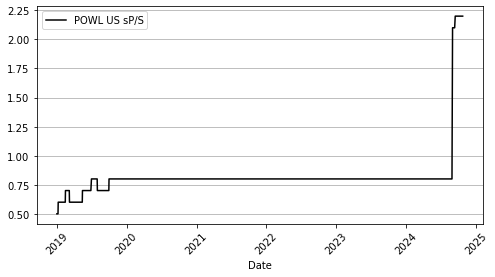

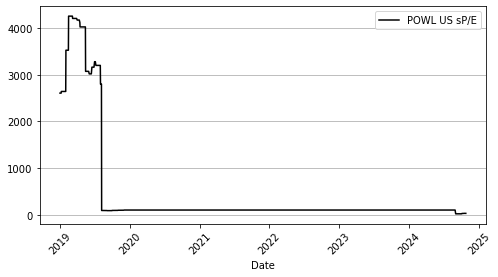

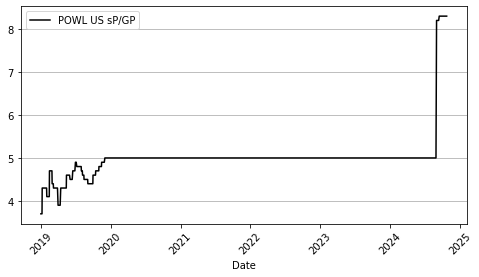

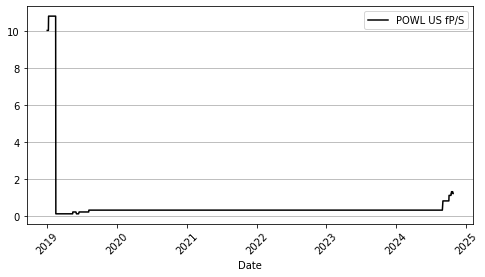

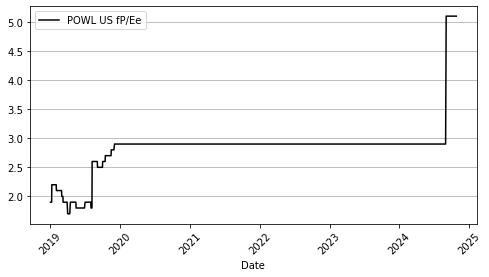

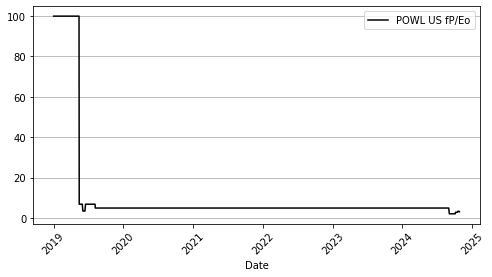

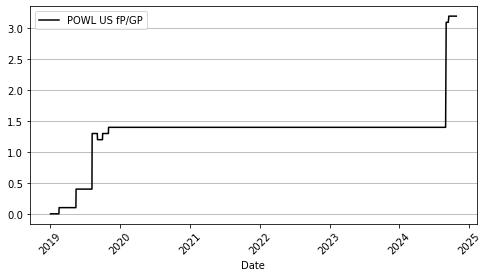

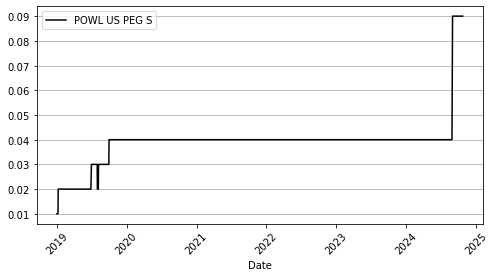

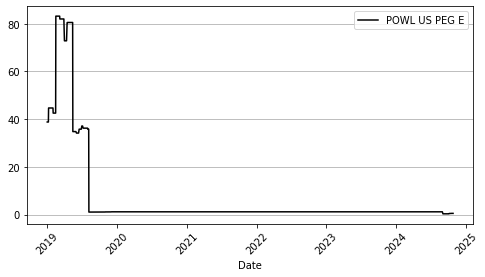

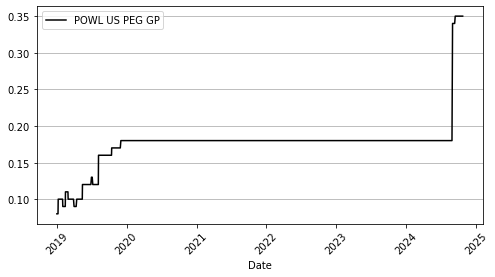

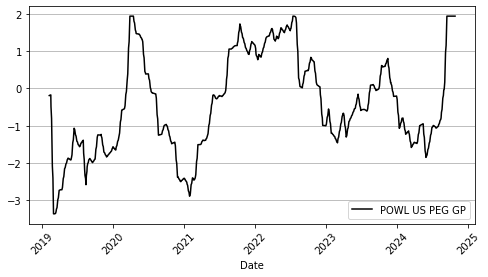

In [126]:
#VALUATION TRACKING

def winsorizeDF(base_df, wins_L, wins_H):
    
    for c_column in base_df.columns:
        base_df[c_column] = winsorize(base_df[c_column], wins_L, wins_H)
    
    return base_df

def fix_features(pred_df):

    pred_df['P/Ee'][pred_df['P/Ee'] < 0] = abs(pred_df['P/Ee'][pred_df['P/Ee'] < 0]) * 100
    pred_df['P/Eo'][pred_df['P/Eo'] < 0] = abs(pred_df['P/Eo'][pred_df['P/Eo'] < 0]) * 100
    pred_df['P/GP'][pred_df['P/GP'] < 0] = abs(pred_df['P/GP'][pred_df['P/GP'] < 0]) * 100
    pred_df['P/S'][pred_df['P/S'] < 0] = abs(pred_df['P/S'][pred_df['P/S'] < 0]) * 100
    pred_df['sP/E'][pred_df['sP/E'] < 0] = abs(pred_df['sP/E'][pred_df['sP/E'] < 0]) * 100
    pred_df['sP/S'][pred_df['sP/S'] < 0] = abs(pred_df['sP/S'][pred_df['sP/S'] < 0]) * 100
    pred_df['sP/GP'][pred_df['sP/GP'] < 0] = abs(pred_df['sP/GP'][pred_df['sP/GP'] < 0]) * 100
    pred_df = fix_na(pred_df, 'r2 S', 'r2 GP')
    pred_df = fix_na(pred_df, 'GS', 'GGP')
    aux_df = pred_df[['sP/S', 'sP/GP']]
    ratio = aux_df.median()['sP/GP'] / aux_df.median()['sP/S']
    aux_df['sP/S'] *= ratio
    aux_df = aux_df.T.fillna(method = 'ffill').T
    pred_df['sP/GP'] = aux_df['sP/GP']
    
    return pred_df

def on_selection_field(value):
    global choice_feat
    choice_feat = value
    root.destroy()
    
wins_L = 0.01
wins_H = 0.95
ovr = False

STdt_str = input('Enter Start Date (empty for 1st available or YY/MM/DD): ')
try:
    st_date = datetime.strptime(STdt_str, "%y/%m/%d").date()
except:
    st_date = selectionN_df.index[0]

end_date = selectionN_df.index[-1]
dt_r = Pxs_df[Pxs_df.index >= st_date][Pxs_df[Pxs_df.index >= st_date].index <= end_date].index
feat_l = ['sP/S', 'sP/E', 'sP/GP', 'fP/S', 'fP/Ee', 'fP/Eo', 'fP/GP', 'PEG S', 'PEG E', 'PEG GP']

next_dt = dt_r[-1]
p_dt = next_dt
started = False
save_b = False
for c_dt in dt_r[::-1]:  
    open_fdf = True
    if (c_dt < next_dt) | (c_dt == dt_r[-1]):
        next_dt = c_dt
        if (started):
            if (c_dt in SPS_df.dropna(how = 'all').index):
                open_fdf = False
        if (open_fdf):
            valid_start = False             
            while (not valid_start):
                pred_df, next_dt = get_predictors(next_dt, exclusion_l)
                exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
                exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
                if (len(exc_ffields) == 0):
                    pred_df = pred_df.drop(exc_tickers)
                    valid_start = True
                    print('Fundamentals date: ' + next_dt.strftime('%d-%b-%Y'))
                else:
                    next_dt = Pxs_df[Pxs_df.index < next_dt].index[-1]
            pred_df = fix_features(pred_df)
            asset_l = pred_df.dropna(how ='all').index.tolist()               
        if (c_dt == dt_r[-1]):
            if (ovr):
                SPS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                SPGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                SPE_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)                        
                FPS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                FPGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                FPEe_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                FPEo_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                PEGS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                PEGGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                PEGE_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)  
            else:
                try:
                    SPS_df = open_df('valuation_sps')
                    SPGP_df = open_df('valuation_spgp')
                    SPE_df = open_df('valuation_spe')
                    FPS_df = open_df('valuation_fps')
                    FPGP_df = open_df('valuation_fpgp')
                    FPEe_df = open_df('valuation_fpee')
                    FPEo_df = open_df('valuation_fpeo')
                    PEGS_df = open_df('valuation_pegs')
                    PEGGP_df = open_df('valuation_peggp')
                    PEGE_df = open_df('valuation_pege')
                except:
                    SPS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    SPGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    SPE_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)                        
                    FPS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    FPGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    FPEe_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    FPEo_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    PEGS_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    PEGGP_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
                    PEGE_df = pd.DataFrame(np.nan, index = dt_r, columns = asset_l)
            started = True
        else:
            asset_l = [t for t in asset_l if t in FPS_df.columns]
        if (c_dt not in SPS_df.dropna(how = 'all').index):     
            print('NEW RECORD ON ' + c_dt.strftime('%d-%b-%Y'))
            save_b = True
            try:
                SPS_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'sP/S'], wins_L, wins_H)
            except:
                SPS_df.loc[c_dt] = SPS_df.loc[p_dt]
                print('FPS failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                SPGP_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'sP/GP'], wins_L, wins_H)
            except:
                SPGP_df.loc[c_dt] = SPGP_df.loc[p_dt]
                print('FPS failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                SPE_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'sP/E'], wins_L, wins_H)
            except:
                SPE_df.loc[c_dt] = SPE_df.loc[p_dt]
                print('FPS failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                FPS_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'P/S'], wins_L, wins_H)
            except:
                FPS_df.loc[c_dt] = FPS_df.loc[p_dt]
                print('FPS failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                FPGP_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'P/GP'], wins_L, wins_H)
            except:
                FPGP_df.loc[c_dt] = FPGP_df.loc[p_dt]
                print('FPGP failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                FPEe_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'P/Ee'], wins_L, wins_H)
            except:
                FPEe_df.loc[c_dt] = FPEe_df.loc[p_dt]
                print('FPEe failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                FPEo_df.loc[c_dt, asset_l] = winsorize(pred_df.loc[asset_l, 'P/Eo'], wins_L, wins_H)
            except:
                FPEo_df.loc[c_dt] = FPEo_df.loc[p_dt]
                print('FPEo failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                PEGS_df.loc[c_dt, asset_l] = winsorize((pred_df.loc[asset_l, 'sP/S'] / pred_df.loc[asset_l, 'GS']), wins_L, 
                                                       wins_H).map(lambda x: round(x, 2))
            except:
                PEGS_df.loc[c_dt] = PEGS_df.loc[p_dt]
                print('PEGS failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                PEGGP_df.loc[c_dt, asset_l] = winsorize((pred_df.loc[asset_l, 'sP/GP'] / pred_df.loc[asset_l, 'GGP']), wins_L, 
                                                        wins_H).map(lambda x: round(x, 2))
            except:
                PEGGP_df.loc[c_dt] = PEGGP_df.loc[p_dt]
                print('PEGGP failed - ' + c_dt.strftime('%d-%b-%y'))
            try:
                PEGE_df.loc[c_dt, asset_l] = winsorize((pred_df.loc[asset_l, 'sP/E'] / pred_df.loc[asset_l, 'GE'] / 2), 
                                                       wins_L, wins_H).map(lambda x: round(x, 2))
            except:
                PEGE_df.loc[c_dt] = PEGE_df.loc[p_dt]
                print('PEGE failed - ' + c_dt.strftime('%d-%b-%y'))            
    elif (c_dt not in SPS_df.dropna(how = 'all').index):
        SPS_df.loc[c_dt] = SPS_df.loc[p_dt]
        SPGP_df.loc[c_dt] = SPGP_df.loc[p_dt]
        SPE_df.loc[c_dt] = SPE_df.loc[p_dt]        
        FPS_df.loc[c_dt] = FPS_df.loc[p_dt]
        FPGP_df.loc[c_dt] = FPGP_df.loc[p_dt]
        FPEe_df.loc[c_dt] = FPEe_df.loc[p_dt]
        FPEo_df.loc[c_dt] = FPEo_df.loc[p_dt]
        PEGS_df.loc[c_dt] = PEGS_df.loc[p_dt]
        PEGGP_df.loc[c_dt] = PEGGP_df.loc[p_dt]
        PEGE_df.loc[c_dt] = PEGE_df.loc[p_dt]
    p_dt = c_dt
    
if (save_b):
    print('saving...')
    SPS_df = SPS_df.sort_index()    
    SPS_df = winsorizeDF(SPS_df.T.dropna(how = 'all').T, wins_L, wins_H)
    SPS_df.to_sql('valuation_sps', engine, index = True, if_exists = 'replace')
    SPGP_df = SPGP_df.sort_index()    
    SPGP_df = winsorizeDF(SPGP_df.T.dropna(how = 'all').T, wins_L, wins_H)
    SPGP_df.to_sql('valuation_spgp', engine, index = True, if_exists = 'replace')
    SPE_df = SPE_df.sort_index()    
    SPE_df = winsorizeDF(SPE_df.T.dropna(how = 'all').T, wins_L, wins_H)
    SPE_df.to_sql('valuation_spe', engine, index = True, if_exists = 'replace')
    FPS_df = FPS_df.sort_index()    
    FPS_df = winsorizeDF(FPS_df.T.dropna(how = 'all').T, wins_L, wins_H)
    FPS_df.to_sql('valuation_fps', engine, index = True, if_exists = 'replace')
    FPGP_df = FPGP_df.sort_index()    
    FPGP_df = winsorizeDF(FPGP_df.T.dropna(how = 'all').T, wins_L, wins_H)
    FPGP_df.to_sql('valuation_fpgp', engine, index = True, if_exists = 'replace')
    FPEe_df = FPEe_df.sort_index()    
    FPEe_df = winsorizeDF(FPEe_df.T.dropna(how = 'all').T, wins_L, wins_H)
    FPEe_df.to_sql('valuation_fpee', engine, index = True, if_exists = 'replace')
    FPEo_df = FPEo_df.sort_index()    
    FPEo_df = winsorizeDF(FPEo_df.T.dropna(how = 'all').T, wins_L, wins_H)
    FPEo_df.to_sql('valuation_fpeo', engine, index = True, if_exists = 'replace')
    PEGS_df = PEGS_df.sort_index()    
    PEGS_df = winsorizeDF(PEGS_df.T.dropna(how = 'all').T, wins_L, wins_H)
    PEGS_df.to_sql('valuation_pegs', engine, index = True, if_exists = 'replace')
    PEGGP_df = PEGGP_df.sort_index()    
    PEGGP_df = winsorizeDF(PEGGP_df.T.dropna(how = 'all').T, wins_L, wins_H)
    PEGGP_df.to_sql('valuation_peggp', engine, index = True, if_exists = 'replace')
    PEGE_df = PEGE_df.sort_index()    
    PEGE_df = winsorizeDF(PEGE_df.T.dropna(how = 'all').T, wins_L, wins_H)
    PEGE_df.to_sql('valuation_pege', engine, index = True, if_exists = 'replace')


df_l = [SPS_df, SPE_df, SPGP_df, FPS_df, FPEe_df, FPEo_df, FPGP_df, PEGS_df, PEGE_df, PEGGP_df]
ticker = input('Enter algo ticker? ').upper()
if (ticker in FPS_df.columns):
    for idx, cVal_df in enumerate(df_l):
        cVal_df[ticker].fillna(method = 'ffill').dropna().plot(c = 'k', figsize = (8, 4), label = ticker + 
                                                               ' ' + feat_l[idx]).legend(loc = 'best') 
        plt.grid(axis = 'y')
        plt.xticks(rotation = 45)
        plt.show()
        
secSPS_df = SPS_df.groupby(SPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secSPGP_df = SPGP_df.groupby(SPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secFPS_df = FPS_df.groupby(FPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secFPGP_df = FPGP_df.groupby(FPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secPEGS_df = PEGS_df.groupby(PEGS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secPEGGP_df = PEGGP_df.groupby(PEGGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
        
relSPS_s = (SPS_df[ticker].fillna(method = 'ffill') - secSPS_df[sector_s.loc[ticker]])
mavSPS_s = relSPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelSPS_s = (relSPS_s - mavSPS_s).dropna()

relSPGP_s = (SPGP_df[ticker].fillna(method = 'ffill') - secSPGP_df[sector_s.loc[ticker]])
mavSPGP_s = relSPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelSPGP_s = (relSPGP_s - mavSPGP_s).dropna()

relFPS_s = (FPS_df[ticker].fillna(method = 'ffill') - secFPS_df[sector_s.loc[ticker]])
mavFPS_s = relFPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelFPS_s = (relFPS_s - mavFPS_s).dropna()

relFPGP_s = (FPGP_df[ticker].fillna(method = 'ffill') - secFPGP_df[sector_s.loc[ticker]])
mavFPGP_s = relFPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelFPGP_s = (relFPGP_s - mavFPGP_s).dropna()

relPEGS_s = (PEGS_df[ticker].fillna(method = 'ffill') - secPEGS_df[sector_s.loc[ticker]])
mavPEGS_s = relPEGS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelPEGS_s = (relPEGS_s - mavPEGS_s).dropna()

relPEGGP_s = (PEGGP_df[ticker].fillna(method = 'ffill') - secPEGGP_df[sector_s.loc[ticker]])
mavPEGGP_s = relPEGGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelPEGGP_s = (relPEGGP_s - mavPEGGP_s).dropna()

allF_s = (DrelFPS_s + DrelFPGP_s + DrelPEGS_s + DrelPEGGP_s)
allS_s = (DrelSPS_s + DrelSPGP_s + DrelPEGS_s + DrelPEGGP_s)
Tval_s = ((allF_s + allS_s) / 2)
Tval_s = winsorize(Tval_s, wins_L, wins_H)
Tval_s = Tval_s.rolling(10, min_periods = 3).mean()

Tval_s.fillna(method = 'ffill').dropna().plot(c = 'k', figsize = (8, 4), label = ticker + 
                                                       ' ' + feat_l[idx]).legend(loc = 'best') 
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

Enter algo ticker? NOW US


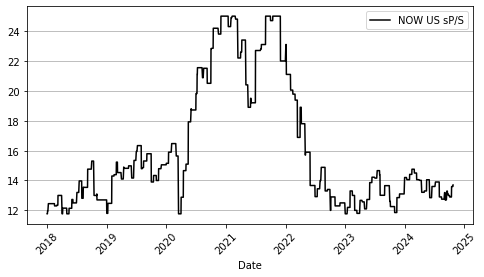

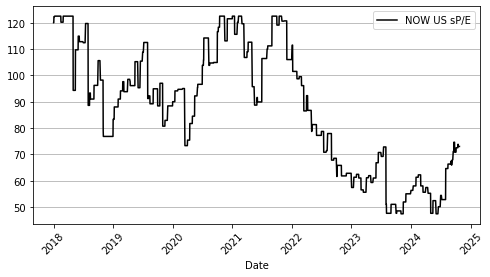

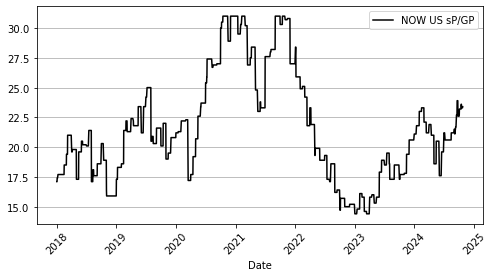

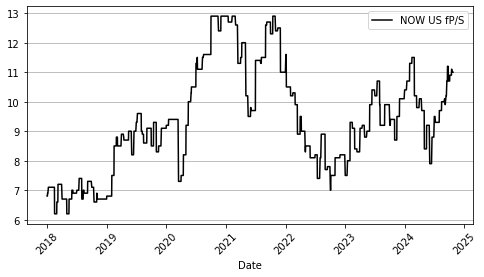

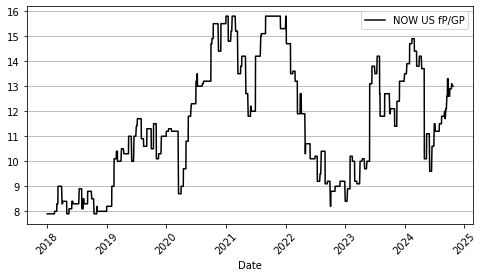

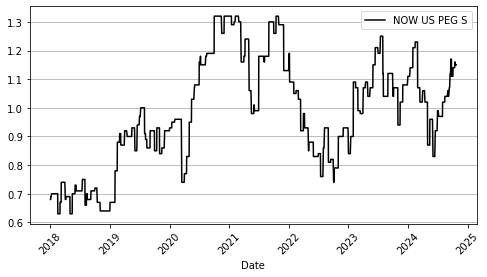

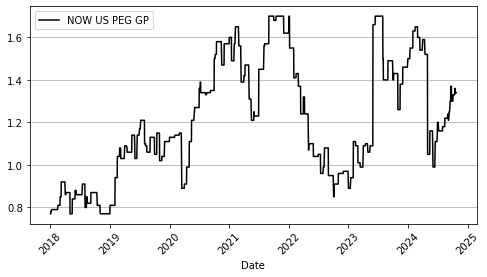

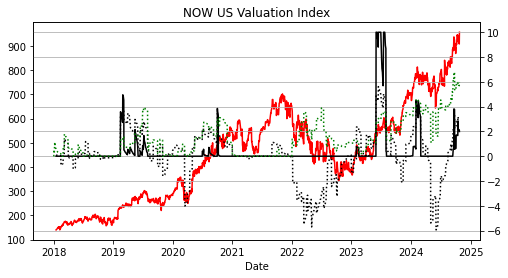

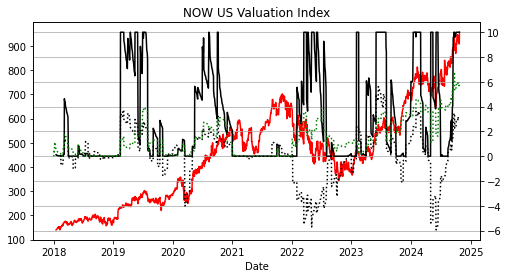

10

In [20]:
#VALUATION DRAFTS

df_l = [SPS_df, SPE_df, SPGP_df, FPS_df, FPGP_df, PEGS_df, PEGGP_df]
sdf_l = [FPS_df, FPGP_df]
feat_l = ['Fwd P/S', 'Fwd P/GP']

sdf_l = df_l.copy()
feat_l = ['sP/S', 'sP/E', 'sP/GP', 'fP/S', 'fP/GP', 'PEG S', 'PEG GP']

ticker = input('Enter algo ticker? ').upper()
if (ticker in FPS_df.columns):    
    for idx, cVal_df in enumerate(sdf_l):
        try:
            cVal_df[ticker].fillna(method = 'ffill').dropna().plot(c = 'k', figsize = (8, 4), label = ticker + 
                                                                   ' ' + feat_l[idx]).legend(loc = 'best') 
            plt.grid(axis = 'y')
            plt.xticks(rotation = 45)
            plt.show()
        except:
            print(feat_l[idx] + ' failed for ' + ticker.split(' ')[0])
        
        
# MODEL 1 - LIGHTER       
minP_scale = 10  

val_w = 126
val_hl = 252
val_m = 2
highB = 10
lowB = 1.5

        
secSPS_df = SPS_df.groupby(SPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secSPGP_df = SPGP_df.groupby(SPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secFPS_df = FPS_df.groupby(FPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secFPGP_df = FPGP_df.groupby(FPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secPEGS_df = PEGS_df.groupby(PEGS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
secPEGGP_df = PEGGP_df.groupby(PEGGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
        
absSPS_s = SPS_df[ticker].fillna(method = 'ffill')    
relSPS_s = (absSPS_s - secSPS_df[sector_s.loc[ticker]])
mavSPS_s = absSPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelSPS_s = (relSPS_s.clip(0, 1) * (absSPS_s - mavSPS_s)).dropna()

try:
    absSPGP_s = SPGP_df[ticker].fillna(method = 'ffill')
    relSPGP_s = (absSPGP_s - secSPGP_df[sector_s.loc[ticker]])
    mavSPGP_s = absSPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
    DrelSPGP_s = (relSPGP_s.clip(0, 1) * (absSPGP_s - mavSPGP_s)).dropna()
except:
    relSPGP_s = relSPS_s.copy()
    DrelSPGP_s = DrelSPS_s.copy()

absFPS_s = FPS_df[ticker].fillna(method = 'ffill')
relFPS_s = (absFPS_s - secFPS_df[sector_s.loc[ticker]])
mavFPS_s = absFPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelFPS_s = (relFPS_s.clip(0, 1) * (absFPS_s - mavFPS_s)).dropna()

try:
    absFPGP_s = FPGP_df[ticker].fillna(method = 'ffill')
    relFPGP_s = (absFPGP_s - secFPGP_df[sector_s.loc[ticker]])
    mavFPGP_s = absFPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
    DrelFPGP_s = (relFPGP_s.clip(0, 1) * (absFPGP_s - mavFPGP_s)).dropna()
except:
    relFPGP_s = relFPS_s.copy()
    DrelFPGP_s = DrelFPS_s.copy()

LTvalS_s = (relSPS_s - relSPS_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB)
LTvalGP_s = (relSPGP_s - relSPGP_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB)
STval_s = (DrelFPS_s + DrelFPGP_s).dropna()

Tval_s = (((((LTvalS_s + LTvalGP_s).clip(0, 1) * STval_s)).clip(lowB, highB) - lowB) ** val_m).clip(0, highB)

Pxs_df[ticker].loc[Tval_s.dropna().index].plot(c = 'r', figsize = (8, 4)).twinx()
plt.xticks(rotation = 45)
Tval_s.fillna(method = 'ffill').dropna().plot(c = 'k', label = ticker + ' ' + feat_l[idx])
STval_s.fillna(method = 'ffill').dropna().plot(c = 'k', linestyle = 'dotted')
(LTvalS_s + LTvalGP_s).clip(0, 10).dropna().plot(c = 'g', linestyle = 'dotted')
plt.title(ticker + ' Valuation Index')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()


# MODEL 2 - HARDER

absSPS_s = SPS_df[ticker].fillna(method = 'ffill')    
relSPS_s = (absSPS_s - secSPS_df[sector_s.loc[ticker]])
mavSPS_s = absSPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelSPS_s = (relSPS_s.clip(0, 1) * (absSPS_s - mavSPS_s)).dropna()

try:
    absSPGP_s = SPGP_df[ticker].fillna(method = 'ffill')
    relSPGP_s = (absSPGP_s - secSPGP_df[sector_s.loc[ticker]])
    mavSPGP_s = absSPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
    DrelSPGP_s = (relSPGP_s.clip(0, 1) * (absSPGP_s - mavSPGP_s)).dropna()
except:
    relSPGP_s = relSPS_s.copy()
    DrelSPGP_s = DrelSPS_s.copy()

absFPS_s = FPS_df[ticker].fillna(method = 'ffill')
relFPS_s = (absFPS_s - secFPS_df[sector_s.loc[ticker]])
mavFPS_s = absFPS_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
DrelFPS_s = (relFPS_s.clip(0, 1) * (absFPS_s - mavFPS_s)).dropna()

try:
    absFPGP_s = FPGP_df[ticker].fillna(method = 'ffill')
    relFPGP_s = (absFPGP_s - secFPGP_df[sector_s.loc[ticker]])
    mavFPGP_s = absFPGP_s.rolling(val_w, min_periods = val_w // minP_scale).mean()
    DrelFPGP_s = (relFPGP_s.clip(0, 1) * (absFPGP_s - mavFPGP_s)).dropna()
except:
    relFPGP_s = relFPS_s.copy()
    DrelFPGP_s = DrelFPS_s.copy()

LTvalS2_s = (relSPS_s - relSPS_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB)
LTvalGP2_s = (relSPGP_s - relSPGP_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB)
STval2_s = (DrelFPS_s + DrelFPGP_s).dropna()

Tval2_s = (((((LTvalS2_s + LTvalGP2_s).clip(0, 1) * STval2_s) + 1) ** val_m) - 1).clip(0, highB)

Pxs_df[ticker].loc[Tval2_s.dropna().index].plot(c = 'r', figsize = (8, 4)).twinx()
plt.xticks(rotation = 45)
Tval2_s.fillna(method = 'ffill').dropna().plot(c = 'k', label = ticker + ' ' + feat_l[idx])
STval2_s.fillna(method = 'ffill').dropna().plot(c = 'k', linestyle = 'dotted')
(LTvalS2_s + LTvalGP2_s).clip(0, 10).dropna().plot(c = 'g', linestyle = 'dotted')
plt.title(ticker + ' Valuation Index')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()


## ALGO SIMULATION
dt = datetime(2024, 10, 22).date()

sSPS_df = SPS_df[SPS_df.index < dt]
sSPGP_df = SPGP_df[SPGP_df.index < dt]
sFPS_df = FPS_df[FPS_df.index < dt]
sFPGP_df = FPGP_df[FPGP_df.index < dt]
sPEGS_df = PEGS_df[PEGS_df.index < dt]
sPEGGP_df = PEGGP_df[PEGGP_df.index < dt]

SsecSPS_df = sSPS_df.groupby(sSPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
SsecSPGP_df = sSPGP_df.groupby(sSPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
SsecFPS_df = sFPS_df.groupby(sFPS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
SsecFPGP_df = sFPGP_df.groupby(sFPGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
SsecPEGS_df = sPEGS_df.groupby(sPEGS_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()
SsecPEGGP_df = sPEGGP_df.groupby(sPEGGP_df.columns.map(lambda x: sector_s.loc[x]), axis = 1).mean()    

asset_l = sSPS_df.iloc[-1].dropna().index.tolist()
val_s = pd.Series(0, index = pd.Index(asset_l, name = 'MeanR'))
asset_l = [ticker]
for ticker in asset_l:
    try:
        absSPS_s = sSPS_df[ticker].fillna(method = 'ffill')    
        relSPS_s = (absSPS_s - SsecSPS_df[sector_s.loc[ticker]])
        mavSPS = absSPS_s[-val_w:].mean()
        DrelSPS = (relSPS_s.clip(0, 1) * (absSPS_s - mavSPS)).iloc[-1]
        
        try:
            absSPGP_s = sSPGP_df[ticker].fillna(method = 'ffill')
            relSPGP_s = (absSPGP_s - SsecSPGP_df[sector_s.loc[ticker]])
            mavSPGP = absSPGP_s[-val_w:].mean()
            DrelSPGP = (relSPGP_s.clip(0, 1) * (absSPGP_s - mavSPGP)).iloc[-1]
        except:
            print('sGP failed for ' + ticker)
            relSPGP_s = relSPS_s.copy()
            DrelSPGP = DrelSPS.copy()

        absFPS_s = sFPS_df[ticker].fillna(method = 'ffill')
        relFPS_s = (absFPS_s - SsecFPS_df[sector_s.loc[ticker]])
        mavFPS = absFPS_s[-val_w:].mean()
        DrelFPS = (relFPS_s.clip(0, 1) * (absFPS_s - mavFPS)).iloc[-1]

        try:
            absFPGP_s = sFPGP_df[ticker].fillna(method = 'ffill')
            relFPGP_s = (absFPGP_s - SsecFPGP_df[sector_s.loc[ticker]])
            mavFPGP = absFPGP_s[-val_w:].mean()
            DrelFPGP = (relFPGP_s.clip(0, 1) * (absFPGP_s - mavFPGP)).iloc[-1]
        except:
            print('fGP failed for ' + ticker)
            relFPGP_s = relFPS_s.copy()
            DrelFPGP = DrelFPS.copy()

        LTvalS = (relSPS_s - relSPS_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB).iloc[-1]
        LTvalGP = (relSPGP_s - relSPGP_s.ewm(halflife = val_hl).mean()).dropna().clip(0, highB).iloc[-1]
        STval = (DrelFPS + DrelFPGP)

        Tval2 = (((((min(max(LTvalS + LTvalGP, 0), 1)) * STval) + 1) ** val_m) - 1)
        Tval = (max(min(((min(max(LTvalS + LTvalGP, 0), 1)) * STval), highB), lowB) - lowB) ** val_m        
        
        val_s.loc[ticker] = min(highB, max(0, round(Tval2, 2)))
    except:        
        print('MeanR error for ' + ticker)
        
val_s.loc[ticker]

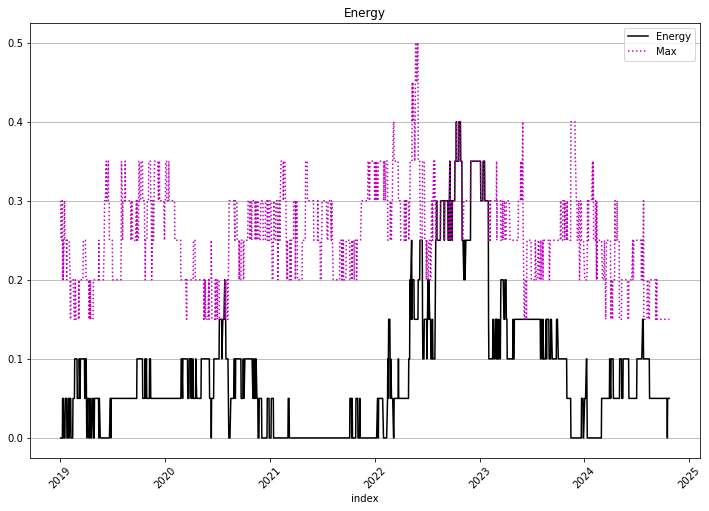

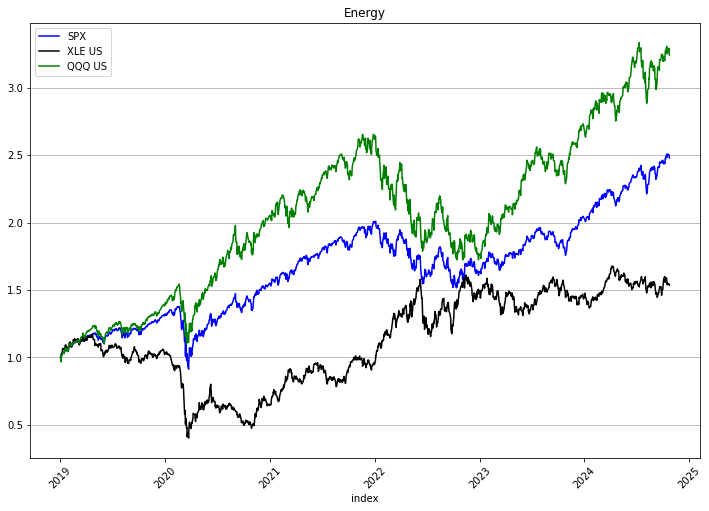

In [851]:
# SECTOR VISUALIZATION

def on_selection_class(value):
    global target_class
    target_class = value
    root.destroy()

def on_selection_sectors(value):
    global sector_option
    sector_option = value
    root.destroy() 
    
sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
class_l = Sectors_df.columns.tolist()

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *class_l, command = on_selection_class)
tk.Label(root, text = "Choose a class: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop() 

sector_s = Sectors_df[target_class].dropna()
sector_l = pd.unique(sector_s).tolist()
    
selectionN_df = open_df('idio_stock_selection' + factExt + secExt)
selectionA_df = open_df('idio_stock_allocations' + factExt + secExt)    

sectorCount_df = pd.DataFrame(np.nan, index = selectionN_df.index, columns = sector_l)
maxConc_df = pd.DataFrame(np.nan, index = selectionN_df.index, columns = ['Share', 'Sector'])
for c_dt in selectionN_df.index:
    p_size = selectionN_df.loc[c_dt].dropna().shape[0]
    sectorC_s = selectionN_df.loc[c_dt].dropna().map(lambda x: sector_s.loc[x]).value_counts()
    sectorC_s = round(sectorC_s / p_size, 2)
    maxConc_df.loc[c_dt, 'Share'] = sectorC_s.iloc[0]
    maxConc_df.loc[c_dt, 'Sector'] = sectorC_s.index[0]
    add_l = [s for s in sector_l if s not in sectorC_s.index]
    add_s = pd.Series(0, index = add_l)
    sectorC_s = pd.concat([sectorC_s, add_s])
    sectorCount_df.loc[c_dt] = sectorC_s
    
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *sector_l, command = on_selection_sectors)
tk.Label(root, text = "Choose Sector: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()        
    
sectorCount_df[sector_option].plot(figsize = (12, 8), c = 'k', label = sector_option)
maxConc_df['Share'].plot(c = 'm', label = 'Max', linestyle = 'dotted').legend(loc = 'best')
plt.title(sector_option)
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()   
(Pxs_df.loc[sectorCount_df.index]['SPX'] / Pxs_df.loc[sectorCount_df.index]['SPX'].iloc[0]).plot(figsize = (12, 8), c = 'b')
try:
    (Pxs_df.loc[sectorCount_df.index][sector_ETF_map[sector_option]] / 
     Pxs_df.loc[sectorCount_df.index][sector_ETF_map[sector_option]].iloc[0]).plot(c = 'k')
except:
    pass
(Pxs_df.loc[sectorCount_df.index]['QQQ US'] / Pxs_df.loc[sectorCount_df.index]['QQQ US'].iloc[0]).plot(c = 'g').legend(loc = 'best')
plt.title(sector_option)
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()          


MAX DD Raw: -30.11
MAX DD Stop Loss: -20.82
DD Interv Freq: 27.16



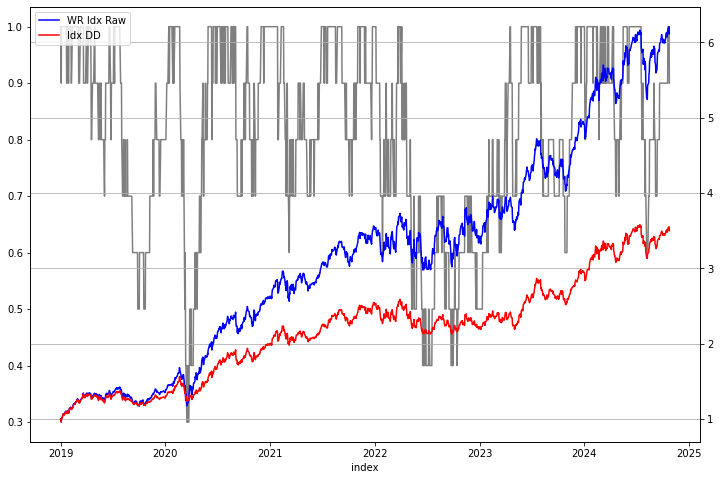

Performances:
            WR Idx Raw  Idx DD  QQQ US    SPX  ARKK US
index                                                 
2019-12-31       35.72   28.19   38.79  25.23    34.58
2020-12-31       93.86   56.38   48.41  18.33   148.73
2021-12-31       33.64   25.43   27.42  28.73   -24.02
2022-12-31       -2.55  -11.56  -32.58 -18.18   -66.97
2023-12-31       43.34   32.50   54.03  24.76    67.64
2024-12-31       24.47   18.75   19.25  21.59   -12.61


Volatilities:
            WR Idx Raw  Idx DD  QQQ US    SPX  ARKK US
index                                                 
2019-12-31       24.27   21.83   18.13  13.72    29.14
2020-12-31       33.36   22.50   30.65  28.65    42.14
2021-12-31       24.87   19.65   22.38  17.97    40.20
2022-12-31       28.54   20.30   27.24  20.40    57.71
2023-12-31       26.20   18.06   23.47  17.67    49.17
2024-12-31       20.79   17.24   17.62  12.70    37.39


Drawdowns:
            WR Idx Raw  Idx DD  QQQ US    SPX  ARKK US
index                 

WR Idx Raw  Alloc  Cash  Net Idx DD    Idx DD
index                                                    
2024-10-03    6.012037    0.9   0.1           0  3.449104
2024-10-04    6.029444    0.9   0.1           0  3.458127
2024-10-07    5.989649    0.9   0.1           0  3.437622
2024-10-08    6.027916    0.9   0.1           0  3.457426
2024-10-09    6.035469    0.9   0.1           0  3.461363
2024-10-10    6.055251    0.9   0.1           0  3.471613
2024-10-11    6.111465    0.9   0.1           0  3.500658
2024-10-14    6.133097    0.9   0.1           0  3.511848
2024-10-15    6.069685    0.9   0.1           0  3.479207
2024-10-16    6.121344    0.9   0.1           0  3.505896
2024-10-17    6.110188    0.9   0.1           0  3.500184
2024-10-18    6.169959    1.0   0.0           0  3.531038
2024-10-21    6.203965    1.0   0.0           0  3.550499
2024-10-22    6.207563    1.0   0.0           0  3.552559
2024-10-23    6.113388    0.9   0.1           0  3.498663

In [852]:
# DRAWDOWN MODULE

maxDD = 30
round_factor = 10
alloc_reval = 50
pullback_l = 10
DD_w = 252
pullback_boost = False


netDD_df = pd.DataFrame(0, index = perfSummary_df.index, columns = ['WR Idx Raw', 'Alloc', 'Cash', 'Net Idx DD'])
netDD_df['WR Idx Raw'] = perfSummary_df['WR Index']
netDD_df.loc[netDD_df.index[0], 'Alloc'] = 1
netDD_df.loc[netDD_df.index[0], 'Cash'] = 0
netDD_df.loc[netDD_df.index[0], 'Idx DD'] = 1
reval_DD = False
for c_dt in netDD_df.index[1:]:    
    p_dt = netDD_df.index[netDD_df.index.tolist().index(c_dt) - 1]
    port_alloc = netDD_df.loc[p_dt, 'Alloc']
    cash_alloc = netDD_df.loc[p_dt, 'Cash']
    cash_ret = Pxs_df.loc[p_dt, riskFree_asset] / 36000
    netDD_df.loc[c_dt, 'Idx DD'] = ((netDD_df.loc[c_dt, 'WR Idx Raw'] / netDD_df.loc[p_dt, 'WR Idx Raw'] - 1) * 
                                        port_alloc + cash_ret * cash_alloc + 1) * netDD_df.loc[p_dt, 'Idx DD']
    netDD_df.loc[c_dt, 'Alloc'] = 1 - (abs(100 * (netDD_df.loc[c_dt, 'Idx DD'] / netDD_df[:c_dt][-DD_w:]['Idx DD'].max() - 
                                                  1)) / maxDD)
    netDD_df.loc[c_dt, 'Alloc'] = round(round(netDD_df.loc[c_dt, 'Alloc'] / round_factor, 2) * round_factor, 2)
    if (netDD_df.loc[c_dt, 'Alloc'] == 0):
        reval_DD = True
        index_DDlevel = netDD_df.loc[c_dt, 'WR Idx Raw']    
    if (reval_DD) & (netDD_df.loc[c_dt, 'Alloc'] < alloc_reval / 100) & (pullback_boost):
        c_pb = 100 * (netDD_df.loc[c_dt, 'WR Idx Raw'] / index_DDlevel - 1)
        if (c_pb > pullback_l):
            netDD_df.loc[c_dt, 'Alloc'] = max(netDD_df.loc[c_dt, 'Alloc'], alloc_reval / 100) 
            reval_DD = False
    netDD_df.loc[c_dt, 'Cash'] = 1 - netDD_df.loc[c_dt, 'Alloc']
    
maxDD_sl = round(100 * (netDD_df['Idx DD'] / netDD_df['Idx DD'].expanding().max() - 1), 2).min()
maxDD_raw = round(100 * (netDD_df['WR Idx Raw'] / netDD_df['WR Idx Raw'].expanding().max() - 1), 2).min()
reb_freq = round(100 * (netDD_df['Alloc'] != netDD_df['Alloc'].shift(1).fillna(1)).sum() / netDD_df.shape[0], 2)
print('')
print('MAX DD Raw: ' + str(maxDD_raw))
print('MAX DD Stop Loss: ' + str(maxDD_sl))   
print('DD Interv Freq: ' + str(reb_freq))
print('')
    
netDD_df['Alloc'].plot(figsize = (12, 8), c = 'k', alpha = 0.5).twinx()
netDD_df['WR Idx Raw'].plot(c = 'b')
netDD_df['Idx DD'].plot(c = 'r').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

SummaryP_df = pd.DataFrame(netDD_df['WR Idx Raw']).join(netDD_df['Idx DD']).join(qqq_s).join(spx_s).join(arkk_s)
annual_reports(SummaryP_df, 'SPX')
print('')
netDD_df[-15:]

Enter Start Date (empty for update or YY/MM/DD): 

Recorded ETFs
            Style
index            
FNDA   size/value
GSLC    multi vmq
IEF          term
IJS    size/value
ITOT         beta
IWC          size
MTUM   momentum_f
QUAL    quality_g
SCHA         size
SCHB         beta
SCHV        value

Add new ETFs (YF ETF name, empty or D/d to delete all entries)? 
Override ETF prices relation (Y/y or empty)? 
Update single (empty or ETF ticker, (M/m) for missing ETFs)? 

[*********************100%***********************]  1 of 1 completed
0 FNDA
[*********************100%***********************]  1 of 1 completed
1 GSLC
[*********************100%***********************]  1 of 1 completed
2 IEF
[*********************100%***********************]  1 of 1 completed
3 IJS
[*********************100%***********************]  1 of 1 completed
4 ITOT
[*********************100%***********************]  1 of 1 completed
5 IWC
[*********************100%***********************]  1 of 1 completed
6 MT

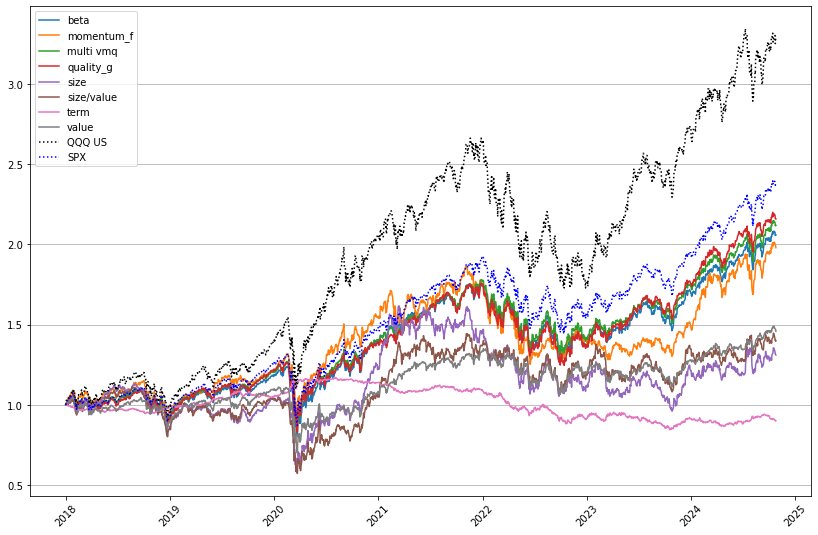

beta  momentum_f  multi vmq  quality_g      size  size/value  \
2018-01-01  1.000000    1.000000   1.000000   1.000000  1.000000    1.000000   
2018-01-02  1.000000    1.000000   1.000000   1.000000  1.000000    1.000000   
2018-01-03  1.005524    1.010006   1.005398   1.007085  1.001837    0.998087   
2018-01-04  1.009138    1.018472   1.009494   1.011647  1.005030    1.001654   
2018-01-05  1.015352    1.026650   1.016567   1.018252  1.006058    1.002999   
...              ...         ...        ...        ...       ...         ...   
2024-10-21  2.077151    2.007985   2.139799   2.185038  1.335229    1.416193   
2024-10-22  2.073975    2.001732   2.134587   2.177954  1.330417    1.409989   
2024-10-23  2.055194    1.997114   2.115786   2.159582  1.315808    1.400269   
2024-10-24  2.060718    1.991245   2.118950   2.158021  1.314933    1.403991   
2024-10-25  2.058922    1.979411   2.118578   2.158501  1.311478    1.398304   

                term     value    QQQ US       SPX  
2018-01-01  1.000000  1.000000  1.000000  1.000000  
2018-01-02  1.000000  1.000000  1.017527  1.007157  
2018-01-03  1.001045  1.003277  1.027414  1.013528  
2018-01-04  1.000570  1.008194  1.029211  1.017800  
2018-01-05  0.999335  1.012564  1.039548  1.024582  
...              ...       ...       ...       ...  
2024-10-21  0.904771  1.477058  3.297565  2.391456  
2024-10-22  0.903916  1.474872  3.300826  2.389817  
2024-10-23  0.901825  1.473234  3.250245  2.367775  
2024-10-24  0.903821  1.469956  3.276600  2.373101  
2024-10-25  0.901825  1.459031  3.296566  2.372323  

[1780 rows x 10 columns]

In [127]:
# FACTOR ETF PRICES 

import pandas as pd
import numpy as np
import math
import os
import csv
import yfinance as yf
#import mysql.connector
import psycopg2
import requests
import json
import tkinter as tk
import re
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection_options(value):
    global style_option
    style_option = value
    root.destroy() 

Pxs_df = open_df('prices_relation')
try:
    factorETF_df = open_df('etf_factors')
except:
    factorETF_df = pd.DataFrame(np.nan, index = ['dummy'], columns = ['Style'])
    
today = datetime.today().date()
yesterday = (today - timedelta(1))
today = today - timedelta(today.weekday() % 4 * (today.weekday() // 4))
st_date = datetime(2010, 1, 1).date()

st_date_str = st_date.strftime('%d-%b-%Y')
try:
    new_st_date = input('Enter Start Date (empty for update or YY/MM/DD): ')
    st_date = datetime.strptime(new_st_date, "%y/%m/%d").date()
except:
    st_date = yesterday   
    
styles_l = ['value', 'momentum_f', 'quality_g', 'quality_broad', 'size', 'vol']    
additional_styles = factorETF_df['Style'].dropna().tolist()
styles_l = pd.unique(styles_l + additional_styles).tolist()
    
print('')
print('Recorded ETFs')    
print(factorETF_df)
print('')
    
keep_adding = 'True'
while (keep_adding):
    edit = input('Add new ETFs (YF ETF name, empty or D/d to delete all entries)? ').upper()
    if (edit == 'D'):
        factorETF_df = pd.DataFrame(np.nan, index = ['dummy'], columns = ['Ticker', 'Style'])
    elif (edit == ''):
        keep_adding = False
    else:
        if ('NEW' not in styles_l):
            styles_l.append('NEW')
        root = tk.Tk()
        tkvar = tk.StringVar(root)
        popupMenu = tk.OptionMenu(root, tkvar, *styles_l, command = on_selection_options)
        tk.Label(root, text = "Choose a style").grid(row = 0, column = 0)
        popupMenu.grid(row = 1, column = 0)
        root.mainloop()
        style = style_option
        if (style_option == 'NEW'):
            style = input('Enter new style: ').lower()
        confirm = input('Confirm input (' + edit + '/' + style + ' - N/n or empty) ').upper()
        if (confirm != 'N'):
            factorETF_df.loc[edit] = style
            if (style_option == 'NEW'):
                styles_l.append(style)
    if ('dummy' in factorETF_df.index):
        factorETF_df = factorETF_df.drop(['dummy'])

cont = 0
ETF_list = factorETF_df.index.tolist()

if (st_date != yesterday):
    date_range = Pxs_df[Pxs_df.index >= st_date].index
    days_str = str(len(date_range) + 1)
else:
    date_range = [yesterday - timedelta(yesterday.weekday() % 4 * (yesterday.weekday() // 4))]
    if (today != yesterday):
        date_range.append(today)
    days_str = '2'
    
override = False
ovr = input('Override ETF prices relation (Y/y or empty)? ').upper()
if (ovr == 'Y'):
    override = True

if (override):
    ETFPxs_df = pd.DataFrame(np.nan, index = date_range, columns = ETF_list) 
else:
    try:
        ETFPxs_df = open_df('etf_prices_relation')
    except:
        ETFPxs_df = pd.DataFrame(np.nan, index = date_range, columns = ETF_list)    

keep_asking = True
while (keep_asking):
    single = input('Update single (empty or ETF ticker, (M/m) for missing ETFs)? ').upper()
    if (single == ''):
        keep_asking = False
    elif (single in ETFPxs_df.columns):
        ETF_list = [single]
        keep_asking = False
    elif (single == 'M'):
        ETF_list = [etf for etf in ETF_list if etf not in ETFPxs_df.columns]
        keep_asking = False

print('')
for cont, current_ETF in enumerate(ETF_list):
    new_list = []
    new_list.append(current_ETF)
    try:
        currentPX_df = yf.download(new_list, period = days_str + 'd')
        currentPX_df.index = currentPX_df.index.map(lambda x: x.date())
        currentPX_s = currentPX_df[currentPX_df.index >= st_date]['Close']
        currentPX_s.name = current_ETF        
        FcurrentPX_s = pd.DataFrame(np.nan, index = date_range, columns = ['dummy'])
        FcurrentPX_s = FcurrentPX_s.join(currentPX_s)
        FcurrentPX_s = FcurrentPX_s.drop(['dummy'], axis = 1).fillna(method = 'bfill')

        missing_dates = [dt for dt in FcurrentPX_s.index if dt not in ETFPxs_df.index]
        compl_df = pd.DataFrame(np.nan, index = missing_dates, columns = ETFPxs_df.columns)
        ETFPxs_df = pd.concat([compl_df, ETFPxs_df])
        ETFPxs_df = ETFPxs_df.sort_index()        
        
        ETFPxs_df.loc[date_range, current_ETF] = FcurrentPX_s[current_ETF]
        print(str(cont) + ' ' + current_ETF)        
    except:
        print(current_ETF + ' Failed')
        
exc_list = (ETFPxs_df[ETFPxs_df.index.map(lambda x: x.year) == today.year].isna().sum() == ETFPxs_df[ETFPxs_df.index.map(lambda x: x.year) == today.year].shape[0]).replace({False: np.nan}).dropna().index.tolist()        
if (len(exc_list) > 0):
    for exc_c in exc_list:
        if (exc_c in ETFPxs_df.columns):
            ETFPxs_df = ETFPxs_df.drop(exc_c, axis = 1)
        if (exc_c in factorETF_df.index):
            factorETF_df = factorETF_df.drop(exc_c)
              
ETFPxs_df = ETFPxs_df.dropna(thresh = ETFPxs_df.shape[1] // 2)                
style_df = ETFPxs_df.groupby(ETFPxs_df.columns.map(lambda x: factorETF_df.loc[x, 'Style']), axis = 1).mean()
if (style_df.index[-1] not in Pxs_df.index):
    style_df = style_df.drop(style_df.index[-1])
styleSummary_df = (style_df / style_df.iloc[0])     
styleSummary_df.plot(figsize = (14, 9))
(Pxs_df.loc[style_df.index]['QQQ US'] / Pxs_df.loc[style_df.index]['QQQ US'].iloc[0]).plot(c = 'k', linestyle = 'dotted')
(Pxs_df.loc[style_df.index]['SPX'] / Pxs_df.loc[style_df.index]['SPX'].iloc[0]).plot(c = 'b', linestyle = 'dotted').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()        
    
factorETF_df.to_sql('etf_factors', engine, index = True, if_exists = 'replace')
styleSummary_df.to_sql('styles_relation', engine, index = True, if_exists = 'replace')
ETFPxs_df.to_sql('etf_prices_relation', engine, index = True, if_exists = 'replace')

styleSummary_df.join(Pxs_df[['QQQ US', 'SPX']].loc[styleSummary_df.index] / Pxs_df[['QQQ US', 'SPX']].loc[styleSummary_df.index].iloc[0])

In [128]:
# FACTOR VS MKT REGIMES (VOLATILITY, RATES, INFLATION)

def open_df2(relation):
    
    mod_df = open_df(relation)
    mod_df.columns = mod_df.columns.map(lambda x: x + ' ' + relation.split('_')[1].upper())
    
    return mod_df

mav_r = 21
mav_w = 63
HL = 21
macroFeatures_l = ['CRB Index Index Points', 'Brent USD/Bbl', 'M2CP Velocity', 'M2MP Velocity', 'T5YIFR', 'T10YIE', 'USGG2YR', 'USGG10YR', 'VIX']
slim_feat_l = ['beta', 'value', 'momentum_f', 'quality_g', 'quality_broad', 'size', 'vol']
Sfeat_sl = ['M2MP Velocity', 'T10YIE', 'USGG2YR', 'VIX', 'US10YR RR', 'Brent USD/Bbl', '2Y IR Vol']
Sfeat_sl = ['M2MP Velocity', 'T10YIE', 'USGG2YR', 'VIX', 'Brent USD/Bbl', '2Y IR Vol']
thresh = 2
q_states = 3

Pxs_df = open_df('prices_relation')
facSummary_df = open_df('styles_relation')
spxGS_df = open_df2('spx_gs')
spxGE_df = open_df2('spx_ge')
spxGOI_df = open_df2('spx_goi')
qqqGS_df = open_df2('qqq_gs')
qqqGE_df = open_df2('qqq_ge')
qqqGOI_df = open_df2('qqq_goi')

spxALL_df = spxGS_df.join(spxGE_df).join(spxGOI_df)
qqqALL_df = qqqGS_df.join(qqqGE_df).join(qqqGOI_df)

spxG_s = spxALL_df.mean(axis = 1)
qqqG_s = qqqALL_df.mean(axis = 1)
spxG_s.name = 'SPX G'
qqqG_s.name = 'QQQ G'

slimF_l = [f for f in slim_feat_l if f in facSummary_df.columns]

SlicePxs_df = Pxs_df[macroFeatures_l]
SlicePxs_df = SlicePxs_df.join(spxG_s).join(qqqG_s)
SlicePxs_df['US10YR RR'] = SlicePxs_df['USGG10YR'] - SlicePxs_df['T10YIE']
SlicePxs_df['YC'] = SlicePxs_df['USGG10YR'] - SlicePxs_df['USGG2YR']
SlicePxs_df['2Y IR Vol'] = SlicePxs_df['USGG2YR'].ewm(halflife = HL).std() * np.sqrt(252)
SstatF_df = SlicePxs_df.loc[facSummary_df.index]
statF_df = (SstatF_df - SstatF_df.ewm(halflife = HL).mean())
#statF_df = (SstatF_df - SstatF_df.rolling(mav_w).mean())
#statF_df -= statF_df.mean()
#statF_df /= statF_df.std()

qqq_s = Pxs_df.loc[facSummary_df.index]['QQQ US'] / Pxs_df.loc[facSummary_df.index]['QQQ US'].iloc[0]
spx_s = Pxs_df.loc[facSummary_df.index]['SPX'] / Pxs_df.loc[facSummary_df.index]['SPX'].iloc[0]
facSummary_df['QQQ US'] = qqq_s
facSummary_df['SPX'] = spx_s

for c_factor in slimF_l:
    factRET_s = (facSummary_df[c_factor].shift(-mav_r) / facSummary_df[c_factor] - 1)
    aux_df = statF_df.join(factRET_s)
    aux_df = aux_df.dropna(subset = [c_factor])
    rollingCORR_df = aux_df.rolling(mav_w).corr(aux_df[c_factor].rolling(mav_w)).dropna()
    rollingCORR_df = rollingCORR_df.drop(c_factor, axis = 1)
    print(c_factor)
    print(round(100 * rollingCORR_df.mean(), 2))
    print('')

QstatF_df = statF_df.copy()
for c_col in Sfeat_sl:
    QstatF_df[c_col] = pd.qcut(statF_df[c_col], q = q_states, labels = False, duplicates = 'drop').fillna(100).astype(int)
    
SlimQstatF_df = QstatF_df[Sfeat_sl].replace({100: np.nan}).dropna().astype(int)  
 
state_s = pd.Series(np.nan, index = SlimQstatF_df.index)
for c_dt in SlimQstatF_df.index:
    comb = ''
    for c_col in SlimQstatF_df.columns:
        comb = comb + str(SlimQstatF_df.loc[c_dt, c_col])
    state_s.loc[c_dt] = comb
    
incidence_s = state_s.value_counts()
incidence_s = incidence_s[incidence_s >= thresh]
states_sl = incidence_s.index.tolist()
print('Covered days: ' + str(round(100 * incidence_s.sum() / QstatF_df.shape[0], 2)) + '%')

state_df = pd.DataFrame(0, index = states_sl, columns = slimF_l)

for idx, c_dt in enumerate(state_s.index[1:]):
    p_dt = state_s.index[idx]
    if (idx == 0) | (state_s.loc[c_dt] != state_s.loc[p_dt]) | (c_dt == state_s.index[-1]):        
        if (idx > 0):
            end_s = facSummary_df[slimF_l].loc[c_dt]
            ret_s = 100 * (end_s / init_s - 1)
            init_s = facSummary_df[slimF_l].loc[c_dt]
            if (state_s.loc[p_dt] in states_sl):
                state_df.loc[state_s.loc[p_dt]] += ret_s
        else:
            init_s = facSummary_df[slimF_l].loc[c_dt]
            
state_df = round(state_df, 2)   
print('')
print('State Dictionary:')
print(state_df.drop(['beta'], axis = 1).idxmax(axis = 1)[:60])
if (state_df.shape[0] > 60):
    print(state_df.drop(['beta'], axis = 1).idxmax(axis = 1)[-60:])
print('')
print('State Incidence, ALL:')
x = state_df.drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, HIGH VOL:')
x = state_df[state_df.index.map(lambda x: x[3]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW VOL:')
x = state_df[state_df.index.map(lambda x: x[3]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, HIGH INFLATION:')
x = state_df[state_df.index.map(lambda x: x[1]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW INFLATION:')
x = state_df[state_df.index.map(lambda x: x[1]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, HIGH RATES:')
x = state_df[state_df.index.map(lambda x: x[2]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW RATES:')
x = state_df[state_df.index.map(lambda x: x[2]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
#print('State Incidence, HIGH REAL RATES:')
#x = state_df[state_df.index.map(lambda x: x[4]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
#print(round(100 * (x / x.sum()), 1))
#print('')
#print('State Incidence, LOW REAL RATES:')
#x = state_df[state_df.index.map(lambda x: x[4]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
#print(round(100 * (x / x.sum()), 1))
#print('')
print('State Incidence, HIGH LIQUIDITY:')
x = state_df[state_df.index.map(lambda x: x[0]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW LIQUIDITY:')
x = state_df[state_df.index.map(lambda x: x[0]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, HIGH OIL:')
x = state_df[state_df.index.map(lambda x: x[4]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW OIL:')
x = state_df[state_df.index.map(lambda x: x[4]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, HIGH IR VOL:')
x = state_df[state_df.index.map(lambda x: x[5]) == '2'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')
print('State Incidence, LOW IR VOL:')
x = state_df[state_df.index.map(lambda x: x[5]) == '0'].drop(['beta'], axis = 1).idxmax(axis = 1).value_counts()
print(round(100 * (x / x.sum()), 1))
print('')

kn_l = []
for idx, k in enumerate(state_s.iloc[-1]):
    k = int(k)
    idx_n = idx + 1
    if (k == 0):
        if (idx_n != len(state_s.iloc[-1])) & (idx != 0):
            kn = state_s.iloc[-1][:idx] + str(k + 1) + state_s.iloc[-1][idx_n: ]
        elif (idx_n == len(state_s.iloc[-1])):
            kn = state_s.iloc[-1][:idx] + str(k + 1)
        elif (idx == 0):
            kn = str(k + 1) + state_s.iloc[-1][idx_n: ]
        kn_l.append(kn)
    elif (k == 2):
        if (idx_n != len(state_s.iloc[-1])) & (idx != 0):
            kn = state_s.iloc[-1][:idx] + str(k - 1) + state_s.iloc[-1][idx_n: ]
        elif (idx_n == len(state_s.iloc[-1])):
            kn = state_s.iloc[-1][:idx] + str(k - 1)
        elif (idx == 0):
            kn = str(k - 1) + state_s.iloc[-1][idx_n: ]  
        kn_l.append(kn)
    elif (k == 1):
        if (idx_n != len(state_s.iloc[-1])) & (idx != 0):
            kn = state_s.iloc[-1][:idx] + str(k + 1) + state_s.iloc[-1][idx_n: ]
        elif (idx_n == len(state_s.iloc[-1])):
            kn = state_s.iloc[-1][:idx] + str(k + 1)
        elif (idx == 0):
            kn = str(k + 1) + state_s.iloc[-1][idx_n: ] 
        kn_l.append(kn)
        if (idx_n != len(state_s.iloc[-1])) & (idx != 0):
            kn = state_s.iloc[-1][:idx] + str(k - 1) + state_s.iloc[-1][idx_n: ]
        elif (idx_n == len(state_s.iloc[-1])):
            kn = state_s.iloc[-1][:idx] + str(k - 1)
        elif (idx == 0):
            kn = str(k - 1) + state_s.iloc[-1][idx_n: ]     
        kn_l.append(kn)

#state_s.to_sql('mkt_states', engine, index = True, if_exists = 'replace') 
kns_l = [k for k in kn_l if k in state_df.index]   
if (len(kns_l) > 0):
    snap_df = state_df.loc[kns_l] 
    if (state_s.iloc[-1] in state_df.index):
        last_usable_state = state_s.iloc[-1]
    else:
        last_usable_state = state_s.iloc[-2]
    snap_df.loc[last_usable_state] = state_df.loc[last_usable_state]
    snap_df.loc['Average'] = round(snap_df.mean(), 2)
    print('')
    print(round(statF_df[-5:], 3))
    print('')
    for c_col in statF_df.columns:
        print(c_col + ' boundaries')
        print(pd.qcut(statF_df[c_col], q = q_states, duplicates = 'drop')[-1:])
        print('')
    print('')
    print('SIMILAR STATES')
    print(Sfeat_sl)
    print(snap_df)


    standard_range = 0.5
    qb_df = pd.DataFrame(np.nan, index = ['qb L', 'qb H', 'dL', 'dH'], columns = Sfeat_sl)
    SSstatF_df = (statF_df[Sfeat_sl] - statF_df[Sfeat_sl].mean()).dropna()
    SSstatF_df /= SSstatF_df.std()
    for c_feat in Sfeat_sl:
        qb_df.loc['qb L', c_feat] = np.quantile(SSstatF_df[c_feat].dropna(), q = 1 / q_states)
        qb_df.loc['qb H', c_feat] = np.quantile(SSstatF_df[c_feat].dropna(), q = 2 / q_states)
        if (SSstatF_df.iloc[-1][c_feat] < qb_df.loc['qb H', c_feat]):
            qb_df.loc['dL', c_feat] = round(SSstatF_df.iloc[-1][c_feat] - qb_df.loc['qb L', c_feat], 5)
        if (SSstatF_df.iloc[-1][c_feat] > qb_df.loc['qb L', c_feat]):
            qb_df.loc['dH', c_feat] = round(SSstatF_df.iloc[-1][c_feat] - qb_df.loc['qb H', c_feat], 5)

    d_l = sorted(abs(qb_df.loc['dL']).replace({np.nan: 100}).tolist() + abs(qb_df.loc['dH']).replace({np.nan: 100}).tolist())
    d_s = pd.Series(d_l)
    d_l = d_s[d_s < standard_range].tolist()
    altStates_df = pd.DataFrame(np.nan, index = ['Initial', 'Alt 1', 'Alt 2'], columns = Sfeat_sl)
    altStates_df.loc['Initial'] = list(snap_df.index[-2])
    for Pscore in d_l:
        feat = (abs(qb_df) == Pscore).replace({False: np.nan}).dropna(how = 'all').T.dropna().index[0]
        bound = (abs(qb_df) == Pscore).replace({False: np.nan}).dropna(how = 'all').T.dropna().columns[0]
        if (bound == 'dH'):
            bound_c = 'dL'
        else:
            bound_c = 'dH'
        if (qb_df.isna().loc[bound_c, feat] == True):
            alt = 1
        else:
            if (bound == 'dH'):
                alt = 2
            else:
                alt = 0
        if (altStates_df.isna().loc['Alt 1', feat] == True):
            altStates_df.loc['Alt 1', feat] = alt
        else:
            altStates_df.loc['Alt 2', feat] = alt  

    list_df = pd.Series(np.nan, index = np.arange(len(Sfeat_sl)))
    max_l = 0
    for i in list_df.index:    
        max_l = max(max_l, len(altStates_df[altStates_df.columns[i]].dropna().tolist()))
        list_df.loc[i] = altStates_df[altStates_df.columns[i]].dropna().tolist()

    m = list_df.map(lambda x: len(x)).prod()    
    base_df = (list_df.map(lambda x: len(x)).expanding().apply(np.prod) / list_df.map(lambda x: len(x)))    

    Fstate_l = []
    for idx in np.arange(m):
        aux_s = (idx // base_df) % list_df.map(lambda x: len(x))
        element = ''
        for k in list_df.index:
            element += str(list_df.loc[k][int(aux_s.loc[k])])
        Fstate_l.append(element)

    Fstate_l = [f for f in Fstate_l if f in state_df.index]       
    proxyState_df = state_df.loc[Fstate_l]
    proxyState_df['Incidence'] = proxyState_df.index.map(lambda x: round(100 * (state_s.value_counts() / state_s.shape[0]), 2).loc[x])
    proxyState_df = proxyState_df.sort_values(by = ['Incidence'], ascending = False)
    proxyState_df.loc['Avg'] = (proxyState_df.T * proxyState_df['Incidence'] / proxyState_df['Incidence'].sum()).sum(axis = 1)
    try:
        last_s = proxyState_df.loc[last_usable_state].drop_duplicates()
        last_s = pd.Series(last_s.T[last_s.T.columns[0]].values, index = last_s.T.index)
    except:
        last_s = proxyState_df.loc[last_usable_state]
    proxyState_df = proxyState_df.drop(last_usable_state)
    proxyState_df = pd.concat([pd.DataFrame(last_s.values.reshape(1, -1), index = [last_usable_state], columns = last_s.index), 
                               proxyState_df])
    

    print('')
    init_state = proxyState_df.iloc[0]
    SproxyState_df = proxyState_df.drop('Avg').copy()
    for idx, c_feat in enumerate(Sfeat_sl):
        aux_l = pd.unique(SproxyState_df.index.map(lambda x: x[idx]).tolist()).tolist()
        aux_l.remove(SproxyState_df.index[0][idx])
        for element_c in aux_l:        
            new_state = SproxyState_df[SproxyState_df.index.map(lambda x: x[idx]) == element_c].mean()
            delta_state = new_state - init_state
            print('')
            print(c_feat + ' from ' + str(SproxyState_df.index[0][idx]) + ' to ' + str(element_c) + ':')
            print(round(delta_state, 3))        

    print('')
    print('###########################################################')
    print(Sfeat_sl)
    print('LAST USABLE: ' + last_usable_state)  
    try:
        print(state_df.loc[last_usable_state])
    except:
        print('weird state...')
    print('###########################################################')
    print('')
    n = 20
    print('Last ' + str(n) + ' States:')
    print(state_s[-n:])        
    print('')
    print('Boundaries:')
    print(round(qb_df, 4))
    print('')
    print('All States:')
    print(altStates_df)
    print('')
    print('SIMILAR STATES - REFINED')
    print(Sfeat_sl)
    proxyState_df = proxyState_df.drop_duplicates()
    print(round(proxyState_df, 2))
else:
    print(Sfeat_sl)
    print(state_s[-10:])

beta
CRB Index Index Points   -21.44
Brent USD/Bbl            -19.00
M2CP Velocity              4.05
M2MP Velocity              8.95
T5YIFR                   -16.67
T10YIE                   -21.13
USGG2YR                   -9.06
USGG10YR                  -9.56
VIX                       32.81
SPX G                      5.07
QQQ G                     -3.90
US10YR RR                  5.72
YC                         3.37
2Y IR Vol                  8.31
dtype: float64

value
CRB Index Index Points   -26.53
Brent USD/Bbl            -18.27
M2CP Velocity              1.72
M2MP Velocity             12.32
T5YIFR                   -21.46
T10YIE                   -23.57
USGG2YR                  -10.03
USGG10YR                 -14.09
VIX                       34.26
SPX G                      2.93
QQQ G                      1.27
US10YR RR                  1.93
YC                        -2.21
2Y IR Vol                 12.23
dtype: float64

momentum_f
CRB Index Index Points   -19.34
Brent USD/Bbl     



M2MP Velocity from 2 to 1:
beta         -0.199
value        -1.214
momentum_f    1.970
quality_g     0.950
size         -1.278
Incidence    -0.088
dtype: float64

T10YIE from 2 to 1:
beta         -0.267
value        -1.221
momentum_f    1.898
quality_g     0.866
size         -1.207
Incidence    -0.067
dtype: float64

USGG2YR from 2 to 1:
beta         -0.788
value        -1.810
momentum_f    1.475
quality_g     0.338
size         -1.614
Incidence    -0.048
dtype: float64

VIX from 2 to 1:
beta         -1.019
value        -1.790
momentum_f    1.140
quality_g     0.151
size         -2.098
Incidence    -0.075
dtype: float64

Brent USD/Bbl from 1 to 0:
beta          0.128
value        -0.848
momentum_f    2.408
quality_g     1.254
size         -0.642
Incidence    -0.184
dtype: float64

2Y IR Vol from 1 to 0:
beta         -1.088
value        -1.948
momentum_f    0.893
quality_g     0.085
size         -2.025
Incidence    -0.112
dtype: float64

2Y IR Vol from 1 to 2:
beta         -0.596
valu

In [24]:
#ETF FACTOR LOADINGS, MLR BASED

etf_l = ['SOXX US', 'XHB US', 'XLB US', 'XLI US', 'XLY US', 'XLP US', 'XLE US', 'XLF US', 'ARKK US', 'XLU US', 
         'XLV US', 'SMH US', 'IGV US', 'QQQ US', 'SPX', 'IWM US']
m_features_l = ['T10YIE', 'VIX', '2Y IR Vol', 'USGG2YR', 'US10YR RR', 'Brent USD/Bbl', 'M2MP Velocity']
c_features_l = ['Ideal', 'Size', 'Value']
p_features_l = ['Beta', 'Momentum', 'Vol']

etfFactor_l = c_features_l + p_features_l + m_features_l
FactRets_df = open_df('factor_returns_ridge_cs5')
sFactRets_df = FactRets_df[etfFactor_l]
st_dt = sFactRets_df.index[0]
etfPxs_df = Pxs_df[Pxs_df.index > st_dt - timedelta(10)][etf_l]
etfRets_df = etfPxs_df.pct_change() * 100
etfRets_df = etfRets_df.loc[sFactRets_df.index]
etfRets_df /= etfRets_df.std()

loadingsETF_df = pd.DataFrame(np.nan, index = etfFactor_l + ['r2'], columns = etf_l)
lrETF_mod = LinearRegression()
for c_etf in etf_l:
    x_a = sFactRets_df[etfFactor_l].values
    y_a = etfRets_df[c_etf].values
    lrETF_Fmod = lrETF_mod.fit(x_a, y_a)
    loadingsETF_df.loc[etfFactor_l, c_etf] = pd.Series(lrETF_Fmod.coef_).values
    loadingsETF_df.loc['r2', c_etf] = lrETF_Fmod.score(x_a, y_a) * 100
    
round(loadingsETF_df.T, 3)

Ideal     Size    Value     Beta  Momentum     Vol  T10YIE     VIX  \
SOXX US  53.105  -35.949   42.380  122.018    65.597  34.501  -0.998 -16.465   
XHB US   27.097  120.797  106.253   95.255    55.647  59.956   2.176 -20.037   
XLB US   -7.351   44.774  105.071   87.285    31.045  48.866  28.139 -25.393   
XLI US  -21.729   33.903  108.912   89.832    29.430  44.489   4.258 -25.473   
XLY US   14.027  -33.958   33.968  113.243    42.608  18.518  -3.359 -36.572   
XLP US  -11.075  -36.509   73.934   33.384    12.625  31.392  10.800 -37.206   
XLE US  -84.610    7.877  131.461   48.174    13.227 -21.925  12.200 -39.227   
XLF US  -37.113    0.116  121.602   80.658     2.725  24.378  17.475 -32.498   
ARKK US   0.320    4.594  -54.131  107.867    56.621  -8.624  -4.570 -23.768   
XLU US  -40.545   18.918   50.035   18.601     6.906  46.311  25.771 -26.410   
XLV US   -3.436  -60.072   56.470   63.800    33.818  31.163  20.716 -43.419   
SMH US   47.427  -48.349   37.203  105.490    60.573  29.387   2.365 -19.217   
IGV US   56.276  -62.227  -32.554  115.931    73.483  11.432  -2.527 -23.027   
QQQ US   43.962 -101.978   21.476  117.462    63.189  17.409  -1.595 -36.764   
SPX      11.776  -60.855   72.764  106.935    44.554  27.395   8.142 -41.120   
IWM US  -30.028  111.587   60.410   97.324    49.817  30.820   8.457 -29.811   

         2Y IR Vol  USGG2YR  US10YR RR  Brent USD/Bbl  M2MP Velocity      r2  
SOXX US      4.986   -4.711     22.344         -8.851         -3.413  60.355  
XHB US      -6.170    1.461     36.624          6.245        -21.445  54.764  
XLB US       0.928    7.291     30.763         37.052         -9.755  41.924  
XLI US      -5.973  -15.748     35.655         45.912        -26.418  45.371  
XLY US       6.001    4.588     34.271          3.924         -2.569  57.034  
XLP US      17.321  -39.834     33.966         38.371        -14.442   9.327  
XLE US      -8.558   17.728     39.315         41.525        -23.234  32.398  
XLF US      25.779   10.710     35.625         48.691        -16.018  42.541  
ARKK US      0.060    2.186     22.719        -34.609          2.839  64.623  
XLU US       2.477  -26.907     36.711         46.439        -27.382   7.733  
XLV US      -0.568  -15.431     40.518          5.445        -23.398  18.208  
SMH US      -0.301   -0.268     22.249          2.506         -6.503  45.052  
IGV US       2.682    2.304     24.503        -28.119         12.085  59.706  
QQQ US       8.574   -7.028     30.487        -13.310          3.566  57.139  
SPX          7.392   -4.608     37.435         12.994        -10.150  48.412  
IWM US       9.961  -11.210     20.880         14.649         -1.813  62.598

In [25]:
# SECTOR AVERAGE CHARACTERISTICS

def get_predictors(c_date, exclusion_l):
    
    rel_found = False
    count = 0
    attempts_cap = 30
    while (not rel_found) & (count < attempts_cap):
        try:
            pred_df = open_df('valuation_' + c_date.strftime('%Y%m%d') + selection_scope)
            rel_found = True
            print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y'))
        except:
            c_date = c_date - timedelta(1)
            c_date = c_date - timedelta((c_date.weekday() % 4) * (c_date.weekday() // 4))
            count += 1
    
    pred_df = pred_df.dropna(thresh = pred_df.shape[1] // 2)
    pred_df['P/Ee'][pred_df['P/Ee'] <= 0] = 100
    pred_df['P/Eo'][pred_df['P/Eo'] <= 0] = 100
    pred_df['P/S'][pred_df['P/S'] <= 0] = 100  
    exclusion_l = [t for t in exclusion_l if t in pred_df.index]
    pred_df = pred_df.drop(exclusion_l)
    
    return pred_df

def predictors_to_Sfeatures(Sectors_df, stock_l):

    sector_l = pd.unique(Sectors_df.dropna(subset = ['Custom Sector 1'])['Custom Sector 1']).tolist()
    featuresS_df = pd.DataFrame(np.nan, index = stock_l, columns = sector_l)
    for c_sec in sector_l:
        eligible_l = [t for t in stock_l if t in Sectors_df[Sectors_df['Custom Sector 1'] == c_sec].index]
        featuresS_df.loc[eligible_l, c_sec] = 1    
    featuresS_df = featuresS_df.fillna(0).astype(int)  
    
    return featuresS_df

def on_selection_sectors(value):
    global target_sector
    target_sector = value
    root.destroy()  
        

KEY = 'ETF'
selection_scope = ''
dt = Pxs_df.index[-1]
exclusion_l = ['BABA US', 'XPEV US', 'NIO US', 'TME US', 'JD US', 'PDD US', 'VNET US', 'ZLAB US', 'WB US', 
               'OCFT US', 'BGNE US', 'MOMO US', 'ZTO US', 'NTES US']

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
class_l = Sectors_df.columns.tolist()

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *class_l, command = on_selection_sectors)
tk.Label(root, text = "Choose a sector: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop() 
KEY = target_sector

sector_s = Sectors_df[KEY].dropna()
  
featuresS_df = predictors_to_Sfeatures(Sectors_df, Sectors_df.dropna(subset = [KEY]).index.tolist())    
pred_dt = dt
valid_start = False
while (not valid_start):
    aux_pred_df = get_predictors(pred_dt, exclusion_l)
    exc_ffields = [f for f in all_fundamentals_l if f not in aux_pred_df.columns]
    exc_tickers = [t for t in aux_pred_df.index if t not in featuresS_df.index]
    if (len(exc_ffields) == 0):
        pred_df = aux_pred_df.copy()
        pred_df = pred_df.drop(exc_tickers)
        if (not valid_start):
            valid_start = True
    else:
        pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]
        
for c_feat in pred_df.columns:
    pred_df[c_feat] = winsorize(pred_df[c_feat], 0.005, 0.995)
                
MWpred_df = (pred_df.T * pred_df['Size'] / 1000).T 
MCttl_s = pred_df['Size'].groupby(pred_df.index.map(lambda x: sector_s.loc[x])).sum() / 1000
sectorGroup_s = round(MWpred_df.groupby(MWpred_df.index.map(lambda x: sector_s.loc[x])).sum(), 2).dropna(thresh = 20).T
SsectorGroup_df = round(sectorGroup_s / MCttl_s, 2)
SsectorGroup_df.loc['Size'] = np.log(SsectorGroup_df.loc['Size'])
SsectorGroup_df.loc['PEG Ratio'] = SsectorGroup_df.loc['sP/E'] / SsectorGroup_df.loc['GE'].map(lambda x: max(0.5, x))
round(SsectorGroup_df, 2)

Fundamentals date: 03-Oct-2024


index      Application Software  Consumer Discretionary  Consumer Services  \
sP/S                      10.04                    6.20               6.05   
sP/E                      40.42                   35.12              31.09   
sP/GP                     12.12                   14.56              10.20   
P/S                        7.88                    5.46               4.12   
P/Ee                      22.73                   27.98              17.56   
P/GP                       8.43                   10.35               7.31   
P/Eo                      54.77                   25.85              20.84   
OM-t0                     26.62                   21.52              23.64   
OM                        38.41                   29.82              34.67   
OMd                       11.79                    8.30              11.03   
GS                         8.49                    4.28              10.66   
GE                        17.30                    8.38              18.27   
r2 S                       0.98                    1.00               1.00   
r2 E                       0.89                    0.96               0.94   
GGP                       10.55                    8.23              11.26   
r2 GP                      0.79                    0.89               0.89   
Size                      11.48                   13.77              14.17   
ROI-P                     45.58                   28.22              32.52   
ROI                       39.20                   27.55              34.74   
ROId                      -6.38                   -0.52               2.22   
ROE-P                      0.85                    1.09               1.01   
ROE                        0.76                    1.16               1.11   
ROEd                      -0.08                    0.07               0.10   
S Vol                      9.65                   43.93              12.91   
E Vol                    107.82                   35.87              94.88   
GP Vol                    16.85                  212.99              20.27   
r&d                       14.59                    4.56              14.52   
PEG Ratio                  2.34                    4.19               1.70   

index      Data Software  Electrical & Electronics  Energy  \
sP/S               12.24                      4.47    2.05   
sP/E               42.43                     29.12   14.63   
sP/GP              16.99                     10.27    3.94   
P/S                 8.33                      4.57   21.04   
P/Ee               25.31                     28.79   17.13   
P/GP               10.72                      7.25    2.76   
P/Eo               19.24                     42.41   30.95   
OM-t0              37.04                     17.73   18.42   
OM                 53.95                     20.94   22.63   
OMd                16.91                      3.20    4.19   
GS                 10.56                     -0.90   -0.92   
GE                 13.21                      6.23   -1.61   
r2 S                1.00                      0.99    0.91   
r2 E                0.98                      0.76    0.72   
GGP                11.74                      7.65   13.24   
r2 GP               0.97                      0.89    0.35   
Size               13.99                     11.73   12.30   
ROI-P              62.95                     24.53   15.05   
ROI                61.71                     22.31   14.91   
ROId               -1.24                     -2.21    1.09   
ROE-P               0.80                      1.22    2.63   
ROE                 0.84                      1.12    2.58   
ROEd                0.04                     -0.10   -0.03   
S Vol               5.60                      8.65   38.77   
E Vol              17.28                     64.82   72.03   
GP Vol              6.20                     11.01  166.25   
r&d                14.50                      5.94    0.34   
P

Custom Sector 5

Last 10 trades...
        Ticker  Quantity  Trade Date       Px Region
index                                               
665    NVDA US    -200.0  2024-10-22  143.090     US
666    MNDY US    -100.0  2024-10-22  289.210     US
667    TMDX US     200.0  2024-10-22  124.633     US
668    ADSK US     150.0  2024-10-23  286.833     US
669    PLTR US    -850.0  2024-10-23   43.041     US
670     AMD US    -200.0  2024-10-23  152.370     US
671    TMDX US     200.0  2024-10-23  119.319     US
672    TSLA US    -125.0  2024-10-24  249.030     US
673     HCA US     100.0  2024-10-25  361.500     US
674    NVDA US    -200.0  2024-10-25  143.250     US

Input new trades...
Enter ALGO ticker (empty to finish): 

LJJ Factor Betas:
Beta                        1.41
Market                      1.00
Ideal                       0.70
Data Software               0.20
US10YR RR                   0.20
Momentum                    0.14
Hardware                    0.04
M2MP Velocity       

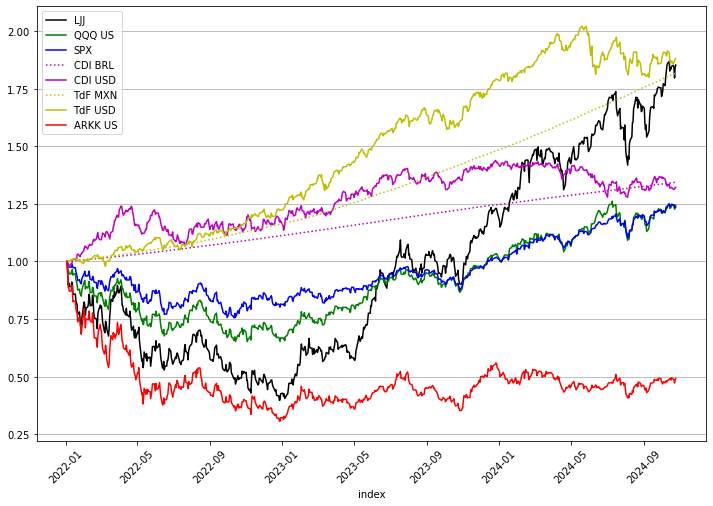

Performances:
               LJJ  QQQ US    SPX  ARKK US  CDI USD  TdF USD
index                                                       
2022-12-31  -57.31  -33.22 -18.65   -67.79    17.16    22.29
2023-12-31  184.64   54.03  24.76    67.64    22.11    46.46
2024-12-31   52.49   20.95  21.82    -8.97    -7.62     4.97


Volatilities:
              LJJ  QQQ US    SPX  ARKK US  CDI USD  TdF USD
index                                                      
2022-12-31  58.68   31.46  22.88    67.53    16.63     9.38
2023-12-31  48.18   23.86  17.94    50.00    14.55    10.71
2024-12-31  32.34   17.73  12.78    37.61    11.48    11.79


Drawdowns:
              LJJ  QQQ US    SPX  ARKK US  CDI USD  TdF USD
index                                                      
2022-12-31 -56.89  -34.83 -24.50   -66.85   -13.72    -4.91
2023-12-31 -54.75  -29.89 -16.73   -62.04    -8.44    -5.71
2024-12-31 -18.35  -13.50  -8.63   -27.21   -11.09   -11.02


CAGR:
              LJJ  QQQ US    SPX  ARKK US  C

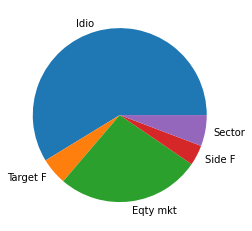


Current Allocations:
                        Delta
Ticker                       
Data Software           33.15
Hardware                20.66
Consumer Services       14.93
Application Software     8.76
Fintech                  7.16
Consumer Discretionary   6.62
Health Care              3.40
Energy                   1.97
Materials                1.30
Industrials              0.77
Staples                  0.72
Pharmaceuticals          0.56



Total    Idio    Mkt  TargetF  SecF  Sector  Macro
2022  -57.31  -28.38 -20.94    -0.51 -2.39   -2.95  -2.14
2023  184.64  108.80  69.45    -1.55  1.28   10.82  -4.16
2024   52.49   27.21   9.29     7.33  6.52    2.79  -0.65

In [411]:
#LJJ EQUITIES

def on_selection_class(value):
    global target_class
    target_class = value
    root.destroy()

init_dt = datetime(2022, 1, 1).date()
last_dt = Pxs_df.index[-1]
long_w = 252

Pxs_df = open_df('prices_relation')
fxPxs_df = open_df('fxprices_relation')
FactRets_df = open_df('factor_returns_ridge_cs5')
Idio_df = open_df('idio_returns_ridge_cs5')
dt_range = Pxs_df[Pxs_df.index >= init_dt].index.tolist()
dt_range = [dt for dt in dt_range if dt in FactRets_df.index]
existing = False
try:
    LJJPnL_df = open_df('ljj_breakdown')
    LJJFPnL_df = LJJPnL_df.drop(['Idio'], axis = 1)
    LJJIPnL_s = LJJPnL_df['Idio']
    existing = True
except:
    LJJFPnL_df = pd.DataFrame(np.nan, index = dt_range, columns = FactRets_df.columns)
    LJJIPnL_s = pd.Series(np.nan, index = dt_range)
    LJJIPnL_s.name = 'Idio'
    
try:
    rLJJp_df = open_df('ljj_pnl_series')
    rLJJp_s = rLJJp_df[rLJJp_df.columns[0]]
except:
    rLJJp_s = pd.Series(1, index = dt_range)
    rLJJp_s.name = 'LJJ'

fxPxs_df['USDUSD'] = 1
fxPxs_df['GBPUSD'] /= 100
AFTPYinit_px = 88.98639
t_dikt = {'CAPA US': 'QSI', 'MTTR US': 'MTTR', 'SIVB US': 'SIVB', 'ARKG US': 'ARKG', 'VKTX US': 'VKTX', 
          'CPRI US': 'CPRI', 'CLSK US': 'CLSK'}
region_dikt = {'US': 'USDUSD', 'LN': 'GBPUSD', 'GR': 'EURUSD', 'CN': 'USDUSD', 'NA': 'EURUSD', 'FP': 'EURUSD'}
exclusion_l = ['BABA US', 'XPEV US', 'NIO US', 'TME US', 'JD US', 'PDD US', 'VNET US', 'ZLAB US', 'WB US', 
               'OCFT US', 'BGNE US', 'MOMO US', 'ZTO US', 'NTES US']
all_fundamentals_l = ['sP/S', 'sP/E', 'sP/GP', 'P/S', 'P/Ee', 'P/GP', 'P/Eo', 'OM-t0', 'OM', 'OMd', 'GS', 'GE', 'r2 S', 'r2 E', 
                      'GGP', 'r2 GP', 'Size', 'ROI-P', 'ROI', 'ROId','ROE-P', 'ROE', 'ROEd', 'S Vol', 'E Vol', 'GP Vol', 'r&d']
m_features_l = ['T10YIE', 'VIX', '2Y IR Vol', 'USGG2YR', 'US10YR RR', 'Brent USD/Bbl', 'M2MP Velocity']
c_features_l = ['Ideal', 'Size', 'Value']
p_features_l = ['Beta', 'Momentum', 'Vol'] 
mkt_features = ['Market', 'Beta', 'Idio Comp']
target_features = ['Ideal', 'Momentum']
secondary_features = ['Size', 'Value', 'Vol']
idio_features = ['Idio']
SLICEall_features_l = ['Market'] + p_features_l + sector_l + c_features_l + m_features_l 

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
class_list = Sectors_df.columns.tolist()

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *class_list, command = on_selection_class)
tk.Label(root, text = "Choose a classification: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

print(target_class)
print('')
secExt = '_cs' + target_class[-1]
sector_l = pd.unique(Sectors_df.dropna(subset = [target_class])[target_class]).tolist()
sector_s = Sectors_df[Sectors_df[target_class].isna() == False][target_class]
sector_features = pd.unique(sector_s.tolist())

portINIT = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\portfolio_2021ye.csv")
portINIT_df = pd.DataFrame(portINIT)
portINIT_df = Set_DF(portINIT_df)
portINIT_df = DD_Index(portINIT_df)
portINIT_df = portINIT_df.rename(index = {'DHER GY': 'DHER GR', 'SHOP US': 'SHOP CN', 'GOOG US': 'GOOGL US'})

try:
    query_trades = 'SELECT * FROM trades_2022on'    
    portTRADES_df = pd.read_sql_query(query_trades, engine)
    portTRADES_df = Set_DF(portTRADES_df)
except:
    portTRADES = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\trades_2022on.csv")
    portTRADES_df = pd.DataFrame(portTRADES)
    portTRADES_df['Trade Date'] = portTRADES_df['Trade Date'].map(lambda x: datetime.strptime(x, '%d-%b-%y').date())          

c_today = datetime.today().date()
new_trade = True
print('Last 10 trades...')
print(portTRADES_df[-10:])
print('')
print('Input new trades...')
save_new = False
while (new_trade):
    idx = portTRADES_df.shape[0]
    ask_confirm = True
    while (ask_confirm):
        traded_t = input('Enter ALGO ticker (empty to finish): ').upper()
        if (traded_t != ''):
            if traded_t in Pxs_df.columns:
                ask_confirm = False
            else:
                confirm = input(traded_t + ' not in Pxs relation, confirm (Y/y or empty): ').upper()
                if (confirm == 'Y'):
                    ask_confirm = False
        else:
            new_trade = False
            ask_confirm = False
    if (new_trade):
        save_new = True
        portTRADES_df.loc[idx] = np.nan
        portTRADES_df.loc[idx, 'Ticker'] = traded_t
        portTRADES_df.loc[idx, 'Region'] = traded_t.split(' ')[1]
        ask_confirm = True
        while (ask_confirm):
            qtty = input('Enter quantity: ')
            try:
                portTRADES_df.loc[idx, 'Quantity'] = int(qtty)
                ask_confirm = False
            except:
                print('Enter quantity again') 
        ask_confirm = True
        while (ask_confirm):
            qtty = input('Enter price: ')
            try:
                portTRADES_df.loc[idx, 'Px'] = float(qtty)
                ask_confirm = False
            except:
                print('Enter price again')                 
        ask_confirm = True
        while (ask_confirm):
            t_dt = input('Enter date (YY/MM/DD or empty for today): ')
            if (t_dt == ''):
                portTRADES_df.loc[idx, 'Trade Date'] = c_today
                ask_confirm = False
            else:
                try:
                    portTRADES_df.loc[idx, 'Trade Date'] = datetime.strptime(t_dt, '%y/%m/%d').date()
                    ask_confirm = False
                except:
                    print('Enter date again') 
                    
portTRADES_df = portTRADES_df.sort_index()
if (save_new):
    portTRADES_df.to_sql('trades_2022on', engine, index = True, if_exists = 'replace')
    
dt_range = Pxs_df[Pxs_df.index >= init_dt].index.tolist()
dt_range = [dt for dt in dt_range if dt in FactRets_df.index]
dt_range = [dt for dt in dt_range if dt not in LJJPnL_df.dropna(how = 'all').index]
update = False
if (rLJJp_s.dropna().shape[0] > 0) & (len(dt_range) > 0):
    update = True
    p_dt = rLJJp_s.index[rLJJp_s.index.tolist().index(dt_range[0]) - 1]
for idx, c_dt in enumerate(dt_range):
    save_new = True
    print(c_dt)
    pred_dt = c_dt
    valid_start = False
    while (not valid_start):
        pred_df, c_date = get_predictors(pred_dt, exclusion_l)
        exc_ffields = [f for f in all_fundamentals_l if f not in pred_df.columns]
        exc_tickers = [t for t in pred_df.index if t not in sector_s.index]
        if (len(exc_ffields) == 0):
            pred_df = pred_df.drop(exc_tickers)
            valid_start = True
            print('Fundamentals date: ' + c_date.strftime('%d-%b-%Y') + ', curr dt: ' + c_dt.strftime('%d-%b-%Y'))
        else:
            pred_dt = Pxs_df[Pxs_df.index < pred_dt].index[-1]    
    
    SportTRADES_df = portTRADES_df[portTRADES_df['Trade Date'] <= c_dt]
    portPOS_df = pd.DataFrame(SportTRADES_df.groupby(['Ticker']).sum()['Quantity'])
    portPOS_df = portPOS_df.join(portINIT_df, how = 'outer', rsuffix = '_init')
    portPOS_df = pd.DataFrame(portPOS_df.sum(axis = 1).values, index = portPOS_df.sum(axis = 1).index, columns = ['Quantity'])
    portPOS_df = portPOS_df.replace({0: np.nan}).dropna()

    nCovered_l = [t for t in portPOS_df.index if t not in pred_df.index]
    Covered_l = [t for t in portPOS_df.index if t in pred_df.index]
    print('STOCKS NOT COVERED:')
    print(nCovered_l)

    covPOS_df = portPOS_df.loc[Covered_l]
    USDcash_df = pd.DataFrame((covPOS_df.values.T * covPOS_df.index.map(lambda x: Pxs_df.iloc[-1][x]).values * 
                               covPOS_df.index.map(lambda x: fxPxs_df.iloc[-1][region_dikt[x.split(' ')[1]]]).values).T, 
                              index = covPOS_df.index, columns = ['Delta'])
    alloc_df = round(USDcash_df / USDcash_df.sum(), 4)

    sPxs_df = Pxs_df[Pxs_df.index < c_dt][-long_w: ]
    Check_s = round(100 * sPxs_df[pred_df.index].pct_change().rolling(volCheck_w).std().iloc[-1], 4)
    SBweights_s = np.log(pred_df['Size'])
    sizeExc_l = SBweights_s[SBweights_s.replace({np.inf: np.nan, -np.inf: np.nan}).isna()].index.tolist()
    zeroVol_l = Check_s[Check_s == 0].index.tolist()
    excall_l = pd.unique(sizeExc_l + zeroVol_l).tolist()
    pred_df = pred_df.drop(excall_l)
    asset_l = pred_df.index.tolist()
    FlatWeights_s = pd.Series(1, index = pred_df.index)

    MacroPxs_df = sPxs_df[macroFeatures_l]    
    sMkt_s = sPxs_df[anchor_asset]
    sPxs_df = sPxs_df[asset_l]

    featuresP_df = predictors_to_Pfeatures(sPxs_df, p_features_l, sector_s)
    featuresC_df = predictors_to_Cfeatures(pred_df, c_features_l, sector_s)
    featuresM_df, MacroFeatures_df = predictors_to_Mfeatures(MacroPxs_df, sPxs_df, m_features_l, sector_s)
    XSStyleLoadings_df = featuresP_df.join(featuresC_df)

    # FACTOR ORTHOGONALIZATION

    sBetas_s = featuresP_df['Beta']
    FactorLoadings_df = pd.DataFrame(sBetas_s)

    sIdeal_s = featuresC_df['Ideal']
    FactorLoadings_df[sIdeal_s.name] = othogonalize(FactorLoadings_df, sIdeal_s)    

    XSSectorLoadings_df = pd.DataFrame(0, index = asset_l, columns = sector_l)
    for c_sector in sector_l:
        stock_l = [t for t in asset_l if t in sector_s[sector_s == c_sector].index]
        XSSectorLoadings_df.loc[stock_l, c_sector] = 1   
    XSSectorLoadings_df = (XSSectorLoadings_df - XSSectorLoadings_df.mean())
    sectorR_l = sector_l.copy()
    sectorR_l.remove(sacr_sector)
    for c_sector in sectorR_l:
        FactorLoadings_df[c_sector] = othogonalize(FactorLoadings_df, XSSectorLoadings_df[c_sector]).values        

    sSize_s = featuresC_df['Size']
    FactorLoadings_df[sSize_s.name] = othogonalize(FactorLoadings_df, sSize_s)

    for c_Sfeat in XSStyleLoadings_df.columns:
        if (c_Sfeat not in FactorLoadings_df.columns):
            FactorLoadings_df[c_Sfeat] = othogonalize(FactorLoadings_df, XSStyleLoadings_df[c_Sfeat]).values

    for c_Mfeat in m_features_l:
        FactorLoadings_df[c_Mfeat] = othogonalize(FactorLoadings_df, featuresM_df[c_Mfeat]).values

    FactorLoadings_df['Market'] = 1
    FactorLoadings_df[sacr_sector] = XSSectorLoadings_df[sacr_sector]
    PFactorLoadings_df = FactorLoadings_df.loc[covPOS_df.index]

    LJJFactorMap_df = alloc_df.values * PFactorLoadings_df
    LJJFPnL_df.loc[c_dt] = (10000 * LJJFactorMap_df.sum() * FactRets_df.loc[c_dt]).map(lambda x: round(x, 1))
    LJJIPnL_s.loc[c_dt] = round((10000 * alloc_df.loc[Covered_l].T * Idio_df.loc[c_dt, Covered_l]).T.sum()[0], 1)
    
    if (idx > 0) | (update):
        cPxs_s = pd.Series(Palloc_df.index.map(lambda x: Pxs_df.loc[c_dt, x]) * 
                           Palloc_df.index.map(lambda x: fxPxs_df.loc[c_dt, region_dikt[x.split(' ')[1]]]).values, 
                           index = Palloc_df.index).map(lambda x: round(x, 2))
        pPxs_s = pd.Series(Palloc_df.index.map(lambda x: Pxs_df.loc[p_dt, x]) * 
                           Palloc_df.index.map(lambda x: fxPxs_df.loc[p_dt, region_dikt[x.split(' ')[1]]]).values, 
                           index = Palloc_df.index).map(lambda x: round(x, 2)) 
        rLJJp_s.loc[c_dt] = (Palloc_df.T * cPxs_s / pPxs_s).T.sum()[0] * rLJJp_s.loc[p_dt]
    
    Palloc_df = alloc_df.copy()
    p_dt = c_dt
        
if (save_new):
    LJJFPnL_df = LJJFPnL_df.sort_index()
    LJJIPnL_s = LJJIPnL_s.sort_index()
    if (existing):
        newDT_l = [dt for dt in LJJFPnL_df.index if dt not in LJJPnL_df.index]
        for dt in newDT_l:
            LJJPnL_df.loc[dt] = np.nan
            LJJPnL_df.loc[dt, LJJFPnL_df.columns] = LJJFPnL_df.loc[dt].values
            LJJPnL_df.loc[dt, LJJIPnL_s.name] = LJJIPnL_s.loc[dt]
    else:
        LJJPnL_df = LJJFPnL_df.join(LJJIPnL_s)           
    LJJFD_s = LJJPnL_df.sum(axis = 1)
    LJJRD_s = round(10000 * rLJJp_s.pct_change(), 1).fillna(LJJPnL_df.sum(axis = 1).iloc[0])
    LJJPnL_df['Idio Comp'] = (LJJRD_s - LJJFD_s)        
mainR = LJJFactorMap_df.sum().sort_values(ascending = False).index[0]
print('')
print('LJJ Factor Betas:')
print(round(LJJFactorMap_df.sum(), 2).sort_values(ascending = False))
print('')
print('Main aggressors - ' + mainR)
print(round(((LJJFactorMap_df[mainR] / alloc_df.T).T).sort_values(by = ['Delta'], ascending = False).dropna(), 2))
print('')
print('Quality map:')
print(round(((LJJFactorMap_df['Ideal'] / alloc_df.T).T).sort_values(by = ['Delta'], ascending = False).dropna(), 2))
print('')
print('FULL MAP:')
Summary_s = round(LJJPnL_df.sum() / 100, 2)
Summary_s.loc['Total'] = Summary_s.sum()
print('')
print(Summary_s)
print('')
LJJ_tot = LJJPnL_df[LJJPnL_df.index >= datetime(today.year, 1, 1).date()].sum().sum()
print('YTD (%): ' + str(round(LJJ_tot / 100, 2)))
print('')
print('P&L attribution YTD (%):')
print(round(LJJPnL_df[LJJPnL_df.index >= datetime(2024, 1, 1).date()].sum() / 100, 2))
print('')
LJJ_ld = LJJPnL_df.iloc[-1].sum()
print('LD (bps): ' + str(round(LJJ_ld, 2)))
print('')
print('P&L attribution LD (bps):')
print(round(LJJPnL_df.iloc[-1], 2))
print('')

if (save_new):
    LJJPnL_df.to_sql('ljj_breakdown', engine, index = True, if_exists = 'replace')
    pd.DataFrame(rLJJp_s).to_sql('ljj_pnl_series', engine, index = True, if_exists = 'replace')
print('')

SummaryP_df = pd.DataFrame((LJJPnL_df.sum(axis = 1) / 10000 + 1).expanding().apply(np.prod), columns = ['LJJ'])
qqq_s = Pxs_df['QQQ US'].loc[SummaryP_df.index] / Pxs_df['QQQ US'].loc[SummaryP_df.index].iloc[0]
spx_s = Pxs_df['SPX'].loc[SummaryP_df.index] / Pxs_df['SPX'].loc[SummaryP_df.index].iloc[0]
arkk_s = Pxs_df['ARKK US'].loc[SummaryP_df.index] / Pxs_df['ARKK US'].loc[SummaryP_df.index].iloc[0]
CDI_basis = 1.5
TDF_basis = 1.5
br_macro = open_df('br_macro')
cdiR_s = pd.DataFrame(spx_s).join((br_macro['SELIC RATE'] - CDI_basis) / 100).fillna(method = 'ffill').fillna(method = 'bfill')['SELIC RATE']
cdi_s = (cdiR_s + 1) ** (1 / 252)
cdiBR_s = cdi_s.expanding().apply(np.prod)
cdiUS_s = cdiBR_s * (fxPxs_df.loc[cdiBR_s.index[0], 'USDBRL'] / cdiBR_s.index.map(lambda x: fxPxs_df.loc[x, 'USDBRL'])).values
cdiBR_s.name = 'CDI BRL'
cdiUS_s.name = 'CDI USD'
mx_macro = open_df('mx_macro').rename(columns = {'INTEREST RATE DEC': 'TdF'})
tdfR_s = pd.DataFrame(spx_s).join((mx_macro['TdF'] - TDF_basis) / 100).fillna(method = 'ffill').fillna(method = 'bfill')['TdF']
tdf_s = (1 + tdfR_s / 100)
tdfMX_s = tdf_s.expanding().apply(np.prod)
tdfUS_s = tdfMX_s * (fxPxs_df.loc[tdfMX_s.index[0], 'USDMXN'] / tdfMX_s.index.map(lambda x: fxPxs_df.loc[x, 'USDMXN'])).values
tdfMX_s.name = 'TdF MXN'
tdfUS_s.name = 'TdF USD'

SummaryP_df.plot(c = 'k', figsize = (12, 8))
qqq_s.plot(c = 'g')
spx_s.plot(c = 'b')
cdiBR_s.plot(c = 'm', linestyle = 'dotted')
cdiUS_s.plot(c = 'm')
tdfMX_s.plot(c = 'y', linestyle = 'dotted')
tdfUS_s.plot(c = 'y')
arkk_s.plot(c = 'r').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

anchor = 'QQQ US'
SummaryP_df = SummaryP_df.join(qqq_s).join(spx_s).join(arkk_s).join(cdiUS_s).join(tdfUS_s)
SummaryP_df.index = SummaryP_df.index.map(lambda x: datetime(x.year, x.month, x.day))
SummaryPY_df = SummaryP_df.resample('Y').last()
SummaryPY_df.loc[SummaryP_df.index[0]] = 1
SummaryPY_df = SummaryPY_df.sort_index()
SummaryPY_df = round(100 * SummaryPY_df.pct_change(), 2).dropna()
print('Performances:')
print(SummaryPY_df)
print('')

SummaryV_df = round(100 * SummaryP_df.pct_change().ewm(halflife = 84).std() * np.sqrt(252), 2).dropna()
SummaryVY_df = round(SummaryV_df.resample('Y').mean(), 2)
print('')
print('Volatilities:')
print(SummaryVY_df)
print('')

SummaryD_df = round(100 * (SummaryP_df / SummaryP_df.rolling(252, min_periods = 21).max() - 1), 2).dropna()
SummaryDY_df = SummaryD_df.resample('Y').min()
print('')
print('Drawdowns:')
print(SummaryDY_df)
print('')

SummaryC_df = round(100 * ((SummaryP_df[1: ].T ** (252 / SummaryP_df[1:].index.map(lambda x: (x - SummaryP_df.index[0]).days).values)).T - 1), 2)
SummaryCY_df = SummaryC_df.resample('Y').last()
print('')
print('CAGR:')
print(SummaryCY_df)
print('')

SummaryCDY_df = round(SummaryCY_df / abs(SummaryDY_df), 2)
print('')
print('CAGR/DD:')
print(SummaryCDY_df)
print('')

SummarySY_df = round(SummaryPY_df / abs(SummaryVY_df), 2)
print('')
print('Sharpe:')
print(SummarySY_df)
print('')

SummaryCorr_df = SummaryP_df.rolling(252).corr(SummaryP_df[anchor].rolling(252))
SummaryCorrY_df = SummaryCorr_df.resample('Y').mean()
SummaryBY_df = round(SummaryCorrY_df * (SummaryVY_df.T / SummaryVY_df[anchor]).T, 2)
print('')
print('Betas ' + anchor + ':')
print(SummaryBY_df)
print('')

SummaryAY_df = round(SummaryPY_df - (SummaryBY_df.T * SummaryPY_df[anchor]).T, 2)
print('')
print('Alphas ' + anchor + ':')
print(SummaryAY_df)
print('')
print('P&L breakdown since ' + LJJPnL_df.index[0].strftime('%d-%b-%Y') + ':')
round(LJJPnL_df.sum() / 100, 2).sort_values(ascending = False)

mkt_ttl = round(LJJPnL_df[mkt_features].sum().sum() / 100, 2)
macro_ttl = round(LJJPnL_df[m_features_l].sum().sum() / 100, 2)
target_ttl = round(LJJPnL_df[target_features].sum().sum() / 100, 2)
secondary_ttl = round(LJJPnL_df[secondary_features].sum().sum() / 100, 2)
sector_ttl = round(LJJPnL_df[sector_features].sum().sum() / 100, 2)
idio_ttl = round(LJJPnL_df[idio_features].sum().sum() / 100, 2)
print('')
print('P&L Summary (%):')
print('Idiosyncratic total: ' + str(idio_ttl))
print('Equity mkt risk total: ' + str(mkt_ttl))
print('Target feat total: ' + str(target_ttl))
print('Secondary feat total: ' + str(secondary_ttl))
print('Sector total: ' + str(sector_ttl))
print('Macro total: ' + str(macro_ttl))
print('')

pnl_l = [idio_ttl, target_ttl, mkt_ttl, secondary_ttl, sector_ttl, macro_ttl]
labels_l = ['Idio', 'Target F', 'Eqty mkt', 'Side F', 'Sector', 'Macro']
if (min(pnl_l) < 0):
    for idx, c_pnl in enumerate(pnl_l):
        if (c_pnl < 0):
            pnl_l.remove(c_pnl)
            labels_l.remove(labels_l[idx])
Npnl_l = pd.Series(np.array(pnl_l) / np.sum(np.array(pnl_l))).map(lambda x: round(100 * x, 2)).tolist()
plt.pie(Npnl_l, labels = labels_l)
plt.show()

print('')
print('Current Allocations:')
print(round(100 * alloc_df.groupby(alloc_df.index.map(lambda x: sector_s.loc[x])).sum().sort_values(by = alloc_df.columns[0], ascending = False), 2))
print('')

YearlySummary_df = pd.DataFrame(np.nan, index = pd.unique(LJJPnL_df.index.map(lambda x: x.year)).tolist(), columns = 
                                ['Total', 'Idio', 'Mkt', 'TargetF', 'SecF', 'Sector', 'Macro'])
LJJYPnL_df = LJJPnL_df.groupby(LJJPnL_df.index.map(lambda x: x.year)).sum() / 100
YearlySummary_df['Total'] = SummaryPY_df['LJJ'].values
YearlySummary_df['Idio'] = LJJYPnL_df[idio_features].sum(axis = 1)
YearlySummary_df['Mkt'] = LJJYPnL_df[mkt_features].sum(axis = 1)
YearlySummary_df['TargetF'] = LJJYPnL_df[target_features].sum(axis = 1)
YearlySummary_df['SecF'] = LJJYPnL_df[secondary_features].sum(axis = 1)
YearlySummary_df['Sector'] = LJJYPnL_df[sector_features].sum(axis = 1)
YearlySummary_df['Macro'] = LJJYPnL_df[m_features_l].sum(axis = 1)
YearlySummary_df[['Idio', 'Mkt', 'TargetF', 'SecF', 'Sector', 'Macro']]
YearlySummary_df[['Idio', 'Mkt', 'TargetF', 'SecF', 'Sector', 'Macro']] = (YearlySummary_df[['Idio', 'Mkt', 'TargetF', 'SecF', 'Sector', 'Macro']].T * (YearlySummary_df['Total'] / YearlySummary_df[['Idio', 'Mkt', 'TargetF', 'SecF', 'Sector', 'Macro']].sum(axis = 1))).T
YearlySummary_df = round(YearlySummary_df, 2)
YearlySummary_df

In [553]:
#LONG ONLY VS LONG/SHORT PORTFOLIOS

port_size = 20
init_cap = 1000000
LS_exclusion_l = ['SPWR US', 'TWOU US']
LS_exclusion_l = [t for t in LS_exclusion_l if t in ALLfeatures_df.index]

int_features_l = ['Momentum', 'Quality']
scope_features_l = int_features_l + m_features_l + ['Beta', 'Vol', 'Value', 'Size']
concentration_f = 5
idio_w = 5
momentum_r = [1, 2, 4]
quality_r = [1, 2, 4]
hl_idio = 252

FactRets_df = FactRets_df.dropna(how = 'all')
Idio_df = Idio_df.dropna(how = 'all')

FactorLoadings_df['Market'] = 1
FactorLoadings_df['Beta'] = featuresP_df['Beta']
FactorLoadings_df[sector_l] = XSSectorLoadings_df[sector_l] 
FactorLoadings_df['Size'] = featuresC_df['Size']
FactorLoadings_df[INDFeatures_l] = XSStyleLoadings_df[INDFeatures_l]
FactorLoadings_df[m_features_l] = featuresM_df[m_features_l]  
ALLfeatures_df = FactorLoadings_df.join(XSAssetRets)
MALLfeatures_df = ALLfeatures_df.drop(LS_exclusion_l)

best_sharpe = -np.inf
cv_df = pd.DataFrame(np.nan, index = np.arange(len(momentum_r) + len(quality_r)) + 1, columns = xv_list)
c = 1
beta_adj = True
for momentum_w in momentum_r:
    for quality_w in quality_r:
        QualMLRfExp_s = round(100 * (ALLfeatures_df['Quality'].clip(0, ALLfeatures_df['Quality'].max()) * 
                                     FactRets_df['Quality'].dropna(how = 'all').ewm(halflife = hl).mean().iloc[-1] / 
                                     FactRets_df['Quality'].dropna(how = 'all').ewm(halflife = hl).std().iloc[-1]), 2)
        MomMLRfExp_s = round(100 * (ALLfeatures_df['Momentum'].clip(0, ALLfeatures_df['Momentum'].max()) * 
                                    FactRets_df['Momentum'].dropna(how = 'all').ewm(halflife = hl).mean().iloc[-1] / 
                                    FactRets_df['Momentum'].dropna(how = 'all').ewm(halflife = hl).std().iloc[-1]), 2)
        IdioMLRfExp_s = round(100 * Idio_df.dropna(how = 'all')[-hl_idio:].ewm(halflife = hl_idio // 2).mean().iloc[-1].dropna() / Idio_df.dropna(how = 'all')[-hl_idio:].ewm(halflife = hl_idio // 4).std().iloc[-1].dropna(), 2)
        MomMLRfExp_s.name = 'Momentum'
        QualMLRfExp_s.name = 'Quality'
        IdioMLRfExp_s.name = 'Idio'

        expAlpha_df = pd.DataFrame(MomMLRfExp_s).join(QualMLRfExp_s).join(IdioMLRfExp_s)
        expAlpha_df /= expAlpha_df.std()
        expAlpha_df['Alloc'] = round((expAlpha_df['Momentum'] * momentum_w + expAlpha_df['Quality'] * quality_w + 
                                      expAlpha_df['Idio'] * idio_w) / (momentum_w + quality_w + idio_w), 2)

        cfLport_s = expAlpha_df.sort_values(by = ['Alloc'], ascending = False)['Alloc'].dropna()
        cLport_s = (cfLport_s[:port_size] * 100) ** concentration_f
        cLport_s /= abs(cLport_s.sum())
        cLport_s = round(100 * cLport_s, 3)

        cSport_s = expAlpha_df.sort_values(by = ['Alloc'], ascending = False)['Alloc'][-port_size:]
        cSport_s /= abs(cSport_s.sum())
        cSport_s = round(100 * cSport_s, 3)        
        
        cLport_df = pd.DataFrame(cLport_s)
        cLport_df['Naive NMV'] = round(init_cap * cLport_s / 100, 0)
        cLport_df[scope_features_l] = round((ALLfeatures_df.loc[cLport_df.index, scope_features_l].T * cLport_df['Naive NMV']).T, 1)
        beta = 1
        if (beta_adj):        
            beta = round((cLport_s / 100 * ALLfeatures_df['Beta'].loc[cLport_s.index]).sum(), 4)
        Lcov_m = Pxs_df[cLport_df.index][-5 * hl:].pct_change().dropna().ewm(halflife = hl).cov().loc[Pxs_df.index[-1]]
        cLport_vol = round(100 * ((cLport_df['Naive NMV'] / cLport_df['Naive NMV'].sum()).values.dot(Lcov_m).dot((cLport_df['Naive NMV'] / cLport_df['Naive NMV'].sum()).values) * (252)).sum() ** (1 / 2), 2)
        expA = ((expAlpha_df.loc[cLport_s.index]['Alloc'] ** 2) / expAlpha_df.loc[cLport_s.index]['Alloc'].sum()).sum() * 252
        cexpS = expA / (np.exp(beta) * cLport_vol)
        if (cexpS > best_sharpe):
            best_sharpe = cexpS
            fLport_s = cfLport_s.copy()
            Lport_s = cLport_s.copy()
            Sport_s = cSport_s.copy()
            Lport_df = cLport_df.copy()
            Lport_vol = cLport_vol
        cv_df.loc[c, 'M W'] = momentum_w
        cv_df.loc[c, 'Q W'] = quality_w
        cv_df.loc[c, 'Vol'] = cLport_vol
        cv_df.loc[c, 'Sharpe'] = round(cexpS, 3)
        cv_df.loc[c, 'Beta'] = round(beta, 3)
        c += 1

print('')
print('Cross Validation:')
print(cv_df)
print('')
#CUSTOMIZED RULES#

LS = True
if (LS):
    flatFRisk_l = []
    if (Lport_df.sum().loc['2Y IR Vol'] != 0):
        flatFRisk_l.append('2Y IR Vol')
    if (Lport_df.sum().loc['T10YIE'] != 0):
        flatFRisk_l.append('T10YIE')
    if (Lport_df.sum().loc['USGG2YR'] != 0):
        flatFRisk_l.append('USGG2YR')  
    if (Lport_df.sum().loc['VIX'] != 0):
        flatFRisk_l.append('VIX')  
    if (Lport_df.sum().loc['Brent USD/Bbl'] != 0):
        flatFRisk_l.append('Brent USD/Bbl') 
    if (Lport_df.sum().loc['M2MP Velocity'] != 0):
        flatFRisk_l.append('M2MP Velocity') 
    if (Lport_df.sum().loc['US10YR RR'] != 0):
        flatFRisk_l.append('US10YR RR')     
    if (Lport_df.sum().loc['Beta'] != 0):
        flatFRisk_l.append('Beta')  
    if (Lport_df.sum().loc['Size'] != 0):
        flatFRisk_l.append('Size') 
    if (Lport_df.sum().loc['Value'] != 0):
        flatFRisk_l.append('Value')  
    if (Lport_df.sum().loc['Vol'] != 0):
        flatFRisk_l.append('Vol')          
    
    Sport_df = pd.DataFrame(Sport_s)
    Sport_df['Naive NMV'] = round(init_cap * Sport_s / 100, 0)
    Sport_df[scope_features_l] = round((MALLfeatures_df.loc[Sport_df.index, scope_features_l].T * Sport_df['Naive NMV']).T, 1)  
    
    LSport_df = pd.concat([Lport_df, Sport_df])    
    x_a = MALLfeatures_df.loc[LSport_df.index][flatFRisk_l].values
    y_a = np.array(((Lport_s.values * abs(Lport_s.sum() / 100)).tolist() + (Sport_s.values * abs(Sport_s.sum() / 100)).tolist()))
    LR_mod = LinearRegression()
    LRHedge_mod = LR_mod.fit(x_a, y_a)
    unwantedR_a = LRHedge_mod.predict(x_a)
    wantedR_s = pd.Series(y_a - unwantedR_a, index = LSport_df.index)
    wantedR_s /= abs(wantedR_s).sum()
    wantedR_s.name = 'Alloc'

    CleanPort_df = round(pd.DataFrame(wantedR_s * init_cap), 1)
    CleanPort_df[scope_features_l] = round((MALLfeatures_df.loc[LSport_df.index, scope_features_l].T * CleanPort_df['Alloc']).T, 1)
    CleanPort_df['Alloc'] = round(100 * CleanPort_df['Alloc'] / init_cap, 3)
    CleanPort_df = CleanPort_df.sort_values(by = ['Alloc'], ascending = False)    
      
    LScov_m = Pxs_df[CleanPort_df.index][-5 * hl:].pct_change().dropna().ewm(halflife = hl).cov().loc[Pxs_df.index[-1]]
    LSport_vol = round(100 * ((CleanPort_df['Alloc'] / 100).values.dot(LScov_m).dot((CleanPort_df['Alloc'] / 100).values) * (252)).sum() ** (1 / 2), 2)  
    CleanPort_df.loc['Total'] = round(CleanPort_df.sum(), 0)      
    print(CleanPort_df)

Lport_df['VOL'] = round(100 * Pxs_df[-5 * hl:][Lport_df.index].pct_change().dropna().ewm(halflife = hl).std().iloc[-1] * np.sqrt(252), 2)
Lport_df['1d P'] = round(100 * (Pxs_df[Lport_df.index].iloc[-1] / Pxs_df[Lport_df.index].iloc[-2] - 1), 2)
Lport_df['1w P'] = round(100 * (Pxs_df[Lport_df.index].iloc[-1] / Pxs_df[Lport_df.index].iloc[-5] - 1), 2)
Lport_df['1M P'] = round(100 * (Pxs_df[Lport_df.index].iloc[-1] / Pxs_df[Lport_df.index].iloc[-21] - 1), 2)
Lport_df['3M P'] = round(100 * (Pxs_df[Lport_df.index].iloc[-1] / Pxs_df[Lport_df.index].iloc[-63] - 1), 2)
Lport_df['(12 - 1)P'] = round(100 * (Pxs_df[Lport_df.index].iloc[-21] / Pxs_df[Lport_df.index].iloc[-252] - 1), 2)

y = yf.download(Lport_df.index.map(lambda x: x.split(' ')[0]).tolist(), period = '1d')
Lrt_df = y['Adj Close'].T
Lrt_df.index = Lrt_df.index.map(lambda x: x + ' US')
Lport_df['Real Time'] = ''
Lport_df.loc[Lport_df.index, 'Real Time'] = round(100 * (Lrt_df.T / Pxs_df[Lport_df.index].iloc[-1] - 1), 2).T.values

if (LS):
    z = yf.download(Sport_df.index.map(lambda x: x.split(' ')[0]).tolist(), period = '1d')
    Srt_df = z['Adj Close'].T
    Srt_df.index = Srt_df.index.map(lambda x: x + ' US')
    LSrt_df = pd.concat([Lrt_df, Srt_df])
    CleanPort_df['Real Time'] = ''
    CleanPort_df['1d P'] = round(100 * (Pxs_df[CleanPort_df.drop('Total').index].iloc[-1] / 
                                        Pxs_df[CleanPort_df.drop('Total').index].iloc[-2] - 1), 2)
    CleanPort_df['1w P'] = round(100 * (Pxs_df[CleanPort_df.drop('Total').index].iloc[-1] / 
                                        Pxs_df[CleanPort_df.drop('Total').index].iloc[-5] - 1), 2)
    CleanPort_df['1M P'] = round(100 * (Pxs_df[CleanPort_df.drop('Total').index].iloc[-1] / 
                                        Pxs_df[CleanPort_df.drop('Total').index].iloc[-21] - 1), 2)
    CleanPort_df['3M P'] = round(100 * (Pxs_df[CleanPort_df.drop('Total').index].iloc[-1] / 
                                        Pxs_df[CleanPort_df.drop('Total').index].iloc[-63] - 1), 2)    
    
    CleanPort_df.loc[CleanPort_df.drop('Total').index, 'Real Time'] = round(100 * (LSrt_df.loc[CleanPort_df.drop('Total').index].T / 
                                                                                   Pxs_df[CleanPort_df.drop('Total').index].iloc[-1] - 1), 2).T.values 
    LSlast_d = round((CleanPort_df.drop('Total')['1d P'] * CleanPort_df.drop('Total')['Alloc'] / 100).sum(), 2)
    LSlast_w = round((CleanPort_df.drop('Total')['1w P'] * CleanPort_df.drop('Total')['Alloc'] / 100).sum(), 2)
    LSlast_m = round((CleanPort_df.drop('Total')['1M P'] * CleanPort_df.drop('Total')['Alloc'] / 100).sum(), 2)
    LSlast_3m = round((CleanPort_df.drop('Total')['3M P'] * CleanPort_df.drop('Total')['Alloc'] / 100).sum(), 2)
    LSrt = round((CleanPort_df.drop('Total')['Real Time'] * CleanPort_df.drop('Total')['Alloc'] / 100).sum(), 2)

Llast_d = round((Lport_df['1d P'] * Lport_df['Alloc'] / 100).sum(), 2)
Llast_w = round((Lport_df['1w P'] * Lport_df['Alloc'] / 100).sum(), 2)
Llast_m = round((Lport_df['1M P'] * Lport_df['Alloc'] / 100).sum(), 2)
Llast_3m = round((Lport_df['3M P'] * Lport_df['Alloc'] / 100).sum(), 2)
Lrt = round((Lport_df['Real Time'] * Lport_df['Alloc'] / 100).sum(), 2)
Lport_df.loc['Total'] = np.nan
Lport_df.loc['Total', ['Alloc', 'Naive NMV', 'Momentum', 'Quality', 'Beta']] = Lport_df[['Alloc', 'Naive NMV', 'Momentum', 
                                                                                         'Quality', 'Beta']].sum()
Lport_df = Lport_df.fillna('')

print('Long Only Port vol: ' + str(Lport_vol))
print('RT Long Only: ' + str(Lrt) + '%')
print('d-1 Long Only: ' + str(Llast_d) + '%')
print('d-1w Long Only: ' + str(Llast_w) + '%')
print('d-1M Long Only: ' + str(Llast_m) + '%')
print('d-3M Long Only: ' + str(Llast_3m) + '%')
if (LS):
    print('')
    print('Long Short Port vol: ' + str(LSport_vol))
    print('RT Long Short: ' + str(LSrt) + '%')
    print('d-1 Long Short: ' + str(LSlast_d) + '%')
    print('d-1w Long Short: ' + str(LSlast_w) + '%')
    print('d-1M Long Short: ' + str(LSlast_m) + '%')
    print('d-3M Long Short: ' + str(LSlast_3m) + '%')
print('')
ttlFactorExp_s = (MALLfeatures_df[all_features_l].loc[Lport_df.drop('Total').index].T * Lport_df.drop('Total')['Naive NMV']).T.sum().astype(int)
print('Ttl Factor Exposures:')
print(ttlFactorExp_s.sort_values(ascending = False))
print('')
Lport_df[['Alloc', 'Naive NMV', 'Momentum', 'Quality', 'Beta', 'VOL', '1d P', '1w P', '1M P', '3M P', '(12 - 1)P', 'Real Time']]


Cross Validation:
   M W  F W    Vol  Sharpe    Beta
1  1.0  1.0  11.95  32.068  0.0807
2  1.0  3.0  11.56  40.971  0.0655
3  1.0  5.0  11.21  48.694  0.0606
4  3.0  1.0  14.16   4.279  0.3980
5  3.0  3.0  13.10   6.037  0.3279
6  3.0  5.0  12.83   7.023  0.3024
7  5.0  1.0  16.15   2.068  0.6308
8  5.0  3.0  13.74   3.813  0.4670
9  5.0  5.0  12.93   6.044  0.3398

         Alloc   Momentum  Fundamentals  M2MP Velocity   T10YIE  USGG2YR  \
DUOL US  2.955    11890.8       44516.0        15251.3 -11633.2  -8272.7   
BX US    2.494    -4146.9       44821.7        21387.7   4364.7 -15496.0   
PHM US   2.460    40680.4       44670.5       -20878.7   7102.7 -32071.4   
ANET US  2.426    34603.2       46045.6        31843.5  -1274.1 -20592.6   
AXP US   2.413    39903.2       47714.3        26179.7 -12245.8  -6756.5   
...        ...        ...           ...            ...      ...      ...   
LYB US  -2.592    19047.8       41688.5        21995.5 -19273.8 -39908.4   
CHGG US -2.673    4397

Alloc  Naive NMV  Momentum  Fundamentals     Beta    VOL  1d P  \
DUOL US   4.342    43420.0   17474.8       65420.8  61919.0  50.49  3.19   
CMG US    3.816    38160.0   37060.2       71144.8 -14996.9  34.28  1.67   
WAB US    3.793    37930.0   49779.7       65176.0  10967.1  21.32  1.44   
AXP US    3.725    37250.0   61598.1       73656.1  36180.1   24.7  1.51   
ANET US   3.702    37020.0   52796.1       70254.3  27539.2   42.6  0.52   
NFLX US   3.496    34960.0   53834.6       67137.6  18057.5  24.88  1.42   
TT US     3.473    34730.0   57430.9       47590.7  21887.2   23.5  1.03   
CAG US    3.473    34730.0   17927.6       68673.2 -45236.8  21.82 -0.79   
CMS US    3.473    34730.0   10027.2       52752.7 -25494.2  15.06  -0.1   
NEM US    3.451    34510.0   45291.3       66879.6   9978.2  31.72 -0.34   
ADP US    3.405    34050.0   -5660.8       61363.6 -52093.4  15.56  0.28   
ADSK US   3.382    33820.0    9764.5       66873.8  13623.7  26.56  -0.2   
BX US     3.382    33820.0   -5622.6       60771.0  48229.0  28.26  0.39   
ORCL US   3.382    33820.0   21304.9       63154.6   9778.7  36.96 -1.51   
PHM US    3.359    33590.0   55545.8       60994.0  28806.4  31.13 -0.48   
GRMN US   3.268    32680.0   39172.2       55150.9 -38851.3  25.43 -0.34   
FTNT US   3.268    32680.0   16869.4       53129.0 -53712.8  47.69  -0.7   
RMD US    3.199    31990.0   38345.1       50659.6  20160.4  38.44 -0.16   
QTWO US   3.176    31760.0   52519.6       47243.0  34458.9  37.71  1.75   
ABT US    3.154    31540.0   -5243.5       56272.4 -44667.5  18.95  0.14   
PAYX US   3.154    31540.0   -8831.2       56408.2 -44667.5   18.4  -0.2   
FSLR US   3.085    30850.0   47505.6       53190.4  29964.0  57.18   1.6   
DHI US    3.085    30850.0   51014.8       53432.8   8920.0   32.3  0.04   
AME US    3.062    30620.0  -12056.3       60297.2  -8552.5  23.11  0.51   
MSI US    3.062    30620.0   26254.5       33740.1 -46845.8  15.22 -1.02   
PM US     3.016    30160.0   29290.8       59636.7 -11852.9  16.36 -2.48   
HCA US    2.994    29940.0   35887.9       30970.3  -8362.5  22.24 -1.77   
PYPL US   2.948    29480.0   11864.5       47264.9  -1530.9  32.54  0.18   
CRWD US   2.948    29480.0   42042.9       46564.0  28633.3  48.91  0.71   
NVDA US   2.925    29250.0   48369.0       57687.8  48362.8   59.7 -0.87   
Total    99.998   999980.0  891557.6     1723490.1  60600.5                

         1w P   1M P   3M P (12 - 1)P Real Time  
DUOL US  8.94  18.08  17.86     22.83     -1.56  
CMG US   5.05  12.44  -9.13     39.32     -0.02  
WAB US   5.18   8.02   7.85      52.6     -0.95  
AXP US   4.41   4.91  15.23     69.99     -0.14  
ANET US   6.0   2.22   7.72     88.99     -0.22  
NFLX US  3.48   0.96   2.81     84.23     -1.22  
TT US     5.1   7.07   11.8     75.55     -0.33  
CAG US   3.75   5.77  13.24     15.18      0.98  
CMS US   1.71   5.42  18.08     32.44     -1.33  
NEM US    4.9   2.99  24.87     45.13      -0.4  
ADP US   0.84   5.58  12.74     11.02     -1.73  
ADSK US  3.19   6.72  11.09     20.43     -0.59  
BX US     8.1  16.38  25.06      24.7      4.49  
ORCL US  6.56  20.42  19.07     31.06      0.33  
PHM US   6.05  11.86  26.55     70.53     -0.95  
GRMN US -5.71  -2.65   6.65     70.76     -0.73  
FTNT US -1.14   0.04  30.13     29.15      0.88  
RMD US  -0.69  12.23  19.62     53.19     -0.76  
QTWO US  6.52   4.62  34.59    126.24      0.21  
ABT US   1.11   6.24  11.53     16.24     -1.85  
PAYX US  1.68   8.04   7.65     10.12     -0.87  
FSLR US  0.69    8.3  -8.27     40.09     -1.83  
DHI US   5.09   8.38  37.14     69.86     -0.64  
AME US   2.09   2.41  -0.01     12.45      0.14  
MSI US   0.45   2.82  13.71      56.4     -0.69  
PM US    -2.0   3.16  22.67     30.33      1.82  
HCA US   2.03   5.58  16.79     52.52     -0.15  
PYPL US   3.0  -0.78  18.57     23.31     -5.65  
CRWD US  6.61   1.56 -27.79      57.7      0.57  
NVDA US -0.34   -9.2  -8.97    186.36     -0.03  
Total

In [ ]:
## LJJ ADD ANALYSIS

LJJPort_df = open_df('ljj_portfolio')
LJJPort_last_s = LJJPort_df.iloc[-1][LJJPort_df.iloc[-1] != 0]

IntPxs_df = interest_pxs(LJJPort_last_s, Pxs_df)

missingA_l = [t for t in LJJPort_last_s.index if t not in cPort_s.index]
mPort_s = pd.Series(cPort_s.median(), index = missingA_l)
cPort_s = pd.concat([cPort_s, mPort_s]).sort_values()

cov_df = IntPxs_df.pct_change()[-252:].ewm(halflife = hl).cov().loc[IntPxs_df.index[-1]]
LJJPort_lastD_s = LJJPort_last_s.index.map(lambda x: IntPxs_df.iloc[-1][x]) * LJJPort_last_s
LJJPort_lastA_s = LJJPort_lastD_s / LJJPort_lastD_s.sum()
LJJPort_lastA_s = round(100 * LJJPort_lastA_s, 2).sort_values(ascending = False)

expVAR = round((LJJPort_lastA_s / 100).values.T.dot(cov_df.values).dot((LJJPort_lastA_s / 100).values) * 360 * 100, 4)
expVOL = round(np.sqrt((LJJPort_lastA_s / 100).values.T.dot(cov_df.values).dot((LJJPort_lastA_s / 100).values) * 360) * 100, 4)
expALPHA = (LJJPort_lastA_s * cPort_s.loc[LJJPort_lastA_s.index] / 100).sum()
expSHARPE = round(expALPHA / expVOL, 3)
print('')
print('Current expected Alpha: ' + str(expALPHA))
print('Current expected Vol: ' + str(expVOL))
print('Current expected Sharpe: ' + str(expSHARPE))

newPort_df = pd.DataFrame(np.nan, index = iPort_s.index, columns = ['Alpha Delta', 'Vol Delta', 'Sharpe Delta'])
for idx, cand_t in enumerate(iPort_s.index):
    print('Candidate: ' + cand_t + ', ' + str(idx + 1) + ' out of ' + str(iPort_s.shape[0]))
    newPort_s = LJJPort_lastA_s.copy()
    if cand_t in LJJPort_lastA_s.index:
        newPort_s.loc[cand_t] += alloc_delta
    else:
        newPort_s.loc[cand_t] = alloc_delta
    newPort_s /= newPort_s.sum()
    newPort_s = round(100 * newPort_s, 2).sort_values(ascending = False)
    
    NIntPxs_df = interest_pxs(newPort_s, Pxs_df)
    Ncov_df, NcPort_s = calc_cov(newPort_s, cPort_s, NIntPxs_df)    
    
    NexpVAR = round((newPort_s / 100).values.T.dot(Ncov_df.values).dot((newPort_s / 100).values) * 360 * 100, 4)
    NexpVOL = round(np.sqrt((newPort_s / 100).values.T.dot(Ncov_df.values).dot((newPort_s / 100).values) * 360) * 100, 4)
    NexpALPHA = (newPort_s * NcPort_s.loc[newPort_s.index] / 100).sum()   
    NexpSHARPE = round(NexpALPHA / NexpVOL, 3)
    newPort_df.loc[cand_t, 'Alpha Delta'] = NexpALPHA - expALPHA
    newPort_df.loc[cand_t, 'Vol Delta'] = NexpVOL - expVOL
    newPort_df.loc[cand_t, 'Sharpe Delta'] = NexpSHARPE - expSHARPE
    
newPort_df = round(newPort_df, 3).sort_values(by = ['Sharpe Delta'], ascending = False)    
newPort_df['Last D'] = (100 * (newPort_df.index.map(lambda x: Pxs_df.iloc[-1][x]) / 
                               newPort_df.index.map(lambda x: Pxs_df.iloc[-2][x]) - 1)).map(lambda x: round(x, 2))
newPort_df['Last W'] = (100 * (newPort_df.index.map(lambda x: Pxs_df.iloc[-1][x]) / 
                               newPort_df.index.map(lambda x: Pxs_df.iloc[-5][x]) - 1)).map(lambda x: round(x, 2))
newPort_df['Last M'] = (100 * (newPort_df.index.map(lambda x: Pxs_df.iloc[-1][x]) / 
                               newPort_df.index.map(lambda x: Pxs_df.iloc[-21][x]) - 1)).map(lambda x: round(x, 2))
print('')
print('Deltas:')
print(newPort_df)
print('')

qqq_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['QQQ US']
qqq_s /= qqq_s.iloc[0]
spx_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['SPX']
spx_s /= spx_s.iloc[0]
arkk_s = Pxs_df[Pxs_df.index >= pnl_s.index[0]]['ARKK US']
arkk_s /= arkk_s.iloc[0]
SummaryP_df = pd.DataFrame(pnl_s).join(qqq_s).join(spx_s).join(arkk_s)
annual_reports(SummaryP_df, 'SPX')

print('')
print('Best 10 candidates fundamentals: ')
pred_df.loc[newPort_df.index[:10]].T

Enter Start Date (empty for 01-Jan-2018 or YY/MM/DD): 
Override (Y/y or empty)? 
2018-01-15
2018-02-01
2018-02-15
2018-03-01
2018-03-15
2018-04-01
2018-04-15
2018-05-01
2018-05-15
2018-06-01
2018-06-15
2018-07-01
2018-07-15
2018-08-01
2018-08-15
2018-09-01
2018-09-15
2018-10-01
2018-10-15
2018-11-01
2018-11-15
2018-12-01
2018-12-15
2019-01-01
2019-01-15
2019-01-01
2019-01-15
2019-02-01
2019-02-15
2019-03-01
2019-03-15
2019-04-01
2019-04-15
2019-05-01
2019-05-15
2019-06-01
2019-06-15
2019-07-01
2019-07-15
2019-08-01
2019-08-15
2019-09-01
2019-09-15
2019-10-01
2019-10-15
2019-11-01
2019-11-15
2019-12-01
2019-12-15
2020-01-01
2020-01-15
2020-01-01
2020-01-15
2020-02-01
2020-02-15
2020-03-01
2020-03-15
2020-04-01
2020-04-15
2020-05-01
2020-05-15
2020-06-01
2020-06-15
2020-07-01
2020-07-15
2020-08-01
2020-08-15
2020-09-01
2020-09-15
2020-10-01
2020-10-15
2020-11-01
2020-11-15
2020-12-01
2020-12-15
2021-01-01
2021-01-15
2021-01-01
2021-01-15
2021-02-01
2021-02-15
2021-03-01
2021-03-15
2021-0

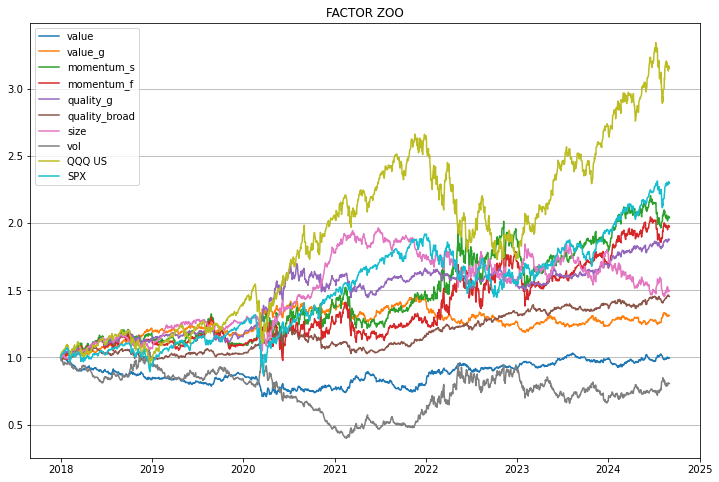

value  value_g  momentum_s  momentum_f  quality_g  quality_broad  \
2018-12-31 -16.56    21.81       18.27       14.24      14.05          -0.88   
2019-12-31   5.02    -4.39       -7.56       -4.83       1.18           3.57   
2020-12-31 -12.46    18.72       25.09       14.62      35.92           6.69   
2021-12-31   4.42     3.40        7.74        3.28       5.21           5.41   
2022-12-31  14.97   -11.69       27.49       33.40      -4.79          15.66   
2023-12-31   7.24    -2.21       -2.37       -1.28       7.68           4.01   
2024-12-31   0.84     6.16       11.24       16.37      10.89           4.73   

             size    vol  QQQ US    SPX  
2018-12-31   6.87   0.32   -0.13  -4.57  
2019-12-31  17.69 -16.18   38.96  31.22  
2020-12-31  41.50 -42.32   48.41  18.33  
2021-12-31  -2.08  23.21   27.42  28.73  
2022-12-31  -9.30  51.27  -32.58 -18.18  
2023-12-31  12.60 -25.44   54.03  24.76  
2024-12-31 -15.87  19.73   15.69  17.91

In [1139]:
# FACTOR BUILDING, PORTFOLIO SELECTION

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def factor(Prices_df, x_df, period_start):
    
    q_c = 10
    idx_st = Prices_df.index.tolist().index(period_start)
    x_df['r2 S'] = x_df['r2 S'].fillna(x_df['r2 S'].median())
    x_df['r2 E'] = x_df['r2 E'].fillna(x_df['r2 E'].median())

    x_df['P/Ee'] = pd.DataFrame(x_df['P/S'] * 1.5).join(x_df['P/Ee']).max(axis = 1)
    x_df['P/Eo'] = pd.DataFrame(x_df['P/S'] * 1.5).join(x_df['P/Eo']).max(axis = 1)
    x_df['P/E'] = ((x_df['P/Ee'] + x_df['P/Eo']) / 2).map(lambda x: round(x, 1))
    x_df['PEG'] = ((((x_df['P/Ee'] / x_df['GE']) * x_df['r2 E'] + 
                     (x_df['P/Eo'] / x_df['GS']) * x_df['r2 S'] + 
                     (x_df['P/Eo'] / x_df['GGP']) * x_df['r2 GP']) / 
                     (x_df['r2 E'] + x_df['r2 S'] + x_df['r2 GP'])) ** (-1)).map(lambda x: round(x, 2))
    x_df = x_df.replace({np.inf: np.nan, -np.inf: np.nan}).dropna(subset = ['PEG'])

    x_df['VOL'] = round(Prices_df[x_df.index][idx_st - 252: idx_st].pct_change().dropna().ewm(halflife = 21).std() * np.sqrt(360) * 100, 2).iloc[-1]
    x_df['VOL ST'] = round(Prices_df[x_df.index][idx_st - 10: idx_st].pct_change().dropna().ewm(halflife = 21).std() * np.sqrt(360) * 100, 2).iloc[-1]
    x_df['VOL ST'] = x_df['VOL ST'].replace({0: np.nan})
    x_df = x_df.dropna(subset = ['VOL ST'])
    x_df = x_df.drop(['VOL ST'], axis = 1)

    x_df['MOM SPOT 6M'] = round(100 * ((Prices_df[x_df.index].iloc[idx_st] / Prices_df[x_df.index].iloc[idx_st - 126]) - 1), 2)
    x_df['MOM SPOT 12M'] = round(100 * ((Prices_df[x_df.index].iloc[idx_st] / Prices_df[x_df.index].iloc[idx_st - 252]) - 1), 2)
    x_df['MOM M1M 6M'] = round(100 * ((Prices_df[x_df.index].iloc[idx_st - 21] / Prices_df[x_df.index].iloc[idx_st - 126]) - 1), 2)
    x_df['MOM M1M 12M'] = round(100 * ((Prices_df[x_df.index].iloc[idx_st - 21] / Prices_df[x_df.index].iloc[idx_st - 252]) - 1), 2)

    gHP_1 = 6     
    vHP_1 = 3 
    qHP_1 = 10 

    score_df = pd.DataFrame(np.nan, index = x_df.index, columns = ['dummy'])      
    score_df['Growth I'] = score_df.index.map(lambda x: x_df.loc[x, 'GS'] * (x_df.loc[x, 'r2 S'] ** gHP_1)) 
    score_df['Growth II'] = score_df.index.map(lambda x: x_df.loc[x, 'GGP'] * (x_df.loc[x, 'r2 GP'] ** gHP_1)) * 2
    score_df['Growth III'] = score_df.index.map(lambda x: x_df.loc[x, 'GE'] * (x_df.loc[x, 'r2 E'] ** gHP_1))
    score_df['Size'] = x_df['Size'] ** (-1)
    score_df['Momentum S'] = (x_df['MOM SPOT 6M'] + x_df['MOM SPOT 12M'])
    score_df['Momentum M1M'] = (x_df['MOM M1M 6M'] + x_df['MOM M1M 12M'])
    score_df['Value'] = ((x_df['P/Ee'].values * x_df['r2 E'].values + x_df['P/Eo'].values * x_df['r2 S'].values) / 
                         (x_df['r2 E'].values + x_df['r2 S'].values)) ** (-1)
    score_df['Value G'] = x_df['PEG'] ** (-1)
    
    score_df['Quality I'] = ((x_df['OM-t0'] + qHP_1 * x_df['OMd']) / 10).fillna(0)
    score_df['Quality II'] = x_df['ROId']
    score_df = score_df.drop(['dummy'], axis = 1) 
    
    factors_df = pd.DataFrame(np.nan, index = score_df.index, columns = factor_l)
    factors_df['value'] = score_df['Value']
    factors_df['value_g'] = score_df['Value G']
    factors_df['momentum_s'] = score_df['Momentum S']
    factors_df['momentum_f'] = score_df['Momentum M1M']
    factors_df['quality_g'] = score_df[['Growth I', 'Growth II', 'Growth III']].mean(axis = 1)
    factors_df['quality_broad'] = (x_df['OMd'] + x_df['ROId'] * qHP_1)
    factors_df['size'] = score_df['Size']
    factors_df['vol'] = x_df['VOL'] ** (-1)
           
    return factors_df

def on_selection_factors(value):
    global factor_option
    factor_option = value
    root.destroy() 
    
def open_factor(factor_str, st_dt, override):
    
    if (not override):
        try:
            factor_df = open_df(factor_str)
            factor_df = factor_df[factor_df.index >= st_dt]
            factor_df = factor_df.sort_index()
        except:
            factor_df = pd.DataFrame(np.nan, index = ['dummy'], columns = np.arange(200) + 1)
    else:
        factor_df = pd.DataFrame(np.nan, index = ['dummy'], columns = np.arange(200) + 1)
        
    return factor_df

def factor_idx(fL_df, fS_df, fullDT_range):

    idxL_s = pd.Series(np.nan, index = fullDT_range)
    idxS_s = pd.Series(np.nan, index = fullDT_range)
    idxLS_s = pd.Series(np.nan, index = fullDT_range)
    idxL_s.iloc[0] = 1
    idxS_s.iloc[0] = 1
    idxLS_s.iloc[0] = 1
    for c_dt in fullDT_range[1:]:
        port_dt = fL_df[fL_df.index < c_dt].index[-1]
        portL_s = fL_df.loc[port_dt][fL_df.loc[port_dt] != '']
        portS_s = fS_df.loc[port_dt][fS_df.loc[port_dt] != '']
        idxL_s.loc[c_dt] = (1 / portL_s.shape[0]) * (portL_s.map(lambda x: Pxs_df.loc[c_dt, x]) / 
                                                    portL_s.map(lambda x: Pxs_df.loc[port_dt, x])).sum() * idxL_s.loc[port_dt]
        idxS_s.loc[c_dt] = (1 / portS_s.shape[0]) * (portS_s.map(lambda x: Pxs_df.loc[c_dt, x]) / 
                                                    portS_s.map(lambda x: Pxs_df.loc[port_dt, x])).sum() * idxS_s.loc[port_dt]  
        idxLS_s.loc[c_dt] = (idxLS_s.loc[port_dt] * (idxL_s.loc[c_dt] / idxL_s.loc[port_dt]) / 
                             (idxS_s.loc[c_dt] / idxS_s.loc[port_dt]))

    return idxLS_s 

days_list = [1, 15]
selection_scope = ''
quantiles = 10
Pxs_df = open_df('prices_relation')

st_date = datetime(2018, 1, 1).date()
end_date = Pxs_df.index[-1]

st_date_str = st_date.strftime('%d-%b-%Y')
try:
    new_st_date = input('Enter Start Date (empty for ' + st_date_str + ' or YY/MM/DD): ')
    st_date = datetime.strptime(new_st_date, "%y/%m/%d").date()
except:
    pass

override = False
ovr = input('Override (Y/y or empty)? ').upper()
if (ovr == 'Y'):
    override = True

valueL_df = open_factor('value_long', st_date, override)
valueS_df = open_factor('value_short', st_date, override)
valuegL_df = open_factor('value_g_long', st_date, override)
valuegS_df = open_factor('value_g_short', st_date, override)
momentumsL_df = open_factor('momentum_s_long', st_date, override)
momentumsS_df = open_factor('momentum_s_short', st_date, override)
momentumfL_df = open_factor('momentum_f_long', st_date, override)
momentumfS_df = open_factor('momentum_f_short', st_date, override)
qualitygL_df = open_factor('quality_g_long', st_date, override)
qualitygS_df = open_factor('quality_g_short', st_date, override)
qualitybL_df = open_factor('quality_broad_long', st_date, override)
qualitybS_df = open_factor('quality_broad_short', st_date, override)
sizeL_df = open_factor('size_long', st_date, override)
sizeS_df = open_factor('size_short', st_date, override)
volL_df = open_factor('vol_long', st_date, override)
volS_df = open_factor('vol_short', st_date, override)

factor_l = ['value', 'value_g', 'momentum_s', 'momentum_f', 'quality_g', 'quality_broad', 'size', 'vol']
factorDF_dikt = {'value': [valueL_df, valueS_df], 'value_g': [valuegL_df, valuegS_df], 'momentum_s': [momentumsL_df, momentumsS_df], 
                 'momentum_f': [momentumfL_df, momentumfS_df], 'quality_g':  [qualitygL_df, qualitygS_df], 
                 'quality_broad': [qualitybL_df, qualitybS_df], 'size': [sizeL_df, sizeS_df], 
                 'vol': [volL_df, volS_df]}
factorREL_dikt = {'value': ['value_long', 'value_short'], 'value_g': ['value_g_long', 'value_g_short'], 
                  'momentum_s': ['momentum_s_long', 'momentum_s_short'], 'momentum_f': ['momentum_f_long', 'momentum_f_short'], 
                  'quality_g':  ['quality_g_long', 'quality_g_short'], 'quality_broad': ['quality_broad_long', 'quality_broad_short'], 
                  'size': ['size_long', 'size_short'], 'vol': ['vol_long', 'vol_short']}
    
factor_sel = []    
factor_zoo = factor_l.copy()
factor_zoo.append('ALL')
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *factor_zoo, command = on_selection_factors)
tk.Label(root, text = "Choose factor: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()
    
if (factor_option == 'ALL'):
    factor_sel = factor_l.copy()
else:
    factor_sel.append(factor_option)

c_dt = st_date
starter = 0
if (st_date.day >= 15):
    starter = 1
day = days_list[starter % 2]
while (c_dt < end_date):    
    port_dt = datetime(c_dt.year, c_dt.month, c_dt.day).date()
    starter += 1
    next_day = days_list[starter % 2]
    next_month = (st_date.month + starter // 2) % 13
    next_month += (next_month == 0)
    next_year = (st_date.year + (st_date.month + starter // 2) // 13)
    c_dt = datetime(next_year, next_month, next_day).date()    
    print(c_dt)
    
    valid_relation = False
    while (not valid_relation):
        try:
            stocksAlgo_df = open_df('valuation_' + port_dt.strftime('%Y%m%d') + selection_scope)
            valid_relation = True
        except:
            port_dt = port_dt - timedelta(1)        
    try:
        factors_df = factor(Pxs_df, stocksAlgo_df, port_dt)
        for c_factor in factor_sel:
            factorQ_s = factors_df[c_factor].replace({0: np.nan, np.inf: np.nan}).dropna()
            factorQ_s = pd.qcut(factorQ_s, q = quantiles, labels = False, duplicates = 'drop')          
            if (port_dt not in factorDF_dikt[c_factor][0].index) | (override):
                factorL_df.loc[port_dt] = np.nan
                L_list = factorQ_s[factorQ_s >= 7].index.tolist()
                L_list += [''] * (factorL_df.shape[1] - len(L_list)) 
                factorDF_dikt[c_factor][0].loc[port_dt] = L_list   

            if (port_dt not in factorDF_dikt[c_factor][1].index) | (override):
                factorS_df.loc[port_dt] = np.nan            
                S_list = factorQ_s[factorQ_s <= 2].index.tolist()
                S_list += [''] * (factorS_df.shape[1] - len(S_list))   
                factorDF_dikt[c_factor][1].loc[port_dt] = S_list 

    except:
        print(port_dt.strftime('%d-%b-%Y') + ' failed')
             
print('')            
for idx, c_factor in enumerate(factor_sel):  
    print(c_factor)
    factorL_Rname = factorREL_dikt[c_factor][0]
    factorS_Rname = factorREL_dikt[c_factor][1]  
    factorL_df = factorDF_dikt[c_factor][0]
    factorS_df = factorDF_dikt[c_factor][1]
    if ('dummy' in factorL_df.index):
        factorL_df = factorL_df.drop(['dummy'])
    if ('dummy' in factorS_df.index):
        factorS_df = factorS_df.drop(['dummy'])    
    factorL_df = factorL_df.sort_index()
    factorS_df = factorS_df.sort_index()        
    fullDT_range = Pxs_df[Pxs_df.index >= factorL_df.index[0]].index.tolist()   
    factorIDX_s = factor_idx(factorL_df, factorS_df, fullDT_range)
    factorIDX_s.name = c_factor   
    factorL_df = factorL_df.sort_index()
    factorS_df = factorS_df.sort_index()
    factorL_df.to_sql(factorL_Rname, engine, index = True, if_exists = 'replace')
    factorS_df.to_sql(factorS_Rname, engine, index = True, if_exists = 'replace')
    
    if (idx == 0):
        factorSummary_df = pd.DataFrame(factorIDX_s)
    else:
        factorSummary_df = factorSummary_df.join(factorIDX_s)
        
factorSummary_df = factorSummary_df.join(Pxs_df['QQQ US']).join(Pxs_df['SPX'])
factorSummary_df /= factorSummary_df.iloc[0]
factorSummary_df.to_sql('ownstyles_relation', engine, index = True, if_exists = 'replace')
factorSummary_df.plot(figsize = (12, 8)).legend(loc = 'best')
plt.grid(axis = 'y')
plt.title('FACTOR ZOO')
plt.show()

summary_df = factorSummary_df.copy()
summary_df.index = summary_df.index.map(lambda x: datetime(x.year, x.month, x.day))
summary_df = summary_df.resample('Y').last()
summary_df.loc[datetime(factorSummary_df.index[0].year, 1, 1)] = 1
summary_df = summary_df.sort_index()
summary_df = round((100 * summary_df.pct_change().dropna()), 2)
summary_df

Ttl variance of residual returns, QQQ: 0.4
Ttl variance of residual returns, SPX: 0.26
size
Ttl variance of residual returns, QQQ: 0.07
Ttl variance of residual returns, SPX: 0.07
quality_g
Ttl variance of residual returns, QQQ: 0.03
Ttl variance of residual returns, SPX: 0.06
momentum_f
Ttl variance of residual returns, QQQ: 0.04
Ttl variance of residual returns, SPX: 0.06
vol
Ttl variance of residual returns, QQQ: 0.05
Ttl variance of residual returns, SPX: 0.09
value
Ttl variance of residual returns, QQQ: 0.04
Ttl variance of residual returns, SPX: 0.05
quality_broad
Ttl variance of residual returns: 0.04
Ttl variance of residual returns, SPX: 0.05

CORRs ORTHOGONAL BASIS
               size  quality_g  momentum_f  vol  value  quality_broad  QQQ US  \
size           1.00      -0.00       -0.00 -0.0   0.00           0.00    0.38   
quality_g     -0.00       1.00        0.00 -0.0  -0.00           0.00    0.34   
momentum_f    -0.00       0.00        1.00 -0.0   0.00           0.00   -

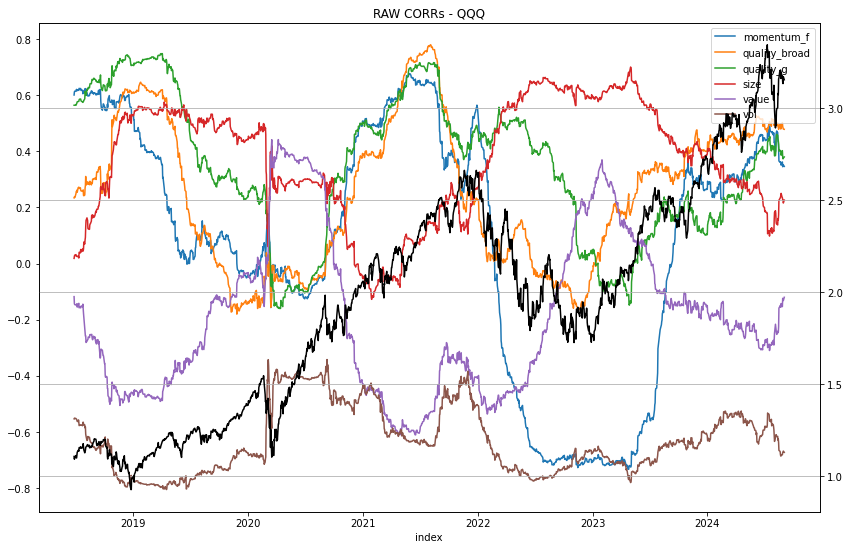

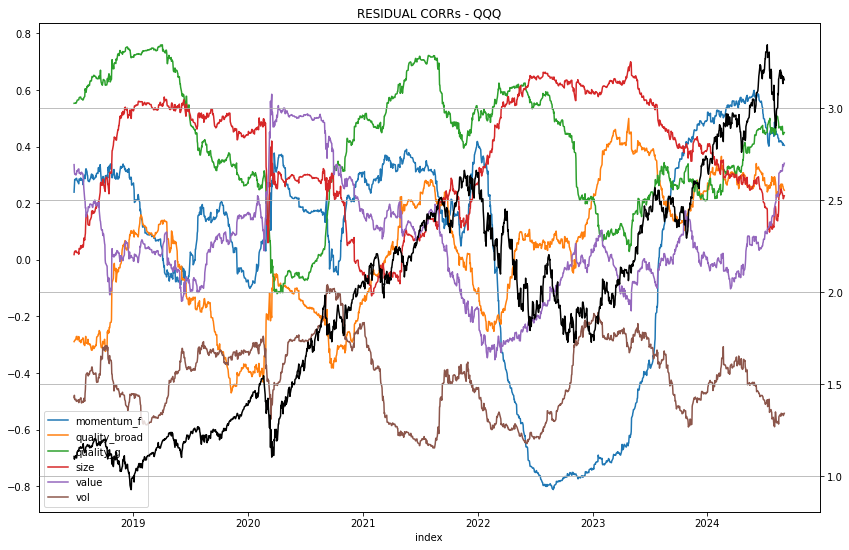

value   value_g  momentum_s  momentum_f  quality_g  \
index                                                               
2018-01-01  1.000000  1.000000    1.000000    1.000000   1.000000   
2018-01-02  1.003211  0.998429    1.000975    0.999155   1.006755   
2018-01-03  0.999712  1.002454    0.999898    0.999698   1.020590   
2018-01-04  0.997257  1.002192    1.001056    1.000521   1.020820   
2018-01-05  0.994738  1.007729    1.003625    1.003805   1.024732   
...              ...       ...         ...         ...        ...   
2024-08-27  0.998611  1.313454    2.035072    1.965089   1.870930   
2024-08-28  0.995386  1.315983    2.048372    1.973226   1.868889   
2024-08-29  0.998992  1.314501    2.038606    1.970342   1.881775   
2024-08-30  0.993094  1.310483    2.050663    1.983380   1.882895   
2024-09-02  0.995936  1.310756    2.039919    1.972478   1.876021   

            quality_broad      size       vol    QQQ US       SPX  
index                                                              
2018-01-01       1.000000  1.000000  1.000000  1.000000  1.000000  
2018-01-02       0.996612  1.003076  0.980497  1.017527  1.007157  
2018-01-03       0.995785  1.003884  0.977371  1.027414  1.013528  
2018-01-04       0.992663  1.004490  0.977941  1.029211  1.017800  
2018-01-05       0.986806  1.003511  0.975629  1.039548  1.024582  
...                   ...       ...       ...       ...       ...  
2024-08-27       1.464763  1.513644  0.796333  3.173042  2.300502  
2024-08-28       1.457339  1.498652  0.810620  3.140497  2.286655  
2024-08-29       1.462746  1.504026  0.808217  3.132443  2.287556  
2024-08-30       1.459765  1.490412  0.809145  3.169780  2.309393  
2024-09-02       1.454454  1.497450  0.807059  3.153142  2.296117  

[1741 rows x 10 columns]

In [1167]:
# SPX and QQQ FACTOR DECOMPOSITION

def loadings(ret_s, res_s):
    
    Pbeta = round(res_s.cov(ret_s) / (res_s.std() ** 2), 3)
    PZ = round(abs(Pbeta) / ((ret_s.std() ** 2) / (res_s.std() ** 2)), 3)
    
    return Pbeta, PZ

def on_selection_bases(value):
    global base_option
    base_option = value
    root.destroy() 
    

slim_feat_l = ['beta', 'size', 'quality_g', 'momentum_f', 'vol', 'value', 'quality_broad']
assets_l = ['QQQ US', 'SPX']
base_l = ['ETF', 'OWN']

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *base_l, command = on_selection_bases)
tk.Label(root, text = "Choose a base").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

if (base_option == 'OWN'):
    facSummary_df = open_df('ownstyles_relation')
else:
    facSummary_df = open_df('styles_relation')
    qqq_s = Pxs_df.loc[facSummary_df.index]['QQQ US'] / Pxs_df.loc[facSummary_df.index]['QQQ US'].iloc[0]
    spx_s = Pxs_df.loc[facSummary_df.index]['SPX'] / Pxs_df.loc[facSummary_df.index]['SPX'].iloc[0]
    facSummary_df['QQQ US'] = qqq_s
    facSummary_df['SPX'] = spx_s

slim_feat_l = [factor for factor in slim_feat_l if factor in facSummary_df.columns]
retFactors_df = facSummary_df[slim_feat_l + assets_l].pct_change().dropna()
residuals_l = []

for idx, c_feat in enumerate(slim_feat_l):
    b_res_l = []
    for count in np.arange(idx):
        b_res = (residuals_l[count].cov(retFactors_df[c_feat] - retFactors_df[c_feat].mean()) / 
                 (residuals_l[count].std() ** 2))  
        b_res_l.append(b_res)
    z = retFactors_df[c_feat] - retFactors_df[c_feat].mean()
    for count in np.arange(idx):
        z -= b_res_l[count] * residuals_l[count]
    residuals_l.append(z)        
              
QQQp_df = pd.DataFrame(np.nan, index = pd.Index(slim_feat_l, name = 'QQQ'), columns = ['Loadings1', 'Z Score1', 'Loadings2', 'Z Score2'])
SPXp_df = pd.DataFrame(np.nan, index = pd.Index(slim_feat_l, name = 'SPX'), columns = ['Loadings1', 'Z Score1', 'Loadings2', 'Z Score2'])
for idx, c_res in enumerate(residuals_l):
    Qret_res = retFactors_df['QQQ US'].copy()
    Sret_res = retFactors_df['SPX'].copy()
    for count in np.arange(idx):
        Qret_res -= QQQp_df.iloc[count]['Loadings1'] * Qret_res
        Sret_res -= SPXp_df.iloc[count]['Loadings1'] * Sret_res
    print('Ttl variance of residual returns, QQQ: ' + str(round((Qret_res ** 2).sum(), 2)))
    print('Ttl variance of residual returns, SPX: ' + str(round((Sret_res ** 2).sum(), 2)))
    print(slim_feat_l[idx])
    QQQp_df.loc[slim_feat_l[idx], ['Loadings1', 'Z Score1']] = loadings(Qret_res, c_res)
    SPXp_df.loc[slim_feat_l[idx], ['Loadings1', 'Z Score1']] = loadings(Sret_res, c_res)
    QQQp_df.loc[slim_feat_l[idx], ['Loadings2', 'Z Score2']] = loadings(retFactors_df['QQQ US'], c_res)
    SPXp_df.loc[slim_feat_l[idx], ['Loadings2', 'Z Score2']] = loadings(retFactors_df['SPX'], c_res)    

Qret_res -= QQQp_df.iloc[idx]['Loadings1'] * Qret_res
Sret_res -= SPXp_df.iloc[idx]['Loadings1'] * Sret_res
print('Ttl variance of residual returns: ' + str(round((Qret_res ** 2).sum(), 2)))   
print('Ttl variance of residual returns, SPX: ' + str(round((Sret_res ** 2).sum(), 2)))
residuals_df = pd.DataFrame(residuals_l).T.join(retFactors_df[['QQQ US', 'SPX']])  
print('')
print('CORRs ORTHOGONAL BASIS')    
print(round(residuals_df.corr(), 2))    
print('')
print(QQQp_df)
print('')
print(SPXp_df)
print('')

QQQ1_r2 = 1 - (((QQQp_df['Loadings1'].values.dot(np.array(residuals_l)) - retFactors_df['QQQ US']) ** 2).sum() / 
              ((retFactors_df['QQQ US']) ** 2).sum())
SPX1_r2 = 1 - (((SPXp_df['Loadings1'].values.dot(np.array(residuals_l)) - retFactors_df['SPX']) ** 2).sum() / 
              ((retFactors_df['SPX']) ** 2).sum())
QQQ2_r2 = 1 - (((QQQp_df['Loadings2'].values.dot(np.array(residuals_l)) - retFactors_df['QQQ US']) ** 2).sum() / 
              ((retFactors_df['QQQ US']) ** 2).sum())
SPX2_r2 = 1 - (((SPXp_df['Loadings2'].values.dot(np.array(residuals_l)) - retFactors_df['SPX']) ** 2).sum() / 
              ((retFactors_df['SPX']) ** 2).sum())
print('QQQ Big model1 r2: ' + str(round(QQQ1_r2, 2)))
print('QQQ Big model2 r2: ' + str(round(QQQ2_r2, 2)))
print('SPX Big model1 r2: ' + str(round(SPX1_r2, 2)))
print('SPX Big model2 r2: ' + str(round(SPX2_r2, 2)))
print('')
print('')

raw_corrs = facSummary_df[slim_feat_l + assets_l].pct_change().dropna().corr()
print('RAW CORRELATIONS')
print(round(raw_corrs, 2))

qqq_corrs = retFactors_df.rolling(126).corr().dropna().unstack()['QQQ US'].drop(['QQQ US', 'SPX'], axis = 1)
qqq_corrs.plot(figsize = (14, 9)).twinx()
facSummary_df['QQQ US'].loc[qqq_corrs.index].plot(c = 'k')
plt.title('RAW CORRs - QQQ')
plt.grid(axis = 'y')
plt.show()

qqq_Rcorrs = residuals_df.rolling(126).corr().dropna().unstack()['QQQ US'].drop(['QQQ US', 'SPX'], axis = 1)
qqq_Rcorrs.plot(figsize = (14, 9)).twinx()
facSummary_df['QQQ US'].loc[qqq_Rcorrs.index].plot(c = 'k')
plt.title('RESIDUAL CORRs - QQQ')
plt.grid(axis = 'y')
plt.show()

facSummary_df

Enter Start Date (empty for 18/01/01 or YY/MM/DD): 19/01/01
01Jan2019 Covered days: 28.35%
02Jan2019 Covered days: 28.63%
03Jan2019 Covered days: 28.52%
04Jan2019 Covered days: 28.41%
07Jan2019 Covered days: 28.3%
08Jan2019 Covered days: 28.2%
09Jan2019 Covered days: 27.72%
10Jan2019 Covered days: 27.99%
11Jan2019 Covered days: 29.0%
14Jan2019 Covered days: 30.0%
15Jan2019 Covered days: 31.73%
16Jan2019 Covered days: 31.99%
17Jan2019 Covered days: 30.77%
18Jan2019 Covered days: 32.48%
21Jan2019 Covered days: 32.36%
22Jan2019 Covered days: 31.52%
23Jan2019 Covered days: 31.77%
24Jan2019 Covered days: 33.45%
25Jan2019 Covered days: 33.69%
28Jan2019 Covered days: 35.0%
29Jan2019 Covered days: 35.94%
30Jan2019 Covered days: 36.17%
31Jan2019 Covered days: 35.34%
01Feb2019 Covered days: 35.21%
04Feb2019 Covered days: 36.49%
05Feb2019 Covered days: 37.76%
06Feb2019 Covered days: 37.98%
07Feb2019 Covered days: 39.24%
08Feb2019 Covered days: 39.45%
11Feb2019 Covered days: 38.97%
12Feb2019 Cover

06Jan2020 Covered days: 46.86%
07Jan2020 Covered days: 46.77%
08Jan2020 Covered days: 46.68%
09Jan2020 Covered days: 46.4%
10Jan2020 Covered days: 45.75%
13Jan2020 Covered days: 45.47%
14Jan2020 Covered days: 45.39%
15Jan2020 Covered days: 44.55%
16Jan2020 Covered days: 44.47%
17Jan2020 Covered days: 44.38%
20Jan2020 Covered days: 45.05%
21Jan2020 Covered days: 46.08%
22Jan2020 Covered days: 46.74%
23Jan2020 Covered days: 45.91%
24Jan2020 Covered days: 45.64%
27Jan2020 Covered days: 46.3%
28Jan2020 Covered days: 45.29%
29Jan2020 Covered days: 44.28%
30Jan2020 Covered days: 43.09%
31Jan2020 Covered days: 43.01%
03Feb2020 Covered days: 43.67%
04Feb2020 Covered days: 44.14%
05Feb2020 Covered days: 44.06%
06Feb2020 Covered days: 44.16%
07Feb2020 Covered days: 44.08%
10Feb2020 Covered days: 44.0%
11Feb2020 Covered days: 45.19%
12Feb2020 Covered days: 45.29%
13Feb2020 Covered days: 45.93%
14Feb2020 Covered days: 46.57%
17Feb2020 Covered days: 47.21%
18Feb2020 Covered days: 47.12%
19Feb2020 C

12Jan2021 Covered days: 56.76%
13Jan2021 Covered days: 57.45%
14Jan2021 Covered days: 57.76%
15Jan2021 Covered days: 57.18%
18Jan2021 Covered days: 57.11%
19Jan2021 Covered days: 57.54%
20Jan2021 Covered days: 57.21%
21Jan2021 Covered days: 57.14%
22Jan2021 Covered days: 56.95%
25Jan2021 Covered days: 56.88%
26Jan2021 Covered days: 57.3%
27Jan2021 Covered days: 56.86%
28Jan2021 Covered days: 56.79%
29Jan2021 Covered days: 56.84%
01Feb2021 Covered days: 57.02%
02Feb2021 Covered days: 56.7%
03Feb2021 Covered days: 56.75%
04Feb2021 Covered days: 57.8%
05Feb2021 Covered days: 58.34%
08Feb2021 Covered days: 58.15%
09Feb2021 Covered days: 58.08%
10Feb2021 Covered days: 58.25%
11Feb2021 Covered days: 57.81%
12Feb2021 Covered days: 57.13%
15Feb2021 Covered days: 57.06%
16Feb2021 Covered days: 57.11%
17Feb2021 Covered days: 56.92%
18Feb2021 Covered days: 57.21%
19Feb2021 Covered days: 57.14%
22Feb2021 Covered days: 56.59%
23Feb2021 Covered days: 56.88%
24Feb2021 Covered days: 57.42%
25Feb2021 C

19Jan2022 Covered days: 59.79%
20Jan2022 Covered days: 60.02%
21Jan2022 Covered days: 59.68%
24Jan2022 Covered days: 58.96%
25Jan2022 Covered days: 59.0%
26Jan2022 Covered days: 58.47%
27Jan2022 Covered days: 58.7%
28Jan2022 Covered days: 58.74%
31Jan2022 Covered days: 58.5%
01Feb2022 Covered days: 58.07%
02Feb2022 Covered days: 58.39%
03Feb2022 Covered days: 58.33%
04Feb2022 Covered days: 58.37%
07Feb2022 Covered days: 58.41%
08Feb2022 Covered days: 58.82%
09Feb2022 Covered days: 59.42%
10Feb2022 Covered days: 59.65%
11Feb2022 Covered days: 59.68%
14Feb2022 Covered days: 60.28%
15Feb2022 Covered days: 60.22%
16Feb2022 Covered days: 60.26%
17Feb2022 Covered days: 60.48%
18Feb2022 Covered days: 60.43%
21Feb2022 Covered days: 60.56%
22Feb2022 Covered days: 60.59%
23Feb2022 Covered days: 60.54%
24Feb2022 Covered days: 60.94%
25Feb2022 Covered days: 61.44%
28Feb2022 Covered days: 61.57%
01Mar2022 Covered days: 61.23%
02Mar2022 Covered days: 61.27%
03Mar2022 Covered days: 60.75%
04Mar2022 C

26Jan2023 Covered days: 62.81%
27Jan2023 Covered days: 63.07%
30Jan2023 Covered days: 62.42%
31Jan2023 Covered days: 62.14%
01Feb2023 Covered days: 62.17%
02Feb2023 Covered days: 61.52%
03Feb2023 Covered days: 61.85%
06Feb2023 Covered days: 61.43%
07Feb2023 Covered days: 61.31%
08Feb2023 Covered days: 61.49%
09Feb2023 Covered days: 61.89%
10Feb2023 Covered days: 61.54%
13Feb2023 Covered days: 61.57%
14Feb2023 Covered days: 61.68%
15Feb2023 Covered days: 62.08%
16Feb2023 Covered days: 61.96%
17Feb2023 Covered days: 61.99%
20Feb2023 Covered days: 61.79%
21Feb2023 Covered days: 61.97%
22Feb2023 Covered days: 62.52%
23Feb2023 Covered days: 62.92%
24Feb2023 Covered days: 63.1%
27Feb2023 Covered days: 62.6%
28Feb2023 Covered days: 62.7%
01Mar2023 Covered days: 62.21%
02Mar2023 Covered days: 63.06%
03Mar2023 Covered days: 62.71%
06Mar2023 Covered days: 62.52%
07Mar2023 Covered days: 62.62%
08Mar2023 Covered days: 62.57%
09Mar2023 Covered days: 62.38%
10Mar2023 Covered days: 63.0%
13Mar2023 Co

01Feb2024 Covered days: 65.49%
02Feb2024 Covered days: 65.51%
05Feb2024 Covered days: 65.72%
06Feb2024 Covered days: 65.74%
07Feb2024 Covered days: 65.52%
08Feb2024 Covered days: 65.41%
09Feb2024 Covered days: 64.93%
12Feb2024 Covered days: 64.89%
13Feb2024 Covered days: 64.91%
14Feb2024 Covered days: 65.12%
15Feb2024 Covered days: 65.27%
16Feb2024 Covered days: 65.42%
19Feb2024 Covered days: 65.12%
20Feb2024 Covered days: 64.96%
21Feb2024 Covered days: 65.04%
22Feb2024 Covered days: 65.0%
23Feb2024 Covered days: 64.78%
26Feb2024 Covered days: 64.74%
27Feb2024 Covered days: 64.63%
28Feb2024 Covered days: 64.78%
29Feb2024 Covered days: 64.86%
01Mar2024 Covered days: 65.07%
04Mar2024 Covered days: 65.28%
05Mar2024 Covered days: 65.36%
06Mar2024 Covered days: 65.69%
07Mar2024 Covered days: 65.84%
08Mar2024 Covered days: 65.8%
11Mar2024 Covered days: 65.33%
12Mar2024 Covered days: 65.59%
13Mar2024 Covered days: 65.62%
14Mar2024 Covered days: 65.39%
15Mar2024 Covered days: 65.6%
18Mar2024 C

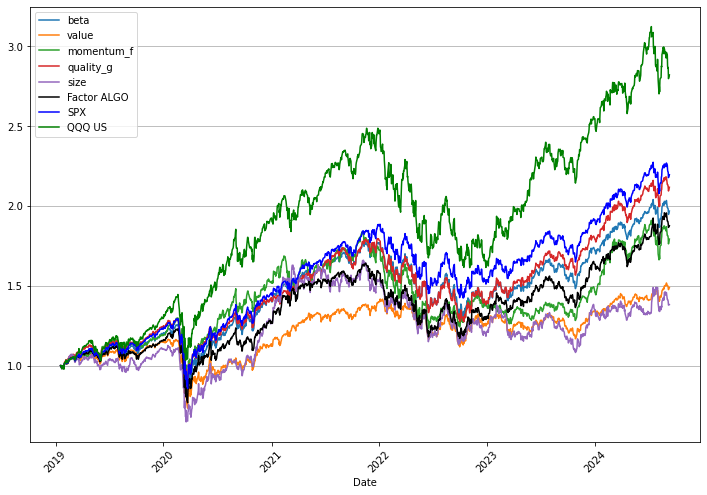


Yearly Returns:
             beta  value  momentum_f  quality_g   size  Factor Algo    SPX  \
2019-12-31  19.70  14.86       19.00      23.96  10.58        15.65  23.08   
2020-12-31  18.52  -0.98       28.46      15.06  15.32        10.32  18.33   
2021-12-31  24.12  23.00       12.73      25.26  19.76        23.79  28.73   
2022-12-31 -20.72  -9.83      -19.74     -21.71 -20.45       -17.42 -18.18   
2023-12-31  24.14   6.18        7.51      29.12  11.75        25.50  24.76   
2024-12-31  13.59  11.24       20.59      17.28   1.82        14.67  14.77   

            QQQ US  
2019-12-31   29.72  
2020-12-31   48.41  
2021-12-31   27.42  
2022-12-31  -32.58  
2023-12-31   54.03  
2024-12-31   10.75  

Yearly Vols:
             beta  value  momentum_f  quality_g   size  Factor Algo    SPX  \
2019-12-31  11.98  10.99       11.74      12.36  15.58        11.60  11.86   
2020-12-31  30.30  31.23       31.28      29.76  36.42        31.38  29.49   
2021-12-31  15.48  15.35       21.69     

In [193]:
# SIMPLE STRATEGY: ETF FACTOR INVESTING ACCORDING TO SIMILARITY W/ PREVIOUS MKT STATES

def on_selection_bases(value):
    global base_option
    base_option = value
    root.destroy() 
    
base_l = ['ETF', 'OWN']

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *base_l, command = on_selection_bases)
tk.Label(root, text = "Choose a base").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

mav_r = 21
mav_w = 63
macroFeatures_l = ['CRB Index Index Points', 'Brent USD/Bbl', 'M2CP Velocity', 'M2MP Velocity', 'T5YIFR', 'T10YIE', 'USGG2YR', 'USGG10YR', 'VIX']
slim_feat_l = ['beta', 'value', 'momentum_f', 'quality_g', 'quality_broad', 'size', 'vol']

Pxs_df = open_df('prices_relation')
if (base_option == 'ETF'):
    facSummary_df = open_df('styles_relation')
else:
    facSummary_df = open_df('ownstyles_relation')

spxGS_df = open_df2('spx_gs')
spxGE_df = open_df2('spx_ge')
spxGOI_df = open_df2('spx_goi')
qqqGS_df = open_df2('qqq_gs')
qqqGE_df = open_df2('qqq_ge')
qqqGOI_df = open_df2('qqq_goi')

spxALL_df = spxGS_df.join(spxGE_df).join(spxGOI_df)
qqqALL_df = qqqGS_df.join(qqqGE_df).join(qqqGOI_df)
spxG_s = spxALL_df.mean(axis = 1)
qqqG_s = qqqALL_df.mean(axis = 1)
spxG_s.name = 'SPX G'
qqqG_s.name = 'QQQ G'

slimF_l = [f for f in slim_feat_l if f in facSummary_df.columns]

SlicePxs_df = Pxs_df[macroFeatures_l]
SlicePxs_df = SlicePxs_df.join(spxG_s).join(qqqG_s)
SlicePxs_df['US10YR RR'] = SlicePxs_df['USGG10YR'] - SlicePxs_df['T10YIE']
SlicePxs_df['YC'] = SlicePxs_df['USGG10YR'] - SlicePxs_df['USGG2YR']
SlicePxs_df['2Y IR Vol'] = SlicePxs_df['USGG2YR'].ewm(halflife = HL).std() * np.sqrt(252)
SstatF_df = SlicePxs_df.loc[facSummary_df.index]
statF_df = (SstatF_df - SstatF_df.ewm(halflife = HL).mean())

Sfeat_sl = ['M2MP Velocity', 'T10YIE', 'USGG2YR', 'VIX', 'US10YR RR', 'Brent USD/Bbl', '2Y IR Vol']
thresh = 3
q_states = 3  

factor_n = 2
st_date = datetime(2018, 1, 1).date()
end_date = facSummary_df.index[-1]
dt_str = input('Enter Start Date (empty for 18/01/01 or YY/MM/DD): ')
try:
    st_date = datetime.strptime(dt_str, "%y/%m/%d").date()
except:
    pass   

date_range = facSummary_df[facSummary_df.index >= st_date].index.tolist()
factorSEL_df = pd.DataFrame(np.nan, index = date_range, columns = 
                            pd.Series(np.arange(factor_n) + 1).map(lambda x: 'Factor ' + str(x)).tolist())

for algo_dt in date_range:
    
    QstatF_df = statF_df[statF_df.index < algo_dt][Sfeat_sl]
    for c_col in Sfeat_sl:
        QstatF_df[c_col] = pd.qcut(QstatF_df[c_col], q = q_states, labels = False, duplicates = 'drop').fillna(100).astype(int)
    S_SlimQstatF_df = QstatF_df.replace({100: np.nan}).dropna().astype(int)    
    
    state_s = pd.Series(np.nan, index = S_SlimQstatF_df.index)
    for c_dt in S_SlimQstatF_df.index:
        comb = ''
        for c_col in S_SlimQstatF_df.columns:
            comb = comb + str(S_SlimQstatF_df.loc[c_dt, c_col])
        state_s.loc[c_dt] = comb

    incidence_s = state_s.value_counts()
    incidence_s = incidence_s[incidence_s > thresh]
    states_sl = incidence_s.index.tolist()
    print(datetime.strftime(algo_dt, '%d%b%Y') + ' Covered days: ' + str(round(100 * incidence_s.sum() / QstatF_df.shape[0], 2)) + '%')
    state_df = pd.DataFrame(0, index = states_sl, columns = slimF_l)
    for idx, c_dt in enumerate(state_s.index[1:]):
        p_dt = state_s.index[idx]
        if (idx == 0) | (state_s.loc[c_dt] != state_s.loc[p_dt]):        
            if (idx > 0):
                end_s = facSummary_df[slimF_l].loc[c_dt]
                ret_s = 100 * (end_s / init_s - 1)
                init_s = facSummary_df[slimF_l].loc[c_dt]
                if (state_s.loc[p_dt] in states_sl):
                    state_df.loc[state_s.loc[p_dt]] += ret_s
            else:
                init_s = facSummary_df[slimF_l].loc[c_dt]
                
    if (algo_dt in statF_df.index):
        c_QstatF_df = statF_df[statF_df.index <= algo_dt][Sfeat_sl]
        for c_col in Sfeat_sl:
            c_QstatF_df[c_col] = pd.qcut(c_QstatF_df[c_col], q = q_states, labels = False, duplicates = 'drop').fillna(100).astype(int)                
        c_state = ''
        for element in c_QstatF_df.loc[algo_dt].astype(str).tolist():
            c_state += element
        if (c_state in state_df.index):
            new_port_l = sorted(state_df.loc[c_state].sort_values()[-2:].index.tolist())
            prev_port_l = []
            try:
                prev_port_l = factorSEL_df[factorSEL_df.index < algo_dt].iloc[-1].tolist()
            except:
                pass
            if (new_port_l != prev_port_l):
                factorSEL_df.loc[algo_dt] = new_port_l
            else:
                factorSEL_df = factorSEL_df.drop(algo_dt)
        else:
            factorSEL_df = factorSEL_df.drop(algo_dt)
    else:
        factorSEL_df = factorSEL_df.drop(algo_dt)
                    
date_range = pd.Series(date_range)[pd.Series(date_range) >= factorSEL_df.index[0]].tolist()
factorIndex_s = pd.Series(np.nan, index = date_range)
factorIndex_s.name = 'Factor Algo'
factorIndex_s.iloc[0] = 1
for c_dt in date_range[1: ]:
    p_dt = factorSEL_df[factorSEL_df.index < c_dt].index[-1]
    c_perf = (factorSEL_df.loc[p_dt].map(lambda x: facSummary_df.loc[c_dt, x]) / 
              factorSEL_df.loc[p_dt].map(lambda x: facSummary_df.loc[p_dt, x])).sum() * (factorIndex_s.loc[p_dt] / factor_n)
    factorIndex_s.loc[c_dt] = c_perf
    
summary_df = (facSummary_df[slimF_l] / facSummary_df[slimF_l].loc[factorIndex_s.index[0]]).loc[factorIndex_s.index]    
summary_df.plot(figsize = (12, 8))
factorIndex_s.plot(c = 'k', label = 'Factor ALGO')
(Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['SPX'] / 
 Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['SPX'].iloc[0]).plot(c = 'b')
(Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['QQQ US'] / 
 Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['QQQ US'].iloc[0]).plot(c = 'g').legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()     

summary_df = (facSummary_df[slimF_l] / facSummary_df[slimF_l].loc[factorIndex_s.index[0]]).loc[factorIndex_s.index]    
summary_df = summary_df.join(factorIndex_s).join(Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['SPX'] / 
                                                 Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['SPX'].iloc[0]).join(Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['QQQ US'] / Pxs_df[Pxs_df.index >= factorIndex_s.index[0]]['QQQ US'].iloc[0])

Ysummary_df = summary_df.copy()
Ysummary_df.index = Ysummary_df.index.map(lambda x: datetime(x.year, x.month, x.day))
YVol_df = (Ysummary_df.pct_change().ewm(halflife = 50).std() * np.sqrt(252)).dropna() * 100
YDD_df = ((Ysummary_df / Ysummary_df.rolling(252).max() - 1) * 100).dropna()
YsummaryRet_df = Ysummary_df.resample('Y').last()
YsummaryRet_df.loc[datetime(YsummaryRet_df.index[0].year, 1, 1)] = 1
YsummaryRet_df = YsummaryRet_df.sort_index()
YsummaryRet_df = round(YsummaryRet_df.pct_change() * 100, 2).dropna()
YVol_df = round(YVol_df.resample('Y').mean(), 2)
YDD_df = round(YDD_df.resample('Y').min(), 2)
YCAGR_df = round((((YsummaryRet_df / 100 + 1).expanding().apply(np.prod).T ** (1 / (np.arange(YsummaryRet_df.shape[0]) + 1))).T - 1) * 100, 2)

print('')
print('Yearly Returns:')
print(YsummaryRet_df)
print('')
print('Yearly Vols:')
print(YVol_df)
print('')
print('Yearly SR:')
print(round(YsummaryRet_df / YVol_df, 2))
print('')
print('Yearly DD:')
print(YDD_df)
print('')
print('CAGR:')
print(YCAGR_df)
print('')
print('CAGR/DD:')
print(round(YCAGR_df / abs(YDD_df), 2))
print('')

In [ ]:
# DRAFTS

stop = False
watch_next = False
p_start = 5
p_degree = p_start
r2_s = r2_3
while (not stop):
    
    poly_features = PolynomialFeatures(degree = p_degree, include_bias = False)
    poly_x3 = poly_features.fit_transform(x3_a.reshape(-1, 1))

    m4 = LinearRegression().fit(poly_x3, y3_a)
    r2_4 = m4.score(poly_x3, y3_a)
    x3a_ext = (np.arange(comp_s.shape[0]) + x3_a.shape[0] + 1)
    poly_x3_ext = poly_features.fit_transform(x3a_ext.reshape(-1, 1))

    fcast4_a = m4.predict(poly_x3_ext)
    print(r2_4)
    
    if (watch_next & ((r2_4 - r2_s) < .1)) | (p_degree == 2):
        stop = True
    
    if ((r2_4 - r2_s) > .1):
        r2_s = r2_4
        fcasts_a = fcast4_a
        watch_next = True        
    
    p_degree -= 1
    
if (watch_next):    
    plt.plot(fcasts_a)
plt.plot(fcastf_a)
plt.show()    

##################

sales_q4d_s.name = 't'
ac_df = pd.DataFrame(sales_q4d_s.values, index = sales_q4d_s.index, columns = ['t'])
ac_df = ac_df.join(sales_q4d_s.shift(1), rsuffix = '+1')
ac_df = ac_df.join(sales_q4d_s.shift(2), rsuffix = '+2')
ac_df = ac_df.join(sales_q4d_s.shift(3), rsuffix = '+3')
ac_df = ac_df.join(sales_q4d_s.shift(4), rsuffix = '+4')
ac_df = ac_df.join(sales_q4d_s.shift(5), rsuffix = '+5')
ac_df = ac_df.join(sales_q4d_s.shift(6), rsuffix = '+6')
ac_df = ac_df.join(sales_q4d_s.shift(7), rsuffix = '+7')
ac_df = ac_df.join(sales_q4d_s.shift(8), rsuffix = '+8')
ac_df.corr()

<AxesSubplot:>

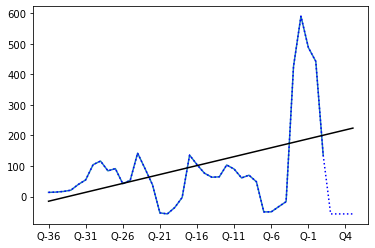

In [77]:
#CUBIC SPLINE

from scipy.interpolate import CubicSpline

def extrapolate(base_s, period_end ,ext_period_index):
    
    end_period = 'Q' + str(period_end)
    ext_period = 'Q' + str(ext_period_index)
    kpi_s = base_s.dropna()
    Skpi1_s = kpi_s.loc[: end_period]
    Skpi2_s = kpi_s.loc['Q-14': end_period]
    Skpi3_s = kpi_s.loc['Q-10': end_period]
    Skpi4_s = kpi_s.loc['Q-6': end_period]

    SkpiRet1_s = (100 * (((Skpi1_s - Skpi1_s.shift(4)) / abs(pd.DataFrame(Skpi1_s).join(Skpi1_s.shift(4), rsuffix = '_')).max(axis = 1)).dropna())).map(lambda x: round(x, 2))
    SkpiRet2_s = (100 * (((Skpi2_s - Skpi2_s.shift(4)) / abs(pd.DataFrame(Skpi2_s).join(Skpi2_s.shift(4), rsuffix = '_')).max(axis = 1)).dropna())).map(lambda x: round(x, 2))
    SkpiRet3_s = (100 * (((Skpi3_s - Skpi3_s.shift(4)) / abs(pd.DataFrame(Skpi3_s).join(Skpi3_s.shift(4), rsuffix = '_')).max(axis = 1)).dropna())).map(lambda x: round(x, 2))
    SkpiRet4_s = (100 * (((Skpi4_s - Skpi4_s.shift(4)) / abs(pd.DataFrame(Skpi4_s).join(Skpi4_s.shift(4), rsuffix = '_')).max(axis = 1)).dropna())).map(lambda x: round(x, 2))

    lr1_s = linregl(SkpiRet1_s, lt_value = 10)[0]
    r2_1 = linregl(SkpiRet1_s, lt_value = 10)[1]
    lr1_s.plot()
    SkpiRet1_s.plot()
    plt.show()

    lr2_s = linregl(SkpiRet2_s, lt_value = 10)[0]
    r2_2 = linregl(SkpiRet2_s, lt_value = 10)[1]
    lr2_s.plot()
    SkpiRet2_s.plot()
    plt.show()

    lr3_s = linregl(SkpiRet3_s, lt_value = 10)[0]
    r2_3 = linregl(SkpiRet3_s, lt_value = 10)[1]
    lr3_s.plot()
    SkpiRet3_s.plot()
    plt.show()

    lr4_s = linregl(SkpiRet4_s, lt_value = 10)[0]
    r2_4 = linregl(SkpiRet4_s, lt_value = 10)[1]
    lr4_s.plot()
    SkpiRet4_s.plot()
    plt.show()

    ext_kpi = max(0, round((lr1_s[ext_period] * r2_1 + lr2_s[ext_period] * r2_2 + lr3_s[ext_period] * r2_3 + lr4_s[ext_period] * r2_4) / (r2_1 + r2_2 + r2_3 + r2_4), 2))

    print(ext_period + ' fwd: ' + str(ext_kpi))
    
    return ext_kpi 


sales_s = sales_df.iloc[-1]
sales_s.name = 'sales'
q4_pt = extrapolate(sales_s, 0, 4)
Sext1_s = pd.Series(np.array(SsalesRet1_s.tolist() + [round(SsalesRet1_s.loc['Q0'] * (1 + q4_pt / 100), 2)]), 
                   index = np.array(SsalesRet1_s.index.map(lambda x: int(x.split('Q')[1])).tolist() + [4]))

CS_Sext1_s = CubicSpline(Sext1_s.index.values, Sext1_s.values, extrapolate = True)
SCS1_f = pd.Series(CS_Sext1_s(Sext1_s.index.values), index = Sext1_s.index)
SCS1_f.plot()
plt.show()

BaseSext1_s = sales_s[: 'Q0'].dropna()
BaseSext1_s.loc['Q4'] = BaseSext1_s.loc['Q0'] * (1 + q4_pt / 100)
q8_pt = extrapolate(BaseSext1_s, 4, 8)
Sext2_s = pd.Series(np.array(BaseSext1_s.tolist() + [round(BaseSext1_s.loc['Q4'] * (1 + q8_pt / 100), 2)]), 
                   index = np.array(BaseSext1_s.index.map(lambda x: int(x.split('Q')[1])).tolist() + [8]))

CS_Sext2_s = CubicSpline(Sext2_s.index.values, Sext2_s.values, extrapolate = True)
SCS2_f = pd.Series(CS_Sext2_s(Sext2_s.index.values), index = Sext2_s.index)
SCS2_f.plot()
plt.show()

##############

EG_s = round(100 * ((earns_s[:'Q1'] / earns_s[:'Q1'].shift(4)).dropna() - 1), 2)
x_s = np.arange(EG_s.shape[0])
x_s_ext = np.arange(EG_s.shape[0] + 4)
original_idx = EG_s.index.tolist()
extended_idx = original_idx + pd.Series((np.arange(4) + 1 + int(original_idx[-1].split('Q')[1])).tolist()).map(lambda x: 'Q' + str(x)).tolist()
EG_CS_s = CubicSpline(x_s, EG_s, extrapolate = True)
lr_model = LinearRegression()
lin_reg = lr_model.fit(x_s.reshape(-1, 1), EG_s.values)
lin_reg_f = pd.Series(lin_reg.predict(x_s_ext.reshape(-1, 1)), index = extended_idx)

EG_s.plot()
pd.Series(EG_CS_s(x_s_ext), index = extended_idx).clip(EG_s.min(), EG_s.max()).plot(c = 'b', linestyle = 'dotted')
lin_reg_f.plot(c = 'k')

In [1098]:
###SEASONALS



def check_corr_yrs(base_series, y, corr_window, corr_window_zoomed, best_y):
    corr_s = pd.Series(np.nan, index = pd.Index(range(today.year - y, today.year), name = 'Corr'))
    base_series_c = base_series[-(corr_window + 1):]
    base_series_c.index = np.arange(base_series_c.shape[0])
    for cy in corr_s.index:
        end_dt = datetime(cy, today.month, today.day).date()
        end_dt = base_series[base_series.index <= end_dt].index[-1]
        st_dt = base_series.index[base_series.index.tolist().index(end_dt) - corr_window]
        c_series = base_series.loc[st_dt: end_dt]
        c_series.index = np.arange(c_series.shape[0])
        corr1 = base_series_c.rolling(corr_window_zoomed).corr(c_series.rolling(corr_window_zoomed)).dropna().median()
        corr2 = base_series_c.corr(c_series)
        corr = round(100 * (corr1 * 2 + corr2) / 3, 2)
        corr_s.loc[cy] = corr
    corr_s = corr_s.sort_values(ascending = False)
    corr_y_l = corr_s.index[:min(best_y, y)].tolist()
    
    return corr_y_l

def on_selection_rates(value):
    global choice_rate
    choice_rate = value
    root.destroy()
    
def on_selection_fx(value):
    global choice_fx
    choice_fx = value
    root.destroy()    

corr_window = 126
corr_window_zoomed = 21
best_y = 5
today = date.today()

Prices_df = open_df('prices_relation')
Prices_df.sort_index(inplace = True)
FX_Prices_df = open_df('fxprices_relation')
DM_Rates_df = open_df('global_rates_dm')
fx_list = FX_Prices_df.columns.tolist()
fx_list_ = fx_list.copy()
fx_list_.append('ALL')
rates_list = DM_Rates_df.columns.tolist()

today = Prices_df.index[-1]
m_start = datetime(today.year, today.month, 1).date()
m_start = Prices_df[Prices_df.index >= m_start].index[0]
c_date = Prices_df[Prices_df.index <= today].index[-1]

qqqR_series = Prices_df['QQQ US'].pct_change().dropna()
spxR_series = Prices_df['SPX'].pct_change().dropna()

ETF_list_1 = ['QQQ', 'IGV', 'SOXX', 'XHB', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLP', 
            'XLU', 'XLV', 'XLY', 'XBI', 'ARKK', 'IWM']
ETF_list_2 = ['SPX']
AllETF_l = pd.Series(ETF_list_1).map(lambda x: x + ' US').tolist() + ETF_list_2

last_date = Prices_df.index[-1]

seag_list = []
ticker = 'dummy'
while (ticker != ''):
    ticker = input('Enter ALGO tiker: (empty to stop, sector for all sectors, fx or rates) ').upper()
    if (ticker in Prices_df.columns):
        seag_list.append(ticker)
    elif (ticker == 'FX'):
        Prices_df = FX_Prices_df.copy()        
        root = tk.Tk()
        tkvar = tk.StringVar(root)
        popupMenu = tk.OptionMenu(root, tkvar, *fx_list_, command = on_selection_fx)
        tk.Label(root, text = "Choose Pair: ").grid(row = 0, column = 0)
        popupMenu.grid(row = 1, column = 0)
        root.mainloop()    
        ticker = choice_fx
        if (ticker == 'ALL'):
            seag_list = fx_list.copy()
            ticker = ''
        else:
            seag_list.append(ticker)
    elif (ticker == 'RATES'):
        Prices_df = DM_Rates_df.copy()
        root = tk.Tk()
        tkvar = tk.StringVar(root)
        popupMenu = tk.OptionMenu(root, tkvar, *rates_list, command = on_selection_rates)
        tk.Label(root, text = "Choose Asset: ").grid(row = 0, column = 0)
        popupMenu.grid(row = 1, column = 0)
        root.mainloop()    
        ticker = choice_rate   
        seag_list.append(ticker)
    elif (ticker == 'SECTOR'):
        seag_list = AllETF_l
        ticker = ''
if (seag_list != []):
    seag_curr_df = pd.DataFrame(np.nan, index = seag_list, columns = ['Mean A', 'Mean S', 'Median A', 'Median S', 
                                                                      'Max A', 'Min A'])
    seag_next_df = pd.DataFrame(np.nan, index = seag_list, columns = ['Mean A', 'Mean S', 'Median A', 'Median S', 
                                                                      'Max A', 'Min A'])
    y = int(input('Enter Window in Years: '))
    first_date = datetime(last_date.year - y, last_date.month, last_date.day).date()
    if ((first_date.day == 25) & (first_date.month == 12)) | ((first_date.day == 1) & (first_date.month == 1)):
        first_date = first_date + timedelta(1)
    if (first_date.weekday() == 5):
        first_date = first_date + timedelta(2)
    if (first_date.weekday() == 6):
        first_date = first_date + timedelta(1)
    
    for ticker in seag_list:
        Pxs_Slice_df = pd.DataFrame(Prices_df[Prices_df.index > first_date][ticker])
        qqq_corr = round(100 * Pxs_Slice_df.pct_change().dropna().rolling(corr_window).corr(qqqR_series.loc[Pxs_Slice_df.pct_change().dropna().index].rolling(126)).dropna().median(), 2)[0]
        spx_corr = round(100 * Pxs_Slice_df.pct_change().dropna().rolling(corr_window).corr(spxR_series.loc[Pxs_Slice_df.pct_change().dropna().index].rolling(126)).dropna().median(), 2)[0]
        base_series = spxR_series
        if (spx_corr < qqq_corr):
            base_series = qqqR_series                    
        Pxs_Slice_df.index = Pxs_Slice_df.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
        R_Pxs_Slice_df = Pxs_Slice_df.resample('M').last()
        
        if (ticker in DM_Rates_df.columns):
            Ticker_Seag_df = round(100 * (R_Pxs_Slice_df - R_Pxs_Slice_df.shift(1)), 2)
        else:
            Ticker_Seag_df = round(100 * R_Pxs_Slice_df.pct_change(), 2)        
        Ticker_Seag_df.index = [Ticker_Seag_df.T.columns.map(lambda x: x.year).values.tolist(), Ticker_Seag_df.T.columns.map(lambda x: x.month).values.tolist()]
        Ticker_Seag_df = Ticker_Seag_df.unstack()
        Ticker_Seag_df.loc['Mean'] = Ticker_Seag_df.mean().values
        Ticker_Seag_df.loc['Median'] = Ticker_Seag_df.median().values
        Ticker_Seag_df.loc['Max'] = Ticker_Seag_df.max().values
        Ticker_Seag_df.loc['Min'] = Ticker_Seag_df.min().values
        Ticker_Seag_df = round(Ticker_Seag_df, 1)
        Ticker_Seag_df.columns = pd.Series(np.arange(12) + 1).map(lambda x: date(2023, x, 1)).map(lambda x: x.strftime('%b')).values
        print('')
        print(ticker)
        print(Ticker_Seag_df)
        print('')
        relevant_yrs_l = check_corr_yrs(base_series, y, corr_window, corr_window_zoomed, best_y)
        print('Relevant years ' + ticker + ': ')
        print(relevant_yrs_l)
        print('')                                                              
        Ticker_SeagS_df = Ticker_Seag_df.loc[relevant_yrs_l]
        Ticker_SeagS_df.loc['Mean'] = Ticker_SeagS_df.mean().values
        Ticker_SeagS_df.loc['Median'] = Ticker_SeagS_df.median().values
        Ticker_SeagS_df.loc['Max'] = Ticker_SeagS_df.max().values
        Ticker_SeagS_df.loc['Min'] = Ticker_SeagS_df.min().values        
        
        seag_curr_df.loc[ticker, 'Mean A'] = Ticker_Seag_df.loc['Mean', today.strftime('%b')]
        seag_curr_df.loc[ticker, 'Median A'] = Ticker_Seag_df.loc['Median', today.strftime('%b')]
        seag_curr_df.loc[ticker, 'Max A'] = Ticker_Seag_df.loc['Max', today.strftime('%b')]
        seag_curr_df.loc[ticker, 'Min A'] = Ticker_Seag_df.loc['Min', today.strftime('%b')]
        seag_next_df.loc[ticker, 'Mean A'] = Ticker_Seag_df.loc['Mean', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]
        seag_next_df.loc[ticker, 'Median A'] = Ticker_Seag_df.loc['Median', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]
        seag_next_df.loc[ticker, 'Max A'] = Ticker_Seag_df.loc['Max', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]
        seag_next_df.loc[ticker, 'Min A'] = Ticker_Seag_df.loc['Min', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]                                                                                                                                            

        seag_curr_df.loc[ticker, 'Mean S'] = Ticker_SeagS_df.loc['Mean', today.strftime('%b')]
        seag_curr_df.loc[ticker, 'Median S'] = Ticker_SeagS_df.loc['Median', today.strftime('%b')]
        seag_next_df.loc[ticker, 'Mean S'] = Ticker_SeagS_df.loc['Mean', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]
        seag_next_df.loc[ticker, 'Median S'] = Ticker_SeagS_df.loc['Median', date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b')]

        seag_curr_df = round(seag_curr_df, 1)
        seag_next_df = round(seag_next_df, 1)                                                              
        
MTD_s = round(100 * (Prices_df.loc[c_date, seag_curr_df.index.tolist()] / Prices_df.loc[m_start, seag_curr_df.index.tolist()] - 1))
MTD_s.name = 'MTD Perf %'
seag_curr_df = seag_curr_df.join(MTD_s)        
print(today.strftime('%b') + ' Seasonals:')
print(seag_curr_df.sort_values(by = ['Mean S'], ascending = False))
print('')
print(date(2023, (today.month + 1) % 13 + (today.month + 1) // 13, 1).strftime('%b') + ' Seasonals:')
print(seag_next_df.sort_values(by = ['Mean S'], ascending = False))

Enter ALGO tiker: (empty to stop, sector for all sectors, fx or rates) sector
Enter Window in Years: 23

QQQ US
         Jan   Feb   Mar   Apr  May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2001     NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  17.0  17.0  -1.9
2002    -1.0 -12.3   6.8 -12.0 -5.3 -13.1  -8.6  -1.5 -11.8  18.5  12.9 -12.1
2003     0.3   3.0   0.4   8.7  8.5   0.5   6.2   5.0  -2.9   8.5   0.6   3.1
2004     1.7  -1.4  -2.0  -3.0  5.1   3.3  -7.6  -2.5   3.3   5.0   6.0   3.0
2005    -6.3  -0.5  -1.8  -4.4  8.9  -3.3   7.6  -1.5   1.2  -1.5   6.1  -1.8
2006     3.9  -2.1   2.1  -0.2 -7.2  -0.1  -4.3   4.8   4.6   4.8   3.4  -1.9
2007     2.1  -1.7   0.5   5.6  3.2   0.5  -0.2   2.8   5.2   7.0  -6.8  -0.1
2008   -11.9  -4.8   1.9   8.0  5.9  -9.6   0.6   1.4 -15.6 -15.5 -11.5   2.3
2009    -2.3  -5.3  10.3  13.1  3.2   3.0   8.4   1.5   5.6  -3.0   6.4   5.2
2010    -6.5   4.6   7.7   2.2 -7.4  -6.0   7.3  -5.1  13.2   6.3  -0.2   4.8
2011     2.8   3.2  -0.4   2.9

Relevant years XHB US: 
[2019, 2005, 2003, 2023, 2007]


XLB US
         Jan  Feb   Mar   Apr  May   Jun   Jul  Aug   Sep   Oct   Nov  Dec
2001     NaN  NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   2.7  12.7 -3.0
2002     2.3  5.3   3.1  -4.7  5.0  -1.7 -11.3 -0.5 -13.0   5.7  12.0 -4.6
2003    -5.0 -2.6   0.6   9.0  3.1   0.9   7.9  2.8  -4.5   9.5   2.3  9.8
2004    -4.4  5.2  -2.3  -4.6  2.8   5.0  -2.3  1.7   4.0  -0.9   8.1  1.3
2005    45.4  7.9  -3.0  -7.1 -0.6  -2.5   5.5 -4.2   0.2   0.2   7.7  2.1
2006     4.8 -2.1   4.2   3.6 -4.0  -0.2  -3.7  3.0  -0.6   6.0   4.4 -0.5
2007     4.0  2.7   2.2   1.5  5.9  -1.0  -2.7 -0.7   7.6   4.2  -5.0  0.1
2008    -4.2  2.3  -1.7   5.3  5.2  -6.2  -3.2 -1.6 -16.0 -22.4 -10.7 -1.8
2009    -7.4 -8.0  14.7  15.6  5.8  -5.0  12.9  2.4   3.8  -5.2  10.8  1.5
2010    -8.6  4.5   7.7   0.2 -9.5  -7.7  12.8 -3.0   5.6   6.2   1.1  9.2
2011     0.1  2.6   1.4   2.1 -2.7  -1.0  -3.4 -7.0 -16.9  17.3   0.2 -3.0
2012    11.0 -0.6   0.0  -0.8 -7.8  

Min    -26.2 -17.8 -21.7  -9.9  -9.2 -18.2 -9.1  -9.6 -11.7 -21.9 -18.5 -11.7

Relevant years XLF US: 
[2019, 2005, 2003, 2023, 2007]


XLI US
         Jan   Feb   Mar   Apr  May   Jun   Jul  Aug   Sep   Oct   Nov   Dec
2001     NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   1.8  10.0   4.5
2002    -6.3   2.5   2.7  -6.9  0.4  -6.1  -5.7 -1.6 -11.5   4.9   5.2  -3.9
2003    -5.4  -1.5   1.1  10.8  2.7   2.1   3.3  3.9  -2.7   6.2   2.0   6.6
2004     1.0  -0.7  -1.2  -0.0  2.5   6.2  -2.8  0.1   2.2   1.0   6.3   2.5
2005    39.2   1.2  -0.4  -3.6  3.2  -2.9   3.8 -2.4   1.3  -1.4   5.8  -0.1
2006     0.3   3.1   4.0   2.2 -1.7  -0.4  -5.7  1.1   3.4   2.8   2.4  -0.3
2007     2.1  -1.1   0.6   4.6  5.2  -0.2   1.0  0.0   4.2  -1.3  -2.8  -0.6
2008    -5.5  -2.0   3.2   2.9  0.9 -12.4   0.8  2.7 -12.6 -18.2  -8.2   1.3
2009   -12.0 -17.0   7.8  18.1  3.4  -2.4   8.7  4.8   5.3  -4.0   8.8   1.0
2010    -1.5   5.3   8.3   4.3 -9.1  -7.3  10.4 -6.9  11.0   2.9   1.3   6.9
2011     3

Relevant years XLV US: 
[2019, 2005, 2003, 2023, 2007]


XLY US
         Jan  Feb   Mar   Apr  May   Jun   Jul  Aug   Sep   Oct   Nov   Dec
2001     NaN  NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   5.3  13.3   4.5
2002     3.3  0.5   1.3  -2.8 -0.5  -5.3 -11.9  3.0  -8.9   6.8   4.6  -8.5
2003    -3.3 -0.4   2.4  11.7  5.3   1.4   1.8  5.1  -4.8   9.1   0.9   4.0
2004    -0.6  2.2  -0.6  -1.1  0.6   0.3  -3.8 -0.2   2.9   4.0   4.2   4.7
2005    21.4 -0.5  -1.3  -6.4  6.2  -0.6   5.7 -3.3  -3.0  -2.0   4.0  -1.4
2006     1.8  0.7   0.6   1.3 -1.7  -0.4  -3.3  2.0   6.2   6.5   1.3   1.8
2007     2.9 -3.0  -0.6   2.4  3.0  -1.9  -5.9  0.6  -1.1  -0.5  -5.5  -5.6
2008    -0.4 -3.9  -1.9   2.4  2.7 -11.8   0.2  6.9  -8.5 -17.6 -10.8   5.3
2009   -10.6 -9.1  12.1  18.5 -0.7  -0.2   9.5  3.5   5.0  -2.4   6.7   4.0
2010    -2.9  5.6   7.6   6.0 -7.0 -10.0   7.9 -4.0  10.7   5.5   2.5   3.5
2011    -0.6  6.0  -0.9   3.8 -0.3  -0.6  -1.4 -5.2  -7.2  11.9  -0.7   0.7
2012     5.9  4.5   4.4 


SPX
        Jan   Feb   Mar   Apr  May  Jun  Jul  Aug   Sep   Oct   Nov  Dec
2001    NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN   NaN   1.3   7.8  0.6
2002   -1.0  -1.8   3.3  -5.8 -0.6 -7.4 -7.9  0.7 -10.5   8.2   6.2 -5.7
2003   -2.5  -1.4   0.2   8.5  5.5  1.1  1.8  2.1  -1.1   5.4   1.1  5.0
2004    2.0   1.4  -1.3  -1.9  1.7  1.8 -3.2  0.2   1.0   1.3   4.4  3.0
2005   -2.2   2.1  -1.8  -1.9  3.2  0.2  3.8 -0.9   0.8  -2.4   4.4 -0.2
2006    2.4   0.6   1.6   1.3 -3.0  0.3  0.4  2.2   2.7   3.2   2.0  1.3
2007    1.5  -2.0   1.2   4.4  3.4 -1.5 -3.1  1.3   3.9   1.4  -3.9 -1.1
2008   -6.0  -2.6  -0.9   4.8  1.5 -8.4 -0.9  1.6  -9.4 -16.5  -7.0  1.0
2009   -8.2 -10.7   8.3   9.9  5.8 -0.1  7.5  3.7   3.6  -1.9   6.2  1.9
2010   -3.6   3.1   6.1   1.6 -8.0 -5.2  6.8 -4.5   9.0   3.8   0.0  6.7
2011    2.3   3.5   0.0   2.9 -1.1 -1.7 -2.0 -5.5  -6.9  10.9  -0.4  1.0
2012    4.6   4.3   3.2  -0.7 -6.0  4.1  1.2  2.5   2.5  -1.8   0.6  0.9
2013    5.1   1.3   3.8   1.9  2.4 -1.3  5.2 -

Input VA ticker: AXON


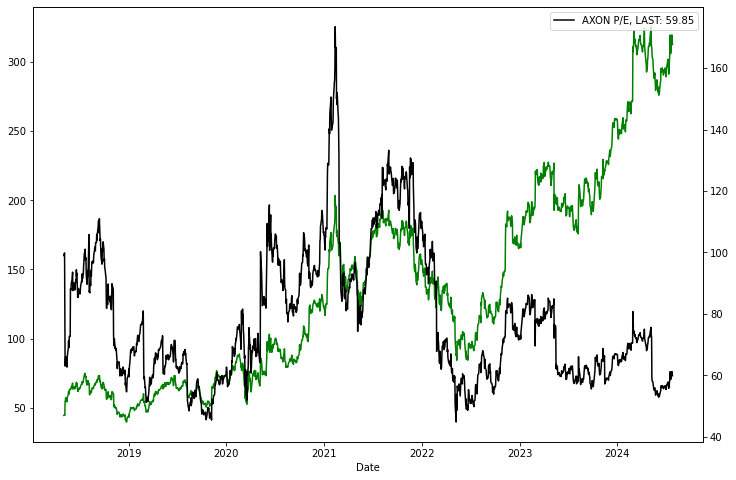

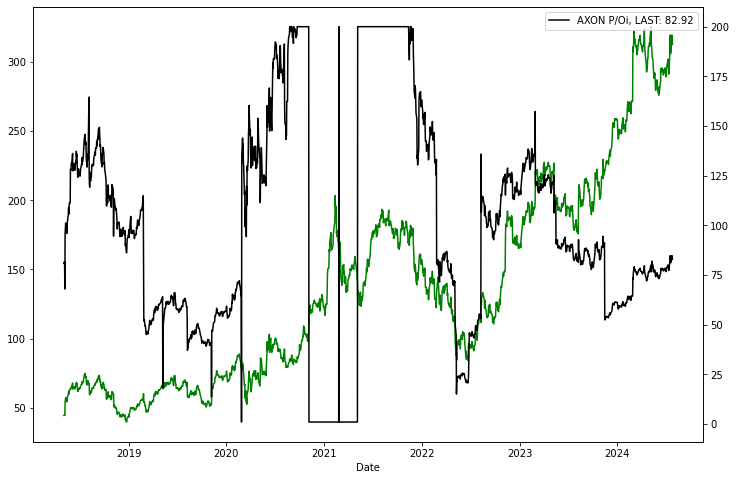

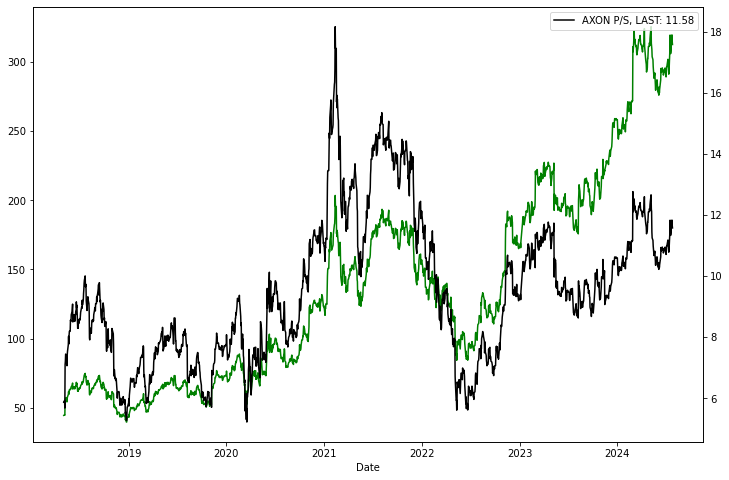

In [9]:
# PLOTS FWD METRICS

import pandas as pd
import numpy as np
import math
import os
import csv
import yfinance as yf
from yahoofinancials import YahooFinancials as yfs
#import mysql.connector
import psycopg2
import requests
import json
import tkinter as tk
import re
import time
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sqlalchemy import create_engine

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def offset(stock_rel, i_list, d_list, t_date, r_date, div_i):
    
    cutoff_date = r_date
    Start_Date = t_date
    ed_list = d_list
    y_list = i_list
    cur_index = 0
    nd_list = []
    for cur_ed_date in ed_list:                            
        cont=0
        seek_element = True
        ced = cur_ed_date
        cur_index = ed_df[stock_rel].values.tolist()[cur_index:].index(cur_ed_date) + cur_index
        cur_index_plus = cur_index + 1
        if (cur_index_plus<len(ed_df.index)):
            cur_year = ed_df.index[cur_index_plus][len(ed_df.index[cur_index_plus])-4:]
        else:
            cur_year = today.year
        if (int(cur_ed_date[0:2]) == 2) & (int(cur_ed_date[2:]) > 28):
            cur_ed_date = '0228'
        cur_ed_date = str(cur_year) + '-' + cur_ed_date[0:2] + '-' + cur_ed_date[2:]
        cur_ed_date = datetime.strptime(cur_ed_date, "%Y-%m-%d").date()
        if (cur_ed_date < cutoff_date):
            nd_list.append(cur_ed_date)        
    
    offs = round_down(len(pd.Series(nd_list)[pd.Series(nd_list) > t_date]) / div_i, 0)
    
    return offs

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

dbase = "visiblealpha_laptop"
dbase_metrics = "metrics_laptop"
today = date.today()
cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

metrics_list = ['_epsd', '_oi', '']
metrics_names = ['P/E', 'P/Oi', 'P/S']

Prices_df = open_df('prices_relation')
yq_df = open_df('yq_all')
ed_df = open_df('ed_relation')
ed_df['AUX'] = ed_df.index
dum_l1 = []
dum_l2 = []
for dum in ed_df['AUX']:
    dum_s = dum.split('QCY-')
    ed_df.loc[dum, 'AUX'] = int(str(dum_s[1]) + str(dum_s[0]))
ed_df.sort_values(by=['AUX'], inplace=True)
ed_df.drop('AUX', axis=1, inplace=True)

stock = input('Input VA ticker: ').upper()
stock_rel = stock + ' US'

if (stock_rel in Prices_df.columns):
    record_date = yq_df.loc[stock_rel, 'Record Date']
    ed_list = ed_df[stock_rel][ed_df[stock_rel] != ''].values.tolist()
    y_list = ed_df.index.values.tolist()

    price_s = Prices_df[stock_rel].dropna()

    if (stock_rel in Prices_df.columns):
        stock_sql = stock.lower() + 'us'
        wasd_df = open_df(stock_sql + '_wasd')

        for idx, c_relation in enumerate(metrics_list):
            curr_df = open_df(stock_sql + c_relation)
            slice_price_s = price_s[price_s.index >= curr_df.index[0]]
            valuation_df = pd.DataFrame(np.nan, index = slice_price_s.index, columns = ['IS Line', 'Mkt Cap', 'Valuation'])

            for c_dt in valuation_df.index:
                offs = offset(stock_rel, y_list, ed_list, c_dt, record_date, 1)
                mult = 1
                if (c_relation == '_epsd'):
                    mult = wasd_df.loc[wasd_df[wasd_df.index <= c_dt].index[-1]].shift(offs)['Q0']
                valuation_df.loc[c_dt, 'IS Line'] = curr_df.loc[curr_df[curr_df.index <= c_dt].index[-1]].shift(offs)['Q1': 'Q4'].sum() * mult
                if (c_dt >= wasd_df.index[0]):
                    valuation_df.loc[c_dt, 'Mkt Cap'] = wasd_df.loc[wasd_df[wasd_df.index <= c_dt].index[-1]].shift(offs)['Q1': 'Q4'].mean() * slice_price_s.loc[c_dt]
            valuation_df['Valuation'] = valuation_df['Mkt Cap'] / valuation_df['IS Line']
            Prices_df[stock_rel].loc[valuation_df.index].plot(c = 'g').twinx()
            valuation_df['Valuation'].clip(1, 200).plot(c = 'k', figsize = (12, 8), label = stock + ' ' + metrics_names[idx] + ', LAST: ' + str(round(valuation_df['Valuation'].iloc[-1], 2))).legend(loc = 'best')            
            plt.show()

In [73]:
# GROWTH ESTIMATES PER STOCK/SECTOR - EARNINGS, OP INCOME, REVENUES

def offset(stock_rel, i_list, d_list, t_date, r_date, div_i):
    
    cutoff_date = r_date
    Start_Date = t_date
    ed_list = d_list
    y_list = i_list
    cur_index = 0
    nd_list = []
    for cur_ed_date in ed_list:                            
        cont=0
        seek_element = True
        ced = cur_ed_date
        cur_index = ed_df[stock_rel].values.tolist()[cur_index:].index(cur_ed_date) + cur_index
        cur_index_plus = cur_index + 1
        if (cur_index_plus<len(ed_df.index)):
            cur_year = ed_df.index[cur_index_plus][len(ed_df.index[cur_index_plus])-4:]
        else:
            cur_year = today.year
        if (int(cur_ed_date[0:2]) == 2) & (int(cur_ed_date[2:]) > 28):
            cur_ed_date = '0228'
        cur_ed_date = str(cur_year) + '-' + cur_ed_date[0:2] + '-' + cur_ed_date[2:]
        cur_ed_date = datetime.strptime(cur_ed_date, "%Y-%m-%d").date()
        if (cur_ed_date < cutoff_date):
            nd_list.append(cur_ed_date)        
    
    offs = round_down(len(pd.Series(nd_list)[pd.Series(nd_list) > t_date]) / div_i, 0)
    
    return offs

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection_options(value):
    global target_option
    target_option = value
    root.destroy() 
    
def on_selection_sectors(value):
    global target_sector
    target_sector = value
    root.destroy()     

options_list = ['Sectors', 'ETFs']
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *options_list, command = on_selection_options)
tk.Label(root, text = "Choose target option: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

criteria = 'Custom Sector 1'
if (target_option == 'ETFs'):
    criteria = 'ETF'

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
sector_list = pd.unique(Sectors_df[criteria].dropna()).tolist()

sector_options = sector_list.copy()
sector_options.append('ALL')
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *sector_options, command = on_selection_sectors)
tk.Label(root, text = "Choose sector: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

if (target_sector != 'ALL'):
    sector_list = []
    sector_list.append(target_sector)

g_list = ['_epsd', '_oi', '']
g_names = ['E', 'OI', 'S']
g_factors = [.9, .9, 1]
g_factors2 = [50, 50, 25]

Prices_df = open_df('prices_relation')
HARD_START = datetime(2016, 1, 1).date()
HARD_END = Prices_df.index[-1]

yq_df = open_df('yq_all')
ed_df = open_df('ed_relation')
ed_df['AUX'] = ed_df.index
dum_l1 = []
dum_l2 = []
for dum in ed_df['AUX']:
    dum_s = dum.split('QCY-')
    ed_df.loc[dum, 'AUX'] = int(str(dum_s[1]) + str(dum_s[0]))
ed_df.sort_values(by=['AUX'], inplace=True)
ed_df.drop('AUX', axis=1, inplace=True)

update_only = True
ovr_check = input('Override (Y/y or empty)? ').upper()    
individual_stock = input('Enter individual stock (empty for list): ').upper()
individual = False
if (individual_stock in Prices_df.columns):
    individual = True

plot_b = False
hard_override = False
for c_sector in sector_list:
    stock_list = Sectors_df[Sectors_df[criteria] == c_sector].index.tolist()    
    if (individual):
        stock_list = []
        stock_list.append(individual_stock)
    
    for c_stock in stock_list:
        date_range = Prices_df[Prices_df.index >= HARD_START].index.tolist()
        date_range = pd.Series(date_range)[pd.Series(date_range).map(lambda x: x.strftime('%m%d').find('0101')) == -1]
        date_range = date_range[date_range.map(lambda x: x.strftime('%m%d').find('1225')) == -1].tolist()        
        stock_sql = re.sub(r' ', '', c_stock.lower())
        update_only = True
        if (ovr_check == 'Y'):
            update_only = False        
        try:
            stock_val_df = open_df(stock_sql + '_metrics')    
            valid_rel = True
        except:
            update_only = False
            valid_rel = False
            
        if (update_only):
            date_range = []
            date_range.append(HARD_END)
            if (HARD_END not in stock_val_df.index):
                stock_val_df.loc[HARD_END] = np.nan
        else:
            if (not valid_rel) | (hard_override):
                stock_val_df = pd.DataFrame(np.nan, index = date_range, columns = ['NTM P/E', 'NTM P/OI', 'NTM P/S', 'G E', 
                                                                                   'G OI', 'G S', 'PEG1', 'PEG2', 'PEG3']) 
        record_date = yq_df.loc[c_stock, 'Record Date']
        ed_list = ed_df[c_stock][ed_df[c_stock] != ''].values.tolist()
        y_list = ed_df.index.values.tolist()            
        wasd_df = open_df(stock_sql + '_wasd')
        
        for idx, c_metric in enumerate(g_list):
            print(c_sector + ' ' + c_stock + ' ' + g_names[idx])
            for c_dt in date_range:
                g_final = np.nan
                curr_df = open_df(stock_sql + c_metric)                
                if (c_dt >= curr_df.index[0]) & (c_dt not in stock_val_df.dropna().index):
                    if (wasd_df[wasd_df.index <= c_dt].shape[0] > 0):
                        if (c_dt not in stock_val_df.index):
                            stock_val_df.loc[c_dt] = np.nan
                        offs = offset(c_stock, y_list, ed_list, c_dt, record_date, 1)        
                        c_shares = wasd_df.loc[wasd_df[wasd_df.index <= c_dt].index[-1]].shift(offs)['Q0']
                        if (c_shares != None):
                            mkt_cap = Prices_df.loc[c_dt, c_stock] * c_shares
                            relation_dt = curr_df[curr_df.index <= c_dt].index[-1]
                            val_label = 'NTM P/' + g_names[idx]
                            g_label = 'G ' + g_names[idx]

                            curr_s = curr_df.loc[relation_dt].shift(offs).fillna(method = 'ffill').dropna()
                            yoy_growth_s = (100 * pd.Series((curr_s - curr_s.shift(4)).dropna().values / 
                                                            abs(pd.DataFrame([curr_s.shift(4).dropna().tolist(), curr_s.loc[curr_s.shift(4).dropna().index].tolist()]).T.dropna()).max(axis = 1).values, index = curr_s.shift(4).dropna().index)).map(lambda x: round(x, 2))

                            if ('Q-7' in yoy_growth_s.index):
                                g_2yt = yoy_growth_s['Q-7': 'Q-4'].mean()
                                g_1yt = yoy_growth_s['Q-3': 'Q0'].mean()
                                g_1yn = yoy_growth_s['Q1': 'Q4'].mean()
                                g_2yn = yoy_growth_s['Q5': 'Q8'].mean()
                                g_t = yoy_growth_s['Q-7': 'Q0'].mean()
                                g_n = yoy_growth_s['Q1': 'Q8'].mean()
                                g_TOT = yoy_growth_s['Q-7': 'Q8'].mean()
                                g_array = np.array([g_2yt, g_1yt, g_1yn, g_2yn, g_t, g_n, g_TOT])
                                g_mean = np.mean(g_array)
                                g_std = max(np.std(yoy_growth_s) / g_factors2[idx], g_factors[idx])
                                g_final = round(g_mean / g_std, 2)
                            
                            try:
                                is_item = curr_s.loc['Q1': 'Q4'].sum()
                                if (c_metric == '_epsd'):
                                    is_item *= c_shares
                                stock_val_df.loc[c_dt, val_label] = round(mkt_cap / is_item, 2)
                            except:
                                stock_val_df.loc[c_dt, val_label] = np.nan
                            stock_val_df.loc[c_dt, g_label] = g_final                    

                            if (plot_b):
                                plt.figure(idx, figsize = (10, 6))
                                curr_df.iloc[-1].plot(c = 'k')
                                plt.show()                        
                                print(g_names[idx] + ' growth for ' + c_stock + ': ' + str())            
            stock_val_df['PEG' + str(idx + 1)] = round((stock_val_df[val_label] / stock_val_df[g_label]).replace({np.nan: 1111}), 2).replace({1111: np.nan})
            if (stock_val_df['PEG' + str(idx + 1)][stock_val_df['PEG' + str(idx + 1)] < 0].shape[0] > 0):
                stock_val_df['PEG' + str(idx + 1)][stock_val_df['PEG' + str(idx + 1)] < 0] = 11
            stock_val_df.to_sql(stock_sql + '_metrics', engine, index = True, if_exists = 'replace')

Override (Y/y or empty)? 
Enter individual stock (empty for list): 
IGV QLYS US E
IGV QLYS US OI
IGV QLYS US S
IGV TYL US E
IGV TYL US OI
IGV TYL US S
IGV U US E
IGV U US OI
IGV U US S
IGV SNAP US E
IGV SNAP US OI
IGV SNAP US S
IGV BILL US E
IGV BILL US OI
IGV BILL US S
IGV PATH US E
IGV PATH US OI
IGV PATH US S
IGV DDOG US E
IGV DDOG US OI
IGV DDOG US S
IGV PCOR US E
IGV PCOR US OI
IGV PCOR US S
IGV SNOW US E
IGV SNOW US OI
IGV SNOW US S
IGV PANW US E
IGV PANW US OI
IGV PANW US S
IGV DBX US E
IGV DBX US OI
IGV DBX US S
IGV DOCU US E
IGV DOCU US OI
IGV DOCU US S
IGV TEAM US E
IGV TEAM US OI
IGV TEAM US S
IGV WDAY US E
IGV WDAY US OI
IGV WDAY US S
IGV ZM US E
IGV ZM US OI
IGV ZM US S
IGV ADBE US E
IGV ADBE US OI
IGV ADBE US S
IGV ADSK US E
IGV ADSK US OI
IGV ADSK US S
IGV CDNS US E
IGV CDNS US OI
IGV CDNS US S
IGV FTNT US E
IGV FTNT US OI
IGV FTNT US S
IGV INTU US E
IGV INTU US OI
IGV INTU US S
IGV MSFT US E
IGV MSFT US OI
IGV MSFT US S
IGV NOW US E
IGV NOW US OI
IGV NOW US S
IGV ORCL U

Enter individual ALGO stock (empty for list): ZETA US
Enter track date (empty to use last, or YY/MM/DD): 
ZETA US


<Figure size 864x576 with 0 Axes>

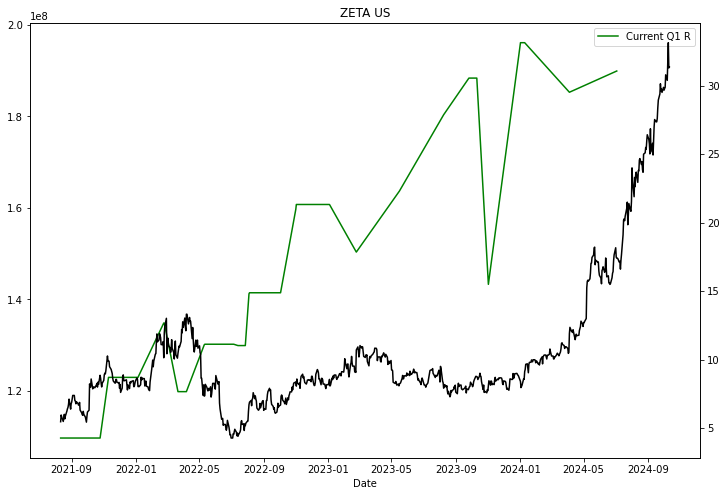

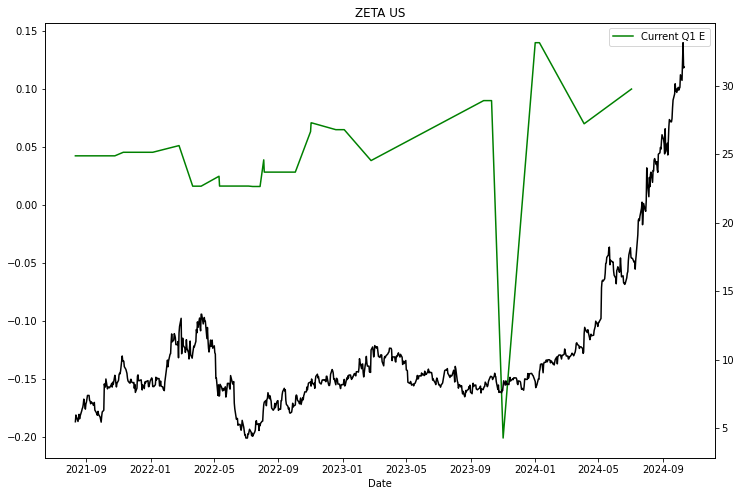

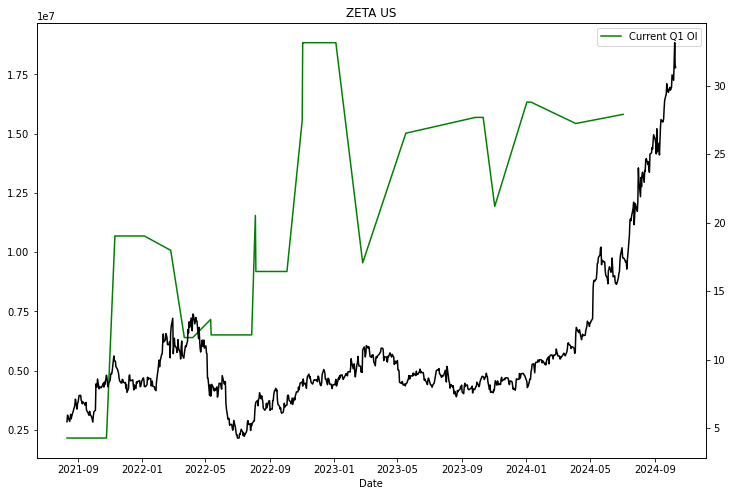

In [917]:
# SAME PERIOD Q1 GROWTH ESTIMATES PER STOCK/SECTOR - EARNINGS, OP INCOME, REVENUES

def offset(stock_rel, i_list, d_list, t_date, r_date, div_i):
    
    cutoff_date = r_date
    Start_Date = t_date
    ed_list = d_list
    y_list = i_list
    cur_index = 0
    nd_list = []
    for cur_ed_date in ed_list:                            
        cont=0
        seek_element = True
        ced = cur_ed_date
        cur_index = ed_df[stock_rel].values.tolist()[cur_index:].index(cur_ed_date) + cur_index
        cur_index_plus = cur_index + 1
        if (cur_index_plus<len(ed_df.index)):
            cur_year = ed_df.index[cur_index_plus][len(ed_df.index[cur_index_plus])-4:]
        else:
            cur_year = today.year
        if (int(cur_ed_date[0:2]) == 2) & (int(cur_ed_date[2:]) > 28):
            cur_ed_date = '0228'
        cur_ed_date = str(cur_year) + '-' + cur_ed_date[0:2] + '-' + cur_ed_date[2:]
        cur_ed_date = datetime.strptime(cur_ed_date, "%Y-%m-%d").date()
        if (cur_ed_date < cutoff_date):
            nd_list.append(cur_ed_date)        
    
    offs = round_down(len(pd.Series(nd_list)[pd.Series(nd_list) > t_date]) / div_i, 0)
    
    return offs

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection_options(value):
    global target_option
    target_option = value
    root.destroy() 
    
def on_selection_sectors(value):
    global target_sector
    target_sector = value
    root.destroy()     
    
sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)    

Prices_df = open_df('prices_relation')
HARD_START = datetime(2016, 1, 1).date()
HARD_END = Prices_df.index[-1]
sharpe_filter = True

date_range = Prices_df[Prices_df.index >= HARD_START].index.tolist()
date_range = pd.Series(date_range)[pd.Series(date_range).map(lambda x: x.strftime('%m%d').find('0101')) == -1]
date_range = date_range[date_range.map(lambda x: x.strftime('%m%d').find('1225')) == -1].tolist()    
Prices_df = Prices_df.loc[date_range]

yq_df = open_df('yq_all')
ed_df = open_df('ed_relation')
ed_df['AUX'] = ed_df.index
dum_l1 = []
dum_l2 = []
for dum in ed_df['AUX']:
    dum_s = dum.split('QCY-')
    ed_df.loc[dum, 'AUX'] = int(str(dum_s[1]) + str(dum_s[0]))
ed_df.sort_values(by=['AUX'], inplace=True)
ed_df.drop('AUX', axis=1, inplace=True)

individual_stock = input('Enter individual ALGO stock (empty for list): ').upper()
individual = False
if (individual_stock in Prices_df.columns):
    individual = True
    sector_list = [Sectors_df.loc[individual_stock, 'ETF']]
else:
    options_list = ['Sectors', 'ETFs']
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *options_list, command = on_selection_options)
    tk.Label(root, text = "Choose target option: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()

    criteria = 'Custom Sector 1'
    if (target_option == 'ETFs'):
        criteria = 'ETF'

    sector_list = pd.unique(Sectors_df[criteria].dropna()).tolist()

    sector_options = sector_list.copy()
    sector_options.append('ALL')
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *sector_options, command = on_selection_sectors)
    tk.Label(root, text = "Choose sector: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()    
    
    if (target_sector != 'ALL'):
        sector_list = []
        sector_list.append(target_sector)
        
tracker_date = HARD_END 
new_td = input('Enter track date (empty to use last, or YY/MM/DD): ')
if (new_td != ''):
    try:
        tracker_date = datetime.strptime(new_td, '%y/%m/%d').date()
        tracker_date = Prices_df[Prices_df.index <= tracker_date].index[-1]
    except:
        print('Using last date available')
        
dt_6M = Prices_df[Prices_df.index <= (tracker_date - timedelta(180))].index[-1]
dt_9M = Prices_df[Prices_df.index <= (tracker_date - timedelta(270))].index[-1]
dt_12M = Prices_df[Prices_df.index <= (tracker_date - timedelta(360))].index[-1]
dt_18M = Prices_df[Prices_df.index <= (tracker_date - timedelta(540))].index[-1]         
    
for c_sector in sector_list:    
    if (individual):
        stock_list = [individual_stock]
    else:
        stock_list = Sectors_df[Sectors_df[criteria] == c_sector].index.tolist()
    tracker_df = pd.DataFrame(np.nan, index = pd.Index(stock_list, name = tracker_date.strftime('%Y-%m-%d')), 
                              columns = ['Stock Vol', '6M Stock', 'Stock Sharpe', '9M Stock', '12M Stock', '18M Stock', 
                                         '6M E', '9M E', '12M E', '18M E', '6M OI', '9M OI', 
                                         '12M OI', '18M OI', '6M R', '9M R', '12M R', '18M R'])         
    for c_stock in stock_list:   
        print(c_stock)        
        stock_sql = re.sub(r' ', '', c_stock.lower())
        record_date = yq_df.loc[c_stock, 'Record Date']
        ed_list = ed_df[c_stock][ed_df[c_stock] != ''].values.tolist()
        y_list = ed_df.index.values.tolist()            
        wasd_df = open_df(stock_sql + '_wasd')       
        r_df = open_df(stock_sql)
        e_df = open_df(stock_sql + '_epsd')
        oi_df = open_df(stock_sql + '_oi')
        
        Rq1_df = pd.DataFrame(np.nan, index = r_df.dropna(how = 'all').index, columns = ['Current Q1 R'])
        Eq1_df = pd.DataFrame(np.nan, index = e_df.dropna(how = 'all').index, columns = ['Current Q1 E'])
        OIq1_df = pd.DataFrame(np.nan, index = oi_df.dropna(how = 'all').index, columns = ['Current Q1 OI'])                              
        
        for c_dt in Rq1_df.index:
            offs = offset(c_stock, y_list, ed_list, c_dt, record_date, 1)                        
            try:
                cR_q1 = r_df.loc[c_dt].shift(offs).replace({np.nan: 'z', None: 'z'})['Q1']
                if (cR_q1 != 'z'):
                    Rq1_df.loc[c_dt, 'Current Q1 R'] = cR_q1
            except:
                pass
            try:
                cE_q1 = e_df.loc[c_dt].shift(offs).replace({np.nan: 'z', None: 'z'})['Q1']
                if (cR_q1 != 'z'):
                    Eq1_df.loc[c_dt, 'Current Q1 E'] = cE_q1
            except:
                pass
            try:
                cOI_q1 = oi_df.loc[c_dt].shift(offs).replace({np.nan: 'z', None: 'z'})['Q1']
                if (cR_q1 != 'z'):
                    OIq1_df.loc[c_dt, 'Current Q1 OI'] = cOI_q1
            except:
                pass   
            
        Rq1_df = Rq1_df.replace({'z': np.nan}).dropna()
        Eq1_df = Eq1_df.replace({'z': np.nan}).dropna()
        OIq1_df = OIq1_df.replace({'z': np.nan}).dropna()
        
        try:
            tracker_df.loc[c_stock, 'Stock Vol'] = round(100 * Prices_df[c_stock].pct_change().rolling(180).std().loc[tracker_date] * np.sqrt(252), 2)
            tracker_df.loc[c_stock, '6M Stock'] = round(100 * (Prices_df.loc[tracker_date, c_stock] - Prices_df.loc[dt_6M, c_stock]) / max(Prices_df.loc[tracker_date, c_stock], Prices_df.loc[dt_6M, c_stock]), 2)
            tracker_df.loc[c_stock, 'Stock Sharpe'] = round(tracker_df.loc[c_stock, '6M Stock'] / tracker_df.loc[c_stock, 'Stock Vol'], 2)
            tracker_df.loc[c_stock, '9M Stock'] = round(100 * (Prices_df.loc[tracker_date, c_stock] - Prices_df.loc[dt_9M, c_stock]) / max(Prices_df.loc[tracker_date, c_stock], Prices_df.loc[dt_9M, c_stock]), 2)    
            tracker_df.loc[c_stock, '12M Stock'] = round(100 * (Prices_df.loc[tracker_date, c_stock] - Prices_df.loc[dt_12M, c_stock]) / max(Prices_df.loc[tracker_date, c_stock], Prices_df.loc[dt_12M, c_stock]), 2)        
            tracker_df.loc[c_stock, '18M Stock'] = round(100 * (Prices_df.loc[tracker_date, c_stock] - Prices_df.loc[dt_18M, c_stock]) / max(Prices_df.loc[tracker_date, c_stock], Prices_df.loc[dt_18M, c_stock]), 2)        

            tracker_df.loc[c_stock, '6M R'] = round(100 * (Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R'] - Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_6M].index[-1], 'Current Q1 R']) / max(abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R']), abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_6M].index[-1], 'Current Q1 R'])), 2)
            tracker_df.loc[c_stock, '9M R'] = round(100 * (Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R'] - Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_9M].index[-1], 'Current Q1 R']) / max(abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R']), abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_9M].index[-1], 'Current Q1 R'])), 2)
            tracker_df.loc[c_stock, '12M R'] = round(100 * (Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R'] - Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_12M].index[-1], 'Current Q1 R']) / max(abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R']), abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_12M].index[-1], 'Current Q1 R'])), 2)        
            tracker_df.loc[c_stock, '18M R'] = round(100 * (Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R'] - Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_18M].index[-1], 'Current Q1 R']) / max(abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= tracker_date].index[-1], 'Current Q1 R']), abs(Rq1_df.loc[Rq1_df[Rq1_df.index <= dt_18M].index[-1], 'Current Q1 R'])), 2)        

            tracker_df.loc[c_stock, '6M E'] = round(100 * (Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E'] - Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_6M].index[-1], 'Current Q1 E']) / max(abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E']), abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_6M].index[-1], 'Current Q1 E'])), 2)
            tracker_df.loc[c_stock, '9M E'] = round(100 * (Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E'] - Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_9M].index[-1], 'Current Q1 E']) / max(abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E']), abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_9M].index[-1], 'Current Q1 E'])), 2)        
            tracker_df.loc[c_stock, '12M E'] = round(100 * (Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E'] - Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_12M].index[-1], 'Current Q1 E']) / max(abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E']), abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_12M].index[-1], 'Current Q1 E'])), 2)        
            tracker_df.loc[c_stock, '18M E'] = round(100 * (Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E'] - Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_18M].index[-1], 'Current Q1 E']) / max(abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= tracker_date].index[-1], 'Current Q1 E']), abs(Eq1_df.loc[Eq1_df[Eq1_df.index <= dt_18M].index[-1], 'Current Q1 E'])), 2)        

            tracker_df.loc[c_stock, '6M OI'] = round(100 * (OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI'] - OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_6M].index[-1], 'Current Q1 OI']) / max(abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI']), abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_6M].index[-1], 'Current Q1 OI'])), 2)
            tracker_df.loc[c_stock, '9M OI'] = round(100 * (OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI'] - OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_9M].index[-1], 'Current Q1 OI']) / max(abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI']), abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_9M].index[-1], 'Current Q1 OI'])), 2)        
            tracker_df.loc[c_stock, '12M OI'] = round(100 * (OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI'] - OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_12M].index[-1], 'Current Q1 OI']) / max(abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI']), abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_12M].index[-1], 'Current Q1 OI'])), 2)        
            tracker_df.loc[c_stock, '18M OI'] = round(100 * (OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI'] - OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_18M].index[-1], 'Current Q1 OI']) / max(abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= tracker_date].index[-1], 'Current Q1 OI']), abs(OIq1_df.loc[OIq1_df[OIq1_df.index <= dt_18M].index[-1], 'Current Q1 OI'])), 2)        
        except:
            tracker_df = tracker_df.drop(c_stock)
                
        if (individual):
            plt.figure(0, figsize = (12, 8))
            Rq1_df.plot(c = 'g', figsize = (12, 8)).twinx()
            Prices_df[Prices_df.index >= Rq1_df.index[0]][c_stock].plot(c = 'k')
            plt.title(c_stock)

            plt.figure(1, figsize = (12, 8))
            Eq1_df.plot(c = 'g', figsize = (12, 8)).twinx()
            Prices_df[Prices_df.index >= Eq1_df.index[0]][c_stock].plot(c = 'k')
            plt.title(c_stock)

            plt.figure(2, figsize = (12, 8))
            OIq1_df.plot(c = 'g', figsize = (12, 8)).twinx()
            Prices_df[Prices_df.index >= OIq1_df.index[0]][c_stock].plot(c = 'k')
            plt.title(c_stock)        

            plt.show()
    tracker_df['18M Score'] = (round((tracker_df['18M R'] + tracker_df['18M E'] + tracker_df['18M OI']) / 3, 2) - tracker_df['18M Stock'])
    tracker_df['12M Score'] = (round((tracker_df['12M R'] + tracker_df['12M E'] + tracker_df['12M OI']) / 3, 2) - tracker_df['12M Stock'])
    tracker_df['9M Score'] = (round((tracker_df['9M R'] + tracker_df['9M E'] + tracker_df['9M OI']) / 3, 2) - tracker_df['9M Stock'])
    tracker_df['Avg Score'] = round(tracker_df.T[tracker_df.columns.map(lambda x: x.find('Score')) != -1].T.mean(axis = 1), 2)
    
if (not individual):   
    
    print('')
    print('Relevance Score:')
    relevance_s = tracker_df.corr()['6M Stock'].loc[tracker_df.T[tracker_df.columns.map(lambda x: x.find('Stock')) == -1].index].sort_values()[::-1]
    print(relevance_s)
    print('')
    print(tracker_df['18M Score'].sort_values()[::-1])
    print('')
    
    if (sharpe_filter):
        target_len = 0
        
        q_sharpe = .4 #.4
        q_gr = .6 #.6
        q_ge = .6 # .6
        q_val = .4 # .4
        q_g = .75 # .5        
        
        r_ = 0
                
        while (target_len < 3):      
            r_ += 1
            print('Round ' + str(r_))
            FULLtracker_df = tracker_df.copy()
            sharpe_cutoff = np.quantile(tracker_df['Stock Sharpe'], q = q_sharpe)
            gr_cutoff = np.quantile(tracker_df['12M R'], q = q_gr)
            ge_cutoff = np.quantile(tracker_df['12M E'], q = q_ge)
            val_cutoff = np.quantile(tracker_df['18M Score'], q = q_val)
            g_cutoff = np.quantile(tracker_df[relevance_s.index[0]], q = q_g)     
            
            s_tracker_df = tracker_df.copy()
            s_tracker_df = s_tracker_df[s_tracker_df['Stock Sharpe'] >= sharpe_cutoff]
            s_tracker_df = s_tracker_df[s_tracker_df['12M E'] >= ge_cutoff]
            s_tracker_df = s_tracker_df[s_tracker_df['12M R'] >= gr_cutoff]
            s_tracker_df = s_tracker_df[s_tracker_df['18M Score'] >= val_cutoff] 
            s_tracker_df = s_tracker_df[s_tracker_df[relevance_s.index[0]] >= g_cutoff] 
            
            target_len = s_tracker_df.shape[0]
            q_sharpe = max(.1, q_sharpe - 0.025)
            q_gr = max(.1, q_gr - 0.025)
            q_ge = max(.1, q_ge - 0.025)
            q_val = max(.1, q_val - 0.025)
            q_g = max(.1, q_g - 0.025)
    s_tracker_df.sort_values(by = [relevance_s.index[0]], ascending = False, inplace = True)
    ((Prices_df[s_tracker_df.index][Prices_df.index >= dt_6M] / Prices_df[s_tracker_df.index].loc[dt_6M]).sum(axis = 1) / s_tracker_df.shape[0]).plot(c = 'g', figsize = (12, 8))
    (Prices_df[Prices_df.index >= dt_6M][c_sector + ' US'] / Prices_df.loc[dt_6M, c_sector + ' US']).plot(c = 'k')
    plt.title(c_sector)
    plt.show()
    
    print(s_tracker_df.dropna())

In [308]:
# SECTOR REPORT - SPECIFIC DATE

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection_options(value):
    global target_option
    target_option = value
    root.destroy() 
    
def on_selection_sectors(value):
    global target_sector
    target_sector = value
    root.destroy()     

options_list = ['Sectors', 'ETFs']
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *options_list, command = on_selection_options)
tk.Label(root, text = "Choose target option: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

criteria = 'Custom Sector 1'
if (target_option == 'ETFs'):
    criteria = 'ETF'

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
sector_list = pd.unique(Sectors_df[criteria].dropna()).tolist()

sector_options = sector_list.copy()
sector_options.append('ALL')
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *sector_options, command = on_selection_sectors)
tk.Label(root, text = "Choose sector: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

if (target_sector != 'ALL'):
    sector_list = []
    sector_list.append(target_sector)

Prices_df = open_df('prices_relation')
HARD_START = datetime(2016, 1, 1).date()
HARD_END = Prices_df.index[-1]
date_range = Prices_df[Prices_df.index >= HARD_START].index.tolist()
date_range = pd.Series(date_range)[pd.Series(date_range).map(lambda x: x.strftime('%m%d').find('0101')) == -1]
date_range = date_range[date_range.map(lambda x: x.strftime('%m%d').find('1225')) == -1].tolist()
selected_dt = date_range[-1]
change_dt = input('Enter date (YY/MM/DD, empty for last): ')
try:
    selected_dt = datetime.strptime(change_dt, '%y/%m/%d').date()
    selected_dt = pd.Series(date_range)[pd.Series(date_range) <= selected_dt].iloc[-1]
except:
    pass

for c_sector in sector_list:
    stock_list = Sectors_df[Sectors_df[criteria] == c_sector].index.tolist()   
    sec_summary_df = pd.DataFrame(np.nan, index = stock_list, columns = ['NTM P/E', 'NTM P/OI', 'NTM P/S', 'G E', 
                                                                         'G OI', 'G S', 'PEG1', 'PEG2', 'PEG3'])    
    for c_stock in stock_list:
        stock_sql = re.sub(r' ', '', c_stock.lower())
        stock_metric_rel = stock_sql + '_metrics'
        try:
            metrics_rel = open_df(stock_metric_rel)
            if (selected_dt >= metrics_rel.index[0]):
                sec_summary_df.loc[c_stock] = metrics_rel.loc[selected_dt]
        except:
            print('No metrics relation for ' + c_stock + ' on the selected date')
            
    for idx in np.arange(sec_summary_df.shape[1]):
        metric_name = sec_summary_df.columns[idx]
        print(c_sector + ' ' + metric_name + ':')
        asc = True
        if (metric_name.find('G ') != -1):
            asc = False
        print(sec_summary_df[metric_name].sort_values(ascending = asc)[:10])
        print('')
        print('')            
                        

Enter date (YY/MM/DD, empty for last): 
IGV NTM P/E:
S US      -63.57
U US      -32.17
DBX US     10.38
ZM US      12.49
ORCL US    17.85
DOCU US    18.38
BILL US    26.33
INTU US    26.51
ADBE US    26.57
ADSK US    26.83
Name: NTM P/E, dtype: float64


IGV NTM P/OI:
DBX US      9.27
ZM US      10.95
ORCL US    12.88
DOCU US    16.40
CRM US     21.33
ADSK US    21.54
ADBE US    21.92
BILL US    24.02
MSFT US    25.96
QLYS US    26.52
Name: NTM P/OI, dtype: float64


IGV NTM P/S:
DBX US     2.64
BILL US    3.49
DOCU US    4.04
ZM US      4.12
SMAR US    4.52
ORCL US    5.39
ESTC US    6.00
CRM US     6.70
PATH US    6.99
DT US      7.56
Name: NTM P/S, dtype: float64


IGV G E:
SNOW US    54.89
SMAR US    53.69
MDB US     47.02
ESTC US    45.28
BILL US    38.86
CRWD US    38.13
ZS US      34.61
U US       30.69
DDOG US    24.29
NOW US     23.92
Name: G E, dtype: float64


IGV G OI:
SNOW US    63.87
S US       53.78
BILL US    51.77
SMAR US    49.62
U US       48.63
MDB US     43.34
ZS U

In [ ]:
# GROUPING STUDIES

def on_selection(value):
    global choice_sector
    choice_sector = value  # store the user's choice
    root.destroy()  # close window

#Pxs_df = open_df('prices_relation')
Pxs_df = Pxs_df.sort_index()

stocks = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Tickers_VA.csv")
all_tickers_l = stocks['tickers'].tolist()
all_tickers_l = [t for t in all_tickers_l if t in Pxs_df.columns]
all_tickers_l = pd.Series(all_tickers_l)[pd.Series(all_tickers_l).map(lambda x: x.split(' ')[1]) == 'US']

sectors = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\Custom_Segmentation.csv")
Sectors_df = pd.DataFrame(sectors)
Sectors_df = Set_DF(Sectors_df)
Sectors_df = DD_Index(Sectors_df)
Nsector_l = pd.unique(Sectors_df.dropna(subset = ['Custom Sector 3'])['Custom Sector 3']).tolist()
Nsector_s = Sectors_df[Sectors_df['Custom Sector 3'].isna() == False]['Custom Sector 3']

Osector_l = pd.unique(Sectors_df.dropna(subset = ['Custom Sector 1'])['Custom Sector 1']).tolist()
Osector_s = Sectors_df[Sectors_df['Custom Sector 1'].isna() == False]['Custom Sector 1']


grouping_w1 = 504
grouping_w2 = 252
grouping_w3 = 126
p_cut = 30

OautocorrS_s = pd.Series(np.nan, index = Osector_l)
NautocorrS_s = pd.Series(np.nan, index = Nsector_l)

for c_sector in Osector_l:
    sec_tickers_l = [t for t in all_tickers_l if t in Osector_s[Osector_s == c_sector].index.tolist()]
    corr1_df = round(100 * Pxs_df[sec_tickers_l].pct_change()[-grouping_w1:].corr(), 3)
    OautocorrS_s.loc[c_sector] = round((corr1_df.sum().sum() - corr1_df.shape[0] * 100) / 2 / corr1_df.shape[0] / 
                                        corr1_df.shape[0], 2)  
for c_sector in Nsector_l:
    sec_tickers_l = [t for t in all_tickers_l if t in Nsector_s[Nsector_s == c_sector].index.tolist()]
    corr1_df = round(100 * Pxs_df[sec_tickers_l].pct_change()[-grouping_w1:].corr(), 3)
    NautocorrS_s.loc[c_sector] = round((corr1_df.sum().sum() - corr1_df.shape[0] * 100) / 2 / corr1_df.shape[0] / 
                                        corr1_df.shape[0], 2)      

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *Osector_l, command = on_selection)
tk.Label(root, text = "Choose a sector").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

sec_tickers_l = [t for t in all_tickers_l if t in Osector_s[Osector_s == choice_sector].index.tolist()]
corr1_df = round(100 * Pxs_df[sec_tickers_l].pct_change()[-grouping_w1:].corr(), 3)
groups1_df = pd.DataFrame(np.nan, index = np.arange(p_cut) + 1, columns = corr1_df.columns)
for c_ticker in corr1_df.columns:
    try:
        groups1_df[c_ticker] = corr1_df[c_ticker].dropna().sort_values()[-(p_cut + 1): -1].index[::-1].tolist() + [''] * max(0, (groups1_df.shape[0] - (corr1_df.shape[0] - 1)))
    except:
        print(c_ticker.split(' ')[0] + ' error')
        groups1_df = groups1_df.drop([c_ticker], axis = 1)
        
print(choice_sector) 
print('')
print(OautocorrS_s)
print('')
print(NautocorrS_s.shape[0])
print('')
print(Nsector_s[Nsector_s == choice_sector])
print('')

Nall_tickers_l = [t for t in all_tickers_l if t in Nsector_s.index]
Nmap_df = pd.DataFrame(NautocorrS_s, columns = ['Avg Corr'])
Nmap_df['Constituents'] = pd.Series(Nall_tickers_l).map(lambda x: Nsector_s.loc[x]).value_counts()
Nmap_df.sort_values(by = ['Constituents'], ascending = False)

In [ ]:
stockCaseS = 'T US'
all_tickers_l = stocks['tickers'].tolist()
all_tickers_l = [t for t in all_tickers_l if t in Pxs_df.columns]
all_tickers_l = pd.Series(all_tickers_l)[pd.Series(all_tickers_l).map(lambda x: x.split(' ')[1]) == 'US']

print('Sector Corrs:')
print(groups1_df[stockCaseS])
print('')
print('All Corrs:')
round(100 * Pxs_df.pct_change()[all_tickers_l][-long_w:].corr()[stockCaseS], 2).sort_values(ascending = False).drop(stockCaseS)[:30]

Enter Start Date: (20/01/01)
Enter Cutoff Date: (22/10/01)
CRWD US LAST RECORDED DATE: 2024-Mar-05
CRWD US CURRENT EARNINGS DATE: 2024-Mar-05


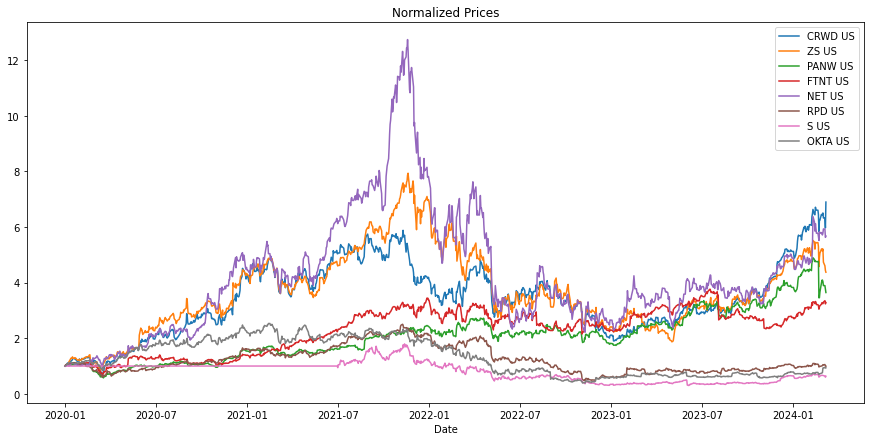

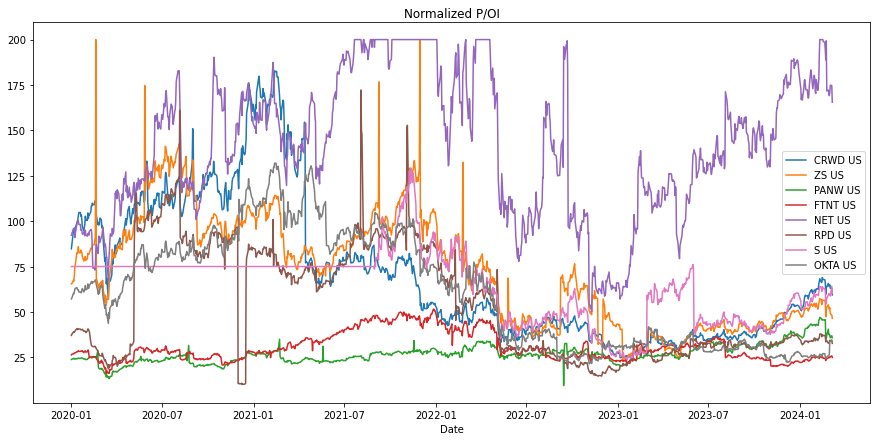

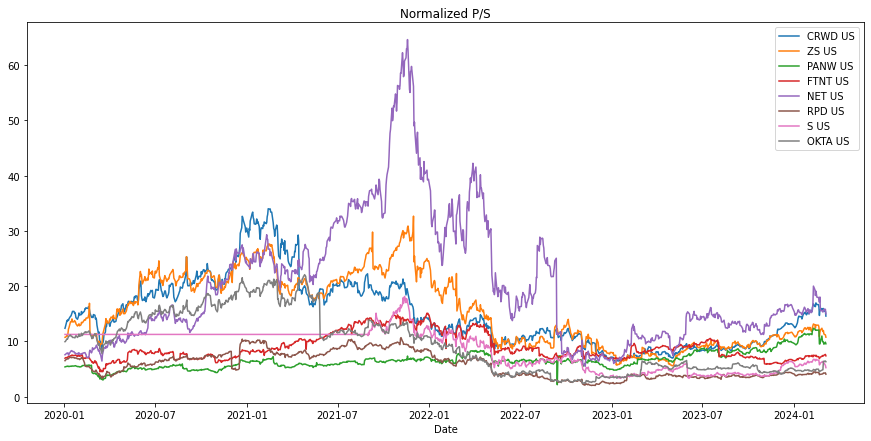

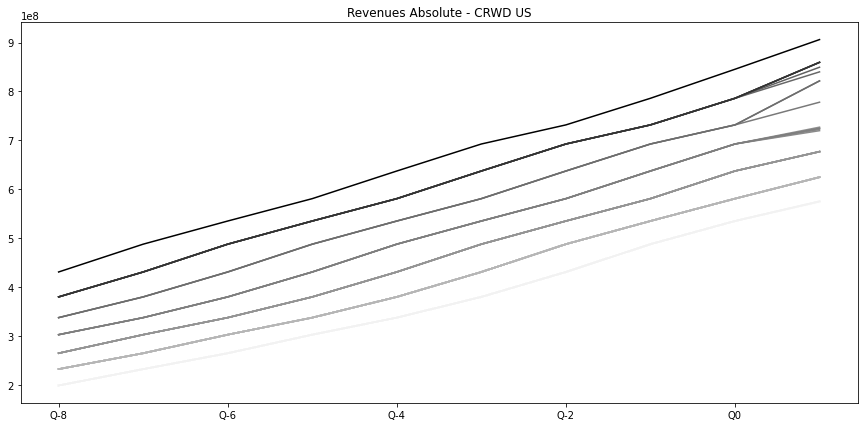

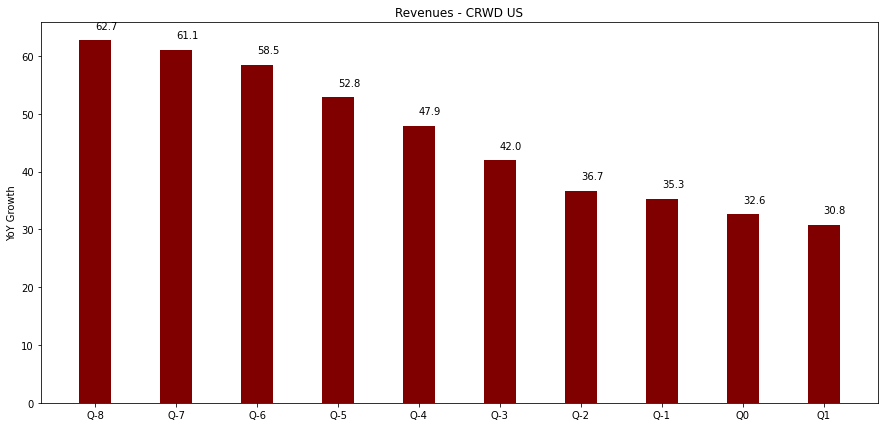

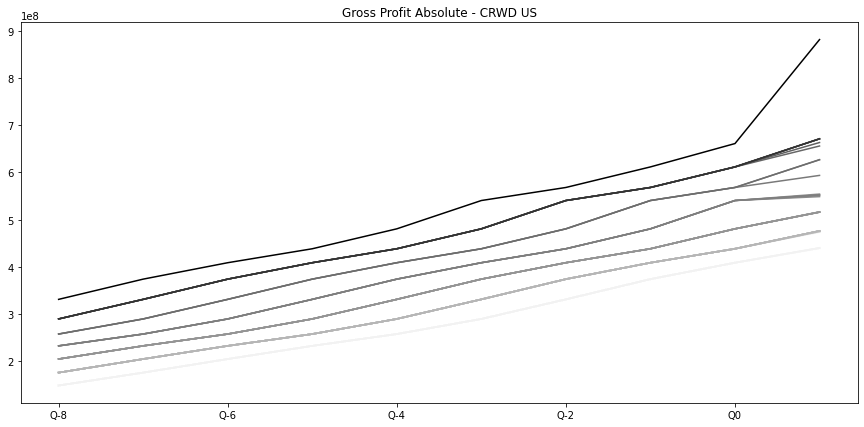

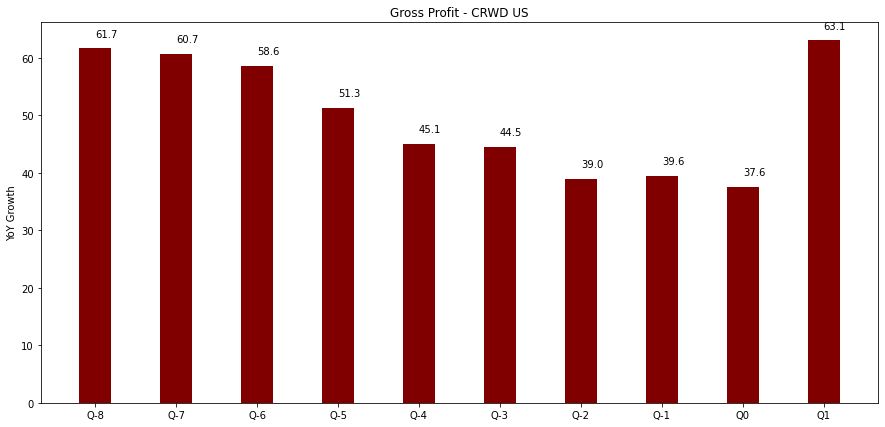

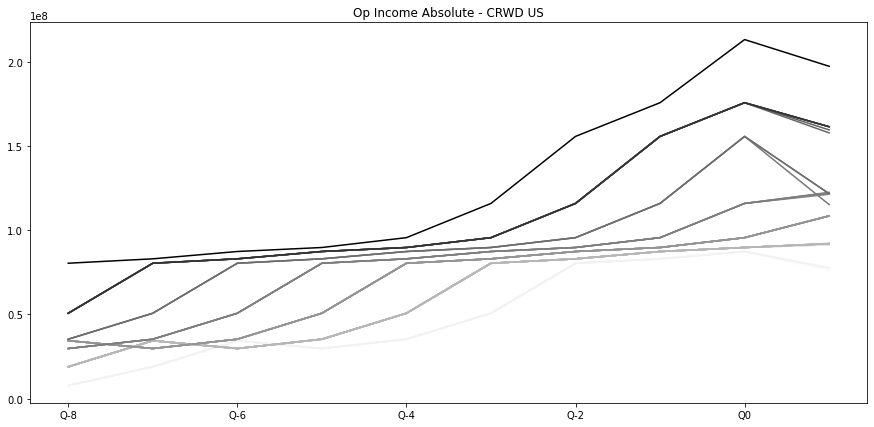

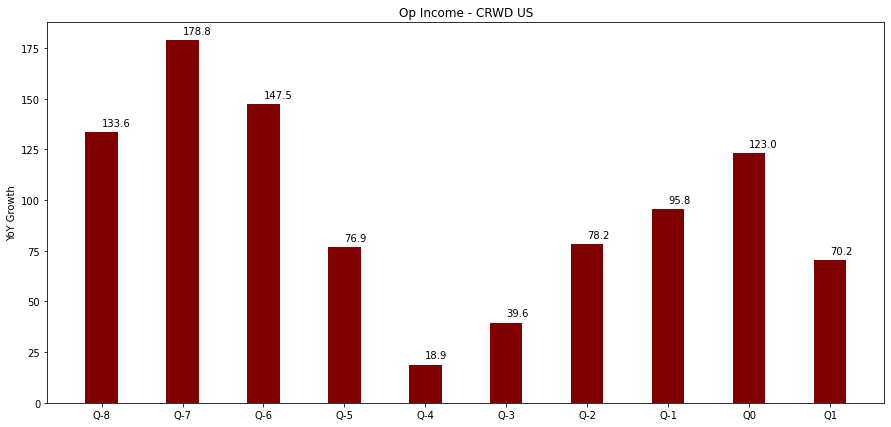

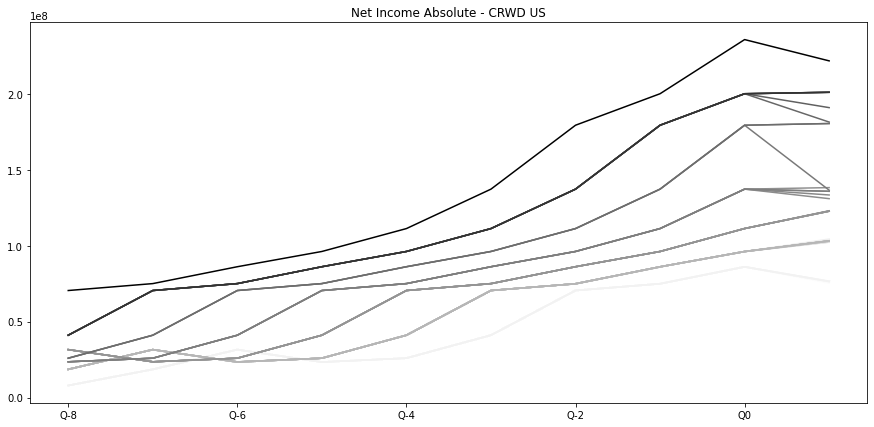

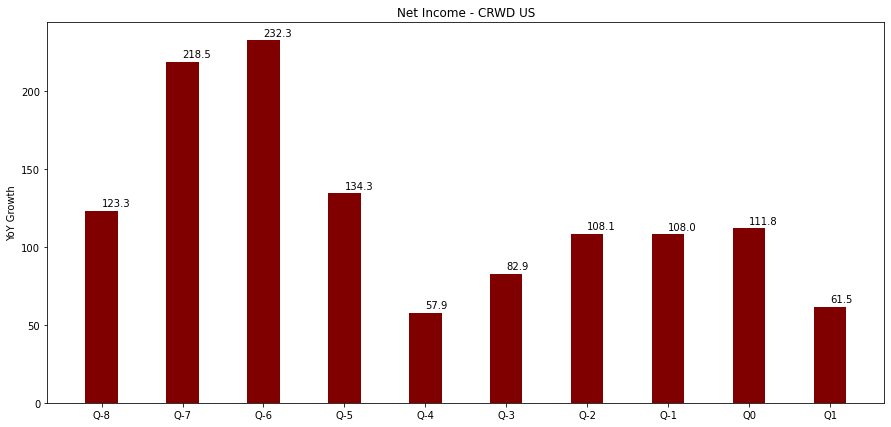

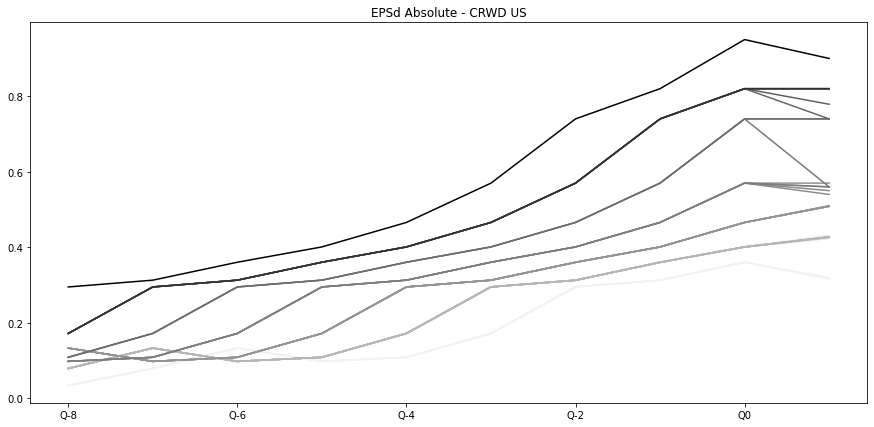

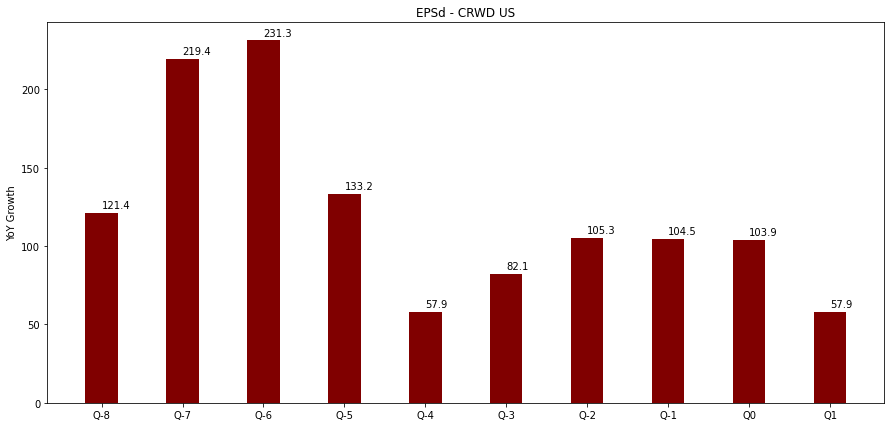

In [291]:
## Stock deep dive

import pandas as pd
import numpy as np
import math
import os
import csv
import yfinance as yf
from yahoofinancials import YahooFinancials as yfs
#import mysql.connector
import psycopg2
import requests
import json
import tkinter as tk
import re
import time
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sqlalchemy import create_engine
import plotly.graph_objects as go

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def on_selection(value):
    global choice
    choice = value  # store the user's choice
    root.destroy()  # close window 
    
def on_selection_s(value):
    global choice_s
    choice_s = value  # store the user's choice
    root.destroy()  # close window     

dbase = "visiblealpha_laptop"
dbase_metrics = "metrics_laptop"

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

engine_metrics = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase_metrics))

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase_metrics, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")

today = date.today()
today = today - timedelta((today.weekday() % 4) * (today.weekday() // 4))

query_ed = "SELECT * FROM ed_relation"
ed_df = pd.read_sql_query(query_ed, engine)
ed_df = Set_DF(ed_df)
ed_df = DD_Index(ed_df)
ed_df['AUX'] = ed_df.index
dum_l1 = []
dum_l2 = []
for dum in ed_df['AUX']:
    dum_s = dum.split('QCY-')
    ed_df.loc[dum, 'AUX'] = int(str(dum_s[1]) + str(dum_s[0]))
ed_df.sort_values(by=['AUX'], inplace=True)
ed_df.drop('AUX', axis=1, inplace=True)

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)

query_OI = "SELECT * FROM valuations_oi_relation"
OI_df = pd.read_sql_query(query_OI, engine_metrics)
OI_df = Set_DF(OI_df)
OI_df = DD_Index(OI_df)

query_PS = "SELECT * FROM valuations_ps_relation"
PS_df = pd.read_sql_query(query_PS, engine_metrics)
PS_df = Set_DF(PS_df)
PS_df = DD_Index(PS_df)

Q_List = ['Q-8', 'Q-7', 'Q-6', 'Q-5', 'Q-4', 'Q-3', 'Q-2', 'Q-1', 'Q0', 'Q1']
Sector_List = ['CYBER', 'DATA', 'ENTERPRISE', 'SEMIS', 'eCOM', 'DigiAds', 'TRAVEL', 'AutoOEM']

Cyber_List = ['CRWD US', 'ZS US', 'PANW US', 'FTNT US', 'NET US', 'RPD US', 'S US', 'OKTA US']
Data_List = ['AMZN US', 'SNOW US', 'DDOG US', 'MDB US', 'MSFT US', 'NET US', 'PLTR US', 'DT US', 'NEWR US', 'ESTC US']
Enterprise_List = ['MSFT US', 'NOW US', 'MNDY US', 'CRM US', 'ADBE US', 'SMAR US', 'PLTR US', 'TWLO US', 'ZI US', 'INFA US', 'ESTC US']
Semis_List = ['NVDA US', 'AMD US', 'AVGO US', 'MCHP US', 'MU US', 'QCOM US', 'TSLA US', 'ANET US', 'MRVL US', 'INTC US', 'AMAT US', 'LRCX US', 'KLAC US', 'SMCI US', 'ARM US']
eCom_List = ['HUBS US', 'SHOP CN', 'SQ US', 'MELI US']
Ads_List = ['GOOGL US', 'META US', 'TTD US', 'SNAP US', 'ROKU US', 'NFLX US']
TravelList = ['BKNG US', 'ABNB US', 'EXPE US']
AutoMakers_List = ['TSLA US', 'RIVN US', 'F US', 'GM US']

Reports_List = ['', '_gp', '_oi', '_nils', '_epsd']
Names_List = ['Revenues', 'Gross Profit', 'Op Income', 'Net Income', 'EPSd']

Assignment_Dict = {'CYBER': Cyber_List, 'DATA': Data_List, 'ENTERPRISE': Enterprise_List, 'SEMIS': Semis_List, 'eCOM': eCom_List, 'DigiAds': Ads_List, 'TRAVEL': TravelList, 'AutoOEM': AutoMakers_List}

root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *Sector_List, command = on_selection)
tk.Label(root, text = "Select Sector: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

Start_Date = input("Enter Start Date: (20/01/01)")
if (Start_Date == ''):
    Start_Date = '20/01/01'
Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()

selected_List = Assignment_Dict[choice]
Pxs_Slice_df = Prices_df[selected_List]
Pxs_Slice_df = Pxs_Slice_df[Pxs_Slice_df.index >= Start_Date]
Pxs_Slice_df = Pxs_Slice_df / Pxs_Slice_df.iloc[0].values

OI_Slice_df = OI_df[selected_List]
OI_Slice_df = OI_Slice_df[OI_Slice_df.index >= Start_Date]
OI_Slice_df = OI_Slice_df.clip(0, 200) #/ OI_Slice_df.clip(0, 200).iloc[0].values

PS_Slice_df = PS_df[selected_List]
PS_Slice_df = PS_Slice_df[PS_Slice_df.index >= Start_Date]
PS_Slice_df = PS_Slice_df.clip(0, 100) #/ PS_Slice_df.clip(0, 100).iloc[0].values

plt.figure(0, figsize = (15, 7))
for ticker in Pxs_Slice_df.columns.values:
    Pxs_Slice_df[ticker].plot(label = ticker).legend(loc = 'best')
plt.title('Normalized Prices')    
    
plt.figure(1, figsize = (15, 7))
for ticker in OI_Slice_df.columns.values:
    OI_Slice_df[ticker].plot(label = ticker).legend(loc = 'best')
plt.title('Normalized P/OI')     
    
plt.figure(2, figsize = (15, 7))
for ticker in PS_Slice_df.columns.values:
    PS_Slice_df[ticker].plot(label = ticker).legend(loc = 'best')
plt.title('Normalized P/S')     

selected_List.append('')
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *selected_List, command = on_selection_s)
tk.Label(root, text = "Select Stock (empty to skip): ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

if (choice_s != ''):
    Cutoff_Date = input("Enter Cutoff Date: (22/10/01)")
    if (Cutoff_Date == ''):
        Cutoff_Date = '22/10/01'
    Cutoff_Date = datetime.strptime(Cutoff_Date, "%y/%m/%d").date()
    ticker = choice_s
    ticker_sql = re.sub(r'[^a-z_^0-9]', '', ticker.lower())
    idx = 3
    for report in Reports_List: 
        try:
            REP_NAME = Names_List[Reports_List.index(report)]
            rep = ticker_sql + report
            query_report = "SELECT * FROM " + rep
            Report_df = pd.read_sql_query(query_report, engine)
            Report_df = Set_DF(Report_df)
            Report_df = DD_Index(Report_df)
            Report_df = Report_df[Report_df.index >= Cutoff_Date]
            if (report == ''):
                lrd = Report_df.index[-1]
                led = datetime(today.year, int(ed_df[ticker].iloc[-1][:2]), int(ed_df[ticker].iloc[-1][2:])).date()
                print(choice_s + ' LAST RECORDED DATE: ' + lrd.strftime('%Y-%b-%d'))
                print(choice_s + ' CURRENT EARNINGS DATE: ' + led.strftime('%Y-%b-%d'))
            Rep_Slice_df = Report_df[Q_List]
            plt.figure(idx, figsize = (15, 7))
            ttl_len = len(Rep_Slice_df.index)
            for c, dt in enumerate(Rep_Slice_df.index):
                color = str((1 - (c + 1) / ttl_len) ** (1 / 2.5))
                Rep_Slice_df.loc[dt].plot(c = color)
            plt.title(REP_NAME + ' Absolute - ' + choice_s)
            idx += 1
            plt.figure(idx, figsize = (15, 7))
            Last_G_series = round(100 * (Report_df - Report_df.T.shift(4).T) / abs(Report_df.replace({None: np.nan}).T.shift(4).T), 2)[Q_List].iloc[-1].clip(-250, 250)
            plt.bar(Last_G_series.index, Last_G_series.values, color = 'maroon', width = 0.4)
            for i in range(len(Last_G_series.index)):
                plt.text(i, Last_G_series.values[i] + np.sign(Last_G_series.values[i]) * (round(Last_G_series.max() / 100, 0) + 1), str(round(Last_G_series.values[i], 1)))
            plt.ylabel('YoY Growth')
            plt.title(REP_NAME + ' - ' + choice_s)
            idx += 1
        except:
            print(choice_s + ' - ' + report + ' FAILED')


In [114]:
#HIGH/LOW/OPEN/CLOSE BARS FOR STOCKS & FX

import plotly.graph_objects as go

def on_selection(value):
    global choice
    choice = value  # store the user's choice
    root.destroy()  # close window 

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)
today = Prices_df.index[-1]

query_fxprices = 'SELECT * FROM fxprices_relation'    
FX_Prices_df = pd.read_sql_query(query_fxprices, engine)
FX_Prices_df = Set_DF(FX_Prices_df)
FX_Prices_df = DD_Index(FX_Prices_df)

stock_list = []
pre_selection = ['TSLA US', 'CRWD US', 'SNOW US', 'NVDA US', 'AMD US', 'MDB US', 'DDOG US', 'ZI US', 'SHOP CN', 
                'ZS US', 'TTD US', 'PLTR US', 'ENPH US', 'HUBS US', 'SQ US']
pre_selection_fx = ['USDBRL', 'USDMXN', 'AUDUSD', 'EURUSD', 'USDJPY', 'GBPUSD', 'USDCAD']

ticker = 'dummy'
fx_select = False
while (ticker != '') & (ticker != 'T') & (ticker != 'F'):
    ticker = input('Enter ALGO ticker: (empty to stop, T/t for template or F/f for FX template) ').upper()
    if ((ticker in FX_Prices_df.columns) | (ticker == 'F')) & (not fx_select):
        fx_select = True
    if (fx_select):
        if (ticker != '') & (ticker != 'dummy') & (ticker in FX_Prices_df.columns) & (ticker != 'F'):
            stock_list.append(ticker)
        elif (ticker == 'F'):
            stock_list = pre_selection_fx.copy()     
    else:
        if (ticker != '') & (ticker != 'dummy') & (ticker in Prices_df.columns) & (ticker != 'T'):
            stock_list.append(ticker)
        elif (ticker == 'T'):
            stock_list = pre_selection.copy()        
        
if (len(stock_list) > 0):
    if (fx_select):
        Selection_df = FX_Prices_df[stock_list].copy()
    else:
        Selection_df = Prices_df[stock_list].copy()

    tenor_option_list = ['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '5Y']
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *tenor_option_list, command = on_selection)
    tk.Label(root, text = "Select Window: ").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()

    if (choice[1] == 'M'):
        delta = float(choice[0]) * 21
    else:
        delta = float(choice[0]) * 252
    start_date = today - timedelta(delta)
    Selection_df = Selection_df[Selection_df.index >= start_date]
    
    if (fx_select):
        usd_tracker = Selection_df.columns.map(lambda x: x.find('USD'))
        exp_array = pd.Series(usd_tracker.values).replace({0: 1,  -1: 1, 3: -1}).values
        for idx, pair in enumerate(Selection_df.columns):
            Selection_df[pair] = Selection_df[pair] ** exp_array[idx]
    
    Selection_df = Selection_df / Selection_df.std() / (Selection_df / Selection_df.std()).iloc[0]
    Selection_df = Selection_df.T.sort_values(by = Selection_df.index[-1]).T
    labels = Selection_df.columns.values.tolist()
    open_data = Selection_df.iloc[0].values.tolist()
    low_data = Selection_df.min().values.tolist()
    high_data = Selection_df.max().values.tolist()
    close_data = Selection_df.iloc[-1].values.tolist()

    fig = go.Figure(data = [go.Candlestick(x = labels, open = open_data,
                                          low = low_data, high = high_data,
                                          close = close_data)])

    fig.update_layout(title = choice + ' WINDOW')
    fig.show()

Enter ALGO ticker: (empty to stop, T/t for template or F/f for FX template) F


In [93]:
ci = benchmark_vector[0]
up_on_ST = benchmark_vector[1]
up_off_ST = benchmark_vector[2]
up_on_MT = benchmark_vector[3]
up_off_MT = benchmark_vector[4]
lr_mult_ST = benchmark_vector[5]
rf_mult_ST = benchmark_vector[6]
en_mult_ST = benchmark_vector[7]
lr_mult_MT = benchmark_vector[8]
rf_mult_MT = benchmark_vector[9]
en_mult_MT = benchmark_vector[10]
rmse_mult = benchmark_vector[11]
down_on_ST = benchmark_vector[12]
down_off_ST = benchmark_vector[13]
down_on_MT = benchmark_vector[14]
down_off_MT = benchmark_vector[15]
STD_w = int(benchmark_vector[16])
STD_a = int(benchmark_vector[17])
start_vector_live_ST = start_vector_live_ST
start_vector_live_MT = start_vector_live_MT
SECTOR_LIST = pd.unique(NewSectorPositions_df.columns).tolist()

up_off_ST = -2 ################################

STD_mult = norm.ppf(ci)
Forecast_ST_df = (LR_Forecasts_df * lr_mult_ST + RF_Forecasts_df * rf_mult_ST + EN_Forecasts_df * en_mult_ST) / (lr_mult_ST + rf_mult_ST + en_mult_ST)
Forecast_MT_df = (LR_Forecasts_df * lr_mult_MT + RF_Forecasts_df * rf_mult_MT + EN_Forecasts_df * en_mult_MT) / (lr_mult_MT + rf_mult_MT + en_mult_MT)
CORRELATION_LIST = [correlation_window_ST, correlation_window_MT]
CORRELATION_LIST = [correlation_window_ST]  ##################################################

for current_corr in CORRELATION_LIST:
    if (current_corr == correlation_window_ST):   
        Forecast_df = Forecast_ST_df
        start_vector = start_vector_live_ST
        up_on = up_on_ST
        up_off = up_off_ST
        down_on = down_on_ST
        down_off = down_off_ST
    else:
        Forecast_df = Forecast_MT_df
        start_vector = start_vector_live_MT
        up_on = up_on_MT
        up_off = up_off_MT
        down_on = down_on_MT
        down_off = down_off_MT
    d_list = Forecast_df.index
    d_list = d_list[d_list >= date_02]
    d_list = d_list[d_list <= date_03]
    SectorPositions_df = pd.DataFrame(0, index = d_list, columns = SECTOR_LIST)
    SectorPositions_df.iloc[0] = start_vector
    
    for sector in SECTOR_LIST:
        
        if (sector == 'Hardware'):
            window_str = sector + ' CORR' + str(current_corr)
            sector_ret_str = sector + ' ' + str(LAG_returns) + ' FWD Returns'
            sector_fwd_rets = Forecast_df.T[Forecast_df.columns.map(lambda x: x.find(sector_ret_str)) != -1].T.shift(LAG_returns + 1)
            shifted_forecasts = Forecast_df[window_str].shift(LAG_returns + 1)

            Std_series = Forecast_df[window_str].clip(-20, 20).rolling(STD_w).std().replace({np.nan: 0}).rolling(STD_a).mean() * STD_mult
            Ret_series_RAW = Forecast_df[window_str]
            i = 0
            for ccurrent_date in d_list[:-40]:          ####################################################################

                Forecast_RAW = Ret_series_RAW.loc[ccurrent_date] 
                Forecast_STD = Std_series.loc[ccurrent_date]
                Forecast_RMSE = 0
                if (RMSE_b):
                    try:
                        Forecast_RMSE = np.sqrt(mean_squared_error(sector_fwd_rets[sector_fwd_rets.index < ccurrent_date][-10:], shifted_forecasts[shifted_forecasts.index < current_date][-10:]))
                        Forecast_RMSE = Forecast_RMSE / rmse_mult
                    except:
                        pass

                if (len(Ret_series_RAW[Ret_series_RAW.index < ccurrent_date].index) >= STD_w):
                    Forecast_UP = Forecast_RAW - Forecast_STD - Forecast_RMSE
                    Forecast_DOWN = Forecast_RAW + Forecast_STD + Forecast_RMSE
                else:
                    Forecast_UP = 0
                    Forecast_DOWN = 0

                if ((ccurrent_date.day == 25) & (ccurrent_date.month == 12)) | ((ccurrent_date.day == 1) & (ccurrent_date.month == 1)):
                    if (ccurrent_date in SectorPositions_df.index):
                        SectorPositions_df.drop(ccurrent_date, inplace = True)
                        i = i - 1
                else:
                    if (Forecast_UP >= up_on):
                        SectorPositions_df.loc[ccurrent_date, sector] = 1
                    elif (Forecast_DOWN <= down_on):
                        SectorPositions_df.loc[ccurrent_date, sector] = -1
                    else:
                        if (i > 0):
                            SectorPositions_df.loc[ccurrent_date, sector] = SectorPositions_df.iloc[i - 1][sector]
                    if (SectorPositions_df.loc[ccurrent_date, sector] == 1):
                        if (Forecast_RAW <= up_off): 
                            SectorPositions_df.loc[ccurrent_date, sector] = 0
                    if (SectorPositions_df.loc[ccurrent_date, sector] == -1):
                        if (Forecast_RAW >= down_off): 
                            SectorPositions_df.loc[ccurrent_date, sector] = 0
                    i = i + 1

            if ('QQQ' in SectorPositions_df.columns):
                SectorPositions_df.drop(['QQQ'], axis = 1, inplace = True)
            if ('SPX' in SectorPositions_df.columns):
                SectorPositions_df.drop(['SPX'], axis = 1, inplace = True)
            if (current_corr == correlation_window_ST):
                SectorPositions_ST_df = SectorPositions_df.copy()
            else:
                SectorPositions_MT_df = SectorPositions_df.copy()

NewSectorPositions_df = (SectorPositions_ST_df + SectorPositions_MT_df).clip(-1, 1)
final_vector_ST = SectorPositions_ST_df.iloc[-1].values
final_vector_MT = SectorPositions_MT_df.iloc[-1].values

sector_list_slim_L = NewSectorPositions_df.replace({-1: 0}).sum()[NewSectorPositions_df.replace({-1: 0}).sum() != 0].index.values.tolist()
sector_list_slim_S = NewSectorPositions_df.replace({1: 0}).sum()[NewSectorPositions_df.replace({1: 0}).sum() != 0].index.values.tolist()
sector_list_slim = pd.unique(sector_list_slim_L + sector_list_slim_S).tolist()


to_sector = lambda x: Sectors_df.loc[x, 'Custom Sector 1']
to_targets = lambda x: sector_targets.loc[x]
to_previous_prices = lambda x: Prices_df.loc[prev_rebal_date, x]
to_previous_prices_2 = lambda x: Prices_df.loc[curr_rebal_date, x]
to_current_prices = lambda x: Prices_df.loc[current_date, x]
to_level1 = lambda x: x.split(',')[0][2:-1]
to_level2 = lambda x: x.split(',')[1][2:-2]
to_region = lambda x: x[-2:]
to_ccy = lambda x: FX_df.loc[x, 'Pair']

companies_share = 1 / 10
min_ps = 2
global_cap = 30
nul_sector_list = []
return_threshold = 5
port_change_thresh = 0.35
max_allocation = 25 / 100
min_stocks = int(round(1 / max_allocation, 0))

Sectors_ETF_list = ['Financials']
over = 'O'
ext = '_slim_' + comp_ext

sector_list_slim = ['Hardware'] #############################################################################

for Current_Sector in sector_list_slim:
    date_series = NewSectorPositions_df[Current_Sector][NewSectorPositions_df[Current_Sector] == 1].index
    date_list = date_series.values.tolist()

    if (len(date_list) > 0):
        port_len = int(round(len(Sectors_df[Sectors_df['Custom Sector 1'] == Current_Sector].index) * 0.2, 0))
        div = 1
        if (Current_Sector in Sectors_ETF_list):
            div = 2
        Sector_Port_db = pd.DataFrame(np.nan, index = date_list, columns = (np.arange(port_len) + 1))

        if (len(Sector_Port_db.columns) < min_stocks):
            add_array = np.arange(min_stocks - len(Sector_Port_db.columns)) + Sector_Port_db.columns[-1] + 1
            for add in add_array:
                Sector_Port_db[add] = np.nan

        valid_port_date = date_list[0]

        for idd, current_date in enumerate(date_list):

            if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                pass
            else:
                final_port_list = []
                ETF_equiv = Equivalence_df.loc[current_date, Current_Sector]

                stocks_current_series = Port_Select_DF.loc[current_date]
                stocks_selected_series = Port_Select_DF.loc[valid_port_date]

                port_change_ratio = (len(pd.unique(stocks_current_series.tolist() + stocks_selected_series.tolist())) / len(stocks_current_series)) - 1
                if (port_change_ratio >= port_change_thresh):
                    valid_port_date = current_date
                    stocks_selected_series = stocks_current_series

                alloc_selected_series = Port_Alloc_DF.loc[valid_port_date].dropna()

                stocks_selected_series = stocks_selected_series.loc[alloc_selected_series.index] ###############
                sector_selected_series = stocks_selected_series.map(to_sector)

                sector_stocks = list(stocks_selected_series[sector_selected_series == Current_Sector])
                port_a_len = len(sector_stocks)
                final_port_list = sector_stocks[:port_len]

                min_stocks_ = max(min_stocks, round_down(port_len / 4, 0))
                if (len(final_port_list) < min_stocks_):
                    ETF_list = []
                    ETF_list.append(ETF_equiv)
                    ETF_list = ETF_list * (min_stocks_ - len(final_port_list))
                    final_port_list = final_port_list + ETF_list

                if (len(final_port_list) == 0):
                    if (len(sector_stocks) > 0):
                        final_port_list = sorted(sector_stocks.copy())[::-1]
                    else:
                        final_port_list.append(ETF_equiv)
                    final_port_list = final_port_list + [''] * (port_len - len(final_port_list))

                final_port_list_clean = pd.Series(final_port_list)[pd.Series(final_port_list) != ''].values.tolist()
                final_len_clean = int(round_down(len(final_port_list_clean) / div, 0))
                complement = len(final_port_list_clean) - final_len_clean

                if (complement > 0):
                    final_port_list = final_port_list[:final_len_clean] + [ETF_equiv] * complement
                    final_port_list = final_port_list + [''] * (len(Sector_Port_db.columns) - len(final_port_list))

                if (len(final_port_list) < port_len):
                    final_port_list = final_port_list + [''] * (port_len - len(final_port_list))

                Sector_Port_db.loc[current_date] = final_port_list
        Sector_Port_db.dropna(how = 'all', inplace = True)
        k = 0
        if (Current_Sector not in nul_sector_list):

            if (type(Sector_Port_db.columns[0]) != str):
                Sector_Port_db.columns = Sector_Port_db.columns.astype(str)

            for sector_x in nul_sector_list:
                NewSectorPositions_df[sector_x] = float(0)

            sector_dates = NewSectorPositions_df[Current_Sector][NewSectorPositions_df[Current_Sector] == 1].index

            if (len(sector_dates) > 0):
                init_date = sector_dates[0]
                final_date = date_03
                date_spam = Prices_df.index[Prices_df.index >= init_date]
                date_spam = date_spam[date_spam <= final_date]

                for current_date in sector_dates:
                    if (current_date not in Sector_Port_db.index):
                        Sector_Port_db.loc[current_date] = Sector_Port_db[Sector_Port_db.index > current_date].iloc[0]
                Sector_Port_db.sort_index(axis = 0, inplace = True)

                sector_targets = round(Sectors_df['Custom Sector 1'].dropna().value_counts() * companies_share, 0).astype(int)
                sector_target = sector_targets[Current_Sector]

                sector_portfolio_df = pd.DataFrame(index = date_spam, columns = [['Stocks'] * sector_target, np.arange(sector_target)])
                sector_portfolio_df['Index'] = float(1)
                sector_portfolio_df['Date_BU'] = sector_portfolio_df.index

                sector_portfolio_df.sort_index(inplace = True)
                number_stocks01_df = pd.DataFrame(np.array(NewSectorPositions_df.replace({-1: 0})).dot(np.array(NewSectorPositions_df.columns.map(to_targets)).T).astype(int), index = NewSectorPositions_df.index, columns = ['Number of Stocks'])
                prev_list = []
                rebalancing_dates_list = []
                portfolio_string = re.sub(r'[^a-z_^0-9]', '', Current_Sector.lower()) + '_portfolio_selection' + ext

                for idx, current_date in enumerate(date_spam):
                    if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                        pass
                    else:
                        last_sr_date = sector_dates[sector_dates <= current_date][-1]
                        current_ns = number_stocks01_df.loc[last_sr_date][0]
                        base_number = int(NewSectorPositions_df.loc[last_sr_date].replace({-1: 0}).sum() * min_ps)
                        haircut = 0
                        if (current_ns > global_cap):
                            haircut = max(0, (current_ns - global_cap) / abs(current_ns - base_number))
                        hc_series = pd.Series((np.array(NewSectorPositions_df.loc[last_sr_date].replace({-1: 0})) * np.array(NewSectorPositions_df.columns.map(to_targets)) * haircut)).apply(round_down, 0)
                        final_ns_array = (np.array(NewSectorPositions_df.loc[last_sr_date].replace({-1: 0}) * np.array(NewSectorPositions_df.columns.map(to_targets))) - np.array(hc_series)).astype(int)
                        magic_number = final_ns_array[NewSectorPositions_df.columns.values.tolist().index(Current_Sector)]
                        current_list = sorted(Sector_Port_db.loc[last_sr_date][:magic_number].values.tolist() + [''] * (sector_target - len(Sector_Port_db.loc[last_sr_date][:magic_number].values.tolist())))[::-1]
                        sector_portfolio_df.loc[current_date, ['Stocks']] = current_list
                        sector_portfolio_df.loc[current_date, 'Index'] = float(1)
                        if (current_list != prev_list):
                            rebalancing_dates_list.append(current_date)
                        prev_list = current_list

                sector_portfolio_df.dropna(how = 'all', inplace = True)
                sector_portfolio_df.sort_index(inplace = True)

                date_spam_2 = sector_portfolio_df.index.values.tolist()
                for idx, current_date in enumerate(date_spam_2):
                    if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                        sector_portfolio_df.drop(current_date, inplace = True)
                    else:
                        current_prices = sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].map(to_current_prices) / ('USD' + sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_current_prices)
                        if (current_date == sector_portfolio_df.index[0]):
                            prev_k = 1
                            current_positions = prev_k / sector_portfolio_df.loc[current_date][sector_portfolio_df.loc[current_date] != '']['Stocks'].count() / current_prices
                        else:
                            prev_rebal_date = pd.Series(rebalancing_dates_list).values[pd.Series(rebalancing_dates_list).values < current_date][-1]
                            curr_rebal_date = pd.Series(rebalancing_dates_list).values[pd.Series(rebalancing_dates_list).values <= current_date][-1]
                            previous_prices = (sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].map(to_previous_prices) / ('USD' + sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices)).values
                            previous_prices_2 = (sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].map(to_previous_prices_2) / ('USD' + sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices_2)).values

                            previous_positions = (sector_portfolio_df.loc[prev_rebal_date, 'Index'][0] / sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].count() / previous_prices)
                            prev_k = (previous_positions * sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].map(to_previous_prices_2) / ('USD' + sector_portfolio_df.loc[prev_rebal_date][sector_portfolio_df.loc[prev_rebal_date] != '']['Stocks'].replace({'SPX': 'SPX US', 'QQQ': 'QQQ US'}).map(to_region).map(to_ccy)).map(to_previous_prices_2)).sum()
                            current_positions = (prev_k / sector_portfolio_df.loc[curr_rebal_date][sector_portfolio_df.loc[curr_rebal_date] != '']['Stocks'].count() / previous_prices_2) 
                        sector_portfolio_df.loc[current_date, 'Index'] = (current_positions * current_prices).sum()

                sector_portfolio_df['Date_BU'] = sector_portfolio_df.index
                sector_portfolio_df.sort_index(inplace = True)
                sector_portfolio_df.to_sql(portfolio_string, engine, index = True, if_exists = 'replace')
                new_tables_list.append(portfolio_string)
                print(Current_Sector)
                k = k + 1

        else:
            print(Current_Sector + ' Not Available')

Forecast_ST_df.T[Forecast_ST_df.columns.map(lambda x: x.find('Hardware')) != -1].T[-60:]
NewSectorPositions_df

Hardware


Consumer Goods  Consumer Services  Energy  Financials  Hardware  \
Dates                                                                         
2017-01-02             0.0                0.0     0.0         0.0       0.0   
2017-01-03             0.0                0.0     0.0         0.0       0.0   
2017-01-04             0.0                0.0     0.0         0.0       0.0   
2017-01-05             0.0                0.0     0.0         0.0       0.0   
2017-01-06             0.0                0.0     0.0         0.0       0.0   
...                    ...                ...     ...         ...       ...   
2023-10-03             0.0                0.0     0.0         0.0       0.0   
2023-10-04             0.0                0.0     0.0         0.0       0.0   
2023-10-05             0.0                0.0     0.0         0.0       0.0   
2023-10-06             0.0                0.0     0.0         0.0       0.0   
2023-10-09             0.0                0.0     0.0         0.0       0.0   

            Health Care  Industrials  Materials  Software  Telecommunications  \
Dates                                                                           
2017-01-02          0.0          0.0        0.0       0.0                 0.0   
2017-01-03          0.0          0.0        0.0       0.0                 0.0   
2017-01-04          0.0          0.0        0.0       0.0                 0.0   
2017-01-05          0.0          0.0        0.0       0.0                 0.0   
2017-01-06          0.0          0.0        0.0       0.0                 0.0   
...                 ...          ...        ...       ...                 ...   
2023-10-03          0.0          0.0        0.0       0.0                 0.0   
2023-10-04          0.0          0.0        0.0       0.0                 0.0   
2023-10-05          0.0          0.0        0.0       0.0                 0.0   
2023-10-06          0.0          0.0        0.0       0.0                 0.0   
2023-10-09          0.0          0.0        0.0       0.0                 0.0   

            Utilities  
Dates                  
2017-01-02        0.0  
2017-01-03        0.0  
2017-01-04        0.0  
2017-01-05        0.0  
2017-01-06        0.0  
...               ...  
2023-10-03        0.0  
2023-10-04        0.0  
2023-10-05        0.0  
2023-10-06        0.0  
2023-10-09        0.0  

[1758 rows x 11 columns]

In [118]:
NewSectorPositions_df.T[NewSectorPositions_df.columns.map(lambda x: x.find('Consumer Goods')) != -1].T[-60:]

Consumer Goods
Dates                     
2023-07-18             0.0
2023-07-19             0.0
2023-07-20             0.0
2023-07-21             0.0
2023-07-24             0.0
2023-07-25             0.0
2023-07-26             0.0
2023-07-27             0.0
2023-07-28             0.0
2023-07-31             0.0
2023-08-01             0.0
2023-08-02             0.0
2023-08-03             0.0
2023-08-04             0.0
2023-08-07             0.0
2023-08-08             0.0
2023-08-09             0.0
2023-08-10             0.0
2023-08-11             0.0
2023-08-14             0.0
2023-08-15             0.0
2023-08-16             0.0
2023-08-17             0.0
2023-08-18             0.0
2023-08-21             0.0
2023-08-22             0.0
2023-08-23             0.0
2023-08-24             0.0
2023-08-25             0.0
2023-08-28             0.0
2023-08-29             0.0
2023-08-30             0.0
2023-08-31             0.0
2023-09-01             0.0
2023-09-04             0.0
2023-09-05             0.0
2023-09-06             0.0
2023-09-07             0.0
2023-09-08             0.0
2023-09-11             0.0
2023-09-12             0.0
2023-09-13             0.0
2023-09-14             0.0
2023-09-15             0.0
2023-09-18             0.0
2023-09-19             0.0
2023-09-20             0.0
2023-09-21             0.0
2023-09-22             0.0
2023-09-25             0.0
2023-09-26             0.0
2023-09-27             0.0
2023-09-28             0.0
2023-09-29             0.0
2023-10-02             0.0
2023-10-03             0.0
2023-10-04             0.0
2023-10-05             0.0
2023-10-06             0.0
2023-10-09             0.0

In [ ]:

Skpi1_s = Sgp1_s
c_calc = 'GP'
l = 1
    
if (c_calc == 'sales'):
    Skpi1_s = Skpi1_s.clip(0, np.inf).replace({0: np.nan})
wasd_spot = wasd_s.loc['Q0']
att_b = False
try:
    wasd_12f = wasd_s.loc['Q12']        
except:
    wasd_12f = wasd_s.iloc[-1]    
if (1):
    kpi_q4d_s = ((Skpi1_s - Skpi1_s.shift(4)).dropna())
    ar_kpi_q4d_s = kpi_q4d_s.copy()
    comp_s = pd.Series(np.arange(12) + 1).map(lambda x: 'Q' + str(x))
    y0_a = kpi_q4d_s[-4:].values
    y1_a = kpi_q4d_s[-8:].values
    y2_a = kpi_q4d_s[-12:].values
    y3_a = kpi_q4d_s[-16:].values
    x0_a = np.arange(y0_a.shape[0]) + 1
    x1_a = np.arange(y1_a.shape[0]) + 1
    x2_a = np.arange(y2_a.shape[0]) + 1
    x3_a = np.arange(y3_a.shape[0]) + 1
    m0 = LinearRegression().fit(x0_a.reshape(-1, 1), y0_a)
    m1 = LinearRegression().fit(x1_a.reshape(-1, 1), y1_a)
    m2 = LinearRegression().fit(x2_a.reshape(-1, 1), y2_a)
    m3 = LinearRegression().fit(x3_a.reshape(-1, 1), y3_a)
    fcast0_a = m0.predict((np.arange(comp_s.shape[0]) + x0_a.shape[0] + 1).reshape(-1, 1))
    fcast1_a = m1.predict((np.arange(comp_s.shape[0]) + x1_a.shape[0] + 1).reshape(-1, 1))
    fcast2_a = m1.predict((np.arange(comp_s.shape[0]) + x2_a.shape[0] + 1).reshape(-1, 1))
    fcast3_a = m1.predict((np.arange(comp_s.shape[0]) + x3_a.shape[0] + 1).reshape(-1, 1))
    r2_0 = max(.1, m0.score(x1_a.reshape(-1, 1), y1_a))
    r2_1 = m1.score(x1_a.reshape(-1, 1), y1_a)
    r2_2 = m2.score(x2_a.reshape(-1, 1), y2_a)
    r2_3 = m3.score(x3_a.reshape(-1, 1), y3_a)
    r2_t = r2_0 + r2_1 + r2_2 + r2_3                

    fcastT_a = (m0.predict(x3_a.reshape(-1, 1)) * r2_0 + m1.predict(x3_a.reshape(-1, 1)) * r2_1 + m2.predict(x3_a.reshape(-1, 1)) * r2_2 + m3.predict(x3_a.reshape(-1, 1)) * r2_3) / r2_t
    r2_T = r2_score(fcastT_a + (np.mean(y3_a) - np.mean(fcastT_a)), y3_a)
    r2_p = r2_T
    try:
        for idx in np.arange(ARIMA_FORECASTS):
            ar_kpi_q4d_s.index = pd.Series(np.arange(ar_kpi_q4d_s.shape[0])).map(lambda x: today - timedelta(x)).sort_values().tolist()
            ARIMA_model = ARIMA(ar_kpi_q4d_s, order = (3, 0, 4), freq = 'D')
            ARIMA_model_fit = ARIMA_model.fit()        
            next_forecast = ARIMA_model_fit.forecast(freq = 'D')
            ar_kpi_q4d_s.loc[next_forecast.index[0].date()] = next_forecast.values[0]

        ar_kpi_q4d_s.index = kpi_q4d_s.index.tolist() + pd.Series(np.arange(ARIMA_FORECASTS) + 1).map(lambda x: 'Q' + str(x)).tolist()

        poly_features = PolynomialFeatures(degree = 2, include_bias = False)
        r2_best = -np.inf
        keep_fit = True
        p = 0
        while (keep_fit):
            arima_m = ar_l[p]
            p += 1
            if (p >= len(ar_l)):
                keep_fit = False
            if (keep_fit):
                fcastf_a = (ar_kpi_q4d_s['Q1':].values * arima_m + fcast0_a * r2_0 + fcast1_a * r2_1 + fcast2_a * r2_2 + 
                            fcast3_a * r2_3) / (arima_m + r2_t)
                Cext_Skpi1_s, CKPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, fcastf_a)
                poly_x = poly_features.fit_transform((np.arange(Cext_Skpi1_s.shape[0]) + 1).reshape(-1, 1))
                poly_m = LinearRegression().fit(poly_x, Cext_Skpi1_s.values)
                fit2 = poly_m.predict(poly_x)
                fit2_s = pd.Series(fit2, index = Cext_Skpi1_s.index)
                r2_f2 = round(poly_m.score(poly_x, Cext_Skpi1_s.values), 2)
                if (r2_f2 > r2_best):                                                                                                                                                                
                    ext_Skpi1_s = Cext_Skpi1_s.copy()
                    KPI_q4Ret_s = CKPI_q4Ret_s.copy()
                    p_best = p
                    r2_best = r2_f2
                    if (KPI_q4Ret_s['Q0':].min() < arima_growth_floor):
                        att_b = True
                if (att_b) & (KPI_q4Ret_s['Q0':].min() > arima_growth_floor):
                    ext_Skpi1_s = Cext_Skpi1_s.copy()
                    KPI_q4Ret_s = CKPI_q4Ret_s.copy()
                    p_best = p
                    r2_best = r2_f2
                    att_b = False
                    keep_fit = False
                if ((r2_best > .9) & (r2_f2 < r2_best)) | (p == len(ar_l)):
                    keep_fit = False
                if (l == 1):
                    print('r2 arima_w ' + str(arima_m) + ', ' + str(r2_f2))
                    Skpi1_s.dropna().plot()
                    Cext_Skpi1_s.plot(linestyle = 'dashed')
                    fit2_s.plot(c = 'r')
                    plt.show()
        if (l == 1):
            print('Best ARIMA weight, ' + c_calc + ': ' + str(p_best))
        cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                               max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                               ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                 abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)
        if (cagr3y < -50) | (str(cagr3y) == 'nan'):
            c = 'a' + 1                              
        r2_p = 1
    except:
        if (l == 1):
            print('ARIMA N/A for ' + ticker + ' ' + c_calc)
        fcastf_a = (fcast0_a * r2_0 + fcast1_a * r2_1 + fcast2_a * r2_2 + fcast3_a * r2_3) / (r2_t)
        ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, fcastf_a)
        if (c_calc != 'earnings'):
            prev_mean = np.quantile(KPI_q4Ret_s[: 'Q0'].values, 0.9)
            last_f = KPI_q4Ret_s.iloc[-1]
        else:
            prev_mean = np.quantile(ext_Skpi1_s[: 'Q0'].values, 0.975)
            last_f = ext_Skpi1_s.iloc[-1]                           
        if (last_f < 0) | (abs(last_f) > prev_mean) | (r2_T < r2_floor):
            if (l == 1):
                print('Amending ' + ticker)
            if (c_calc in add_l):
                AUXkpi_s = pd.Series(ext_Skpi1_s[: 'Q0'].values, index = np.arange(ext_Skpi1_s[: 'Q0'].shape[0]) + 1)
            else:
                AUXkpi_s = pd.Series(KPI_q4Ret_s[: 'Q0'].values, index = np.arange(KPI_q4Ret_s[: 'Q0'].shape[0]) + 1)

            AUXkpi_s.loc[AUXkpi_s.index[-1] + 12] = (prev_mean + last_f) / 2
            x_a = AUXkpi_s.index.values
            y_a = AUXkpi_s.values
            missing_a = (np.arange(11) + AUXkpi_s.index[-2] + 1)
            search_p = True
            p = 1
            r2_p = -np.inf
            best_found = False
            while (search_p) & (p < 5):
                valid = True
                poly_features = PolynomialFeatures(degree = p, include_bias = False)
                poly_x = poly_features.fit_transform(x_a.reshape(-1, 1))
                poly_mx = poly_features.fit_transform(missing_a.reshape(-1, 1))
                poly_m = LinearRegression().fit(poly_x, y_a)
                missing_f = poly_m.predict(poly_mx)
                missing_s = pd.Series(missing_f.tolist() + [y_a[-1]], index = comp_s.values)
                r2_c = poly_m.score(poly_x, y_a)
                if (l == 1):
                    print(str(p) + '- ' + str(r2_c))
                if (c_calc in add_l):
                    ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, missing_s.values)        
                else:
                    ext_Skpi1_s, KPI_q4Ret_s = pct_calc_mult(Skpi1_s, comp_s, missing_s.values)  
                cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                                       max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                                           ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                             abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)                                    
                if (str(cagr3y) == 'nan') | (cagr3y < -50):
                    valid = False
                if (r2_c > (r2_p + R2_MARGIN)) & (valid):
                    r2_p = max(0.01, round(r2_c, 2))                                          
                    missing_b = missing_s.copy()
                    if (p > 3):
                        search_p = False
                    best_found = True
                p += 1
            if (not best_found):
                missing_b = 0 * missing_s
                r2_p = 0.1
            if (c_calc in add_l):
                ext_Skpi1_s, KPI_q4Ret_s = pct_calc_add(Skpi1_s, comp_s, missing_b.values)        
            else:
                ext_Skpi1_s, KPI_q4Ret_s = pct_calc_mult(Skpi1_s, comp_s, missing_b.values) 
    cagr3y = round(100 * ((1 + (ext_Skpi1_s[-4:].sum() - ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) / 
                           max(abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()), 
                               ((abs(ext_Skpi1_s[['Q-3', 'Q-2', 'Q-1', 'Q0']].sum()) + 
                                 abs(ext_Skpi1_s[-4:].sum())) / 2))) ** (1 / 3) - 1), 1)                        
    if (l == 1):
        ext_Skpi1_s.plot(title = c_calc.upper() + ' ' + ticker)
        plt.show()                                                    
        KPI_q4Ret_s.plot(title = c_calc.upper() + ' YoY G ' + ticker)
        plt.show()                        
        print('Implied 3Y ' + c_calc + ' CAGR: ' + str(cagr3y))
    try:
        if (c_calc != 'earnings'):
            val_s = round((wasd_spot * last_px) / Skpi1_s['Q-3':].sum(), 1)
            val_f = round((wasd_12f * last_px) / ext_Skpi1_s[-4:].sum(), 1)
            y = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().values
            x = np.arange((Skpi1_s / abs(Skpi1_s.shift(4))).dropna().shape[0])
            kpi_lr = LinearRegression().fit(x.reshape(-1, 1), y)
            kpi_fit = kpi_lr.predict(x.reshape(-1, 1))
            kpi_fit_s = pd.Series(kpi_fit, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
            r2_f = kpi_lr.score(x.reshape(-1, 1), y)
            adj_kpi_s = pd.Series(y - kpi_fit * r2_f, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
            vol = round(adj_kpi_s.ewm(halflife = 4).std().iloc[-1] * 100, 2)            
        else:
            val_s = round(last_px / Skpi1_s['Q-3':].sum(), 1)
            val_f = round(last_px / ext_Skpi1_s[-4:].sum(), 1)
            y = (Skpi1_s - Skpi1_s.shift(4)).dropna().values
            x = np.arange((Skpi1_s / abs(Skpi1_s.shift(4))).dropna().shape[0])
            kpi_lr = LinearRegression().fit(x.reshape(-1, 1), y)
            kpi_fit = kpi_lr.predict(x.reshape(-1, 1))
            kpi_fit_s = pd.Series(kpi_fit, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
            r2_f = kpi_lr.score(x.reshape(-1, 1), y)
            adj_kpi_s = pd.Series(y - kpi_fit * r2_f, index = (Skpi1_s / abs(Skpi1_s.shift(4))).dropna().index)
            vol = round(adj_kpi_s.ewm(halflife = 4).std().iloc[-1] / abs(Skpi1_s[-4:].mean()) * 100, 2)  
    except:
        print('Vol error for ' + ticker)
else:
    print('ERROR FOR ' + c_calc + ', ' + ticker)    
    
print(vol)   